# Create Feature Motifs

In [3]:
from Bio import SeqIO
from Bio.Seq import Seq
from itertools import combinations
name_450Tryptorubinlikes = "Fasta/tryptorubin_like_peptides_p450s_renamed.fasta"
name_450nonTryptorubinlikes = "Fasta/allP450s_antismash_db.fasta"
foldernameoutput = "Output/Tryptorubinlike_peptides_20_12_2022"

# set to legth of sequence motive you want to test
LENGTH = 4


def easysequence(sequence):
    # creates a string out of the sequence file, that only states if AA is acidic (a), basic (b), polar (p), neutral/unpolar (n),aromatic (r),Cystein (s) or a Prolin (t)
    seqstr = str(sequence)
    seqlist = list(seqstr)
    easylist = []
    for amino_acid in seqlist:
        if amino_acid == 'E' or amino_acid == 'D':

            easylist = easylist+['a']
        if amino_acid == 'K' or amino_acid == 'R' or amino_acid == 'H':

            easylist = easylist+['b']
        if amino_acid == 'S' or amino_acid == 'T' or amino_acid == 'N' or amino_acid == 'Q':

            easylist = easylist+['p']
        if amino_acid == 'F' or amino_acid == 'Y' or amino_acid == 'W':

            easylist = easylist+['r']
        if amino_acid == 'C':
            easylist = easylist+['s']

        if amino_acid == 'P':
            easylist = easylist+['t']

        if amino_acid == 'G' or amino_acid == 'A' or amino_acid == 'V' or amino_acid == 'L' or amino_acid == 'I' or amino_acid == 'M':
            easylist = easylist+['n']
    seperator = ''
    easysequence = seperator.join(easylist)
    return easysequence


def filter_permutations(permutations):
    for p in permutations:
        number_of_seqences_with_motif = 0
        number_of_seqences = 0
        for seq_record in SeqIO.parse(name_450Tryptorubinlikes, "fasta"):
            easyseq = easysequence(seq_record.seq)
            if easyseq.count(p) > 0:
                number_of_seqences_with_motif += 1
            number_of_seqences += 1
        if number_of_seqences_with_motif < (round(number_of_seqences)/2):
            permutations.remove(p)
    return permutations


# creates a list of all sequence motifs to look for
combinations = list(itertools.combinations_with_replacement(
    ["a", "b", "p", "r", "s", "t", "n"], LENGTH))
permutations = list()

for combination in combinations:
    permutations = permutations + \
        list(itertools.permutations(combination, LENGTH))
permutations = (["".join(a) for a in list(dict.fromkeys(permutations))])

# remove all combinations not in sequences

permutations = filter_permutations(permutations)

print("Number of remaining features:", len(permutations))

# final "permutations" should be a list of all sequence motifs to look for
try:
    os.makedirs(foldernameoutput)
except OSError:
    print("Creation of the directory %s failed" % foldernameoutput)
else:
    print("Successfully created the directory %s" % foldernameoutput)
filename_permutations = foldernameoutput+"/permutations.txt"

with open(filename_permutations, 'w') as f:
    for s in permutations:
        f.write(str(s) + '\n')


Number of remaining features: 1265
Successfully created the directory Output/Tryptorubinlike_peptides_20_12_2022


# Create Feature Matrix

In [1]:


#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 26 08:26:52 2022

@author: friederike
"""
import re
import numpy as np

import Bio
import pandas as pd
from Bio import SeqIO, pairwise2, AlignIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

FASTAS_ALIGNED_BEFORE = True

INCLUDE_CHARGE_FEATURES = False
# fill in filenames here!
foldernameoutput = "Output/Tryptorubinlike_peptides_25_01_2023"
# insert either name of fasta or alignment in fasta format (alignment must include "Reference_P450")
name_450tryptorubinlike_peptides = "Fasta/final_run_tryptorubins/Reference and atropopeptides_supplemented_deduplicated_95 Alignment.fasta"
# insert either name of fasta or alignment in fasta format(alignment must include "Reference_P450")
name_450nontryptorubinlike_peptides = "Fasta/final_run_tryptorubins/allP450s_antismash_db_deduplicated_95_with_reference Alignment Alignment Alignment.fasta"
filename_permutations = foldernameoutput+"/permutations.txt"
# S#14703] cytochrome P450 51 Cyp51 ([P#10800] [CYP51] cytochrome P450, family 51 )  from https://cyped.biocatnet.de/sequence/14703
alignmentfa = ("MSAVALPRVSGGHDEHGHLEEFRTDPIGLMQRVRDECGDVGTFQLAGKQVVLLSGSHANEFFFRAGDDDLDQAKAYPFMTPIFGEGVVFDASPERRKEMLHNAALRGEQMKGHAATIEDQVRRMIADWGEAGEIDLLDFFAELTIYTSSACLIGKKFRDQLDGRFAKLYHELERGTDPLAYVDPYLPIESLRRRDEARNGLVALVADIMNGRIANPPTDKSDRDMLDVLIAVKAETGTPRFSADEITGMFISMMFAGHHTSSGTASWTLIELMRHRDAYAAVIDELDELYGDGRSVSFHLRQIPQLENVLKETLRLHPPLIILMRVAKGEFEVQGHRIHEGDLVAASPAISNRIPEDFPDPHDFVPARYEQPRQEDLLNRWTWIPFGAGRHRCVGAAFAIMQIKAIFSVLLREYEFEMAQPPESYRNDHSKMVVQLAQPACVRYRRRTGV")

path_complete_feature_matrix = foldernameoutput + \
    "/complete_feature_matrix.csv"

splitting_list = [["begin", 0, 92], ["sbr1", 93, 192], [
    "sbr2", 193, 275], ["core", 276, 395], ["end", 396, 400]]
fragments = ["begin", "sbr1", "sbr2", "core", "end"]

with open(filename_permutations, 'r') as file:
    permutations = [line.rstrip('\n') for line in file]


def merge_two_dicts(x, y):
    #input-> 2 dictionaries output->  merged dictionary
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z


def calculate_charge(sequence):
    # uses aa sequence as input and calculates the approximate charge of it
    AACharge = {"C": -.045, "D": -.999,  "E": -.998,
                "H": .091, "K": 1, "R": 1, "Y": -.001}
    charge = -0.002
    seqstr = str(sequence)
    seqlist = list(seqstr)
    for aa in seqlist:
        if aa in AACharge:
            charge += AACharge[aa]
    return charge


def easysequence(sequence):
    #creates a string out of the sequence file, that only states if AA is acidic (a), basic (b), polar (p), neutral/unpolar (n),aromatic (r),Cystein (s) or a Prolin (t)
    seqstr = str(sequence)
    seqlist = list(seqstr)
    easylist = []
    for i in seqlist:
        if i == 'E' or i == 'D':
            easylist = easylist+['a']
        if i == 'K' or i == 'R' or i == 'H':
            easylist = easylist+['b']
        if i == 'S' or i == 'T' or i == 'N' or i == 'Q':
            easylist = easylist+['p']
        if i == 'F' or i == 'Y' or i == 'W':
            easylist = easylist+['r']
        if i == 'C':
            easylist = easylist+['s']
        if i == 'P':
            easylist = easylist+['t']
        if i == 'G' or i == 'A' or i == 'V' or i == 'L' or i == 'I' or i == 'M':
            easylist = easylist+['n']

    seperator = ''
    easysequence = seperator.join(easylist)
    return easysequence


def indexing_reference(record):
    # index the reference sequence without ignoring gaps
    list_reference = list(str(record.seq))

    index_aa = 0
    index_mapping = []
    for index, AA in enumerate(list_reference):
        if AA != "-":
            index_aa += 1
            index_mapping.append([index_aa, index])

    return (index_mapping)


def convert_splitting_list(splitting_list, index_reference):
    #-> convert the canonic splitting list to also reflect eventual gaps in the reference sequence
    converted_splitting_list = []
    for fragment in splitting_list:
        converted_splitting_list.append(
            [fragment[0], index_reference[fragment[1]][1], index_reference[fragment[2]-1][1]])
    return converted_splitting_list


def split_alignment(alignment, fragment, fastas_aligned_before):
    # split the aligned sequences at the positions determined by the splitting list
    start = fragment[1]
    end = fragment[2]
    if fastas_aligned_before == False:
        alignment = [alignment]
    seqRecord_list_per_fragment = np.array([["", ""]])
    if fragment[0] == "begin":
        start = 1
    if fragment[0] != "end":
        for record in alignment:
            if record.id != "Reference":
                subsequence = str(record.seq)[start-1:end].replace('-', '')

                seqRecord_list_per_fragment = np.append(seqRecord_list_per_fragment, [
                                                        [record.id, subsequence]], axis=0)
    else:
        for record in alignment:
            if record.id != "Reference":
                subsequence = str(record.seq)[start-1:].replace('-', '')
                seqRecord_list_per_fragment = np.append(seqRecord_list_per_fragment, [
                                                        [record.id, subsequence]], axis=0)
    seqRecord_list_per_fragment = np.delete(
        seqRecord_list_per_fragment, 0, axis=0)

    return seqRecord_list_per_fragment


def fragment_alignment(alignment, splitting_list, fastas_aligned_before):
    # create a matrix from the splitted alignment
    fragment_matrix = pd.DataFrame()
    if fastas_aligned_before == False:

        seqa = alignment[0]
        seqb = alignment[1]
        index_reference = indexing_reference(SeqRecord(Seq(seqa), id=seqa))

        converted_splitting_list = convert_splitting_list(
            splitting_list, index_reference)
        for fragment in converted_splitting_list:
            name_fragment = fragment[0]
            seqRecord_list_per_fragment = split_alignment(
                SeqRecord(Seq(seqb), id=seqb), fragment, fastas_aligned_before)

            fragment_matrix[name_fragment] = seqRecord_list_per_fragment[:, 1]
            fragment_matrix.set_index(
                pd.Index(seqRecord_list_per_fragment[:, 0]))
    else:
        for record in alignment:
            if record.id == "Reference":
                index_reference = indexing_reference(record)
                converted_splitting_list = convert_splitting_list(
                    splitting_list, index_reference)
                for fragment in converted_splitting_list:
                    name_fragment = fragment[0]
                    seqRecord_list_per_fragment = split_alignment(
                        alignment, fragment, fastas_aligned_before)
                    fragment_matrix[name_fragment] = seqRecord_list_per_fragment[:, 1]
    fragment_matrix = fragment_matrix.set_index(
        pd.Index(seqRecord_list_per_fragment[:, 0]))
    print(fragment_matrix)
    return fragment_matrix


def featurize(fragment_matrix, permutations, fragments, include_charge_features):
    #create feature_matrix from fragment_matrix, count motifs in each fragemnt
    feature_matrix = pd.DataFrame()

    for index, row in fragment_matrix.iterrows():
        new_row = {}
        for fragment in fragments:
            sequence_fragment = row[fragment]

            easysequence_fragment = easysequence(sequence_fragment)
            for motif in permutations:
                name_column = motif+fragment
                new_row = merge_two_dicts(
                    new_row, {name_column: easysequence_fragment.count(motif)})

            if include_charge_features == True:
                new_row = append_charge_features(
                    new_row, fragment, easysequence_fragment, sequence_fragment)
        feature_matrix = feature_matrix.append(new_row, ignore_index=True)
    if include_charge_features == True:
        feature_matrix = sum_charge_features(feature_matrix, fragments)

    return feature_matrix


def append_charge_features(new_row, fragment, easysequence_fragment, sequence_fragment):
    #append features indicating the charge to the feature matrix
    acidic = fragment+"acidic"
    new_row = merge_two_dicts(new_row, {acidic: (
        easysequence_fragment.count("a")/(len(easysequence_fragment)+1))})
    acidic_absolute = fragment+"acidic absolute"
    new_row = merge_two_dicts(
        new_row, {acidic_absolute: (easysequence_fragment.count("a"))})
    charge_name = fragment+"charge"
    new_row = merge_two_dicts(
        new_row, {charge_name: (calculate_charge(sequence_fragment))})
    basic = fragment+"basic"
    basic_absolute = fragment+"basic absolute"
    new_row = merge_two_dicts(new_row, {basic: (
        easysequence_fragment.count("b")/(len(easysequence_fragment)+1))})
    new_row = merge_two_dicts(
        new_row, {basic_absolute: (easysequence_fragment.count("b"))})
    return new_row


def sum_charge_features(feature_matrix, fragments):
    #sum up charge features to obtain the charge of the whole protein
    chargerows = []
    acidicrows = []
    basicrows = []
    absacidicrows = []
    absbasicrows = []
    for fragment in fragments:
        chargerows.append(str(fragment)+"charge")
        acidicrows.append(str(fragment)+"acidic")
        basicrows.append(str(fragment)+"basic")
        absacidicrows.append(str(fragment)+"acidic absolute")
        absbasicrows.append(str(fragment)+"basic absolute")
    feature_matrix['complete charge'] = feature_matrix[chargerows].sum(axis=1)
    feature_matrix['mean acidic'] = feature_matrix[acidicrows].mean(axis=1)
    feature_matrix['mean basic'] = feature_matrix[basicrows].mean(axis=1)
    feature_matrix['absolute acidic'] = feature_matrix[absacidicrows].sum(
        axis=1)
    feature_matrix['absolute basic'] = feature_matrix[absbasicrows].sum(axis=1)
    return feature_matrix


complete_feature_matrix = pd.DataFrame()
for dataset in (name_450tryptorubinlike_peptides, name_450nontryptorubinlike_peptides):
    if FASTAS_ALIGNED_BEFORE == True:
        alignment = AlignIO.read(open(dataset), "fasta")
        fragment_matrix = fragment_alignment(
            alignment, splitting_list, FASTAS_ALIGNED_BEFORE)
    if FASTAS_ALIGNED_BEFORE == False:
        fragment_matrix = pd.DataFrame()
        seq_record_ids = []
        for seq_record in SeqIO.parse(dataset, "fasta"):
            def fewgaps(x, y): return -20 - y
            def specificgaps(x, y): return (-2 - y)
            alignment = pairwise2.align.globalmc(
                alignmentfa, seq_record.seq, 1, -1, fewgaps, specificgaps)
            fragment_matrix_for_record = fragment_alignment(
                alignment[0], splitting_list, FASTAS_ALIGNED_BEFORE)

            fragment_matrix = fragment_matrix.append(
                fragment_matrix_for_record, ignore_index=True)
            seq_record_ids = seq_record_ids+[seq_record.id]

    feature_matrix = featurize(
        fragment_matrix, permutations, fragments, INCLUDE_CHARGE_FEATURES)

    if dataset == name_450tryptorubinlike_peptides:
        feature_matrix["target"] = 1

    if dataset == name_450nontryptorubinlike_peptides:
        feature_matrix["target"] = 0
    complete_feature_matrix = complete_feature_matrix.append(
        feature_matrix, ignore_index=True)


complete_feature_matrix.to_csv(path_complete_feature_matrix, index=False)


                                                            begin  \
WP_228718569.1  MATETGAPPNTPVPELDPAEIARWQTGGGELVELLTLAREQVGGLA...   
OIJ99544.1                                                          
WP_078891878.1  MPVEPQFVDESFFGRQHEAYREFREQGGARPIRFGGPVRIEGWLVT...   
WP_045948137.1  MSVEQVPVSFFDDPHPAYRRWRELEGGAHRVRILGEAPLEGWVVTG...   
KOV59324.1      MPEPSDGAETVDGSFARDPHEVYRRWREEGGVRKVRFSGAAPLAGW...   
...                                                           ...   
WP_043830661.1  MTIPAERNKVRQVVFAPRIQELFDRYRGKSFFRLEPDTVGVAGPEL...   
PKV93882.1      MTIPAERNKVRQVVFAPRLQELLDRYRGKSFFRLEPDTVGVAGADL...   
WP_125313840.1  MVIARAPRTVVFAPRLEKLLAEHRGDGVFRLEPDTIGIADPPTMDA...   
WP_086860591.1  MVIARASRTVVFAPRLEQLLATHIGDGVFRLEPDTIGIADPETMDG...   
WP_086676982.1  MVIAPAHRAVVFAPRLENLLREHRDDGLFRLEPDTVGIADPELMDA...   

                                                             sbr1  \
WP_228718569.1  GDAWKSQRRLLQSQFTGQGMRRYEQRIAEAARVTAARWAGYARTGQ...   
OIJ99544.1                       

/tmp/ipykernel_973462/1392206650.py:192: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_matrix = feature_matrix.append(new_row, ignore_index=True)
/tmp/ipykernel_973462/1392206650.py:192: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_matrix = feature_matrix.append(new_row, ignore_index=True)
/tmp/ipykernel_973462/1392206650.py:192: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_matrix = feature_matrix.append(new_row, ignore_index=True)
/tmp/ipykernel_973462/1392206650.py:192: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_matrix = feature_matrix.append(new_row, ignore_index=True)
/tmp/ipykernel_973462/139220

                                                                                                begin  \
CHGG_01243|NT_165976.1|join{[3864304:3864908](-),                                                       
FRAQA3DRAFT_RS34890|NZ_CM001489.1|[2622679:2622...                                                      
FRAQA3DRAFT_RS34895|NZ_CM001489.1|[2622910:2623...                                                      
BP5553_00474|NW_022474205.1|join{[1535994:15361...                                                      
SMALB_RS38790|NZ_JAALLH010000002.1|[280332:2804...                                                      
...                                                                                               ...   
CAB17_RS16355|NZ_CP025491.2|[3779304:3781296](+))   MEEQDDQLDYIIMSEEPLPLFIWDSIIDTVMEKVKNISSYISNIWK...   
FQU71_RS18935|NZ_CP042254.1|[4176345:4178337](+))   MKEQDDQLDYIIMSEDPLPLFIWDSIMDTLIEKVKNISSYISNIWQ...   
FDM97_RS17865|NZ_CP040244.1|[3791347:3792874](-))   MTA

/tmp/ipykernel_973462/1392206650.py:192: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_matrix = feature_matrix.append(new_row, ignore_index=True)
/tmp/ipykernel_973462/1392206650.py:192: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_matrix = feature_matrix.append(new_row, ignore_index=True)
/tmp/ipykernel_973462/1392206650.py:192: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_matrix = feature_matrix.append(new_row, ignore_index=True)
/tmp/ipykernel_973462/1392206650.py:192: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_matrix = feature_matrix.append(new_row, ignore_index=True)
/tmp/ipykernel_973462/139220

# Use feature importance to create new feature matrix

Only use this cell, if you already ran the programm and calculated feature importances

In [46]:
import itertools
import Bio
import os
import re
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
from itertools import combinations

# import file with features
foldernameoutput = "Output/Tryptorubinlike_peptides_20_12_2022"
filenamefeatureimportances = foldernameoutput+"/importances.txt"
filename_permutations = foldernameoutput+"/permutationsrefined.txt"

howmanyfeatures = 30
howmany_aa_add = 0


def findallsequencemotifs(contents):
    listmotifs = re.findall("[rnbatsp]\w+", contents)
    return listmotifs


# read file
f = open(filenamefeatureimportances, "r")
if f.mode == 'r':
    contents = f.read()
listmotifs = findallsequencemotifs(contents)

# only take first n of motifs (howmanyfeatures)
listmotifsshort = []
for motif in range(0, howmanyfeatures):
    listmotifsshort = listmotifsshort+[listmotifs[motif]]

# modify features
# add letter


def find_all_permutations_for_additional_letters(aa):
    combinations = list(itertools.combinations_with_replacement(
        ["a", "b", "p", "r", "s", "t", "n"], aa))
    permutations = list()

    for a in combinations:
        permutations = permutations + list(itertools.permutations(a, aa))
    permutations = (["".join(a) for a in list(dict.fromkeys(permutations))])
    return permutations


addet_letters = find_all_permutations_for_additional_letters(howmany_aa_add)

# add letters to all motifs
newlist_motifs = []
for motif in listmotifsshort:
    for letter in addet_letters:
        newlist_motifs = newlist_motifs+[motif+letter]

with open(filename_permutations, 'w') as f:
    for s in newlist_motifs:
        f.write(str(s) + '\n')


['snnn', 'ptrn', 'nntn', 'trnn', 'nbar', 'ntrn', 'nbnr', 'tnnn', 'prnn', 'npbb', 'tabr', 'ntnn', 'annp', 'rata', 'rsnn', 'abrn', 'ttab', 'trnp', 'btnn', 'pnpb']
['aa', 'ab', 'ba', 'ap', 'pa', 'ar', 'ra', 'as', 'sa', 'at', 'ta', 'an', 'na', 'bb', 'bp', 'pb', 'br', 'rb', 'bs', 'sb', 'bt', 'tb', 'bn', 'nb', 'pp', 'pr', 'rp', 'ps', 'sp', 'pt', 'tp', 'pn', 'np', 'rr', 'rs', 'sr', 'rt', 'tr', 'rn', 'nr', 'ss', 'st', 'ts', 'sn', 'ns', 'tt', 'tn', 'nt', 'nn']
['snnnaa', 'snnnab', 'snnnba', 'snnnap', 'snnnpa', 'snnnar', 'snnnra', 'snnnas', 'snnnsa', 'snnnat', 'snnnta', 'snnnan', 'snnnna', 'snnnbb', 'snnnbp', 'snnnpb', 'snnnbr', 'snnnrb', 'snnnbs', 'snnnsb', 'snnnbt', 'snnntb', 'snnnbn', 'snnnnb', 'snnnpp', 'snnnpr', 'snnnrp', 'snnnps', 'snnnsp', 'snnnpt', 'snnntp', 'snnnpn', 'snnnnp', 'snnnrr', 'snnnrs', 'snnnsr', 'snnnrt', 'snnntr', 'snnnrn', 'snnnnr', 'snnnss', 'snnnst', 'snnnts', 'snnnsn', 'snnnns', 'snnntt', 'snnntn', 'snnnnt', 'snnnnn', 'ptrnaa', 'ptrnab', 'ptrnba', 'ptrnap', 'ptrnpa', 'pt

# Machine learning 

ExtraTreesClassifier  score: 0.9994553376906318
ExtraTreesClassifier  balanced Accuracy Score: 0.9791666666666667
ExtraTreesClassifier  crossvalidation scores: [0.97699709 1.         0.98875103 0.98823424 0.98823424]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3624
           1       1.00      0.96      0.98        48

    accuracy                           1.00      3672
   macro avg       1.00      0.98      0.99      3672
weighted avg       1.00      1.00      1.00      3672

RandomForestClassifier  score: 0.9980936819172114
RandomForestClassifier  balanced Accuracy Score: 0.9270833333333333
RandomForestClassifier  crossvalidation scores: [0.96470294 0.97798508 0.98875103 0.97699694 0.98823424]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3624
           1       1.00      0.85      0.92        48

    accuracy                           1.00      3672
   macro avg   

/tmp/ipykernel_11729/487125420.py:131: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depthdiagr = depthdiagr.append(new_line, ignore_index=True)
/tmp/ipykernel_11729/487125420.py:131: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depthdiagr = depthdiagr.append(new_line, ignore_index=True)
/tmp/ipykernel_11729/487125420.py:131: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depthdiagr = depthdiagr.append(new_line, ignore_index=True)
/tmp/ipykernel_11729/487125420.py:131: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depthdiagr = depthdiagr.append(new_line, ignore_index=True)
/tmp/ipykernel_11729/487125420.py:131: FutureWarning: The frame.

Best Max depth: 14


/tmp/ipykernel_11729/487125420.py:131: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depthdiagr = depthdiagr.append(new_line, ignore_index=True)


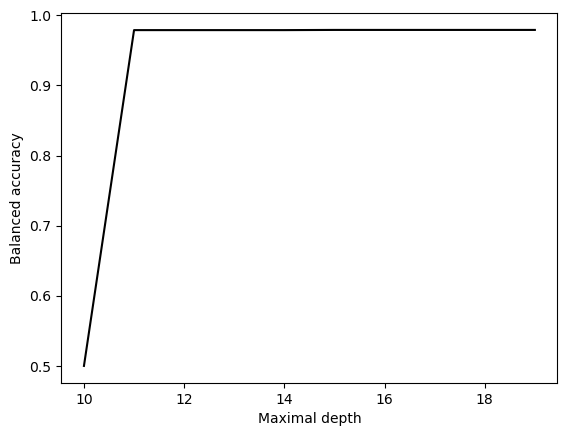

/tmp/ipykernel_11729/487125420.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leafdiagr = leafdiagr.append(new_line, ignore_index=True)
/tmp/ipykernel_11729/487125420.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leafdiagr = leafdiagr.append(new_line, ignore_index=True)
/tmp/ipykernel_11729/487125420.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leafdiagr = leafdiagr.append(new_line, ignore_index=True)


Best minimum samples per leaf: 1


/tmp/ipykernel_11729/487125420.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leafdiagr = leafdiagr.append(new_line, ignore_index=True)


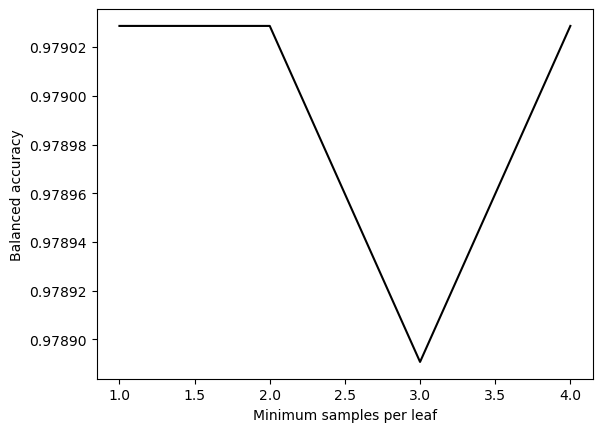

RandomForest_optimized  score: 0.9991830065359477
RandomForest_optimized  balanced Accuracy Score: 0.96875
RandomForest_optimized  crossvalidation scores: [0.95399419 1.         0.97699709 0.98823424 0.97591484]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3624
           1       1.00      0.94      0.97        48

    accuracy                           1.00      3672
   macro avg       1.00      0.97      0.98      3672
weighted avg       1.00      1.00      1.00      3672



/home/friederike/anaconda3/envs/frida/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


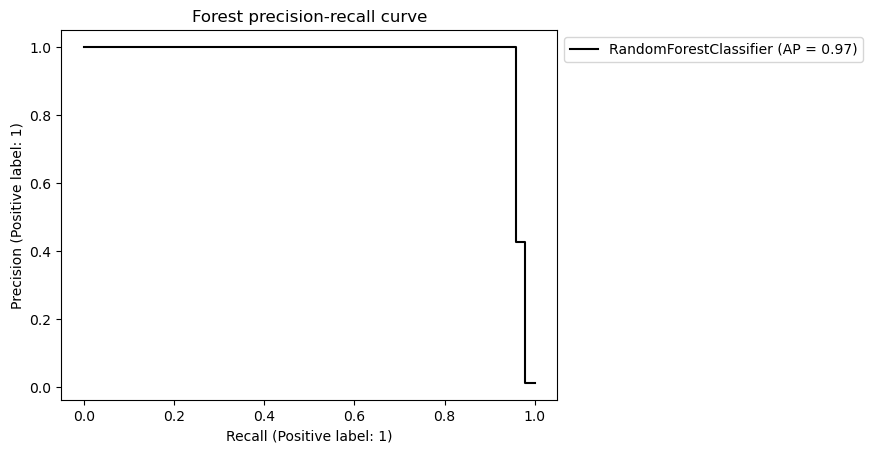

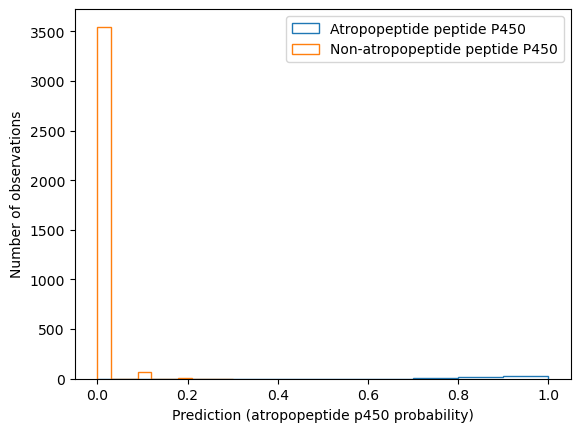

/home/friederike/anaconda3/envs/frida/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/friederike/anaconda3/envs/frida/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/friederike/anaconda3/envs/frida/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/friederike/anaconda3/envs/frida/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/friederike/anaconda3/envs/frida/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/frie

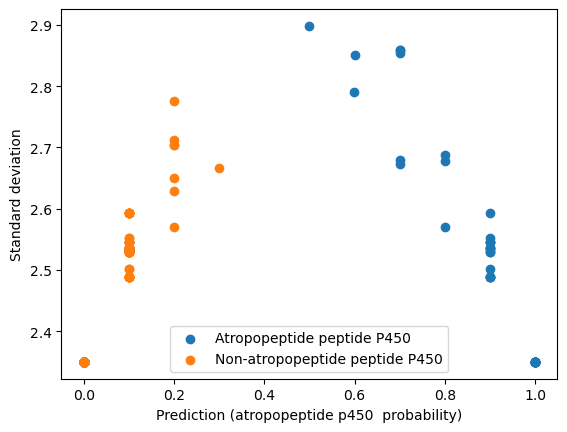

ValueError: Found input variables with inconsistent numbers of samples: [3672, 1]

In [13]:
import sklearn
import pandas as pd
import pickle
import forestci as fci
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, BaggingClassifier,  VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, average_precision_score, confusion_matrix, balanced_accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler


FOLDERNAME_OUTPUT = "Output/Tryptorubinlike_peptides_25_01_2023"
PATH_FEATURE_MATRIX = FOLDERNAME_OUTPUT+"/complete_feature_matrix_bigger_trainingsset.csv"

NAMES_CLASSIFIERS = [
    "ExtraTreesClassifier",
    "RandomForestClassifier",
    "AdaBoostClassifier",
    "BaggingClassifier",
    "DecisionTreeClassifier",
    "MLPClassifier"
]

CLASSIFIERS = [
    ExtraTreesClassifier(max_depth=15, min_samples_leaf=1,
                         class_weight="balanced"),
    RandomForestClassifier(max_depth=10, n_estimators=10),
    AdaBoostClassifier(n_estimators=100),
    BaggingClassifier(KNeighborsClassifier(),
                      max_samples=0.5, max_features=0.5),
    DecisionTreeClassifier(max_depth=5),
    MLPClassifier(solver='lbfgs', alpha=1e-5,
                  hidden_layer_sizes=(5, 2), random_state=1)

]

test_size = 0.4
maximum_depth = 15
RANDOM_OVER_SAMPLER = RandomOverSampler(random_state=0)
feature_matrix = pd.read_csv(PATH_FEATURE_MATRIX)


def create_training_test_set(path_feature_matrix, test_size):
    # create training and test set from feature matrix
    feature_matrix = pd.read_csv(path_feature_matrix)
    feature_matrix = feature_matrix.sample(frac=1)
    # define target and features
    x_data = feature_matrix.loc[:, feature_matrix.columns != 'target']
    y_data = feature_matrix['target']
    # split into training and test set
    x_train, x_test, y_train, y_test = train_test_split(
        x_data, y_data, test_size=test_size, shuffle=True)
    # resample to balance
    x_train, y_train = RANDOM_OVER_SAMPLER.fit_resample(x_train, y_train)
    return x_train, x_test, y_train, y_test, x_data, y_data


def train_classifier_and_get_accuracies(classifier, name_classifier, x_data, y_data, x_train, y_train, x_test, y_test, foldernameoutput):
    classifier = classifier.fit(x_train, y_train)
    # predict for test set
    test_predict_classifier = classifier.predict(x_test)
    # calculate accuracy
    cross_validation_classifier = cross_val_score(
        classifier, x_data, y_data, cv=5, scoring='f1_macro')
    balanced_accuracy_classifier = balanced_accuracy_score(
        y_test, test_predict_classifier)
    # print all the scores
    print(name_classifier, " score:", classifier.score(x_test, y_test))
    print(name_classifier,
          " balanced Accuracy Score:", balanced_accuracy_classifier)
    print(name_classifier,
          " crossvalidation scores:", cross_validation_classifier)
    print(classification_report(y_test, test_predict_classifier))
    # save trained classifier
    filename_classifier = foldernameoutput + "/" + name_classifier+'_classifier.sav'
    pickle.dump(classifier, open(filename_classifier, 'wb'))
    BGC_types = ["ripp", "nrp", "pk"]
    return classifier


def optimize_leaf_number(classifier, name_classifier, foldernameoutput, x_train, y_train, x_test, y_test):

    balanced_accuracy = 0.50
    # determine best mnimum number of leafes
    leafdiagr = pd.DataFrame(
        columns=['Minimum samples per leaf', 'Balanced accuracy'])
    for minleaf in range(1, 5):

        classifier = classifier.fit(x_train, y_train)
        test_predict_classifier = classifier.predict(x_test)
        balanced_accuracy_new = balanced_accuracy_score(
            y_test, test_predict_classifier)
        new_line = {'Minimum samples per leaf': minleaf,
                    'Balanced accuracy': balanced_accuracy_new}
        leafdiagr = leafdiagr.append(new_line, ignore_index=True)
        if balanced_accuracy_new > balanced_accuracy:
            bestminleaf = minleaf
            balanced_accuracy = balanced_accuracy_new
    print("Best minimum samples per leaf:", bestminleaf)

    # plot diagram of best minleaf
    plt.plot('Minimum samples per leaf', 'Balanced accuracy',
             data=leafdiagr, color='black')
    plt.xlabel('Minimum samples per leaf')
    plt.ylabel('Balanced accuracy')
    plt.savefig(foldernameoutput+"_"+"_" +
                name_classifier+"leafdiagr.png", format="png")
    plt.show()
    return bestminleaf


def optimize_depth_classifier(classifier, name_classifier, foldernameoutput, x_train, y_train, x_test, y_test):
    balanced_accuracy = 0.50
    # determine best mnimum number of leafes
    depthdiagr = pd.DataFrame(
        columns=['Maximal depth of random forest', 'Balanced accuracy'])
    for maximum_depth in range(10, 20):

        classifier = classifier.fit(x_train, y_train)
        test_predict_classifier = classifier.predict(x_test)
        balanced_accuracy_new = balanced_accuracy_score(
            y_test, test_predict_classifier)
        new_line = {'Maximal depth': maximum_depth,
                    'Balanced accuracy': balanced_accuracy}
        depthdiagr = depthdiagr.append(new_line, ignore_index=True)
        if balanced_accuracy_new > balanced_accuracy:
            bestmaximum_depth = maximum_depth
            balanced_accuracy = balanced_accuracy_new

    print("Best Max depth:", bestmaximum_depth)

    # plot diagram of best minleaf
    plt.plot('Maximal depth', 'Balanced accuracy',
             data=depthdiagr, color='black')
    plt.xlabel('Maximal depth')
    plt.ylabel('Balanced accuracy')
    plt.savefig(foldernameoutput+"_" +
                name_classifier+"depthdiagr.png", format="png")
    plt.show()
    return bestmaximum_depth

def precision_recall_threshold(precision, recall, thresholds, t=0.5):
    plt.figure(figsize=(14, 14))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(recall, precision, color='black', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='black')
    plt.ylim([0.5, 1.01])
    plt.xlim([0.5, 1.01])
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))


x_train, x_test, y_train, y_test, x_data, y_data = create_training_test_set(
    PATH_FEATURE_MATRIX, test_size)
for classifier, name_classifier in zip(CLASSIFIERS, NAMES_CLASSIFIERS):
    train_classifier_and_get_accuracies(
        classifier, name_classifier, x_data, y_data, x_train, y_train, x_test, y_test, FOLDERNAME_OUTPUT)



# optimize random forest classifier
depth = optimize_depth_classifier(RandomForestClassifier(max_depth=5, n_estimators=10), "RandomForest",
                                  FOLDERNAME_OUTPUT, x_train, y_train, x_test, y_test)
leaf = optimize_leaf_number(RandomForestClassifier(max_depth=5, n_estimators=10), "RandomForest",
                            FOLDERNAME_OUTPUT, x_train, y_train, x_test, y_test)



In [ ]:
# Plot figures

RandomForest_optimized  score: 0.9991760505355671
RandomForest_optimized  balanced Accuracy Score: 0.9373620689655172
RandomForest_optimized  crossvalidation scores: [0.96652881 0.91639103 0.91639103 0.96140061 0.91639103]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3625
           1       0.93      0.88      0.90        16

    accuracy                           1.00      3641
   macro avg       0.97      0.94      0.95      3641
weighted avg       1.00      1.00      1.00      3641



/home/friederike/anaconda3/envs/frida/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


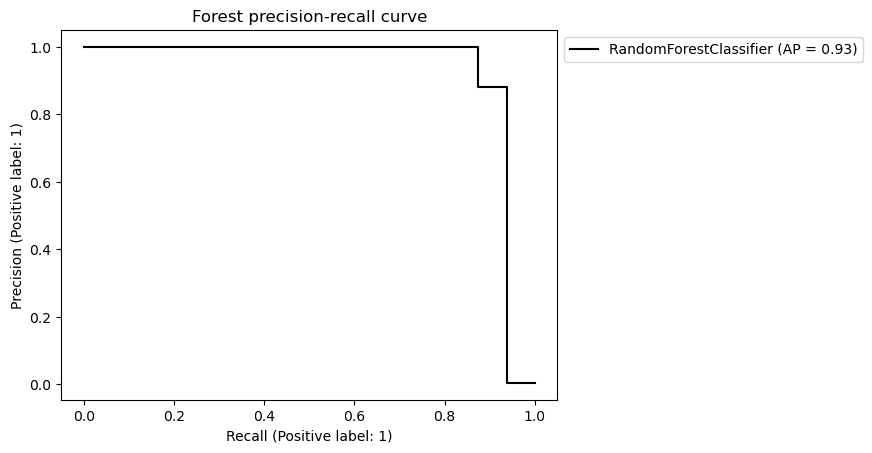

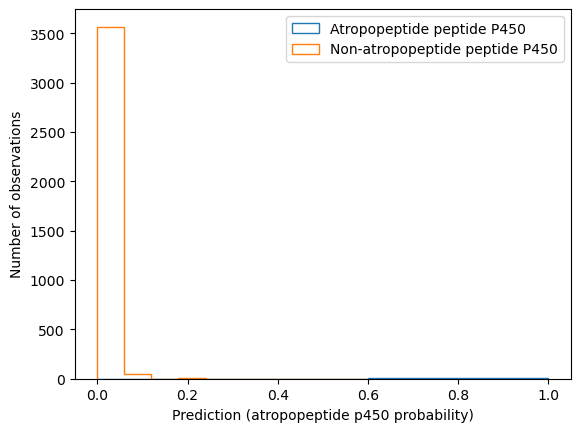

/home/friederike/anaconda3/envs/frida/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/friederike/anaconda3/envs/frida/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/friederike/anaconda3/envs/frida/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/friederike/anaconda3/envs/frida/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/friederike/anaconda3/envs/frida/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/frie

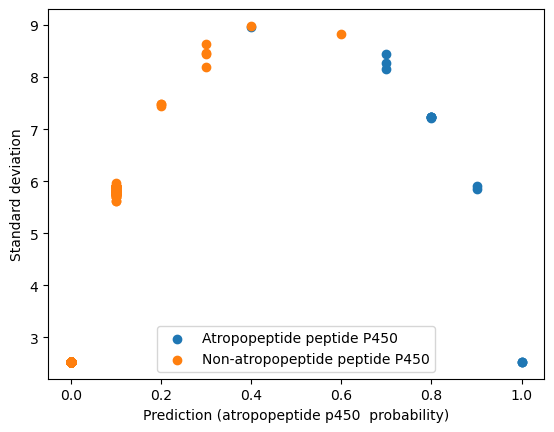

ValueError: Found input variables with inconsistent numbers of samples: [3641, 1]

In [12]:
def precision_recall_threshold(precision, recall, thresholds, t=0.5):
    plt.figure(figsize=(14, 14))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(recall, precision, color='black', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='black')
    plt.ylim([0.5, 1.01])
    plt.xlim([0.5, 1.01])
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))


forest = train_classifier_and_get_accuracies(
    RandomForestClassifier(max_depth=depth, n_estimators=10, min_samples_leaf=leaf), "RandomForest_optimized", x_data, y_data, x_train, y_train, x_test, y_test, FOLDERNAME_OUTPUT)

# plot precision-recall curves
fig, ax = plt.subplots()
disp = plot_precision_recall_curve(
    forest, x_test, y_test, ax=ax, color='black')
disp.ax_.set_title('Forest precision-recall curve')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.savefig((FOLDERNAME_OUTPUT + "/precisionrecalltryptorubin.png"), format="png")


# plot precision-recall curves
predictions_random_forest = forest.predict_proba(x_test)
idx_Tryptorubinlike_peptide = np.where(y_test == 1)[0]
idx_nonTryptorubinlike_peptide = np.where(y_test == 0)[0]

# Histogram predictions without error bars:
fig, ax = plt.subplots(1)
ax.hist(predictions_random_forest[idx_Tryptorubinlike_peptide, 1],
        histtype='step', label='Atropopeptide peptide P450')
ax.hist(predictions_random_forest[idx_nonTryptorubinlike_peptide, 1],
        histtype='step', label='Non-atropopeptide peptide P450')
ax.set_xlabel('Prediction (atropopeptide p450 probability)')
ax.set_ylabel('Number of observations')
plt.legend()
plt.savefig(FOLDERNAME_OUTPUT + "/histtlp.png", format="png", dpi=1000)
plt.show()

# Calculate the variance

variance = fci.random_forest_error(forest, x_train, x_test)
fig, ax = plt.subplots(1)
ax.scatter(predictions_random_forest[idx_Tryptorubinlike_peptide, 1],
           np.sqrt(variance[idx_Tryptorubinlike_peptide]),
           label='Atropopeptide peptide P450')
ax.scatter(predictions_random_forest[idx_nonTryptorubinlike_peptide, 1],
           np.sqrt(variance[idx_nonTryptorubinlike_peptide]),
           label='Non-atropopeptide peptide P450')
ax.set_xlabel('Prediction (atropopeptide p450  probability)')
ax.set_ylabel('Standard deviation')
plt.legend()
plt.savefig(FOLDERNAME_OUTPUT + "/variancetlp.png", format="png", dpi=1000)
plt.show()


# Create a fasta file of all p450, that are false positve

In [6]:
import Bio
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
import pickle

foldernameoutput = "Output/Tryptorubinlike_peptides_20_12_2022"
name_450nonTryptorubinlikes = 'Fasta/all p450.fasta'
pathcompletetable = foldernameoutput+"/completetable.csv"
completetable = pd.read_csv(pathcompletetable)
p450nonTryptorubinlike = completetable.loc[completetable['target'] == 0]
listfalsepositive = []

# predicts all non Tryptorubinlike p450, if algorithm says "Tryptorubinlike"-> writes to fasta
counter = -1
for seq_record in SeqIO.parse(name_450nonTryptorubinlikes, "fasta"):
    counter = counter+1
    prediction = p450nonTryptorubinlike.iloc[counter, -1]
    if prediction == 1:
        listfalsepositive.append(seq_record)
namelistflasepositive = foldernameoutput+"/listfalsepositive.fasta"
SeqIO.write(listfalsepositive, namelistflasepositive, "fasta")


FileNotFoundError: [Errno 2] No such file or directory: 'Fasta/all p450.fasta'

# Print Decision Tree

In [12]:
import sklearn
import pickle
from sklearn.tree import export_graphviz
import pydotplus
import pandas as pd
import graphviz

foldernameoutput = "Output/Tryptorubinlike_peptides_20_12_2022"
filename = foldernameoutput+'/forrestclassifier.sav'
tree = pickle.load(open(filename, 'rb'))
estimator = tree.estimators_[5]
dot_data = export_graphviz(estimator,
                           feature_names=x_data.columns,
                           out_file=None,
                           filled=True,
                           rounded=True)

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
name_pdf = foldernameoutput+'/tree.pdf'
pydot_graph.write_pdf(name_pdf)


ModuleNotFoundError: No module named 'graphviz'

# Analyse sequences with fragment fastas

In [3]:

import sklearn
import pandas as pd
import pickle
import Bio
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

# enter names of your files here
filenamebegin = 'Fasta/alignedncbi/allp450ncbiprot-begint-trimmed.fasta'
filenamesbr1 = 'Fasta/alignedncbi/allp450ncbiprot-sbr1t-trimmed.fasta'
filenamesbr2 = 'Fasta/alignedncbi/allp450ncbiprot-sbr2t-trimmed.fasta'
filenamecore = 'Fasta/alignedncbi/allp450ncbiprot-coret-trimmed.fasta'
filenameend = 'Fasta/alignedncbi/allp450ncbiprot-endt-trimmed.fasta'
foldernameoutput = "Output/Tryptorubinlike_peptides_20_12_2022"
filename_permutations = foldernameoutput+"/permutations.txt"
filename = foldernameoutput+'/randomforestclassifier.sav'
fragments = ("begin", "sbr1", "sbr2", "core", "end")

with open(filename_permutations, 'r') as f:
    permutations = [line.rstrip('\n') for line in f]


def easysequence(sequence):
    # creates a string out of the sequence file, that only states if AA is acidic (a), basic (b), polar (p), neutral/unpolar (n),aromatic (r),Cystein (s) or a Prolin (t)
    seqstr = str(sequence)
    seqlist = list(seqstr)
    a = 0
    easylist = []
    for i in seqlist:
        if i == 'E' or i == 'D':
            easylist = easylist+['a']
        if i == 'K' or i == 'R' or i == 'H':
            easylist = easylist+['b']
        if i == 'S' or i == 'T' or i == 'N' or i == 'Q':
            easylist = easylist+['p']
        if i == 'F' or i == 'Y' or i == 'W':
            easylist = easylist+['r']
        if i == 'C':
            easylist = easylist+['s']
        if i == 'P':
            easylist = easylist+['t']
        if i == 'G' or i == 'A' or i == 'V' or i == 'L' or i == 'I' or i == 'M':
            easylist = easylist+['n']
    seperator = ''
    easysequence = seperator.join(easylist)
    return easysequence


def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z


# reads file and creates table
tablep450 = pd.DataFrame()

# lists for all different files
lbegin = []
lend = []
lsbr1 = []
lsbr2 = []
lcore = []
lname = []
for seq_record in SeqIO.parse(filenamebegin, "fasta"):
    lbegin.append(str(seq_record.seq))
for seq_record in SeqIO.parse(filenamesbr1, "fasta"):
    lsbr1.append(str(seq_record.seq))
for seq_record in SeqIO.parse(filenamesbr2, "fasta"):
    lsbr2.append(str(seq_record.seq))
for seq_record in SeqIO.parse(filenamecore, "fasta"):
    lcore.append(str(seq_record.seq))
for seq_record in SeqIO.parse(filenameend, "fasta"):
    lend.append(str(seq_record.id))

for seq_record in SeqIO.parse(filenameend, "fasta"):
    lname.append(str(seq_record.id))

for s in range(0, len(lbegin)-1):
    listfragment = []
    seqbegin = lbegin[s]
    seqsbr1 = lsbr1[s]
    seqsbr2 = lsbr2[s]
    seqcore = lcore[s]
    seqend = lend[s]
    listfragments = [easysequence(str(seqbegin)), easysequence(str(seqsbr1)), easysequence(
        str(seqsbr2)), easysequence(str(seqcore)), easysequence(str(seqend))]
    new_row = {}
    c = 0
    for frag in listfragments:
        f = fragments[c]
        c = c+1
        for i in permutations:
            n = i+f
            new_row = merge_two_dicts(new_row, {n: frag.count(i)})
    print(lname[s])
    tablep450 = tablep450.append(new_row, ignore_index=True)

# tablep450n=tablep450.reindex(columns=index)
tablep450.to_csv("Output/Biarylitides/tablep450allncbi", index=False)
listpositive = []

#SeqIO.write(p450_sequences, filename_outputp450, "fasta")
forest = pickle.load(open(filename, 'rb'))
predictions = forest.predict_proba(tablep450n)

# predicts all non Tryptorubinlike p450, if algorithm says "Tryptorubinlike"-> writes to fasta
counter = -1
predicitonsfile = pd.DataFrame(columns=['title', 'probability'])
for seq_record in SeqIO.parse(filenamebegin, "fasta"):
    counter = counter+1
    prediction = predictions[counter][1]
    row = {}
    if prediction > 0.5:
        row = {'title': seq_record.id, 'probability': prediction}
        predicitonsfile = predicitonsfile.append(row, ignore_index=True)
        listpositive.append(seq_record)
namelistpositive = foldernameoutput+"/listpositivetest.fasta"
SeqIO.write(listpositive, namelistpositive, "fasta")
pathcompletetable = foldernameoutput+"/predicitiontabletest.csv"
predicitonsfile.to_csv(pathcompletetable, index=False)


Clipboard_Contents_extraction
gi|1604146206|ref|WP_134569146.1|_extraction
gi|1872667334|ref|WP_180223880.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1670821460|gb|TMD25828.1|_extraction
gi|1634474240|ref|WP_137056990.1|_extraction
gi|1633706967|gb|TKI87015.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1595790356|gb|TDM05962.1|_extraction
gi|1889297426|ref|WP_182618165.1|_extraction
gi|1801642569|ref|WP_161235118.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1610685398|gb|TGN62381.1|_extraction
gi|1604242567|ref|WP_134605442.1|_extraction
gi|1801644243|ref|WP_161236635.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706877164|ref|WP_142925392.1|_extraction
gi|1671021498|gb|TME75314.1|_extraction
gi|1670895000|gb|TMD80283.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1942307595|ref|WP_197370490.1|_extraction
gi|1942288432|ref|WP_197361332.1|_extraction
gi|1771772662|ref|WP_152964714.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1928445447|ref|WP_193964685.1|_extraction
gi|1604127236|ref|WP_134557070.1|_extraction
gi|1889352831|ref|WP_182639177.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752424106|ref|WP_150408962.1|_extraction
gi|1928509417|ref|WP_194022326.1|_extraction
gi|1751603660|gb|KAA8921707.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1718140025|ref|WP_144593541.1|_extraction
gi|1711267752|gb|TVT14127.1|_extraction
gi|1671839135|gb|TML06575.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1538741907|ref|WP_125652991.1|_extraction
gi|1592521708|ref|WP_132416197.1|_extraction
gi|1590958247|gb|TDC14247.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1711920798|ref|WP_143651581.1|_extraction
gi|1942313339|ref|WP_197371903.1|_extraction
gi|403650436|gb|EJZ05675.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1328045180|ref|WP_102166265.1|_extraction
gi|1864354954|ref|WP_176742825.1|_extraction
gi|1783540507|ref|WP_156442026.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1930759979|ref|WP_194489590.1|_extraction
gi|1621726273|gb|THF72969.1|_extraction
gi|1590753443|ref|WP_131744810.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1592711076|ref|WP_132585482.1|_extraction
gi|1806950335|ref|WP_162406435.1|_extraction
gi|1692922212|gb|QDF37542.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1480968274|ref|WP_119612427.1|_extraction
gi|1628243650|gb|TIU51975.1|_extraction
gi|1942310582|ref|WP_197371073.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1829343138|ref|WP_167828752.1|_extraction
gi|1632849285|ref|WP_136935773.1|_extraction
gi|1632463870|gb|TKC95229.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1741933564|ref|WP_149789552.1|_extraction
gi|1942288459|ref|WP_197361359.1|_extraction
gi|1736924827|emb|SHK86939.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1736891175|emb|SDO88006.1|_extraction
gi|497922129|ref|WP_010236285.1|_extraction
gi|1068905569|ref|WP_069622199.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1942307598|ref|WP_197370493.1|_extraction
gi|1801590140|ref|WP_161200946.1|_extraction
gi|1729651212|ref|WP_148150553.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1722444671|gb|TXB92415.1|_extraction
gi|1909632239|ref|WP_190517101.1|_extraction
gi|1883549291|ref|WP_181356636.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1590785024|ref|WP_131772529.1|_extraction
gi|1951156084|ref|WP_199097668.1|_extraction
gi|1817634432|ref|WP_164289751.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1805990168|ref|WP_162182549.1|_extraction
gi|1409073973|ref|WP_111731379.1|_extraction
gi|1712677587|gb|QDU99719.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1712638631|gb|QDU65393.1|_extraction
gi|1592024232|ref|WP_131944902.1|_extraction
gi|1590947135|gb|TDC04008.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1722446077|gb|TXB93545.1|_extraction
gi|1779225195|ref|WP_155240960.1|_extraction
gi|1746147728|ref|WP_149890449.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1759895382|gb|KAB2863005.1|_extraction
gi|1742967145|gb|KAA3432974.1|_extraction
gi|1942301160|ref|WP_197367848.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1724569527|ref|WP_147296298.1|_extraction
gi|873281605|ref|WP_048574519.1|_extraction
gi|1154134576|ref|WP_078510133.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1885790659|ref|WP_181790028.1|_extraction
gi|1868896171|ref|WP_179175865.1|_extraction
gi|1931989117|ref|WP_194925672.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1671766431|gb|TMK50923.1|_extraction
gi|1816590570|ref|WP_163568884.1|_extraction
gi|1590832794|ref|WP_131796563.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|518734706|ref|WP_019894448.1|_extraction
gi|1590822822|ref|WP_131792675.1|_extraction
gi|1670823500|gb|TMD27539.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1842098124|ref|WP_171014266.1|_extraction
gi|1671289012|gb|TMG85544.1|_extraction
gi|1942313250|ref|WP_197371814.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1711152310|ref|WP_143548732.1|_extraction
gi|1768122942|gb|KAB7832648.1|_extraction
gi|1771495594|ref|WP_152778350.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1449516462|ref|WP_115859756.1|_extraction
gi|486078885|gb|EOD62543.1|_extraction
gi|1942288878|ref|WP_197361778.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1821386843|ref|WP_165611972.1|_extraction
gi|1383243095|ref|WP_108409513.1|_extraction
gi|1435297145|gb|AXG78918.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1720556052|ref|WP_145989482.1|_extraction
gi|1673458676|gb|TMQ02301.1|_extraction
gi|1670902649|gb|TMD86098.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1670888357|gb|TMD75646.1|_extraction
gi|1670771278|gb|TMC89706.1|_extraction
gi|1670708448|gb|TMC43785.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1670685008|gb|TMC25664.1|_extraction
gi|1621740276|gb|THF86600.1|_extraction
gi|1397613584|ref|WP_110141084.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1006036705|ref|WP_061721199.1|_extraction
gi|1005836007|ref|WP_061710331.1|_extraction
gi|1004016621|ref|WP_061484691.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|966425681|ref|WP_058468219.1|_extraction
gi|966397247|ref|WP_058441681.1|_extraction
gi|1005608400|ref|WP_061691341.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1005402912|ref|WP_061636172.1|_extraction
gi|653016718|ref|WP_027268688.1|_extraction
gi|653015547|ref|WP_027267577.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|653013414|ref|WP_027265508.1|_extraction
gi|652974731|ref|WP_027227442.1|_extraction
gi|652973238|ref|WP_027225966.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|652971726|ref|WP_027224574.1|_extraction
gi|652969617|ref|WP_027222510.1|_extraction
gi|652966407|ref|WP_027219404.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|506459681|ref|WP_015961581.1|_extraction
gi|504655334|ref|WP_014842436.1|_extraction
gi|499535509|ref|WP_011216292.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1590825464|ref|WP_131793924.1|_extraction
gi|1360985522|ref|WP_106195161.1|_extraction
gi|1148638379|ref|WP_077383247.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1006677700|ref|WP_061820959.1|_extraction
gi|1005402459|ref|WP_061635877.1|_extraction
gi|1003773021|ref|WP_061465831.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|757480400|ref|WP_042754538.1|_extraction
gi|754876567|ref|WP_042236787.1|_extraction
gi|737928214|ref|WP_035893245.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1486562945|ref|WP_120077336.1|_extraction
gi|966414588|ref|WP_058457873.1|_extraction
gi|966406573|ref|WP_058449979.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|764926174|ref|WP_044497066.1|_extraction
gi|749505634|ref|WP_040146456.1|_extraction
gi|742356996|ref|WP_038839403.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|502866835|ref|WP_013101811.1|_extraction
gi|500495632|ref|WP_011947320.1|_extraction
gi|1916684237|ref|WP_192877262.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1916682725|ref|WP_192876080.1|_extraction
gi|1888276668|ref|WP_182392544.1|_extraction
gi|1888231397|ref|WP_182351571.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1820395401|ref|WP_165474770.1|_extraction
gi|1802726717|ref|WP_161514831.1|_extraction
gi|1802726050|ref|WP_161514214.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1802713914|ref|WP_161504570.1|_extraction
gi|1011913497|ref|WP_062726711.1|_extraction
gi|1004335025|ref|WP_061513950.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1003951843|ref|WP_061474413.1|_extraction
gi|1003926951|ref|WP_061469798.1|_extraction
gi|1003783313|ref|WP_061467397.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|654928111|ref|WP_028378589.1|_extraction
gi|1003962606|ref|WP_061476325.1|_extraction
gi|756829188|ref|WP_042646287.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1080123673|ref|WP_070322375.1|_extraction
gi|1046229947|ref|WP_065620454.1|_extraction
gi|1671184952|gb|TMG03001.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1594897686|gb|TDJ48513.1|_extraction
gi|1590762694|ref|WP_131753275.1|_extraction
gi|654921541|ref|WP_028372101.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|966428557|ref|WP_058471053.1|_extraction
gi|1914040380|ref|WP_192017781.1|_extraction
gi|917028725|ref|WP_051635437.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1949568369|ref|WP_198576925.1|_extraction
gi|1722037416|ref|WP_146365558.1|_extraction
gi|1892679432|ref|WP_184797182.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1830142974|ref|WP_168033434.1|_extraction
gi|1675132554|ref|WP_138642379.1|_extraction
gi|1717788286|gb|QDY70144.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1604100020|ref|WP_134541877.1|_extraction
gi|505168849|ref|WP_015355951.1|_extraction
gi|1674347868|gb|TMR22028.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|736835943|ref|WP_034837217.1|_extraction
gi|154158429|gb|ABS65645.1|_extraction
gi|736963538|ref|WP_034960021.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1369093431|ref|WP_106513056.1|_extraction
gi|1939155412|ref|WP_196407509.1|_extraction
gi|1741181427|ref|WP_149575310.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1724409236|ref|WP_147156027.1|_extraction
gi|1706492996|ref|WP_142861884.1|_extraction
gi|1692823912|ref|WP_139937831.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905982963|ref|WP_188761864.1|_extraction
gi|1899589884|ref|WP_187729205.1|_extraction
gi|1892086789|ref|WP_184299629.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891954281|ref|WP_184170450.1|_extraction
gi|1891866625|ref|WP_184085252.1|_extraction
gi|1891780662|ref|WP_184000756.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1872224274|ref|WP_180142313.1|_extraction
gi|1867972682|ref|WP_179038912.1|_extraction
gi|1836763903|ref|WP_169124625.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1832722023|ref|WP_168457322.1|_extraction
gi|1828771351|ref|WP_167643772.1|_extraction
gi|1828036831|ref|WP_167451389.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1822969232|ref|WP_166140883.1|_extraction
gi|1817492321|ref|WP_164183207.1|_extraction
gi|1804286707|ref|WP_161911872.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798528177|ref|WP_159726276.1|_extraction
gi|1795975066|ref|WP_158930389.1|_extraction
gi|1786338773|ref|WP_157436923.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1674377419|ref|WP_138400374.1|_extraction
gi|1655751273|ref|WP_137862363.1|_extraction
gi|1616173793|ref|WP_135964556.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1574430425|ref|WP_129790704.1|_extraction
gi|1616196648|ref|WP_135986310.1|_extraction
gi|1704444913|gb|TRL36784.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1691182621|gb|TPD62581.1|_extraction
gi|1671740470|gb|TMK30143.1|_extraction
gi|1671720663|gb|TMK14960.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1671670571|gb|TMJ77900.1|_extraction
gi|1669364980|gb|TLX42235.1|_extraction
gi|1595088117|ref|WP_133222866.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1615346239|gb|TGX52850.1|_extraction
gi|1615333998|gb|TGX40755.1|_extraction
gi|1605152555|gb|QBR70421.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|651605171|ref|WP_026600059.1|_extraction
gi|1597112003|gb|TDX66535.1|_extraction
gi|1596724498|gb|TDT81855.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1593400299|gb|TDG19285.1|_extraction
gi|1868953461|ref|WP_179200678.1|_extraction
gi|1628210836|gb|TIU29173.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|344260637|gb|EGW20909.1|_extraction
gi|385277529|gb|EIF41511.1|_extraction
gi|1806674504|ref|WP_162290962.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1369096776|ref|WP_106515168.1|_extraction
gi|1918449039|ref|WP_193170811.1|_extraction
gi|1915552971|ref|WP_192664777.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1914450651|ref|WP_192355944.1|_extraction
gi|1914430400|ref|WP_192337024.1|_extraction
gi|1778919959|ref|WP_155041019.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1761834331|ref|WP_151518518.1|_extraction
gi|1718760942|ref|WP_145150645.1|_extraction
gi|1711516647|ref|WP_143554508.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1705242048|ref|WP_142598182.1|_extraction
gi|1701435136|ref|WP_141987105.1|_extraction
gi|1698428455|ref|WP_141627068.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1684883113|ref|WP_139234913.1|_extraction
gi|1674454645|ref|WP_138469423.1|_extraction
gi|1906655377|ref|WP_189415959.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1911026435|ref|WP_191197326.1|_extraction
gi|1910084018|ref|WP_190949977.1|_extraction
gi|1906195153|ref|WP_188968312.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1904817257|ref|WP_188151982.1|_extraction
gi|1905299297|ref|WP_188297675.1|_extraction
gi|1878389006|gb|KAF5885162.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1864995471|ref|WP_177158407.1|_extraction
gi|1852687122|ref|WP_174136801.1|_extraction
gi|1847149638|ref|WP_172327682.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1845031374|ref|WP_171721271.1|_extraction
gi|1844923217|ref|WP_171620760.1|_extraction
gi|1842527000|ref|WP_171236304.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1842441995|ref|WP_171176319.1|_extraction
gi|1833090778|ref|WP_168645309.1|_extraction
gi|1833081464|ref|WP_168636249.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1832772543|ref|WP_168506215.1|_extraction
gi|1816922817|ref|WP_163834194.1|_extraction
gi|1097698533|emb|SFK30238.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801144729|ref|WP_160808583.1|_extraction
gi|1799812291|ref|WP_160168985.1|_extraction
gi|1398431026|ref|WP_110340686.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|518199849|ref|WP_019370057.1|_extraction
gi|1719560711|ref|WP_145844810.1|_extraction
gi|1717332693|gb|QDX25059.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1713686777|gb|TVV74516.1|_extraction
gi|1607051959|ref|WP_135085026.1|_extraction
gi|1592338054|ref|WP_132244401.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1583841628|ref|WP_130657506.1|_extraction
gi|1706198852|gb|TRW16964.1|_extraction
gi|1699390881|gb|TQN12394.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1697103848|gb|QDH73749.1|_extraction
gi|1610807419|ref|WP_135413825.1|_extraction
gi|1609359518|gb|TGE01222.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1605173625|gb|TFI58949.1|_extraction
gi|325532843|gb|ADZ27564.1|_extraction
gi|338804265|gb|AEJ00507.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1918416699|ref|WP_193140387.1|_extraction
gi|1915500382|ref|WP_192612548.1|_extraction
gi|1897008859|ref|WP_186942643.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1896982860|ref|WP_186921610.1|_extraction
gi|1861296116|ref|WP_176098792.1|_extraction
gi|1830159948|ref|WP_168050088.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801166332|ref|WP_160829381.1|_extraction
gi|1801155019|ref|WP_160818219.1|_extraction
gi|1795785329|ref|WP_158746355.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1181743385|ref|WP_084828354.1|_extraction
gi|1787530309|ref|WP_157899726.1|_extraction
gi|1635422465|ref|WP_137140071.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1759960582|gb|KAB2919804.1|_extraction
gi|1231428196|ref|WP_094332023.1|_extraction
gi|1725516556|gb|TXI28384.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1725504169|gb|TXI17044.1|_extraction
gi|1710931539|gb|TVQ91141.1|_extraction
gi|1595883577|ref|WP_133341709.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1595083478|ref|WP_133218227.1|_extraction
gi|1593444448|ref|WP_133086575.1|_extraction
gi|1592530984|ref|WP_132424770.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1634052228|gb|QCO15694.1|_extraction
gi|1595550893|gb|TDL90559.1|_extraction
gi|1593415092|gb|TDG33436.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1593331834|gb|QBM23903.1|_extraction
gi|1952626514|ref|WP_199730456.1|_extraction
gi|1423087312|ref|WP_111977132.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1223244202|ref|WP_091283465.1|_extraction
gi|1705088613|ref|WP_142461213.1|_extraction
gi|1678249092|ref|WP_138731867.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906581359|ref|WP_189344975.1|_extraction
gi|1897513874|ref|WP_187237441.1|_extraction
gi|1896946331|ref|WP_186890428.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891836770|ref|WP_184056053.1|_extraction
gi|1891480172|ref|WP_183714682.1|_extraction
gi|1891479515|ref|WP_183714025.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1823162850|gb|QIO95195.1|_extraction
gi|1865483090|gb|QLD40293.1|_extraction
gi|742513146|ref|WP_038968074.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1394508998|gb|AWO87130.1|_extraction
gi|1802074474|gb|QHP66136.1|_extraction
gi|1390679482|gb|AWL93308.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1543646335|ref|WP_126262207.1|_extraction
gi|1716227390|gb|TWI54139.1|_extraction
gi|1716162850|gb|TWH90556.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1699553068|emb|SMO99814.1|_extraction
gi|1628455353|gb|TIW02841.1|_extraction
gi|499395385|ref|WP_011082852.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1606618173|gb|TFV67102.1|_extraction
gi|1606574191|gb|TFV28154.1|_extraction
gi|1341923304|ref|WP_103938556.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1783881441|ref|WP_156691046.1|_extraction
gi|1701969653|ref|WP_142283226.1|_extraction
gi|1909730368|ref|WP_190612044.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892944519|ref|WP_185060984.1|_extraction
gi|1783148499|gb|QGV77225.1|_extraction
gi|1591972578|ref|WP_131896287.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1591136782|gb|TDD82675.1|_extraction
gi|1741138090|ref|WP_149538355.1|_extraction
gi|1906800242|ref|WP_189552186.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1896455815|ref|WP_186769300.1|_extraction
gi|1892794475|ref|WP_184911580.1|_extraction
gi|1100141852|emb|SFD52899.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1675194694|ref|WP_138694602.1|_extraction
gi|1592427777|ref|WP_132329759.1|_extraction
gi|1674354180|gb|TMR27897.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1590954328|gb|TDC10663.1|_extraction
gi|1907062467|ref|WP_189753769.1|_extraction
gi|1907366494|ref|WP_189979106.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1231820679|ref|WP_094372408.1|_extraction
gi|1907376534|ref|WP_189988813.1|_extraction
gi|1892877647|ref|WP_184994360.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1885799777|ref|WP_181797369.1|_extraction
gi|738350087|ref|WP_036302430.1|_extraction
gi|917209307|ref|WP_051816019.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1815641631|ref|WP_163010598.1|_extraction
gi|1814751008|ref|WP_162952375.1|_extraction
gi|1801501573|ref|WP_161133191.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1795879101|ref|WP_158839048.1|_extraction
gi|1608647221|ref|WP_135278303.1|_extraction
gi|1607845803|gb|TFW70848.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1928394690|ref|WP_193919779.1|_extraction
gi|1021772357|ref|WP_063377690.1|_extraction
gi|1028123700|ref|WP_063876506.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1604940350|ref|WP_134724327.1|_extraction
gi|1724323028|ref|WP_147077532.1|_extraction
gi|1906536956|ref|WP_189301552.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|170658844|gb|ACB27898.1|_extraction
gi|1942081446|ref|WP_197251435.1|_extraction
gi|1915595233|ref|WP_192706704.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1713156686|ref|WP_143945553.1|_extraction
gi|1783876949|ref|WP_156686637.1|_extraction
gi|1223646371|ref|WP_091682084.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|518939996|ref|WP_020095871.1|_extraction
gi|1597602823|ref|WP_133424982.1|_extraction
gi|1707732087|gb|TSB19072.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1176689401|ref|WP_082516381.1|_extraction
gi|946908855|ref|WP_055831510.1|_extraction
gi|953557017|ref|WP_058028755.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1783368348|ref|WP_156362329.1|_extraction
gi|1674465814|ref|WP_138479689.1|_extraction
gi|1578884075|ref|WP_130254566.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1176667996|ref|WP_082494976.1|_extraction
gi|1675122414|ref|WP_138633142.1|_extraction
gi|1675043771|ref|WP_138566813.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1675036927|ref|WP_138560738.1|_extraction
gi|1783549249|ref|WP_156450617.1|_extraction
gi|1892856100|ref|WP_184972922.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1806550662|ref|WP_162237005.1|_extraction
gi|1595915809|ref|WP_133372676.1|_extraction
gi|1821702191|ref|WP_165700766.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1590459407|ref|WP_131708818.1|_extraction
gi|966505145|ref|WP_058521804.1|_extraction
gi|493506357|ref|WP_006460780.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1518807780|ref|WP_123648374.1|_extraction
gi|1302470026|ref|WP_100897637.1|_extraction
gi|1572362680|ref|WP_129575727.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1493870514|ref|WP_121539325.1|_extraction
gi|1181448365|ref|WP_084743877.1|_extraction
gi|1707410602|ref|WP_143178958.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1231909816|ref|WP_094457532.1|_extraction
gi|1197791969|ref|WP_086732151.1|_extraction
gi|1942310524|ref|WP_197371017.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1769786220|gb|KAB8315227.1|_extraction
gi|170145037|gb|EDT13198.1|_extraction
gi|1784472790|ref|WP_157059503.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1356010876|ref|WP_105193343.1|_extraction
gi|944469979|ref|WP_055700398.1|_extraction
gi|1680030962|gb|TNE47168.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1779538635|ref|WP_155359013.1|_extraction
gi|1779531157|ref|WP_155351696.1|_extraction
gi|1779514017|ref|WP_155334786.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1741134000|ref|WP_149534472.1|_extraction
gi|1892393642|ref|WP_184514206.1|_extraction
gi|1889517049|ref|WP_182691853.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1838668387|ref|WP_169655851.1|_extraction
gi|1822282786|ref|WP_165826737.1|_extraction
gi|1820403567|ref|WP_165482905.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1791048863|ref|WP_158596764.1|_extraction
gi|1735356356|gb|KAA0069870.1|_extraction
gi|1680065580|gb|TNE79689.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1607007020|ref|WP_135044781.1|_extraction
gi|694058459|ref|WP_032405154.1|_extraction
gi|694033958|ref|WP_032381122.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1234042653|ref|WP_094679689.1|_extraction
gi|739312198|ref|WP_037174696.1|_extraction
gi|1233960815|ref|WP_094609135.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|950621693|ref|WP_057477991.1|_extraction
gi|739290226|ref|WP_037152926.1|_extraction
gi|1234106868|ref|WP_094739391.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1233969091|ref|WP_094616008.1|_extraction
gi|1783409641|ref|WP_156388345.1|_extraction
gi|518029816|ref|WP_019200024.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891864034|ref|WP_184082684.1|_extraction
gi|1796145622|ref|WP_159072418.1|_extraction
gi|1714499331|dbj|GEM30831.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1691159528|gb|QDE27545.1|_extraction
gi|1670547993|gb|TMB22992.1|_extraction
gi|1670497160|gb|TMA83874.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1670448324|gb|TMA48571.1|_extraction
gi|1639941405|gb|TKT70141.1|_extraction
gi|1605090177|gb|TFI43654.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906941359|ref|WP_189642046.1|_extraction
gi|1896200741|ref|WP_186539337.1|_extraction
gi|1801413417|ref|WP_161058507.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1783646652|ref|WP_156517767.1|_extraction
gi|1225207109|ref|WP_093219274.1|_extraction
gi|1578874218|ref|WP_130245467.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|703477401|ref|WP_033430208.1|_extraction
gi|503465280|ref|WP_013699941.1|_extraction
gi|1590813106|ref|WP_131784082.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1443129992|ref|WP_115332630.1|_extraction
gi|1392671090|ref|WP_109790440.1|_extraction
gi|1311557101|ref|WP_101173740.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|926391338|ref|WP_053719730.1|_extraction
gi|1942310476|ref|WP_197370969.1|_extraction
gi|1933308030|ref|WP_195174339.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1176696655|ref|WP_082523634.1|_extraction
gi|1798437894|ref|WP_159650482.1|_extraction
gi|1909050336|emb|CAD5272344.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1909044454|emb|CAD5264573.1|_extraction
gi|1909037899|emb|CAD5266958.1|_extraction
gi|1892602052|ref|WP_184720518.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1890338499|ref|WP_183111062.1|_extraction
gi|1869564778|ref|WP_179450179.1|_extraction
gi|950157625|ref|WP_057208008.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1819687743|ref|WP_165358148.1|_extraction
gi|950165214|ref|WP_057214763.1|_extraction
gi|1801463143|ref|WP_161105158.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1789520191|emb|VXC21751.1|_extraction
gi|1789387019|emb|VXC70216.1|_extraction
gi|1789374191|emb|VXB82922.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1789366960|emb|VXC19923.1|_extraction
gi|1772295951|gb|QFZ21013.1|_extraction
gi|1634072689|ref|WP_136958960.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1607158056|ref|WP_135172958.1|_extraction
gi|1671121100|gb|TMF52677.1|_extraction
gi|1632851052|gb|QCI63502.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1606600851|gb|TFV51216.1|_extraction
gi|1782455494|ref|WP_155908681.1|_extraction
gi|992024725|ref|WP_061003702.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1782446122|ref|WP_155899346.1|_extraction
gi|1597617246|ref|WP_133428053.1|_extraction
gi|1579055706|ref|WP_130397428.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|656090203|ref|WP_029121179.1|_extraction
gi|518943848|ref|WP_020099723.1|_extraction
gi|516159661|ref|WP_017586808.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1782512627|ref|WP_155926798.1|_extraction
gi|1725824548|ref|WP_147381510.1|_extraction
gi|1690998052|ref|WP_139671560.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1174969825|ref|WP_081642970.1|_extraction
gi|1041569458|ref|WP_065209323.1|_extraction
gi|759674407|ref|WP_043391712.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1180403364|ref|WP_083922147.1|_extraction
gi|927903409|ref|WP_053854975.1|_extraction
gi|837755237|ref|WP_047871133.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|763105360|ref|WP_043985528.1|_extraction
gi|1668719260|ref|WP_138251224.1|_extraction
gi|1267735592|ref|WP_098485428.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1235651608|ref|WP_094801990.1|_extraction
gi|1222863333|ref|WP_090907162.1|_extraction
gi|1222318264|ref|WP_090371326.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1124342662|ref|WP_074633815.1|_extraction
gi|1752049909|ref|WP_150253483.1|_extraction
gi|499852650|ref|WP_011533384.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|528324274|gb|AGS33589.1|_extraction
gi|1950976697|ref|WP_198942458.1|_extraction
gi|1932009181|ref|WP_194944218.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1931534102|ref|WP_194839939.1|_extraction
gi|1928477360|ref|WP_193993576.1|_extraction
gi|1783215911|ref|WP_156298534.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1783017653|ref|WP_156217775.1|_extraction
gi|1782987782|ref|WP_156193605.1|_extraction
gi|1777727593|ref|WP_154374154.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1741717960|ref|WP_149728615.1|_extraction
gi|1892933859|ref|WP_185050395.1|_extraction
gi|1892698146|ref|WP_184815739.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891904867|ref|WP_184122350.1|_extraction
gi|1892152081|ref|WP_184362699.1|_extraction
gi|1891373784|ref|WP_183658460.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1890325541|ref|WP_183100747.1|_extraction
gi|1890302011|ref|WP_183096220.1|_extraction
gi|1885146131|ref|WP_181756485.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1840647785|ref|WP_170327489.1|_extraction
gi|1836749778|ref|WP_169110913.1|_extraction
gi|1833202056|ref|WP_168696610.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1610180147|ref|WP_135357410.1|_extraction
gi|1830160472|ref|WP_168050612.1|_extraction
gi|1806467087|dbj|BBZ56783.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801411457|ref|WP_161056652.1|_extraction
gi|1801398175|ref|WP_161043863.1|_extraction
gi|1798770051|ref|WP_159942367.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1039825978|ref|WP_064983947.1|_extraction
gi|1039527485|ref|WP_064858894.1|_extraction
gi|995881634|ref|WP_061079013.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1545530665|ref|WP_126624970.1|_extraction
gi|1121451574|ref|WP_073693789.1|_extraction
gi|1103213689|ref|WP_071621791.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1098709339|ref|WP_071288630.1|_extraction
gi|1774417833|gb|QGG40273.1|_extraction
gi|1668624297|ref|WP_138233222.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1598118135|ref|WP_133759939.1|_extraction
gi|1402999640|ref|WP_110844667.1|_extraction
gi|1383442261|ref|WP_108576743.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1152430681|ref|WP_078291397.1|_extraction
gi|1739218779|gb|KAA1419281.1|_extraction
gi|1725530837|gb|TXI41343.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1725401600|gb|TXH22256.1|_extraction
gi|1590728777|ref|WP_131738472.1|_extraction
gi|1624614463|ref|WP_136452801.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1592750021|ref|WP_132619952.1|_extraction
gi|1591967362|ref|WP_131891835.1|_extraction
gi|1624318913|ref|WP_136382347.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1597680716|ref|WP_133447937.1|_extraction
gi|1597632147|ref|WP_133435552.1|_extraction
gi|1671940571|gb|TML88263.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1670564221|gb|TMB36588.1|_extraction
gi|1660240722|gb|TLH59453.1|_extraction
gi|1660229782|gb|TLH49618.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1628444432|gb|TIV95355.1|_extraction
gi|1622707146|gb|THJ68702.1|_extraction
gi|1621100300|gb|THE14604.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1610653302|gb|TGN32000.1|_extraction
gi|1593343951|ref|WP_133056350.1|_extraction
gi|1596749574|gb|TDU06827.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1596508830|gb|TDR67998.1|_extraction
gi|1595138580|gb|TDL09083.1|_extraction
gi|1595129602|gb|TDL00093.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1595128198|gb|TDK98760.1|_extraction
gi|1595114579|gb|TDK85254.1|_extraction
gi|1594803376|gb|TDI62686.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1591146942|gb|TDD92631.1|_extraction
gi|1591045383|gb|TDC95489.1|_extraction
gi|254946896|gb|ACT91596.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1672724504|ref|WP_138364495.1|_extraction
gi|1724465815|ref|WP_147207307.1|_extraction
gi|663293569|ref|WP_030295834.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|521959754|ref|WP_020471359.1|_extraction
gi|501114491|ref|WP_012163948.1|_extraction
gi|498159443|ref|WP_010473599.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1600501635|ref|WP_133898997.1|_extraction
gi|1575483767|ref|WP_129926755.1|_extraction
gi|1518669821|ref|WP_123516010.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1372316658|ref|WP_107048144.1|_extraction
gi|919151701|ref|WP_052707333.1|_extraction
gi|739836944|ref|WP_037687919.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|504497772|ref|WP_014684874.1|_extraction
gi|1751997998|ref|WP_150206172.1|_extraction
gi|1373431302|ref|WP_107093540.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1222282863|ref|WP_090336559.1|_extraction
gi|1208917886|ref|WP_088182428.1|_extraction
gi|1183758834|ref|WP_084978519.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1167624306|ref|WP_080056169.1|_extraction
gi|947632125|ref|WP_056295097.1|_extraction
gi|943995494|ref|WP_055588794.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|860605112|ref|WP_048479492.1|_extraction
gi|696555192|ref|WP_033087371.1|_extraction
gi|1621674784|ref|WP_136223677.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1275827590|ref|WP_099894396.1|_extraction
gi|496584396|ref|WP_009284235.1|_extraction
gi|1952099695|ref|WP_199434674.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1928637095|ref|WP_194121367.1|_extraction
gi|1928568624|ref|WP_194076485.1|_extraction
gi|1910209053|ref|WP_191039252.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1781377503|ref|WP_155771440.1|_extraction
gi|1781376638|ref|WP_155770576.1|_extraction
gi|1781375218|ref|WP_155769163.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1781373859|ref|WP_155767804.1|_extraction
gi|1774113419|ref|WP_153465698.1|_extraction
gi|1741348758|ref|WP_149642389.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1722027336|ref|WP_146357774.1|_extraction
gi|1705457645|ref|WP_142771507.1|_extraction
gi|1679560865|ref|WP_139012370.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1674489644|ref|WP_138500441.1|_extraction
gi|1674460998|ref|WP_138475294.1|_extraction
gi|1910017407|ref|WP_190885255.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907307106|ref|WP_189921176.1|_extraction
gi|1906153949|ref|WP_188928475.1|_extraction
gi|1907363822|ref|WP_189976434.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905758801|ref|WP_188545243.1|_extraction
gi|1898577232|ref|WP_187467355.1|_extraction
gi|1896423529|ref|WP_186739357.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892824535|ref|WP_184941489.1|_extraction
gi|1891757600|ref|WP_183977993.1|_extraction
gi|1892556843|ref|WP_184675741.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1889842457|ref|WP_182856592.1|_extraction
gi|1889791329|ref|WP_182807833.1|_extraction
gi|1888669142|ref|WP_182457566.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1845051561|ref|WP_171740919.1|_extraction
gi|1841311266|ref|WP_170860422.1|_extraction
gi|1838551351|ref|WP_169573594.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1826515541|ref|WP_167272365.1|_extraction
gi|1826456203|ref|WP_167216375.1|_extraction
gi|1815886592|ref|WP_163062880.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817145464|ref|WP_164035723.1|_extraction
gi|1812235081|ref|WP_162801983.1|_extraction
gi|1100024569|emb|SFD70245.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1806930578|ref|WP_162386809.1|_extraction
gi|1798234374|ref|WP_159467743.1|_extraction
gi|664600717|ref|WP_031110933.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1538741617|ref|WP_125652701.1|_extraction
gi|1055343878|ref|WP_067008482.1|_extraction
gi|1054844350|ref|WP_066606614.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1054656604|ref|WP_066423743.1|_extraction
gi|1054613603|ref|WP_066381486.1|_extraction
gi|1786496171|ref|WP_157586166.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1786360236|ref|WP_157458248.1|_extraction
gi|1407301478|ref|WP_111171490.1|_extraction
gi|1672635969|ref|WP_138280629.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1646504376|ref|WP_137342075.1|_extraction
gi|1748298996|gb|KAA6439114.1|_extraction
gi|1748262554|gb|QES47207.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1736574319|gb|KAA0992944.1|_extraction
gi|1728800486|ref|WP_148086030.1|_extraction
gi|1717571865|gb|TWP47375.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1714489003|dbj|GEM26962.1|_extraction
gi|1574132060|ref|WP_129599849.1|_extraction
gi|1592295741|ref|WP_132203846.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1702115358|gb|QDK78478.1|_extraction
gi|1680065579|gb|TNE79688.1|_extraction
gi|1677550280|gb|TMS50378.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1671823596|gb|TMK94571.1|_extraction
gi|1670567481|gb|TMB38395.1|_extraction
gi|1670552572|gb|TMB26220.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1670507146|gb|TMA92148.1|_extraction
gi|1670484190|gb|TMA73387.1|_extraction
gi|1669059542|gb|TLV03289.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1669053121|gb|TLU96934.1|_extraction
gi|1639963487|gb|TKT90312.1|_extraction
gi|1616017889|gb|THA40739.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1596822977|gb|TDU79967.1|_extraction
gi|1594794228|gb|TDI54347.1|_extraction
gi|1594788746|gb|TDI49298.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1591120052|gb|TDD66645.1|_extraction
gi|1945539338|ref|WP_198047685.1|_extraction
gi|1834888436|ref|WP_168859084.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1592743924|ref|WP_132614407.1|_extraction
gi|1575531247|ref|WP_129964905.1|_extraction
gi|1428201440|ref|WP_113760552.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1698537952|ref|WP_141721858.1|_extraction
gi|1628317490|gb|TIV02213.1|_extraction
gi|1628243692|gb|TIU52004.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1591099347|gb|TDD46978.1|_extraction
gi|1782460479|ref|WP_155911551.1|_extraction
gi|917391207|ref|WP_051997919.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1826356400|ref|WP_167119684.1|_extraction
gi|1824249342|ref|WP_166634603.1|_extraction
gi|428691233|gb|AFZ44527.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|324315968|gb|ADY27083.1|_extraction
gi|110167415|gb|ABG51955.1|_extraction
gi|257479506|gb|ACV59825.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|219864442|gb|ACL44781.1|_extraction
gi|1545231867|ref|WP_126405521.1|_extraction
gi|1445104459|ref|WP_115712055.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1445097591|ref|WP_115705458.1|_extraction
gi|966495872|ref|WP_058512638.1|_extraction
gi|966421774|ref|WP_058464975.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|763473610|ref|WP_044302548.1|_extraction
gi|1789878056|ref|WP_158316191.1|_extraction
gi|1593600842|ref|WP_133137814.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1055955200|ref|WP_067497080.1|_extraction
gi|703057463|ref|WP_033338790.1|_extraction
gi|656055318|ref|WP_029093701.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|654354000|ref|WP_027846744.1|_extraction
gi|653183160|ref|WP_027419639.1|_extraction
gi|653019851|ref|WP_027271795.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|544852219|ref|WP_021266792.1|_extraction
gi|504009528|ref|WP_014243522.1|_extraction
gi|499931582|ref|WP_011612316.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1492862661|ref|WP_121112618.1|_extraction
gi|1174980166|ref|WP_081653311.1|_extraction
gi|752565705|ref|WP_041236934.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|739944758|ref|WP_037795043.1|_extraction
gi|737925755|ref|WP_035890932.1|_extraction
gi|737886481|ref|WP_035852989.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1371814638|ref|WP_106745668.1|_extraction
gi|1337295489|ref|WP_103217245.1|_extraction
gi|1328136422|ref|WP_102244514.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1326063694|ref|WP_101898611.1|_extraction
gi|1271476360|ref|WP_099262134.1|_extraction
gi|1223066089|ref|WP_091107234.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1189754665|ref|WP_085799751.1|_extraction
gi|1181182670|ref|WP_084530179.1|_extraction
gi|1181154436|ref|WP_084501949.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|966499701|ref|WP_058516374.1|_extraction
gi|966466403|ref|WP_058497729.1|_extraction
gi|754062786|ref|WP_041707650.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1694967441|ref|WP_140657009.1|_extraction
gi|1443183348|ref|WP_115362592.1|_extraction
gi|1253018296|ref|WP_096908853.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|493576773|ref|WP_006529898.1|_extraction
gi|589398164|gb|EXG82921.1|_extraction
gi|262077461|gb|ACY13430.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|442787492|gb|ELR97209.1|_extraction
gi|126618067|gb|EAZ88835.1|_extraction
gi|1952271922|ref|WP_199593847.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|502588364|ref|WP_012826053.1|_extraction
gi|1941095991|ref|WP_197012867.1|_extraction
gi|1941069078|ref|WP_196987307.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1939543099|ref|WP_196528407.1|_extraction
gi|1928324574|ref|WP_193854711.1|_extraction
gi|1913247419|ref|WP_191964842.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1779718008|ref|WP_155466799.1|_extraction
gi|1754594184|ref|WP_150669100.1|_extraction
gi|1754546444|ref|WP_150626091.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1754477685|ref|WP_150577648.1|_extraction
gi|1728352991|ref|WP_148033162.1|_extraction
gi|1722281710|ref|WP_146592792.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1722191049|ref|WP_146504500.1|_extraction
gi|1721883056|ref|WP_146296417.1|_extraction
gi|1705305333|ref|WP_142655676.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1705305212|ref|WP_142655555.1|_extraction
gi|1705245902|ref|WP_142601985.1|_extraction
gi|1909514496|ref|WP_190404446.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1909509782|ref|WP_190399797.1|_extraction
gi|1907138053|ref|WP_189791526.1|_extraction
gi|1906952395|ref|WP_189648299.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|740464867|ref|WP_038296258.1|_extraction
gi|1910770209|ref|WP_191131635.1|_extraction
gi|1909694950|ref|WP_190578174.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906371898|ref|WP_189139674.1|_extraction
gi|1906353752|ref|WP_189122001.1|_extraction
gi|1907420268|ref|WP_190031468.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906752296|ref|WP_189510317.1|_extraction
gi|1892969453|ref|WP_185085020.1|_extraction
gi|1892959584|ref|WP_185076041.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892943563|ref|WP_185060028.1|_extraction
gi|1892088597|ref|WP_184301437.1|_extraction
gi|1884773914|ref|WP_181698769.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1860473648|ref|WP_175603373.1|_extraction
gi|1860412416|ref|WP_175589845.1|_extraction
gi|943675332|ref|WP_055501513.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1859859171|ref|WP_175357998.1|_extraction
gi|1847126866|ref|WP_172305925.1|_extraction
gi|1839745668|ref|WP_169812818.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1838257382|ref|WP_169365685.1|_extraction
gi|1833007683|ref|WP_168585416.1|_extraction
gi|1818111462|ref|WP_164496437.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817723112|ref|WP_164360735.1|_extraction
gi|1099765729|emb|SFL72386.1|_extraction
gi|1096050268|emb|SES91897.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1806943310|ref|WP_162399521.1|_extraction
gi|1804314055|ref|WP_161938162.1|_extraction
gi|1668478789|ref|WP_138201670.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1225681322|ref|WP_093683299.1|_extraction
gi|501346140|ref|WP_012377775.1|_extraction
gi|490062031|ref|WP_003964267.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798936290|ref|WP_160101972.1|_extraction
gi|1796104999|ref|WP_159032095.1|_extraction
gi|1793399586|ref|WP_158677365.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1056404460|ref|WP_067846908.1|_extraction
gi|1056127850|ref|WP_067643803.1|_extraction
gi|655030674|ref|WP_028479502.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1558249436|ref|WP_128130244.1|_extraction
gi|1054804191|ref|WP_066567176.1|_extraction
gi|1788703749|ref|WP_158075051.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1788702886|ref|WP_158074260.1|_extraction
gi|1489988430|gb|AYJ48357.1|_extraction
gi|1755659257|gb|QEY31283.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1754741247|ref|WP_150811286.1|_extraction
gi|1754648960|ref|WP_150722597.1|_extraction
gi|1754590243|ref|WP_150665186.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1754585120|ref|WP_150660081.1|_extraction
gi|1467797836|ref|WP_117011561.1|_extraction
gi|739032316|ref|WP_036913435.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1732901975|gb|TYR80848.1|_extraction
gi|1732484692|gb|TYQ29245.1|_extraction
gi|1732481778|gb|TYQ26331.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1732481610|gb|TYQ26163.1|_extraction
gi|1725741289|gb|TXK42362.1|_extraction
gi|1574039100|gb|RZF20609.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1720262510|gb|QDZ40568.1|_extraction
gi|1595923189|ref|WP_133379207.1|_extraction
gi|1592764286|ref|WP_132632051.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1591466315|ref|WP_131801751.1|_extraction
gi|497312180|ref|WP_009626397.1|_extraction
gi|1592734492|ref|WP_132606820.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1707113523|ref|WP_143034794.1|_extraction
gi|1700690923|gb|QDK40795.1|_extraction
gi|497229269|ref|WP_009543531.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|495553516|ref|WP_008278095.1|_extraction
gi|1692012657|gb|TPI69262.1|_extraction
gi|1692011941|gb|TPI68478.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1671803496|gb|TMK79006.1|_extraction
gi|1659816063|gb|TLF71556.1|_extraction
gi|1659813464|gb|TLF69345.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1628125447|gb|TIT75280.1|_extraction
gi|1609302097|gb|TGD47523.1|_extraction
gi|1596294261|gb|TDP55238.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1596281963|gb|TDP43073.1|_extraction
gi|1591204234|gb|TDE48495.1|_extraction
gi|1591032565|gb|TDC83119.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|344038083|gb|AEM83808.1|_extraction
gi|186468799|gb|ACC84600.1|_extraction
gi|1728018075|ref|WP_147766044.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|557381065|ref|WP_023401496.1|_extraction
gi|522086786|ref|WP_020597995.1|_extraction
gi|1575509307|ref|WP_129947572.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1493269001|ref|WP_121333925.1|_extraction
gi|746580962|ref|WP_039609128.1|_extraction
gi|1728017959|ref|WP_147765971.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1268860089|ref|WP_099071726.1|_extraction
gi|1248231853|ref|WP_096729686.1|_extraction
gi|1225665698|ref|WP_093668208.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|889980557|ref|WP_048870400.1|_extraction
gi|797210669|ref|WP_045871615.1|_extraction
gi|1701499453|ref|WP_142047856.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1197740005|ref|WP_086689774.1|_extraction
gi|1615540977|ref|WP_135876775.1|_extraction
gi|1248084756|ref|WP_096588207.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|497315909|ref|WP_009630122.1|_extraction
gi|407269085|gb|EKF00568.1|_extraction
gi|1946172700|ref|WP_198125424.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1928394692|ref|WP_193919781.1|_extraction
gi|1918478473|ref|WP_193199493.1|_extraction
gi|1911454983|ref|WP_191331857.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1757266771|ref|WP_151008189.1|_extraction
gi|1718581909|ref|WP_144979475.1|_extraction
gi|1912865263|ref|WP_191761023.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1910080405|ref|WP_190947091.1|_extraction
gi|1909684768|ref|WP_190568217.1|_extraction
gi|1909679062|ref|WP_190562779.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1909604810|ref|WP_190490641.1|_extraction
gi|657929260|ref|WP_029630477.1|_extraction
gi|1909857283|ref|WP_190734916.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1909775379|ref|WP_190655651.1|_extraction
gi|1910084040|ref|WP_190949999.1|_extraction
gi|1910051082|ref|WP_190918300.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1909873492|ref|WP_190750166.1|_extraction
gi|1909776686|ref|WP_190656957.1|_extraction
gi|1893659215|ref|WP_185586224.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891004041|ref|WP_183457532.1|_extraction
gi|1893635272|ref|WP_185563581.1|_extraction
gi|1887568292|ref|WP_182123630.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1861591427|ref|WP_176194335.1|_extraction
gi|1850429776|ref|WP_173094236.1|_extraction
gi|1847757151|gb|QKG19878.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1846586668|ref|WP_171977027.1|_extraction
gi|1836909519|ref|WP_169265900.1|_extraction
gi|1725265862|gb|TXG38668.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1725265826|gb|TXG38632.1|_extraction
gi|1833091481|ref|WP_168646012.1|_extraction
gi|1832806513|ref|WP_168539472.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1197738698|ref|WP_086688467.1|_extraction
gi|1815884974|ref|WP_163061292.1|_extraction
gi|1806943497|ref|WP_162399708.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1806611434|ref|WP_162254174.1|_extraction
gi|1621417331|dbj|BBJ38467.1|_extraction
gi|1795655119|gb|QHD83044.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1021779722|ref|WP_063382557.1|_extraction
gi|1021767044|ref|WP_063374016.1|_extraction
gi|1021752581|ref|WP_063365909.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1021709803|ref|WP_063357861.1|_extraction
gi|1096252340|ref|WP_071190336.1|_extraction
gi|1048199557|ref|WP_065789510.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1021754910|ref|WP_063367342.1|_extraction
gi|763350114|ref|WP_044208351.1|_extraction
gi|1071405802|ref|WP_069831572.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1054657600|ref|WP_066424739.1|_extraction
gi|1054608898|ref|WP_066376849.1|_extraction
gi|1786333328|ref|WP_157431518.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1783857591|ref|WP_156673926.1|_extraction
gi|499640017|ref|WP_011320751.1|_extraction
gi|1772288726|gb|QFZ13790.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1769807492|gb|KAB8331508.1|_extraction
gi|1769807489|gb|KAB8331505.1|_extraction
gi|1675128892|ref|WP_138638772.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1756721763|gb|QFG20510.1|_extraction
gi|1713966060|gb|TVY00845.1|_extraction
gi|1592035768|ref|WP_131954736.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1625929335|ref|WP_136573257.1|_extraction
gi|1592023670|ref|WP_131944340.1|_extraction
gi|748629498|ref|WP_039887675.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|501380973|ref|WP_012412539.1|_extraction
gi|494599536|ref|WP_007357789.1|_extraction
gi|1698490621|gb|TQF70372.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1674361621|gb|TMR34947.1|_extraction
gi|499304758|ref|WP_010995533.1|_extraction
gi|1623975374|gb|THU01949.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1614932306|gb|TGV03034.1|_extraction
gi|1591009882|gb|TDC62309.1|_extraction
gi|1590949436|gb|TDC06078.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|517406052|ref|WP_018578697.1|_extraction
gi|647636459|ref|WP_025909156.1|_extraction
gi|1771305501|ref|WP_152672488.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1722228383|ref|WP_146540606.1|_extraction
gi|1889826595|ref|WP_182840852.1|_extraction
gi|1049610718|emb|SCC47994.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1131851134|emb|SIR40842.1|_extraction
gi|1822729589|ref|WP_165932493.1|_extraction
gi|1859913914|ref|WP_175406252.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1858954479|ref|WP_174836278.1|_extraction
gi|1812671143|ref|WP_162868066.1|_extraction
gi|1798691799|ref|WP_159865950.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1197764304|ref|WP_086709953.1|_extraction
gi|1675194360|ref|WP_138694268.1|_extraction
gi|1719677079|gb|TWT14110.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1591951447|ref|WP_131877249.1|_extraction
gi|1674354780|gb|TMR28449.1|_extraction
gi|1670779063|gb|TMC94554.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1670626810|gb|TMB82265.1|_extraction
gi|1657688222|gb|QCS53443.1|_extraction
gi|1620921226|gb|THD81936.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1591002401|gb|TDC55636.1|_extraction
gi|1590894112|gb|TDB54959.1|_extraction
gi|336030968|gb|AEH90619.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|499435696|ref|WP_011123160.1|_extraction
gi|317171194|gb|ADV14732.1|_extraction
gi|304346026|gb|EFM11860.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1361087128|ref|WP_106287043.1|_extraction
gi|656057803|ref|WP_029096118.1|_extraction
gi|655508046|ref|WP_028889127.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|559197301|ref|WP_023573876.1|_extraction
gi|553736281|ref|WP_023070525.1|_extraction
gi|506264695|ref|WP_015784470.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|504932679|ref|WP_015119781.1|_extraction
gi|1332772995|ref|WP_102757650.1|_extraction
gi|1388012973|ref|WP_108900330.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1361100639|ref|WP_106300059.1|_extraction
gi|1311652802|ref|WP_101197223.1|_extraction
gi|1310910040|ref|WP_101045621.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1225665534|ref|WP_093668044.1|_extraction
gi|1361090088|ref|WP_106290003.1|_extraction
gi|1268854159|ref|WP_099065796.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|495944088|ref|WP_008668667.1|_extraction
gi|495932865|ref|WP_008657444.1|_extraction
gi|494571492|ref|WP_007339669.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|494548399|ref|WP_007330285.1|_extraction
gi|494543930|ref|WP_007328482.1|_extraction
gi|1025635021|gb|OAA22932.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|374421396|gb|EHR00929.1|_extraction
gi|667816112|gb|KFB04593.1|_extraction
gi|666856509|gb|KEZ34631.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|631847422|gb|KDA42627.1|_extraction
gi|602260269|gb|EYT89633.1|_extraction
gi|256590972|gb|ACV01859.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|563313267|gb|ETA01576.1|_extraction
gi|385741037|gb|EIG61233.1|_extraction
gi|428255017|gb|AFZ20976.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|433668915|gb|AGB47991.1|_extraction
gi|427372259|gb|AFY56215.1|_extraction
gi|512772887|gb|EPE93704.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|440378244|gb|ELQ14870.1|_extraction
gi|401808901|gb|EJT01283.1|_extraction
gi|359251349|gb|EHK54730.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|355540014|gb|EHH09244.1|_extraction
gi|1951311516|ref|WP_199201294.1|_extraction
gi|1949535982|ref|WP_198551438.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1945051440|ref|WP_197960274.1|_extraction
gi|1945042332|ref|WP_197951274.1|_extraction
gi|1941709840|ref|WP_197064794.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1933303011|ref|WP_195170885.1|_extraction
gi|1931766408|ref|WP_194866920.1|_extraction
gi|1931112980|ref|WP_194732380.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1930713670|ref|WP_194473211.1|_extraction
gi|1930535858|ref|WP_194392100.1|_extraction
gi|1928541401|ref|WP_194052110.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1928394691|ref|WP_193919780.1|_extraction
gi|517248275|ref|WP_018437093.1|_extraction
gi|1775778083|ref|WP_153878608.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774156116|ref|WP_153503709.1|_extraction
gi|1771596987|ref|WP_152871529.1|_extraction
gi|1746488456|ref|WP_149903414.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1740945000|ref|WP_149402492.1|_extraction
gi|1733111766|ref|WP_148755185.1|_extraction
gi|1733098434|ref|WP_148744161.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1731183235|ref|WP_148438872.1|_extraction
gi|1719415964|ref|WP_145715548.1|_extraction
gi|1718768838|ref|WP_145158156.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1705419843|ref|WP_142741876.1|_extraction
gi|1697871469|ref|WP_141342169.1|_extraction
gi|1692722332|ref|WP_139859449.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1690692386|ref|WP_139481111.1|_extraction
gi|1909901945|ref|WP_190777626.1|_extraction
gi|1910089578|ref|WP_190955459.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1909750320|ref|WP_190631749.1|_extraction
gi|1910083073|ref|WP_190949032.1|_extraction
gi|1909614328|ref|WP_190499699.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906324472|ref|WP_189093851.1|_extraction
gi|1906320434|ref|WP_189089964.1|_extraction
gi|1893741978|ref|WP_185661778.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891895259|ref|WP_184113185.1|_extraction
gi|1891698927|ref|WP_183928491.1|_extraction
gi|1891690388|ref|WP_183920112.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891514120|ref|WP_183747859.1|_extraction
gi|1891475371|ref|WP_183709922.1|_extraction
gi|1890735228|ref|WP_183260376.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1890719124|ref|WP_183244493.1|_extraction
gi|1890711467|ref|WP_183237005.1|_extraction
gi|1890708070|ref|WP_183233736.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1890704951|ref|WP_183230732.1|_extraction
gi|1892013504|ref|WP_184229043.1|_extraction
gi|1823164716|gb|QIO97061.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1893635296|ref|WP_185563605.1|_extraction
gi|1214936752|ref|WP_088939889.1|_extraction
gi|1503428176|ref|WP_122401284.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1628755356|ref|WP_136621961.1|_extraction
gi|1867972198|ref|WP_179038432.1|_extraction
gi|1878263210|ref|WP_180692591.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869868016|ref|WP_179734503.1|_extraction
gi|1868013495|ref|WP_179077697.1|_extraction
gi|1865488860|gb|QLD46063.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1862795500|ref|WP_176533541.1|_extraction
gi|1860301379|ref|WP_175578628.1|_extraction
gi|1822931792|ref|WP_166104107.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|499755664|ref|WP_011436398.1|_extraction
gi|1851031985|ref|WP_173520760.1|_extraction
gi|1847929096|ref|WP_172649341.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1834888238|ref|WP_168858886.1|_extraction
gi|1847174971|ref|WP_172352311.1|_extraction
gi|1844879099|ref|WP_171583073.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1258250202|ref|WP_097572434.1|_extraction
gi|1039839675|ref|WP_064987351.1|_extraction
gi|518694808|ref|WP_019856501.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1845022425|ref|WP_171713224.1|_extraction
gi|1845817809|gb|QKD12201.1|_extraction
gi|1845811235|gb|QKD05628.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1845784486|gb|QKC79107.1|_extraction
gi|1845778486|gb|QKC73108.1|_extraction
gi|1845771663|gb|QKC66288.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|654534471|ref|WP_028002559.1|_extraction
gi|1840451256|ref|WP_170261803.1|_extraction
gi|1394511072|gb|AWO89204.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1836885420|ref|WP_169242242.1|_extraction
gi|1836993405|gb|QJI86604.1|_extraction
gi|1835333875|gb|QJF10731.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1835327790|gb|QJF04662.1|_extraction
gi|1248155856|ref|WP_096656270.1|_extraction
gi|1823321525|ref|WP_166397352.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817022846|ref|WP_163926374.1|_extraction
gi|1816009073|ref|WP_163154075.1|_extraction
gi|1823215210|ref|WP_166298340.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|656045982|ref|WP_029084611.1|_extraction
gi|1100077992|emb|SFV19584.1|_extraction
gi|1804222469|ref|WP_161855459.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1802748889|ref|WP_161533314.1|_extraction
gi|1795847079|ref|WP_158807602.1|_extraction
gi|1121298828|ref|WP_073610652.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|493372776|ref|WP_006329090.1|_extraction
gi|1786192851|ref|WP_157327930.1|_extraction
gi|1785953888|ref|WP_157218889.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1784308847|ref|WP_157038646.1|_extraction
gi|1784976139|gb|QGX80510.1|_extraction
gi|652910092|ref|WP_027164047.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|563520780|ref|WP_023727162.1|_extraction
gi|563487877|ref|WP_023708845.1|_extraction
gi|563478924|ref|WP_023702815.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1055706685|ref|WP_067325629.1|_extraction
gi|1055332243|ref|WP_066997204.1|_extraction
gi|1039940389|ref|WP_065010992.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1387104974|gb|AWH88255.1|_extraction
gi|1654883797|ref|WP_137482325.1|_extraction
gi|1390677428|gb|AWL91254.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774759840|gb|QGH67769.1|_extraction
gi|1774755553|gb|QGH70202.1|_extraction
gi|652686023|ref|WP_027033418.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1676989060|ref|WP_138711881.1|_extraction
gi|1675006915|ref|WP_138537678.1|_extraction
gi|1755564794|gb|KAB1159371.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1585990157|ref|WP_131103191.1|_extraction
gi|1543646297|ref|WP_126262169.1|_extraction
gi|1122632039|ref|WP_074117072.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1551085417|ref|WP_127212038.1|_extraction
gi|1543181139|ref|WP_126078938.1|_extraction
gi|1189850930|ref|WP_085861404.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|563549974|ref|WP_023755842.1|_extraction
gi|1743061969|gb|KAA3451651.1|_extraction
gi|1737749889|gb|QEO99898.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1736240088|gb|QEO27146.1|_extraction
gi|1735627593|gb|QEN94341.1|_extraction
gi|1732106083|gb|TYO61987.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1731800371|gb|TYL75318.1|_extraction
gi|1729753476|gb|TYB59565.1|_extraction
gi|1239307050|ref|WP_095425215.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1716228651|gb|TWI56047.1|_extraction
gi|1716213415|gb|TWI40346.1|_extraction
gi|1716164628|gb|TWH92291.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1715535350|gb|TWB67886.1|_extraction
gi|1715516018|gb|TWB48725.1|_extraction
gi|1715400839|gb|TWA34681.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1715379272|gb|TWA13396.1|_extraction
gi|1715340709|gb|TVZ75305.1|_extraction
gi|1713197445|ref|WP_143976589.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1711043602|gb|TVR95128.1|_extraction
gi|1606989130|ref|WP_135029393.1|_extraction
gi|1603944804|ref|WP_134428280.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1578833628|ref|WP_130212394.1|_extraction
gi|1565026152|ref|WP_128945128.1|_extraction
gi|1565020416|ref|WP_128939488.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|497286181|ref|WP_009600398.1|_extraction
gi|489576981|ref|WP_003481427.1|_extraction
gi|1624326194|ref|WP_136389206.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1607163982|ref|WP_135178884.1|_extraction
gi|1592165851|ref|WP_132078306.1|_extraction
gi|1575439910|ref|WP_129887795.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1565013171|ref|WP_128932244.1|_extraction
gi|1565002121|ref|WP_128921293.1|_extraction
gi|1708553474|gb|TSE04553.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1699349256|gb|TQM85265.1|_extraction
gi|1699036099|gb|QDI02799.1|_extraction
gi|1692173437|gb|TPK27611.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1692168209|gb|TPK22425.1|_extraction
gi|1692167449|gb|TPK21671.1|_extraction
gi|1692152448|gb|TPK06779.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1692151419|gb|TPK05762.1|_extraction
gi|1692140303|gb|TPJ94785.1|_extraction
gi|1692138476|gb|TPJ92978.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1692120540|gb|TPJ75208.1|_extraction
gi|1692108999|gb|TPJ63912.1|_extraction
gi|1692084759|gb|TPJ40397.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1692084138|gb|TPJ39791.1|_extraction
gi|1692070650|gb|TPJ26817.1|_extraction
gi|1692022387|gb|TPI78884.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1674963839|gb|TMR97197.1|_extraction
gi|1670776802|gb|TMC93806.1|_extraction
gi|1644943472|gb|TKV77792.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1631343398|gb|TJW49584.1|_extraction
gi|1631272307|gb|TJV86309.1|_extraction
gi|1631154790|gb|TJU83480.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1631142922|gb|TJU72040.1|_extraction
gi|1627801451|gb|TIR27028.1|_extraction
gi|1627647369|gb|TIP92175.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1627485697|gb|TIO63602.1|_extraction
gi|1627424284|gb|TIO11847.1|_extraction
gi|1627401800|gb|TIN91733.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1627381757|gb|TIN74051.1|_extraction
gi|1627339399|gb|TIN39871.1|_extraction
gi|1627330816|gb|TIN32276.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1627271795|gb|TIM81685.1|_extraction
gi|1627159164|gb|TIL86044.1|_extraction
gi|1627110032|gb|TIL46841.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1621740274|gb|THF86598.1|_extraction
gi|1614813396|gb|TGT92544.1|_extraction
gi|1609608997|gb|TGE88808.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1606619114|gb|TFV67976.1|_extraction
gi|1606588116|gb|TFV39101.1|_extraction
gi|1606574731|gb|TFV28652.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1605047681|gb|TFI03610.1|_extraction
gi|1596960490|gb|TDW16210.1|_extraction
gi|749201752|ref|WP_040114379.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1589170147|gb|TCU33529.1|_extraction
gi|306981119|gb|ADN13000.1|_extraction
gi|505012426|ref|WP_015199528.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1430554257|ref|WP_113787170.1|_extraction
gi|1225876625|ref|WP_093871219.1|_extraction
gi|764508764|ref|WP_044399209.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1268854158|ref|WP_099065795.1|_extraction
gi|501236740|ref|WP_012279758.1|_extraction
gi|1931938547|ref|WP_194898907.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1771593572|ref|WP_152868225.1|_extraction
gi|1764249718|ref|WP_151774015.1|_extraction
gi|1674486836|ref|WP_138497633.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1910007151|ref|WP_190875447.1|_extraction
gi|1910083072|ref|WP_190949031.1|_extraction
gi|1910085848|ref|WP_190951807.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1909824139|ref|WP_190703027.1|_extraction
gi|1905749127|ref|WP_188535691.1|_extraction
gi|1893640941|ref|WP_185569211.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891767730|ref|WP_183987981.1|_extraction
gi|1869893185|ref|WP_179759085.1|_extraction
gi|1861186285|ref|WP_176028727.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1838686192|ref|WP_169670115.1|_extraction
gi|1268877815|ref|WP_099084602.1|_extraction
gi|505014096|ref|WP_015201198.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1822853121|ref|WP_166026057.1|_extraction
gi|1802468518|ref|WP_161490898.1|_extraction
gi|1787632283|ref|WP_157951175.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1624298481|ref|WP_136364306.1|_extraction
gi|1268856496|ref|WP_099068133.1|_extraction
gi|1699198875|gb|TQL74419.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|503086248|ref|WP_013321108.1|_extraction
gi|1621724494|gb|THF71534.1|_extraction
gi|1783005020|ref|WP_156206842.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1020291930|ref|WP_063272075.1|_extraction
gi|980963393|ref|WP_059384074.1|_extraction
gi|736230104|ref|WP_034319646.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1724354877|ref|WP_147104207.1|_extraction
gi|1724004601|ref|WP_146838133.1|_extraction
gi|1719407718|ref|WP_145707420.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719390622|ref|WP_145690871.1|_extraction
gi|1712643426|ref|WP_143772792.1|_extraction
gi|983497135|ref|WP_060650267.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|663982916|ref|WP_030547047.1|_extraction
gi|655467669|ref|WP_028850608.1|_extraction
gi|522161627|ref|WP_020672835.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|522148376|ref|WP_020659584.1|_extraction
gi|516613171|ref|WP_017988014.1|_extraction
gi|515498420|ref|WP_016931674.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|515035213|ref|WP_016692339.1|_extraction
gi|1691045479|ref|WP_139712401.1|_extraction
gi|1598083887|ref|WP_133726396.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1575543703|ref|WP_129975620.1|_extraction
gi|1486797462|ref|WP_120280464.1|_extraction
gi|1407444848|ref|WP_111250520.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1200124244|ref|WP_087560628.1|_extraction
gi|1181003321|ref|WP_084416453.1|_extraction
gi|1180447363|ref|WP_083962438.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1175378345|ref|WP_081926137.1|_extraction
gi|1154965158|ref|WP_078870479.1|_extraction
gi|1114001350|ref|WP_072027703.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1029992774|ref|WP_064063902.1|_extraction
gi|760167229|ref|WP_043848055.1|_extraction
gi|739484535|ref|WP_037344289.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|696564511|ref|WP_033096344.1|_extraction
gi|1434587152|ref|WP_114329827.1|_extraction
gi|1365407612|ref|WP_106399023.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1268215646|ref|WP_098755286.1|_extraction
gi|1224783197|ref|WP_092800686.1|_extraction
gi|1224395806|ref|WP_092419499.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1223520250|ref|WP_091556976.1|_extraction
gi|1219233616|ref|WP_089251123.1|_extraction
gi|1214887272|ref|WP_088898311.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1197922043|ref|WP_086839350.1|_extraction
gi|1188348247|ref|WP_085470181.1|_extraction
gi|1179676666|ref|WP_083415137.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|916559517|ref|WP_051166608.1|_extraction
gi|746553810|ref|WP_039585047.1|_extraction
gi|740729962|ref|WP_038515248.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774028750|ref|WP_153393982.1|_extraction
gi|1655510519|ref|WP_137798651.1|_extraction
gi|1360908824|ref|WP_106122224.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1242614107|ref|WP_095758234.1|_extraction
gi|1223015979|ref|WP_091057438.1|_extraction
gi|1701510345|ref|WP_142058737.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1697231818|ref|WP_141243899.1|_extraction
gi|496368600|ref|WP_009077590.1|_extraction
gi|493601083|ref|WP_006553746.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1952568873|ref|WP_199693739.1|_extraction
gi|1952530717|ref|WP_199686333.1|_extraction
gi|1952615462|ref|WP_199719852.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1838572700|ref|WP_169588416.1|_extraction
gi|1689836392|ref|WP_139315463.1|_extraction
gi|1621696396|ref|WP_136244138.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1227525417|ref|WP_094080938.1|_extraction
gi|1122335246|ref|WP_074021273.1|_extraction
gi|1940139462|ref|WP_196808985.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1931968436|ref|WP_194905926.1|_extraction
gi|1931383874|ref|WP_194829888.1|_extraction
gi|1931085811|ref|WP_194705676.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1928377200|ref|WP_193902673.1|_extraction
gi|1915482229|ref|WP_192594516.1|_extraction
gi|1915479738|ref|WP_192592044.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1782583167|ref|WP_155992134.1|_extraction
gi|1778524649|ref|WP_154734897.1|_extraction
gi|1913116486|ref|WP_191908069.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905900737|ref|WP_188682139.1|_extraction
gi|1905764101|ref|WP_188550515.1|_extraction
gi|1897765741|ref|WP_187368722.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1896401561|ref|WP_186718683.1|_extraction
gi|1892400287|ref|WP_184520837.1|_extraction
gi|1890352527|ref|WP_183123148.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1889890670|ref|WP_182895036.1|_extraction
gi|1869555108|ref|WP_179440567.1|_extraction
gi|1850362583|ref|WP_173027432.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1840583839|ref|WP_170319231.1|_extraction
gi|1838619987|ref|WP_169619704.1|_extraction
gi|1836931472|ref|WP_169287204.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1835714733|gb|KAF4407205.1|_extraction
gi|1832776522|ref|WP_168510096.1|_extraction
gi|1832539301|ref|WP_168431988.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1828910533|ref|WP_167756400.1|_extraction
gi|1828205176|ref|WP_167493580.1|_extraction
gi|1828908334|ref|WP_167754203.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1828822558|ref|WP_167674690.1|_extraction
gi|1828026703|ref|WP_167442275.1|_extraction
gi|1819340609|ref|WP_165040135.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816826532|ref|WP_163750776.1|_extraction
gi|1816821236|ref|WP_163745999.1|_extraction
gi|1816781181|ref|WP_163706135.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1097434578|emb|SFV26824.1|_extraction
gi|1801217597|ref|WP_160877369.1|_extraction
gi|1798931167|ref|WP_160096849.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798118069|ref|WP_159417454.1|_extraction
gi|1798052183|ref|WP_159397872.1|_extraction
gi|1039520581|ref|WP_064852270.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1121627472|ref|WP_073847119.1|_extraction
gi|517158806|ref|WP_018347624.1|_extraction
gi|1546698323|ref|WP_126730783.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1538891267|ref|WP_125794742.1|_extraction
gi|1538831200|ref|WP_125737737.1|_extraction
gi|1538778907|ref|WP_125687322.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1538765970|ref|WP_125674586.1|_extraction
gi|1538713616|ref|WP_125625827.1|_extraction
gi|1056694203|ref|WP_068120339.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1032634946|ref|WP_064257485.1|_extraction
gi|760159193|ref|WP_043840145.1|_extraction
gi|1110709922|ref|WP_071935806.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1785960676|ref|WP_157225626.1|_extraction
gi|1784616184|ref|WP_157105433.1|_extraction
gi|1391684761|ref|WP_109506630.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1776270825|gb|QGK47635.1|_extraction
gi|1635428855|ref|WP_137146330.1|_extraction
gi|1632849977|ref|WP_136936465.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1632838096|ref|WP_136924639.1|_extraction
gi|1751652682|gb|KAA8965436.1|_extraction
gi|1721648734|gb|QEC48318.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1716135022|gb|TWH62972.1|_extraction
gi|1716095795|gb|TWH24114.1|_extraction
gi|1714424844|dbj|GEL47182.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1592255979|ref|WP_132165656.1|_extraction
gi|505169126|ref|WP_015356228.1|_extraction
gi|1598052806|ref|WP_133696965.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|935245781|ref|WP_054374102.1|_extraction
gi|1708543056|gb|TSD94477.1|_extraction
gi|1699244851|gb|TQM10120.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1681928834|gb|TNM67090.1|_extraction
gi|1671956360|gb|TMM00880.1|_extraction
gi|1671773295|gb|TMK55490.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1654071790|gb|QCQ91372.1|_extraction
gi|1632440060|gb|TKC71721.1|_extraction
gi|1632459112|gb|TKC90569.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1606652616|gb|TFW00527.1|_extraction
gi|1596626920|gb|TDS84794.1|_extraction
gi|1596144475|gb|TDO06467.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1594888730|gb|TDJ40294.1|_extraction
gi|1246492107|gb|PCE41942.1|_extraction
gi|1940013234|ref|WP_196790319.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1924985931|ref|WP_193585004.1|_extraction
gi|1916682945|ref|WP_192876300.1|_extraction
gi|1911427499|ref|WP_191305710.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1767321648|ref|WP_152009167.1|_extraction
gi|1743258826|ref|WP_149830034.1|_extraction
gi|1724353185|ref|WP_147102515.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1698515561|ref|WP_141701191.1|_extraction
gi|1690947035|ref|WP_139629859.1|_extraction
gi|1907137989|ref|WP_189791496.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907498045|ref|WP_190107954.1|_extraction
gi|1906393833|ref|WP_189161370.1|_extraction
gi|1906370285|ref|WP_189138061.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1897187275|ref|WP_187097265.1|_extraction
gi|1895997188|ref|WP_186403492.1|_extraction
gi|1222308627|ref|WP_090361768.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1081642797|emb|SCX28714.1|_extraction
gi|1869577794|ref|WP_179463114.1|_extraction
gi|1861033776|ref|WP_175883114.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1838554176|ref|WP_169575448.1|_extraction
gi|1826403103|ref|WP_167163598.1|_extraction
gi|1822872628|ref|WP_166045173.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816562536|ref|WP_163549171.1|_extraction
gi|491616311|ref|WP_005473866.1|_extraction
gi|1772142205|gb|QFY13465.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1055296629|ref|WP_066963091.1|_extraction
gi|1768649295|gb|KAB8196798.1|_extraction
gi|1746632739|emb|VVT16997.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1590714832|ref|WP_131729398.1|_extraction
gi|1598098685|ref|WP_133740659.1|_extraction
gi|503322990|ref|WP_013557651.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1660262113|gb|TLH80521.1|_extraction
gi|1633192996|gb|TKG62851.1|_extraction
gi|1596393542|gb|TDQ53746.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|290471400|gb|ADD28819.1|_extraction
gi|296849544|gb|ADH62559.1|_extraction
gi|297556062|gb|EFH89926.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|297552375|gb|EFH86240.1|_extraction
gi|297550436|gb|EFH84302.1|_extraction
gi|297550130|gb|EFH83996.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|297550129|gb|EFH83995.1|_extraction
gi|297549830|gb|EFH83696.1|_extraction
gi|297549701|gb|EFH83567.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|297547465|gb|EFH81332.1|_extraction
gi|297546119|gb|EFH79987.1|_extraction
gi|296846871|gb|ADH68891.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|296844460|gb|ADH66480.1|_extraction
gi|296844099|gb|ADH66119.1|_extraction
gi|336029643|gb|AEH89294.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1021082818|dbj|BAU84007.1|_extraction
gi|296849459|gb|ADH62474.1|_extraction
gi|297546558|gb|EFH80426.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1266921303|gb|ATL84341.1|_extraction
gi|1266917505|gb|ATL80543.1|_extraction
gi|1021085755|dbj|BAU86944.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|334859483|gb|AEH09957.1|_extraction
gi|353190292|gb|EHB55802.1|_extraction
gi|353189682|gb|EHB55192.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|353184800|gb|EHB50324.1|_extraction
gi|344042362|gb|AEM88087.1|_extraction
gi|344039702|gb|AEM85427.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|344039077|gb|AEM84802.1|_extraction
gi|344039030|gb|AEM84755.1|_extraction
gi|344038849|gb|AEM84574.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|344038820|gb|AEM84545.1|_extraction
gi|344038434|gb|AEM84159.1|_extraction
gi|344038408|gb|AEM84133.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|344037898|gb|AEM83623.1|_extraction
gi|344037706|gb|AEM83431.1|_extraction
gi|344035250|gb|AEM80975.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|283950099|gb|ADB52843.1|_extraction
gi|283950098|gb|ADB52842.1|_extraction
gi|283947634|gb|ADB50378.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|256358771|gb|ACU72268.1|_extraction
gi|256358003|gb|ACU71500.1|_extraction
gi|256357327|gb|ACU70824.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|240857961|gb|ACS55628.1|_extraction
gi|209534604|gb|ACI54539.1|_extraction
gi|119958006|gb|ABM15011.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|119956048|gb|ABM13053.1|_extraction
gi|119954515|gb|ABM11520.1|_extraction
gi|344319384|gb|AEN14072.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|344319201|gb|AEN13889.1|_extraction
gi|344318670|gb|AEN13358.1|_extraction
gi|344318669|gb|AEN13357.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|344316249|gb|AEN10937.1|_extraction
gi|344313980|gb|AEN08668.1|_extraction
gi|344313671|gb|AEN08359.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|258554910|gb|ACV77852.1|_extraction
gi|228762160|gb|EEM11094.1|_extraction
gi|228761604|gb|EEM10552.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|228759064|gb|EEM08091.1|_extraction
gi|228755499|gb|EEM04845.1|_extraction
gi|228752179|gb|EEM01868.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|228751789|gb|EEM01573.1|_extraction
gi|228718905|gb|EEL70522.1|_extraction
gi|228616029|gb|EEK73116.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|228610191|gb|EEK67467.1|_extraction
gi|1266924452|gb|ATL87490.1|_extraction
gi|1266918492|gb|ATL81530.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|311230460|gb|ADP83315.1|_extraction
gi|311227656|gb|ADP80511.1|_extraction
gi|184197376|gb|ACC75339.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1021086187|dbj|BAU87376.1|_extraction
gi|930397990|gb|KPI28527.1|_extraction
gi|930397207|gb|KPI27747.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|930396796|gb|KPI27336.1|_extraction
gi|930392908|gb|KPI23468.1|_extraction
gi|930391636|gb|KPI22214.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|930389705|gb|KPI20348.1|_extraction
gi|930388978|gb|KPI19651.1|_extraction
gi|930388411|gb|KPI19086.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|930388291|gb|KPI18966.1|_extraction
gi|930386947|gb|KPI17687.1|_extraction
gi|930386343|gb|KPI17107.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|930385354|gb|KPI16162.1|_extraction
gi|930385250|gb|KPI16060.1|_extraction
gi|930384532|gb|KPI15374.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|930382978|gb|KPI13888.1|_extraction
gi|930381817|gb|KPI12791.1|_extraction
gi|930380473|gb|KPI11548.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|930377465|gb|KPI08716.1|_extraction
gi|930374939|gb|KPI06228.1|_extraction
gi|930374400|gb|KPI05698.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|930374398|gb|KPI05696.1|_extraction
gi|930373234|gb|KPI04549.1|_extraction
gi|930365704|gb|KPH97308.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|334094789|gb|AEG52800.1|_extraction
gi|333811140|gb|AEG03809.1|_extraction
gi|320009930|gb|ADW04780.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|320007993|gb|ADW02843.1|_extraction
gi|320007600|gb|ADW02450.1|_extraction
gi|320007599|gb|ADW02449.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|320007161|gb|ADW02011.1|_extraction
gi|290569543|gb|ADD42508.1|_extraction
gi|290568574|gb|ADD41539.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|290568464|gb|ADD41429.1|_extraction
gi|290566921|gb|ADD39886.1|_extraction
gi|268310782|gb|ACY97156.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|262087180|gb|ACY23148.1|_extraction
gi|655918560|gb|KEF03667.1|_extraction
gi|315412040|gb|ADU10157.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|315411890|gb|ADU10007.1|_extraction
gi|307585983|gb|ADN59381.1|_extraction
gi|407382751|gb|AFU13252.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|576724391|gb|EUC13009.1|_extraction
gi|576716362|gb|EUB94952.1|_extraction
gi|283809198|gb|ADB31037.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|158113677|gb|ABW15874.1|_extraction
gi|158110675|gb|ABW12872.1|_extraction
gi|158109643|gb|ABW11840.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|157919252|gb|ABW00680.1|_extraction
gi|157918898|gb|ABW00326.1|_extraction
gi|157917618|gb|ABV99045.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|157917543|gb|ABV98970.1|_extraction
gi|157917405|gb|ABV98832.1|_extraction
gi|157916953|gb|ABV98380.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|157916543|gb|ABV97970.1|_extraction
gi|157916541|gb|ABV97968.1|_extraction
gi|157916467|gb|ABV97894.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|156235682|gb|ABU60465.1|_extraction
gi|152024403|gb|ABS22173.1|_extraction
gi|150027607|gb|ABR59724.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|145215504|gb|ABP44908.1|_extraction
gi|145214307|gb|ABP43711.1|_extraction
gi|145213316|gb|ABP42720.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|126237691|gb|ABO01092.1|_extraction
gi|126236155|gb|ABN99555.1|_extraction
gi|126236109|gb|ABN99509.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|126232920|gb|ABN96320.1|_extraction
gi|119697151|gb|ABL94224.1|_extraction
gi|119695960|gb|ABL93033.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|119695914|gb|ABL92987.1|_extraction
gi|119693681|gb|ABL90754.1|_extraction
gi|119692673|gb|ABL89746.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|108772329|gb|ABG11051.1|_extraction
gi|108768910|gb|ABG07632.1|_extraction
gi|108767917|gb|ABG06639.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|302571208|gb|ADL47410.1|_extraction
gi|302571042|gb|ADL47244.1|_extraction
gi|319927785|gb|ADV84860.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|319927784|gb|ADV84859.1|_extraction
gi|256039187|gb|ACU62731.1|_extraction
gi|255922035|gb|ACU37546.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|255921978|gb|ACU37489.1|_extraction
gi|255921955|gb|ACU37466.1|_extraction
gi|255921672|gb|ACU37183.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|255921671|gb|ACU37182.1|_extraction
gi|255921311|gb|ACU36822.1|_extraction
gi|255921310|gb|ACU36821.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|255921039|gb|ACU36550.1|_extraction
gi|262077451|gb|ACY13420.1|_extraction
gi|296094175|gb|ADG90127.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|296093182|gb|ADG89134.1|_extraction
gi|296092689|gb|ADG88641.1|_extraction
gi|296029586|gb|ADG80356.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|163862659|gb|ABY43718.1|_extraction
gi|159891831|gb|ABX04911.1|_extraction
gi|159891529|gb|ABX04609.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|159890541|gb|ABX03621.1|_extraction
gi|326661414|gb|EGE46260.1|_extraction
gi|326654914|gb|EGE39760.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|326954331|gb|AEA28028.1|_extraction
gi|326952888|gb|AEA26585.1|_extraction
gi|375053613|gb|EHS50002.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|353202724|gb|EHB68173.1|_extraction
gi|353188554|gb|EHB54075.1|_extraction
gi|288352118|gb|EFC86318.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|288349413|gb|EFC83652.1|_extraction
gi|288346991|gb|EFC81297.1|_extraction
gi|228858469|gb|EEN02927.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|228851266|gb|EEM96076.1|_extraction
gi|228841340|gb|EEM86492.1|_extraction
gi|228838366|gb|EEM83681.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|228835268|gb|EEM80672.1|_extraction
gi|228831970|gb|EEM77557.1|_extraction
gi|228825790|gb|EEM71579.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|228813435|gb|EEM59725.1|_extraction
gi|228806724|gb|EEM53280.1|_extraction
gi|228800827|gb|EEM47737.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|228794154|gb|EEM41675.1|_extraction
gi|228787095|gb|EEM35071.1|_extraction
gi|228777471|gb|EEM25758.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|228773993|gb|EEM22408.1|_extraction
gi|228768242|gb|EEM16855.1|_extraction
gi|228767885|gb|EEM16512.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|228764616|gb|EEM13427.1|_extraction
gi|228749306|gb|EEL99151.1|_extraction
gi|228743393|gb|EEL93513.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|228739706|gb|EEL90106.1|_extraction
gi|228737172|gb|EEL87698.1|_extraction
gi|228734065|gb|EEL84790.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|228730991|gb|EEL81923.1|_extraction
gi|228725019|gb|EEL76308.1|_extraction
gi|228713037|gb|EEL64944.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|228700033|gb|EEL52647.1|_extraction
gi|228697825|gb|EEL50571.1|_extraction
gi|228691708|gb|EEL45459.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|228686264|gb|EEL40179.1|_extraction
gi|228680186|gb|EEL34379.1|_extraction
gi|228673434|gb|EEL28701.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|228667377|gb|EEL22827.1|_extraction
gi|228661333|gb|EEL16958.1|_extraction
gi|228652507|gb|EEL08416.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|228649857|gb|EEL05865.1|_extraction
gi|228644182|gb|EEL00441.1|_extraction
gi|228638294|gb|EEK94733.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|228632659|gb|EEK89276.1|_extraction
gi|228627294|gb|EEK84024.1|_extraction
gi|228621763|gb|EEK78609.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|228604558|gb|EEK62020.1|_extraction
gi|228598663|gb|EEK56291.1|_extraction
gi|228592745|gb|EEK50569.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|228586720|gb|EEK44796.1|_extraction
gi|228815896|gb|EEM62123.1|_extraction
gi|1223241713|ref|WP_091280977.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|522039202|ref|WP_020550411.1|_extraction
gi|2811064|sp|O08469.1|CPXY_BACSU_extraction
gi|1847758533|gb|QKG21260.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1847757411|gb|QKG20138.1|_extraction
gi|502651192|ref|WP_012887457.1|_extraction
gi|1812039750|gb|KAF2775999.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1778557976|ref|WP_154766494.1|_extraction
gi|1132226750|ref|WP_075894939.1|_extraction
gi|1027845316|ref|WP_063741293.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|521987932|ref|WP_020499203.1|_extraction
gi|1598098314|ref|WP_133740288.1|_extraction
gi|1589882564|ref|WP_131303895.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1561355824|ref|WP_128558106.1|_extraction
gi|1225716599|ref|WP_093716409.1|_extraction
gi|1179950374|ref|WP_083472728.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1176734809|ref|WP_082558074.1|_extraction
gi|1175353061|ref|WP_081900853.1|_extraction
gi|1154985914|ref|WP_078891235.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1154855000|ref|WP_078762506.1|_extraction
gi|1752037944|ref|WP_150241791.1|_extraction
gi|1434667330|ref|WP_114400885.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1316430829|ref|WP_101258229.1|_extraction
gi|1243268831|ref|WP_095990654.1|_extraction
gi|1140982828|ref|WP_076827003.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|937176275|ref|WP_054569481.1|_extraction
gi|1235652949|ref|WP_094803331.1|_extraction
gi|493585440|ref|WP_006538428.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|344038405|gb|AEM84130.1|_extraction
gi|344034559|gb|AEM80284.1|_extraction
gi|317169996|gb|ADV13534.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|504915783|ref|WP_015102885.1|_extraction
gi|504914898|ref|WP_015102000.1|_extraction
gi|504230723|ref|WP_014417825.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|501195234|ref|WP_012238252.1|_extraction
gi|501196757|ref|WP_012239775.1|_extraction
gi|1615651308|gb|TGZ19562.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1615651301|gb|TGZ19555.1|_extraction
gi|1615646915|gb|TGZ15169.1|_extraction
gi|1615646907|gb|TGZ15161.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1615646040|gb|TGZ14524.1|_extraction
gi|1615645909|gb|TGZ14393.1|_extraction
gi|1615644622|gb|TGZ13186.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1615643899|gb|TGZ12463.1|_extraction
gi|1177580237|dbj|GAW53522.1|_extraction
gi|1177571739|dbj|GAW51824.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|529201995|gb|AGS73741.1|_extraction
gi|529201311|gb|AGS73057.1|_extraction
gi|529200662|gb|AGS72408.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|529196341|gb|AGS68087.1|_extraction
gi|529195207|gb|AGS66953.1|_extraction
gi|344318323|gb|AEN13011.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|389938935|gb|EIN00776.1|_extraction
gi|573577069|gb|ETT75460.1|_extraction
gi|765352777|gb|KJE23518.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|765352003|gb|KJE22751.1|_extraction
gi|765350325|gb|KJE21097.1|_extraction
gi|765349818|gb|KJE20602.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|765349618|gb|KJE20407.1|_extraction
gi|765349395|gb|KJE20191.1|_extraction
gi|1352836696|gb|AVI46290.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|324326609|gb|ADY21869.1|_extraction
gi|1336236212|gb|POD84297.1|_extraction
gi|1328676522|emb|SOX51629.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1328673816|emb|SOX55113.1|_extraction
gi|1328673170|emb|SOX54467.1|_extraction
gi|1328672744|emb|SOX54041.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1328672306|emb|SOX56493.1|_extraction
gi|1328671883|emb|SOX56070.1|_extraction
gi|1328671833|emb|SOX56020.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1315387342|gb|AUG80743.1|_extraction
gi|1315384390|gb|AUG77791.1|_extraction
gi|1315381716|gb|AUG75117.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|306407930|dbj|BAJ16472.1|_extraction
gi|549782048|ref|WP_022553316.1|_extraction
gi|1246493127|gb|PCE42928.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1246492784|gb|PCE42596.1|_extraction
gi|1246492263|gb|PCE42094.1|_extraction
gi|433300957|gb|AGB26776.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1208650124|gb|ASB94207.1|_extraction
gi|1208644112|gb|ASB88196.1|_extraction
gi|1208639976|gb|ASB70702.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1208631321|gb|ASB58016.1|_extraction
gi|1201073427|gb|ARW54924.1|_extraction
gi|1201062053|gb|ARW43564.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1201056779|gb|ARW39072.1|_extraction
gi|1200922376|gb|ARW07616.1|_extraction
gi|1200918367|gb|ARW03608.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1200914295|gb|ARV99536.1|_extraction
gi|481062569|gb|AGK05732.1|_extraction
gi|1134609543|gb|OMI39113.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1134605859|gb|OMI35636.1|_extraction
gi|1134605098|gb|OMI34915.1|_extraction
gi|1070425411|gb|AOR98974.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1065096928|gb|AOP15991.1|_extraction
gi|1051352010|gb|AOA55416.1|_extraction
gi|333813868|gb|AEG06536.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|47524472|gb|AAT34969.1|_extraction
gi|294322270|gb|EFG04405.1|_extraction
gi|294321912|gb|EFG04047.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1039346977|gb|OBR28653.1|_extraction
gi|1036325111|gb|OAZ68379.1|_extraction
gi|1036322200|gb|OAZ65492.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|359835616|gb|AEV84057.1|_extraction
gi|433300431|gb|AGB26251.1|_extraction
gi|433298972|gb|AGB24792.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|433296906|gb|AGB22726.1|_extraction
gi|433295037|gb|AGB20857.1|_extraction
gi|390618452|gb|AFM19602.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|390617261|gb|AFM18411.1|_extraction
gi|359823890|gb|AEV76703.1|_extraction
gi|359823404|gb|AEV76217.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|359821626|gb|AEV74439.1|_extraction
gi|359820145|gb|AEV72958.1|_extraction
gi|953784918|gb|ALO96438.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|953780776|gb|ALO92296.1|_extraction
gi|953780628|gb|ALO92148.1|_extraction
gi|953780405|gb|ALO91925.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|944475686|gb|KQM05480.1|_extraction
gi|944474881|gb|KQM04700.1|_extraction
gi|944473775|gb|KQM03635.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|944473018|gb|KQM02920.1|_extraction
gi|944472902|gb|KQM02813.1|_extraction
gi|944472519|gb|KQM02459.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|930374610|gb|KPI05905.1|_extraction
gi|930370719|gb|KPI02077.1|_extraction
gi|930370718|gb|KPI02076.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|334099179|gb|AEG57188.1|_extraction
gi|822665353|gb|AKI01030.1|_extraction
gi|661910208|gb|AIE34393.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|633271200|gb|AHZ51977.1|_extraction
gi|392286407|gb|EIV92431.1|_extraction
gi|392286377|gb|EIV92401.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|392284805|gb|EIV90829.1|_extraction
gi|384522263|gb|EIE99458.1|_extraction
gi|384522259|gb|EIE99454.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|379253967|gb|EHY87893.1|_extraction
gi|379253963|gb|EHY87889.1|_extraction
gi|379253831|gb|EHY87757.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|374662005|gb|EHR61883.1|_extraction
gi|374662001|gb|EHR61879.1|_extraction
gi|374425496|gb|EHR05029.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|374421393|gb|EHR00926.1|_extraction
gi|294329065|gb|EFG10708.1|_extraction
gi|294328915|gb|EFG10558.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|214031748|gb|EEB72583.1|_extraction
gi|549061950|emb|CDH95824.1|_extraction
gi|133910454|emb|CAM00567.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|758670273|gb|KIU73815.1|_extraction
gi|558579955|gb|AHA72090.1|_extraction
gi|558579925|gb|AHA72060.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|145554635|gb|ABP69248.1|_extraction
gi|727122826|gb|KHF44105.1|_extraction
gi|727122228|gb|KHF43551.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|727122224|gb|KHF43547.1|_extraction
gi|472255253|gb|AGI29784.1|_extraction
gi|667813917|gb|KFB02615.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|660928456|gb|KEP40277.1|_extraction
gi|660927083|gb|KEP39066.1|_extraction
gi|326199312|gb|EGD56493.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|641398009|gb|KDN88051.1|_extraction
gi|641397616|gb|KDN87673.1|_extraction
gi|641394684|gb|KDN84808.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|641393738|gb|KDN83867.1|_extraction
gi|641391800|gb|KDN81962.1|_extraction
gi|315411774|gb|ADU09891.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|630947928|gb|KCZ94207.1|_extraction
gi|627776790|gb|AHY46011.1|_extraction
gi|589394621|gb|EXG79378.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|494538382|gb|AGL37271.1|_extraction
gi|407309521|gb|AFU03422.1|_extraction
gi|407307393|gb|AFU01294.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|407305770|gb|AFT99670.1|_extraction
gi|401874101|gb|AFQ26268.1|_extraction
gi|401798367|gb|AFQ12226.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|401798326|gb|AFQ12185.1|_extraction
gi|401788772|gb|AFQ14811.1|_extraction
gi|386788840|gb|AFJ34959.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|386788386|gb|AFJ34505.1|_extraction
gi|386787174|gb|AFJ33293.1|_extraction
gi|341827590|gb|AEK88841.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|340530908|gb|AEK46113.1|_extraction
gi|340530688|gb|AEK45893.1|_extraction
gi|340530672|gb|AEK45877.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|340530601|gb|AEK45806.1|_extraction
gi|340530472|gb|AEK45677.1|_extraction
gi|340529811|gb|AEK45016.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|340528824|gb|AEK44029.1|_extraction
gi|340527767|gb|AEK42972.1|_extraction
gi|340527281|gb|AEK42486.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|340526814|gb|AEK42019.1|_extraction
gi|340525539|gb|AEK40744.1|_extraction
gi|340524181|gb|AEK39386.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|340523937|gb|AEK39142.1|_extraction
gi|328553353|gb|AEB23845.1|_extraction
gi|320018444|gb|ADV93430.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|297159554|gb|ADI09266.1|_extraction
gi|297155185|gb|ADI04897.1|_extraction
gi|297153659|gb|ADI03371.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|328810555|gb|AEB44727.1|_extraction
gi|256587179|gb|ACU98312.1|_extraction
gi|256586151|gb|ACU97284.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|256586147|gb|ACU97280.1|_extraction
gi|145303225|gb|ABP53807.1|_extraction
gi|145215713|gb|ABP45117.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|145215491|gb|ABP44895.1|_extraction
gi|108771151|gb|ABG09873.1|_extraction
gi|108771105|gb|ABG09827.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|573585221|gb|ETT83492.1|_extraction
gi|573545113|gb|ETT44009.1|_extraction
gi|573538798|gb|ETT37768.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|573533881|gb|ETT32933.1|_extraction
gi|302571328|gb|ADL47530.1|_extraction
gi|262079080|gb|ACY15049.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|296029460|gb|ADG80230.1|_extraction
gi|170655039|gb|ACB24094.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|563517287|gb|ETA72643.1|_extraction
gi|563312005|gb|ETA00343.1|_extraction
gi|556920141|gb|ESQ02758.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|556919483|gb|ESQ02102.1|_extraction
gi|556914250|gb|ESP96909.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|556913278|gb|ESP95941.1|_extraction
gi|393178776|gb|EJC78815.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|393173083|gb|EJC73128.1|_extraction
gi|393170463|gb|EJC70510.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|392850774|gb|EJB03295.1|_extraction
gi|385741494|gb|EIG61690.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|385741034|gb|EIG61230.1|_extraction
gi|383460257|gb|EID52347.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|528201187|gb|EPY11319.1|_extraction
gi|528193478|gb|EPY03749.1|_extraction
gi|428261812|gb|AFZ27762.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|428253613|gb|AFZ19572.1|_extraction
gi|427373924|gb|AFY57880.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|427372955|gb|AFY56911.1|_extraction
gi|507144914|gb|AGM38187.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|512778049|gb|EPE98838.1|_extraction
gi|504093978|ref|WP_014327972.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|486088266|gb|EOD70113.1|_extraction
gi|486087777|gb|EOD69701.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|486087473|gb|EOD69454.1|_extraction
gi|486087278|gb|EOD69285.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|486085480|gb|EOD67816.1|_extraction
gi|486084067|gb|EOD66668.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|486081936|gb|EOD65000.1|_extraction
gi|453054164|gb|EMF01619.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|453053712|gb|EMF01173.1|_extraction
gi|453050073|gb|EME97627.1|_extraction
gi|452975220|gb|EME75039.1|_extraction
gi|452958764|gb|EME64108.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|452958145|gb|EME63501.1|_extraction
gi|452957199|gb|EME62574.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|452955361|gb|EME60759.1|_extraction
gi|452952248|gb|EME57683.1|_extraction
gi|452950213|gb|EME55677.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|452947525|gb|EME53013.1|_extraction
gi|442766708|gb|ELR84702.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|442766420|gb|ELR84414.1|_extraction
gi|442763753|gb|ELR81752.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|440620966|gb|ELQ83988.1|_extraction
gi|440618341|gb|ELQ81415.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|440617509|gb|ELQ80608.1|_extraction
gi|440615909|gb|ELQ79073.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|440615702|gb|ELQ78878.1|_extraction
gi|436720550|gb|ELP44797.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|403708550|gb|EJZ23216.1|_extraction
gi|403661573|gb|EJZ16084.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|403659350|gb|EJZ14001.1|_extraction
gi|403658193|gb|EJZ12936.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|403657887|gb|EJZ12641.1|_extraction
gi|403655608|gb|EJZ10455.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|403654154|gb|EJZ09092.1|_extraction
gi|403653759|gb|EJZ08724.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|403650592|gb|EJZ05815.1|_extraction
gi|401818965|gb|EJT18153.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|401814826|gb|EJT07156.1|_extraction
gi|400331832|gb|EJO89327.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|400331436|gb|EJO88932.1|_extraction
gi|400330599|gb|EJO88096.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|398221729|gb|EJN08130.1|_extraction
gi|398063913|gb|EJL55620.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|398035297|gb|EJL28543.1|_extraction
gi|397725072|gb|EJK85528.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|397724409|gb|EJK84879.1|_extraction
gi|397323504|gb|EJJ27897.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|396997418|gb|EJJ08378.1|_extraction
gi|396995551|gb|EJJ06565.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|396992869|gb|EJJ03958.1|_extraction
gi|396992693|gb|EJJ03791.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|396991325|gb|EJJ02478.1|_extraction
gi|315264745|gb|ADU01487.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|315261988|gb|ADT98729.1|_extraction
gi|315261777|gb|ADT98518.1|_extraction
gi|315261764|gb|ADT98505.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|315260520|gb|ADT97261.1|_extraction
gi|383832411|gb|EID71885.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|383336415|gb|EID14814.1|_extraction
gi|383333126|gb|EID11583.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|359739676|gb|EHK88536.1|_extraction
gi|359731109|gb|EHK80219.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|359503372|gb|EHK75926.1|_extraction
gi|359253260|gb|EHK56415.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|356480161|gb|EHI13294.1|_extraction
gi|356479785|gb|EHI12922.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|345638254|gb|EGX59762.1|_extraction
gi|345635778|gb|EGX57357.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|345632994|gb|EGX54800.1|_extraction
gi|193248861|dbj|BAG50421.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|193248857|dbj|BAG50419.1|_extraction
gi|193248849|dbj|BAG50415.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|193248847|dbj|BAG50414.1|_extraction
gi|193248845|dbj|BAG50413.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|193248841|dbj|BAG50411.1|_extraction
gi|149137960|gb|EDM26372.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1076117|pir||JC4003_extraction
gi|1951879714|ref|WP_199338523.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1951877169|ref|WP_199335978.1|_extraction
gi|1951875672|ref|WP_199334481.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1951834384|ref|WP_199293193.1|_extraction
gi|1801704655|ref|WP_161282625.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1371799389|ref|WP_106732046.1|_extraction
gi|517380851|ref|WP_018555027.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1952652027|ref|WP_199751443.1|_extraction
gi|1952648152|ref|WP_199747604.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1952643378|ref|WP_199742864.1|_extraction
gi|1952636328|ref|WP_199740144.1|_extraction
gi|1952635660|ref|WP_199739487.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1952610857|ref|WP_199716138.1|_extraction
gi|1952609096|ref|WP_199714704.1|_extraction
gi|1952608217|ref|WP_199713907.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1952603422|ref|WP_199710174.1|_extraction
gi|1952603080|ref|WP_199709841.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1952578649|ref|WP_199697443.1|_extraction
gi|1952482886|ref|WP_199676006.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1952465967|ref|WP_199671028.1|_extraction
gi|1952457124|ref|WP_199669715.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1952444612|ref|WP_199668948.1|_extraction
gi|1952440125|ref|WP_199667336.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1952439858|ref|WP_199667197.1|_extraction
gi|1952424158|ref|WP_199664432.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1952409225|ref|WP_199659497.1|_extraction
gi|1952378843|ref|WP_199648991.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1952355971|ref|WP_199643184.1|_extraction
gi|1952324355|ref|WP_199630317.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1952322754|ref|WP_199628757.1|_extraction
gi|1952298760|ref|WP_199605839.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1952295582|ref|WP_199604041.1|_extraction
gi|1952260693|ref|WP_199582692.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1952260388|ref|WP_199582387.1|_extraction
gi|1952260191|ref|WP_199582190.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1952249255|ref|WP_199573081.1|_extraction
gi|1952249241|ref|WP_199573067.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1952248544|ref|WP_199572370.1|_extraction
gi|1952248072|ref|WP_199571898.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1952247957|ref|WP_199571783.1|_extraction
gi|1952242227|ref|WP_199566469.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1952236969|ref|WP_199564154.1|_extraction
gi|1952222522|ref|WP_199550414.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1952220410|ref|WP_199548302.1|_extraction
gi|1952183340|ref|WP_199512672.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1952183337|ref|WP_199512669.1|_extraction
gi|1952183127|ref|WP_199512459.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1952180180|ref|WP_199509512.1|_extraction
gi|1842236444|ref|WP_171053251.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1825796981|ref|WP_166776662.1|_extraction
gi|1823294086|ref|WP_166376029.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1767046058|ref|WP_151885637.1|_extraction
gi|1760681087|ref|WP_151484296.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1760677032|ref|WP_151481996.1|_extraction
gi|1760669433|ref|WP_151478405.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1760666034|ref|WP_151475539.1|_extraction
gi|1733125344|ref|WP_148768296.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1733124790|ref|WP_148767742.1|_extraction
gi|1733121840|ref|WP_148764796.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1733121517|ref|WP_148764473.1|_extraction
gi|1733116015|ref|WP_148758971.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1733114135|ref|WP_148757346.1|_extraction
gi|1667825989|ref|WP_138054167.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1667825822|ref|WP_138054000.1|_extraction
gi|1667825488|ref|WP_138053667.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1583003327|ref|WP_130586392.1|_extraction
gi|1480933879|ref|WP_119585918.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1341929281|ref|WP_103944505.1|_extraction
gi|1341922135|ref|WP_103937387.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1341921974|ref|WP_103937226.1|_extraction
gi|1227400485|ref|WP_094063298.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1178006457|ref|WP_082892378.1|_extraction
gi|1177800305|ref|WP_082837526.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1024856781|ref|WP_063510973.1|_extraction
gi|740023164|ref|WP_037872821.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|517391895|ref|WP_018565437.1|_extraction
gi|496360726|ref|WP_009069902.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|491463874|ref|WP_005321644.1|_extraction
gi|489592050|ref|WP_003496494.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1952108377|ref|WP_199443072.1|_extraction
gi|1952106310|ref|WP_199441005.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1952105615|ref|WP_199440310.1|_extraction
gi|1952105411|ref|WP_199440106.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1952105127|ref|WP_199439822.1|_extraction
gi|1952099074|ref|WP_199434053.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1952059893|ref|WP_199398736.1|_extraction
gi|1951939419|ref|WP_199380392.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1951939366|ref|WP_199380339.1|_extraction
gi|1951939107|ref|WP_199380091.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1951724478|ref|WP_199273038.1|_extraction
gi|1951707053|ref|WP_199256103.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1951705758|ref|WP_199254808.1|_extraction
gi|1951705374|ref|WP_199254424.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1951311513|ref|WP_199201291.1|_extraction
gi|1951274635|ref|WP_199198703.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1951267195|ref|WP_199191427.1|_extraction
gi|1951266801|ref|WP_199191033.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1951258396|ref|WP_199182778.1|_extraction
gi|1951003172|ref|WP_198967053.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1950995705|ref|WP_198960235.1|_extraction
gi|1950975882|ref|WP_198941644.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1949913566|ref|WP_198679440.1|_extraction
gi|1942073285|ref|WP_197244101.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1889550344|ref|WP_182705843.1|_extraction
gi|1858336965|ref|WP_174720025.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1805518010|ref|WP_162134024.1|_extraction
gi|1805515783|ref|WP_162131797.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1494597263|gb|RLT90816.1|_extraction
gi|1488310912|ref|WP_120758603.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1431787323|ref|WP_114104861.1|_extraction
gi|1431106496|ref|WP_114025293.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1431106367|ref|WP_114025164.1|_extraction
gi|1431106192|ref|WP_114024989.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1431103630|ref|WP_114022427.1|_extraction
gi|1431102790|ref|WP_114021587.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1431102501|ref|WP_114021298.1|_extraction
gi|1408430343|gb|AWW37574.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1408428385|gb|AWW35616.1|_extraction
gi|1264340705|ref|WP_097954823.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1264338469|ref|WP_097952688.1|_extraction
gi|1212732368|ref|WP_088609351.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1180656180|ref|WP_084141367.1|_extraction
gi|1150011263|ref|WP_077937253.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1133745250|ref|WP_076128056.1|_extraction
gi|1005323396|ref|WP_061608436.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|917018335|ref|WP_051625047.1|_extraction
gi|917005398|ref|WP_051612110.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|916990778|ref|WP_051597490.1|_extraction
gi|916693354|ref|WP_051300445.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|910088751|ref|WP_050000449.1|_extraction
gi|737645754|ref|WP_035615747.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|737643185|ref|WP_035613189.1|_extraction
gi|737599732|ref|WP_035570403.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|737575110|ref|WP_035546749.1|_extraction
gi|736808971|ref|WP_034810756.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|736765586|ref|WP_034769076.1|_extraction
gi|736735819|ref|WP_034739745.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|517826975|ref|WP_018997183.1|_extraction
gi|499967210|ref|WP_011647928.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1951459062|ref|WP_199238911.1|_extraction
gi|1951432761|ref|WP_199212882.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1951429501|ref|WP_199209630.1|_extraction
gi|1951429160|ref|WP_199209289.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1951427688|ref|WP_199207825.1|_extraction
gi|1942328092|ref|WP_197383537.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1942324810|ref|WP_197380277.1|_extraction
gi|1832736388|ref|WP_168471130.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1655480639|ref|WP_137772465.1|_extraction
gi|1482657722|ref|WP_119726841.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1449948825|ref|WP_116025961.1|_extraction
gi|1449947951|ref|WP_116025089.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1449945503|ref|WP_116022697.1|_extraction
gi|1438025306|ref|WP_114645510.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1431100669|ref|WP_114019537.1|_extraction
gi|1431098534|ref|WP_114017402.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1431096393|ref|WP_114015261.1|_extraction
gi|1431095754|ref|WP_114014622.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1427935037|ref|WP_113703772.1|_extraction
gi|1427934406|ref|WP_113703141.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1427933754|ref|WP_113702489.1|_extraction
gi|1427933341|ref|WP_113702076.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1424151031|ref|WP_112437782.1|_extraction
gi|1258394891|ref|WP_097611093.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1158582664|ref|WP_079110775.1|_extraction
gi|953813775|ref|WP_058047812.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|953812686|ref|WP_058046723.1|_extraction
gi|953812377|ref|WP_058046414.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|953811540|ref|WP_058045577.1|_extraction
gi|953809578|ref|WP_058043615.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|953809577|ref|WP_058043614.1|_extraction
gi|953808691|ref|WP_058042728.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|953808396|ref|WP_058042433.1|_extraction
gi|953808006|ref|WP_058042043.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|953807931|ref|WP_058041968.1|_extraction
gi|953807635|ref|WP_058041672.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|926430501|ref|WP_053757265.1|_extraction
gi|518597034|ref|WP_019767241.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|494083657|ref|WP_007025696.1|_extraction
gi|494081793|ref|WP_007023833.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|493356147|ref|WP_006312729.1|_extraction
gi|1949949510|ref|WP_198698880.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1949901601|ref|WP_198667493.1|_extraction
gi|1949559276|ref|WP_198570960.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1949557125|ref|WP_198568809.1|_extraction
gi|1949532514|ref|WP_198548920.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1949518082|ref|WP_198542103.1|_extraction
gi|1949517238|ref|WP_198541279.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1949481293|ref|WP_198537537.1|_extraction
gi|1949478787|ref|WP_198535040.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1949193594|ref|WP_198505330.1|_extraction
gi|1949192848|ref|WP_198504584.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1949191778|ref|WP_198503533.1|_extraction
gi|1949191474|ref|WP_198503239.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1949190555|ref|WP_198502340.1|_extraction
gi|1949189325|ref|WP_198501137.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1948766419|ref|WP_198416408.1|_extraction
gi|1948762464|ref|WP_198412456.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1948495778|ref|WP_198407354.1|_extraction
gi|1896468539|ref|WP_186781638.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1832810766|ref|WP_168543611.1|_extraction
gi|1832808757|ref|WP_168541674.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1832805754|ref|WP_168538715.1|_extraction
gi|1832805266|ref|WP_168538228.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1832802860|ref|WP_168535831.1|_extraction
gi|1811257628|ref|WP_162686134.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1718548006|ref|WP_144947114.1|_extraction
gi|1502340839|ref|WP_122213194.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1441338399|ref|WP_114872818.1|_extraction
gi|1391708061|ref|WP_109529371.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1391704530|ref|WP_109525840.1|_extraction
gi|1391703162|ref|WP_109524472.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1128938724|ref|WP_075305729.1|_extraction
gi|1046554580|ref|WP_065653993.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|916330108|ref|WP_051065154.1|_extraction
gi|517877427|ref|WP_019047635.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|489994675|ref|WP_003897732.1|_extraction
gi|1948336990|ref|WP_198358614.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1948336710|ref|WP_198358523.1|_extraction
gi|1948289003|ref|WP_198345810.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1946693615|ref|WP_198281845.1|_extraction
gi|1946693189|ref|WP_198281419.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1946692647|ref|WP_198280877.1|_extraction
gi|1946691921|ref|WP_198280151.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1946691025|ref|WP_198279255.1|_extraction
gi|1946690239|ref|WP_198278469.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1946689958|ref|WP_198278188.1|_extraction
gi|1946689406|ref|WP_198277636.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1946687231|ref|WP_198275461.1|_extraction
gi|1946687199|ref|WP_198275429.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1946687197|ref|WP_198275427.1|_extraction
gi|1946683835|ref|WP_198273759.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1946682857|ref|WP_198272781.1|_extraction
gi|1946682634|ref|WP_198272558.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1946681783|ref|WP_198271707.1|_extraction
gi|1946681332|ref|WP_198271259.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1946678970|ref|WP_198268897.1|_extraction
gi|1946678958|ref|WP_198268885.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1946678000|ref|WP_198267927.1|_extraction
gi|1946677666|ref|WP_198267593.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1946677664|ref|WP_198267591.1|_extraction
gi|1946175514|ref|WP_198126961.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1945444979|ref|WP_197997667.1|_extraction
gi|1945387484|ref|WP_197991630.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1945381911|ref|WP_197989615.1|_extraction
gi|1945059169|ref|WP_197967872.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1945055721|ref|WP_197964441.1|_extraction
gi|1945052731|ref|WP_197961564.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1945040487|ref|WP_197949429.1|_extraction
gi|1945012492|ref|WP_197923907.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1944984791|ref|WP_197916528.1|_extraction
gi|1944982873|ref|WP_197915096.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1944956517|ref|WP_197908820.1|_extraction
gi|1944954367|ref|WP_197907512.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1944190598|ref|WP_197746978.1|_extraction
gi|1942973391|ref|WP_197700764.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1942738658|ref|WP_197540181.1|_extraction
gi|1942738643|ref|WP_197540166.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1942680415|ref|WP_197523165.1|_extraction
gi|1942680240|ref|WP_197522990.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1942672448|ref|WP_197515199.1|_extraction
gi|1942669964|ref|WP_197512718.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1942662988|ref|WP_197505746.1|_extraction
gi|1942662630|ref|WP_197505388.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1942661046|ref|WP_197503804.1|_extraction
gi|1942661028|ref|WP_197503786.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1942660365|ref|WP_197503123.1|_extraction
gi|1942657484|ref|WP_197500242.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1824750066|ref|WP_166706274.1|_extraction
gi|1672715051|ref|WP_138355387.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1672711085|ref|WP_138351504.1|_extraction
gi|739810842|ref|WP_037662743.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1946003370|ref|WP_198098313.1|_extraction
gi|1945995511|ref|WP_198095363.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1945538699|ref|WP_198047046.1|_extraction
gi|1945528587|ref|WP_198037413.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1784260141|ref|WP_157025674.1|_extraction
gi|1621696667|ref|WP_136244409.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1242670513|ref|WP_095795601.1|_extraction
gi|1240704803|ref|WP_095662767.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1227525574|ref|WP_094081095.1|_extraction
gi|1216330415|ref|WP_089151641.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1216330276|ref|WP_089151502.1|_extraction
gi|1216330123|ref|WP_089151349.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|919441785|ref|WP_052827455.1|_extraction
gi|917404565|ref|WP_052011277.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|757683412|ref|WP_042913933.1|_extraction
gi|757681450|ref|WP_042911994.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|757680920|ref|WP_042911471.1|_extraction
gi|757680171|ref|WP_042910732.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|757679923|ref|WP_042910487.1|_extraction
gi|738510135|ref|WP_036458678.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1941190312|ref|WP_197037800.1|_extraction
gi|1770749468|ref|WP_152568567.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1551262569|ref|WP_127306259.1|_extraction
gi|1943557655|ref|WP_197725558.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1918309710|ref|WP_193047009.1|_extraction
gi|1189131785|ref|WP_085562804.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1062994208|ref|WP_069355657.1|_extraction
gi|1005622244|ref|WP_061698525.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|981549762|ref|WP_059752631.1|_extraction
gi|748817419|ref|WP_040058467.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|667757503|ref|WP_031379100.1|_extraction
gi|523691641|ref|WP_020810497.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|502825135|ref|WP_013060111.1|_extraction
gi|1942892892|ref|WP_197675909.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1942889028|ref|WP_197672290.1|_extraction
gi|1897151674|ref|WP_187064696.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1897150993|ref|WP_187064015.1|_extraction
gi|1897149666|ref|WP_187062758.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1897148592|ref|WP_187061743.1|_extraction
gi|1942528353|ref|WP_197427594.1|_extraction
gi|1942336163|ref|WP_197389436.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1942320507|ref|WP_197376484.1|_extraction
gi|1941099716|ref|WP_197016592.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1941099617|ref|WP_197016493.1|_extraction
gi|1941099158|ref|WP_197016034.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1941096632|ref|WP_197013508.1|_extraction
gi|1941096047|ref|WP_197012923.1|_extraction
gi|1941091024|ref|WP_197007944.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1941090931|ref|WP_197007851.1|_extraction
gi|1940990281|ref|WP_196952422.1|_extraction
gi|1940989650|ref|WP_196951791.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1940988499|ref|WP_196950640.1|_extraction
gi|1940987728|ref|WP_196949869.1|_extraction
gi|1940987666|ref|WP_196949807.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1940987361|ref|WP_196949502.1|_extraction
gi|1940987273|ref|WP_196949414.1|_extraction
gi|1940985864|ref|WP_196948005.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1940983678|ref|WP_196945875.1|_extraction
gi|1940983546|ref|WP_196945743.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1940981823|ref|WP_196944023.1|_extraction
gi|1940981076|ref|WP_196943276.1|_extraction
gi|1940981074|ref|WP_196943274.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1940980505|ref|WP_196942705.1|_extraction
gi|1940980389|ref|WP_196942589.1|_extraction
gi|1940937949|ref|WP_196925774.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1940935438|ref|WP_196924037.1|_extraction
gi|1940866872|ref|WP_196875992.1|_extraction
gi|1940011948|ref|WP_196789033.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1939889001|ref|WP_196771521.1|_extraction
gi|1939888777|ref|WP_196771297.1|_extraction
gi|1942330483|ref|WP_197384766.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1942330438|ref|WP_197384721.1|_extraction
gi|1942327132|ref|WP_197382582.1|_extraction
gi|1942326192|ref|WP_197381649.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1942323602|ref|WP_197379079.1|_extraction
gi|1942321130|ref|WP_197377107.1|_extraction
gi|1942319100|ref|WP_197375077.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1942242002|ref|WP_197352084.1|_extraction
gi|1942240580|ref|WP_197350756.1|_extraction
gi|1942194910|ref|WP_197321893.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1942192068|ref|WP_197319051.1|_extraction
gi|1942192064|ref|WP_197319047.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1942167007|ref|WP_197309981.1|_extraction
gi|1942134215|ref|WP_197289348.1|_extraction
gi|1942133455|ref|WP_197288588.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1942111618|ref|WP_197270344.1|_extraction
gi|1942084671|ref|WP_197254617.1|_extraction
gi|1942082093|ref|WP_197252050.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1942080292|ref|WP_197250370.1|_extraction
gi|1942042631|ref|WP_197219259.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1942016365|ref|WP_197196170.1|_extraction
gi|1941997745|ref|WP_197178287.1|_extraction
gi|1941946081|ref|WP_197129164.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1941743694|ref|WP_197093838.1|_extraction
gi|1941730360|ref|WP_197085290.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1941708660|ref|WP_197063618.1|_extraction
gi|1941219866|ref|WP_197049240.1|_extraction
gi|1941206288|ref|WP_197048642.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1941197698|ref|WP_197042985.1|_extraction
gi|1931938015|ref|WP_194898375.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1931932293|ref|WP_194893116.1|_extraction
gi|1931931508|ref|WP_194892331.1|_extraction
gi|1931930721|ref|WP_194891544.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1842371562|ref|WP_171107510.1|_extraction
gi|518856426|ref|WP_020012316.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1939353559|ref|WP_196478160.1|_extraction
gi|1939344046|ref|WP_196469235.1|_extraction
gi|1939343646|ref|WP_196468855.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1939343197|ref|WP_196468582.1|_extraction
gi|1939341917|ref|WP_196467355.1|_extraction
gi|1939339903|ref|WP_196465486.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1939339858|ref|WP_196465441.1|_extraction
gi|1939338689|ref|WP_196464272.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1939322971|ref|WP_196454113.1|_extraction
gi|1939322350|ref|WP_196453492.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1939322060|ref|WP_196453202.1|_extraction
gi|1939317899|ref|WP_196449236.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1939317897|ref|WP_196449234.1|_extraction
gi|1939317896|ref|WP_196449233.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1939301667|ref|WP_196445394.1|_extraction
gi|1939288097|ref|WP_196443462.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1939287702|ref|WP_196443067.1|_extraction
gi|1939287454|ref|WP_196442819.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1939287452|ref|WP_196442817.1|_extraction
gi|1939286616|ref|WP_196441981.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1939168525|ref|WP_196419553.1|_extraction
gi|1939164986|ref|WP_196416032.1|_extraction
gi|1939120134|ref|WP_196377712.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1938378363|ref|WP_196236798.1|_extraction
gi|1938369776|ref|WP_196233723.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1938312341|ref|WP_196230358.1|_extraction
gi|1938312234|ref|WP_196230251.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1225793711|ref|WP_093791258.1|_extraction
gi|1225793256|ref|WP_093790803.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|757764125|ref|WP_042984973.1|_extraction
gi|757762979|ref|WP_042983865.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1835701870|gb|QJF43599.1|_extraction
gi|1771968313|ref|WP_153054345.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1221927168|ref|WP_090004882.1|_extraction
gi|1180510030|ref|WP_084008563.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1939232215|gb|QPK90693.1|_extraction
gi|1938470505|ref|WP_196258415.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1938303562|ref|WP_196226980.1|_extraction
gi|1937991533|ref|WP_196203869.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1937990613|ref|WP_196203355.1|_extraction
gi|1937958699|ref|WP_196196741.1|_extraction
gi|1937955188|ref|WP_196193996.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1935442701|ref|WP_195802958.1|_extraction
gi|1935423700|ref|WP_195785119.1|_extraction
gi|445984251|ref|WP_000062106.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1937683740|ref|WP_196154093.1|_extraction
gi|1937681584|ref|WP_196151937.1|_extraction
gi|1937681571|ref|WP_196151924.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1937240948|ref|WP_195910543.1|_extraction
gi|1936863124|ref|WP_195902701.1|_extraction
gi|1936863122|ref|WP_195902700.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1936859793|ref|WP_195900698.1|_extraction
gi|1936857292|ref|WP_195899250.1|_extraction
gi|1936855252|ref|WP_195898095.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1936848305|ref|WP_195894041.1|_extraction
gi|1936848284|ref|WP_195894021.1|_extraction
gi|1936848075|ref|WP_195893824.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1936847230|ref|WP_195893376.1|_extraction
gi|1936686584|ref|WP_195890724.1|_extraction
gi|1936686244|ref|WP_195890423.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1936685864|ref|WP_195890213.1|_extraction
gi|1936685460|ref|WP_195889997.1|_extraction
gi|1936681914|ref|WP_195887793.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1935490462|gb|QPG19992.1|_extraction
gi|1935489325|gb|QPG18858.1|_extraction
gi|1935005846|ref|WP_195756728.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1934862394|ref|WP_195731334.1|_extraction
gi|1934329180|ref|WP_195536568.1|_extraction
gi|1933308828|ref|WP_195175137.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1933303078|ref|WP_195170952.1|_extraction
gi|1933291647|ref|WP_195162153.1|_extraction
gi|1933066552|ref|WP_195154360.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1933066500|ref|WP_195154308.1|_extraction
gi|1933064879|ref|WP_195152687.1|_extraction
gi|1933063865|ref|WP_195151673.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1933063491|ref|WP_195151299.1|_extraction
gi|1933058877|ref|WP_195146732.1|_extraction
gi|1933055964|ref|WP_195143820.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1933055527|ref|WP_195143474.1|_extraction
gi|1933052959|ref|WP_195141306.1|_extraction
gi|1933052798|ref|WP_195141145.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1933052767|ref|WP_195141114.1|_extraction
gi|1933051612|ref|WP_195139959.1|_extraction
gi|1933050102|ref|WP_195138474.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1933049813|ref|WP_195138185.1|_extraction
gi|1933048835|ref|WP_195137207.1|_extraction
gi|1933047128|ref|WP_195135500.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1933047074|ref|WP_195135446.1|_extraction
gi|1933046259|ref|WP_195134651.1|_extraction
gi|1933041359|ref|WP_195130197.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1933033920|ref|WP_195123977.1|_extraction
gi|1933029136|ref|WP_195119236.1|_extraction
gi|1933028769|ref|WP_195118869.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1933028700|ref|WP_195118800.1|_extraction
gi|1933026828|ref|WP_195116928.1|_extraction
gi|1933025102|ref|WP_195115202.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1933019368|ref|WP_195109576.1|_extraction
gi|1933018442|ref|WP_195108663.1|_extraction
gi|1933014766|ref|WP_195105212.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1933014304|ref|WP_195104750.1|_extraction
gi|1933012985|ref|WP_195103431.1|_extraction
gi|1933008723|ref|WP_195099171.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1933005143|ref|WP_195095595.1|_extraction
gi|1933003767|ref|WP_195094240.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1933002555|ref|WP_195093164.1|_extraction
gi|1932999338|ref|WP_195089979.1|_extraction
gi|1932998387|ref|WP_195089028.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1932996389|ref|WP_195087030.1|_extraction
gi|1932989609|ref|WP_195080276.1|_extraction
gi|1932988582|ref|WP_195079249.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1932985878|ref|WP_195076883.1|_extraction
gi|1932984951|ref|WP_195075956.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1932979224|ref|WP_195070361.1|_extraction
gi|1932977570|ref|WP_195069171.1|_extraction
gi|1932974481|ref|WP_195066102.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1932974394|ref|WP_195066015.1|_extraction
gi|1932965423|ref|WP_195057994.1|_extraction
gi|1932964819|ref|WP_195057390.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1932960949|ref|WP_195053540.1|_extraction
gi|1932955786|ref|WP_195050097.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1932952283|ref|WP_195047257.1|_extraction
gi|1932950594|ref|WP_195045569.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1932945964|ref|WP_195041159.1|_extraction
gi|1932940573|ref|WP_195036353.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1932939731|ref|WP_195035511.1|_extraction
gi|1932926572|ref|WP_195023454.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1932903524|ref|WP_195001239.1|_extraction
gi|1932902326|ref|WP_195000041.1|_extraction
gi|1932884150|ref|WP_194983325.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1740788729|ref|WP_149251413.1|_extraction
gi|1267544721|ref|WP_098344456.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1919326940|gb|QOR92408.1|_extraction
gi|1775630178|ref|WP_153758127.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1932778947|emb|CAD6612589.1|_extraction
gi|1932768596|emb|CAD6607945.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1932075610|ref|WP_194962860.1|_extraction
gi|1932075516|ref|WP_194962766.1|_extraction
gi|1932074991|ref|WP_194962241.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1932073965|ref|WP_194961215.1|_extraction
gi|1932073960|ref|WP_194961210.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1932073566|ref|WP_194960816.1|_extraction
gi|1932073162|ref|WP_194960412.1|_extraction
gi|1932072734|ref|WP_194959984.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1932072196|ref|WP_194959446.1|_extraction
gi|1931983277|ref|WP_194920708.1|_extraction
gi|1931981059|ref|WP_194918490.1|_extraction
gi|1931977442|ref|WP_194914923.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1931976129|ref|WP_194913610.1|_extraction
gi|1931974014|ref|WP_194911495.1|_extraction
gi|1931966331|ref|WP_194903821.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1931534269|ref|WP_194839999.1|_extraction
gi|1931392969|ref|WP_194838025.1|_extraction
gi|1931392212|ref|WP_194837268.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1931392146|ref|WP_194837202.1|_extraction
gi|1931387916|ref|WP_194832972.1|_extraction
gi|1931384133|ref|WP_194830147.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1931383971|ref|WP_194829985.1|_extraction
gi|1931383818|ref|WP_194829832.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1931378458|ref|WP_194824475.1|_extraction
gi|1931375061|ref|WP_194821344.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1931374946|ref|WP_194821229.1|_extraction
gi|1931367674|ref|WP_194814167.1|_extraction
gi|1931361622|ref|WP_194808521.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1931352033|ref|WP_194799058.1|_extraction
gi|1931351958|ref|WP_194798983.1|_extraction
gi|1931120905|ref|WP_194737138.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1931120785|ref|WP_194737018.1|_extraction
gi|1931109997|ref|WP_194729399.1|_extraction
gi|1929500743|ref|WP_194288056.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891013157|gb|QNE80015.1|_extraction
gi|1735619477|gb|QEN87171.1|_extraction
gi|1488310911|ref|WP_120758602.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1488308622|ref|WP_120756667.1|_extraction
gi|1488307203|ref|WP_120755714.1|_extraction
gi|1488304291|ref|WP_120752869.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1931989955|ref|WP_194926510.1|_extraction
gi|1931985575|ref|WP_194922754.1|_extraction
gi|1931046584|ref|WP_194672306.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1930843299|ref|WP_194542732.1|_extraction
gi|1930720688|ref|WP_194480213.1|_extraction
gi|1930710787|ref|WP_194470330.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1930707154|ref|WP_194466702.1|_extraction
gi|1930700105|ref|WP_194459681.1|_extraction
gi|1930683717|ref|WP_194444109.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1930560789|ref|WP_194416929.1|_extraction
gi|1930547722|ref|WP_194403872.1|_extraction
gi|1930536176|ref|WP_194392417.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1929363471|ref|WP_194280377.1|_extraction
gi|1929361795|ref|WP_194279151.1|_extraction
gi|1929361227|ref|WP_194278584.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1929360557|ref|WP_194277914.1|_extraction
gi|1929359979|ref|WP_194277337.1|_extraction
gi|1929357613|ref|WP_194274971.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1929357370|ref|WP_194274728.1|_extraction
gi|1929357339|ref|WP_194274697.1|_extraction
gi|1929357132|ref|WP_194274490.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1928979722|ref|WP_194238529.1|_extraction
gi|1919620994|ref|WP_193381180.1|_extraction
gi|1919619338|ref|WP_193379524.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1914344788|ref|WP_192273458.1|_extraction
gi|1892711118|ref|WP_184828672.1|_extraction
gi|1850309446|ref|WP_173019448.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1847927205|ref|WP_172647450.1|_extraction
gi|1771579243|ref|WP_152854608.1|_extraction
gi|1719873025|ref|WP_145922219.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719870451|ref|WP_145919646.1|_extraction
gi|1719868447|ref|WP_145917642.1|_extraction
gi|1711920565|ref|WP_143651475.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1711918946|ref|WP_143650637.1|_extraction
gi|1711914466|ref|WP_143648145.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1711912594|ref|WP_143647294.1|_extraction
gi|1585220208|gb|QBI70307.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1585219713|gb|QBI69812.1|_extraction
gi|1585219197|gb|QBI69296.1|_extraction
gi|1585218480|gb|QBI68579.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1585218014|gb|QBI68113.1|_extraction
gi|1585217714|gb|QBI67813.1|_extraction
gi|1583915018|ref|WP_130728980.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1338495991|ref|WP_103537523.1|_extraction
gi|1225795214|ref|WP_093792761.1|_extraction
gi|1225794847|ref|WP_093792394.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1225793234|ref|WP_093790782.1|_extraction
gi|1225790999|ref|WP_093788581.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1225448516|ref|WP_093457516.1|_extraction
gi|1224192951|ref|WP_092220479.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|860300207|ref|WP_048367489.1|_extraction
gi|1928977830|ref|WP_194236785.1|_extraction
gi|1928877130|ref|WP_194166338.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1928577068|ref|WP_194084927.1|_extraction
gi|1928575677|ref|WP_194083536.1|_extraction
gi|1928571742|ref|WP_194079602.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1928571189|ref|WP_194079049.1|_extraction
gi|1928570132|ref|WP_194077992.1|_extraction
gi|1928538016|ref|WP_194049161.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1928529265|ref|WP_194040974.1|_extraction
gi|1928527428|ref|WP_194039138.1|_extraction
gi|1928482122|ref|WP_193997679.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1928402676|ref|WP_193927061.1|_extraction
gi|1928402667|ref|WP_193927054.1|_extraction
gi|1928402298|ref|WP_193926782.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1928402232|ref|WP_193926725.1|_extraction
gi|1928367040|ref|WP_193894570.1|_extraction
gi|503919519|ref|WP_014153513.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|503919131|ref|WP_014153125.1|_extraction
gi|1928001773|gb|QOW35345.1|_extraction
gi|1927712460|ref|WP_193776643.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1927711906|ref|WP_193776089.1|_extraction
gi|1925095376|ref|WP_193587824.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1926966763|ref|WP_193678517.1|_extraction
gi|1926927696|ref|WP_193665933.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1926920473|ref|WP_193658885.1|_extraction
gi|1926915223|ref|WP_193653961.1|_extraction
gi|1926910198|ref|WP_193649220.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1926907350|ref|WP_193646372.1|_extraction
gi|1920941598|gb|QOT81737.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1920124675|ref|WP_193533748.1|_extraction
gi|1920124497|ref|WP_193533570.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1920105567|ref|WP_193516037.1|_extraction
gi|1920105440|ref|WP_193515912.1|_extraction
gi|1920104859|ref|WP_193515339.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1920104748|ref|WP_193515228.1|_extraction
gi|1920103394|ref|WP_193514136.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1920102975|ref|WP_193513717.1|_extraction
gi|1920102202|ref|WP_193512966.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1920101050|ref|WP_193511826.1|_extraction
gi|1920095793|ref|WP_193507499.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1920092283|ref|WP_193504133.1|_extraction
gi|1920092265|ref|WP_193504117.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1920069076|ref|WP_193490152.1|_extraction
gi|1920067536|ref|WP_193488612.1|_extraction
gi|1920066856|ref|WP_193487932.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1920047248|ref|WP_193482300.1|_extraction
gi|1920047175|ref|WP_193482227.1|_extraction
gi|1920044432|ref|WP_193479484.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1920043814|ref|WP_193478866.1|_extraction
gi|1920043805|ref|WP_193478857.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1920042291|ref|WP_193477345.1|_extraction
gi|1920042221|ref|WP_193477275.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1920038883|ref|WP_193474136.1|_extraction
gi|1920032750|ref|WP_193468073.1|_extraction
gi|1920031488|ref|WP_193466811.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1920030221|ref|WP_193465676.1|_extraction
gi|1920029102|ref|WP_193464639.1|_extraction
gi|1920028661|ref|WP_193464199.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1920024477|ref|WP_193460268.1|_extraction
gi|1920022522|ref|WP_193458313.1|_extraction
gi|1920020957|ref|WP_193456850.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1920013164|ref|WP_193449474.1|_extraction
gi|1920009088|ref|WP_193445988.1|_extraction
gi|1919657295|ref|WP_193413313.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1919656465|ref|WP_193412483.1|_extraction
gi|1919623980|ref|WP_193383756.1|_extraction
gi|1919619362|ref|WP_193379548.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1919277781|ref|WP_193351820.1|_extraction
gi|1919277770|ref|WP_193351809.1|_extraction
gi|1918488175|ref|WP_193208954.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1918486577|ref|WP_193207356.1|_extraction
gi|1918485147|ref|WP_193205926.1|_extraction
gi|1918485144|ref|WP_193205923.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1918484616|ref|WP_193205395.1|_extraction
gi|1918480756|ref|WP_193201535.1|_extraction
gi|1918393768|ref|WP_193121295.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1918392293|ref|WP_193119820.1|_extraction
gi|1918309668|ref|WP_193046967.1|_extraction
gi|1918309481|ref|WP_193046780.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1918307200|ref|WP_193044606.1|_extraction
gi|1914459028|ref|WP_192364192.1|_extraction
gi|1914458763|ref|WP_192363927.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1914458305|ref|WP_192363469.1|_extraction
gi|1914457376|ref|WP_192362540.1|_extraction
gi|1914457349|ref|WP_192362513.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1914454320|ref|WP_192359609.1|_extraction
gi|1426989405|ref|WP_113470090.1|_extraction
gi|1426319781|ref|WP_113188297.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1425977048|ref|WP_112975691.1|_extraction
gi|1402972489|ref|WP_110818452.1|_extraction
gi|1376458811|ref|WP_107468994.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1285125147|ref|WP_100454174.1|_extraction
gi|1254337406|ref|WP_097242248.1|_extraction
gi|1213953412|ref|WP_088666876.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1197875140|ref|WP_086801365.1|_extraction
gi|1149117557|ref|WP_077693430.1|_extraction
gi|908649045|ref|WP_049793057.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|808090354|ref|WP_046249004.1|_extraction
gi|780326895|ref|WP_045558321.1|_extraction
gi|662130759|ref|WP_030082393.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|517248279|ref|WP_018437097.1|_extraction
gi|1918714061|ref|WP_193241364.1|_extraction
gi|1916852615|ref|WP_192886425.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1916622395|ref|WP_192857897.1|_extraction
gi|1915695847|ref|WP_192800116.1|_extraction
gi|1915684278|ref|WP_192792507.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1915677059|ref|WP_192785288.1|_extraction
gi|1915671737|ref|WP_192782872.1|_extraction
gi|1915664941|ref|WP_192776086.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1915664775|ref|WP_192775920.1|_extraction
gi|1915662329|ref|WP_192773474.1|_extraction
gi|1915659224|ref|WP_192770373.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1915652444|ref|WP_192763595.1|_extraction
gi|1915646368|ref|WP_192757519.1|_extraction
gi|1915641640|ref|WP_192752793.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1915640892|ref|WP_192752045.1|_extraction
gi|1915640048|ref|WP_192751201.1|_extraction
gi|1915635090|ref|WP_192746253.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1915633925|ref|WP_192745088.1|_extraction
gi|1915630809|ref|WP_192741972.1|_extraction
gi|1915629825|ref|WP_192740988.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1915626745|ref|WP_192738005.1|_extraction
gi|1915614383|ref|WP_192725666.1|_extraction
gi|1915612432|ref|WP_192723715.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1915603816|ref|WP_192715189.1|_extraction
gi|1915598728|ref|WP_192710199.1|_extraction
gi|1915586981|ref|WP_192698532.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1915586950|ref|WP_192698501.1|_extraction
gi|1915582613|ref|WP_192694164.1|_extraction
gi|1915579647|ref|WP_192691224.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1915556290|ref|WP_192668089.1|_extraction
gi|1915554131|ref|WP_192665930.1|_extraction
gi|1915551246|ref|WP_192663052.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1915498511|ref|WP_192610680.1|_extraction
gi|1914052236|ref|WP_192029338.1|_extraction
gi|1914048888|ref|WP_192026050.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1914025086|ref|WP_192002730.1|_extraction
gi|1913597836|ref|WP_191984313.1|_extraction
gi|489608201|ref|WP_003512642.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1915683745|ref|WP_192791974.1|_extraction
gi|1915683333|ref|WP_192791562.1|_extraction
gi|1915680419|ref|WP_192788648.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1915678537|ref|WP_192786766.1|_extraction
gi|1915678535|ref|WP_192786764.1|_extraction
gi|1915678068|ref|WP_192786297.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1915676471|ref|WP_192784700.1|_extraction
gi|1915662326|ref|WP_192773471.1|_extraction
gi|1915659268|ref|WP_192770417.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1915652597|ref|WP_192763748.1|_extraction
gi|1915645574|ref|WP_192756727.1|_extraction
gi|1915639545|ref|WP_192750698.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1915635551|ref|WP_192746714.1|_extraction
gi|1915616209|ref|WP_192727480.1|_extraction
gi|1915612981|ref|WP_192724264.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1915609841|ref|WP_192721124.1|_extraction
gi|1915602859|ref|WP_192714232.1|_extraction
gi|1915574854|ref|WP_192686499.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1915497541|ref|WP_192609710.1|_extraction
gi|1915496286|ref|WP_192608455.1|_extraction
gi|1914783995|ref|WP_192498106.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1914772793|ref|WP_192487543.1|_extraction
gi|1915403409|ref|WP_192581226.1|_extraction
gi|1914554479|ref|WP_192447285.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1914546292|ref|WP_192440225.1|_extraction
gi|1914543638|ref|WP_192437971.1|_extraction
gi|1914435523|ref|WP_192341995.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1914435090|ref|WP_192341583.1|_extraction
gi|1914433559|ref|WP_192340067.1|_extraction
gi|1914433069|ref|WP_192339661.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1914427551|ref|WP_192334267.1|_extraction
gi|1914427327|ref|WP_192334043.1|_extraction
gi|1914319107|ref|WP_192248279.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1914314658|ref|WP_192243837.1|_extraction
gi|1914290440|ref|WP_192221278.1|_extraction
gi|1914281841|ref|WP_192214859.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1914199816|ref|WP_192166880.1|_extraction
gi|1914132835|ref|WP_192101257.1|_extraction
gi|1845916539|gb|QKE07662.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|983415823|ref|WP_060580875.1|_extraction
gi|950206947|ref|WP_057252364.1|_extraction
gi|517686863|ref|WP_018857071.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1913009598|ref|WP_191897664.1|_extraction
gi|1913009392|ref|WP_191897458.1|_extraction
gi|1913009214|ref|WP_191897280.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1913006781|ref|WP_191894847.1|_extraction
gi|1913006780|ref|WP_191894846.1|_extraction
gi|1913006779|ref|WP_191894845.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1913003262|ref|WP_191891655.1|_extraction
gi|1912998456|ref|WP_191887209.1|_extraction
gi|1912996591|ref|WP_191885344.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1912993297|ref|WP_191882199.1|_extraction
gi|1912988986|ref|WP_191877991.1|_extraction
gi|1912988916|ref|WP_191877921.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1912988478|ref|WP_191877503.1|_extraction
gi|1912987668|ref|WP_191876762.1|_extraction
gi|1912987448|ref|WP_191876542.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1912984595|ref|WP_191873732.1|_extraction
gi|1912966500|ref|WP_191857243.1|_extraction
gi|1912965473|ref|WP_191856217.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1912951345|ref|WP_191842349.1|_extraction
gi|1912950138|ref|WP_191841149.1|_extraction
gi|1912148613|ref|WP_191499785.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1912147035|ref|WP_191498207.1|_extraction
gi|1912145892|ref|WP_191497064.1|_extraction
gi|1912145557|ref|WP_191496729.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1911457547|ref|WP_191334421.1|_extraction
gi|1911457546|ref|WP_191334420.1|_extraction
gi|1911457068|ref|WP_191333942.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1911456719|ref|WP_191333593.1|_extraction
gi|1911452524|ref|WP_191329398.1|_extraction
gi|1911450721|ref|WP_191327608.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1911450719|ref|WP_191327606.1|_extraction
gi|1911449807|ref|WP_191326694.1|_extraction
gi|1911448770|ref|WP_191325721.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1911438637|ref|WP_191316699.1|_extraction
gi|1911437311|ref|WP_191315373.1|_extraction
gi|1911435557|ref|WP_191313716.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1911434002|ref|WP_191312173.1|_extraction
gi|1911433135|ref|WP_191311306.1|_extraction
gi|1911431146|ref|WP_191309317.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1911428250|ref|WP_191306421.1|_extraction
gi|1911424883|ref|WP_191303129.1|_extraction
gi|1911419138|ref|WP_191297478.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1911418979|ref|WP_191297322.1|_extraction
gi|1911417772|ref|WP_191296119.1|_extraction
gi|1911415873|ref|WP_191294604.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1911415338|ref|WP_191294072.1|_extraction
gi|1911415102|ref|WP_191293838.1|_extraction
gi|1911413187|ref|WP_191291947.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1911409914|ref|WP_191288674.1|_extraction
gi|1911408611|ref|WP_191287882.1|_extraction
gi|1911377874|ref|WP_191258584.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1911377412|ref|WP_191258124.1|_extraction
gi|1911377374|ref|WP_191258086.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1911376420|ref|WP_191257133.1|_extraction
gi|1911373980|ref|WP_191254694.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1911372840|ref|WP_191253567.1|_extraction
gi|1911371857|ref|WP_191252584.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1911369912|ref|WP_191250639.1|_extraction
gi|1911367632|ref|WP_191248388.1|_extraction
gi|1911363768|ref|WP_191245842.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1911106281|ref|WP_191217665.1|_extraction
gi|1910246885|ref|WP_191070454.1|_extraction
gi|1910246777|ref|WP_191070346.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1910246642|ref|WP_191070211.1|_extraction
gi|1910246580|ref|WP_191070149.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1910246068|ref|WP_191069637.1|_extraction
gi|1910246020|ref|WP_191069589.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1910245932|ref|WP_191069501.1|_extraction
gi|1910245639|ref|WP_191069208.1|_extraction
gi|1910245556|ref|WP_191069125.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1910243068|ref|WP_191066637.1|_extraction
gi|1910242835|ref|WP_191066404.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1910240667|ref|WP_191064236.1|_extraction
gi|1910240270|ref|WP_191063839.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1910239357|ref|WP_191062926.1|_extraction
gi|1910227488|ref|WP_191054907.1|_extraction
gi|1910227047|ref|WP_191054466.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1910223800|ref|WP_191051220.1|_extraction
gi|1910223798|ref|WP_191051218.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1910222657|ref|WP_191050077.1|_extraction
gi|1910217000|ref|WP_191046204.1|_extraction
gi|1910126130|ref|WP_190990035.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1909973095|ref|WP_190841908.1|_extraction
gi|1909972709|ref|WP_190841522.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1909971382|ref|WP_190840226.1|_extraction
gi|1909971063|ref|WP_190839938.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1909969380|ref|WP_190838328.1|_extraction
gi|1909969107|ref|WP_190838055.1|_extraction
gi|1909968826|ref|WP_190837774.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907535972|ref|WP_190144968.1|_extraction
gi|1907534938|ref|WP_190143934.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907533913|ref|WP_190142909.1|_extraction
gi|1907533411|ref|WP_190142407.1|_extraction
gi|1907532739|ref|WP_190141735.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907532241|ref|WP_190141237.1|_extraction
gi|1904684534|ref|WP_188128784.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1893908134|ref|WP_185758713.1|_extraction
gi|1861587711|ref|WP_176190824.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1859002871|ref|WP_174878878.1|_extraction
gi|1847826208|ref|WP_172637020.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1840418224|ref|WP_170231742.1|_extraction
gi|1828252383|ref|WP_167529252.1|_extraction
gi|1828243623|ref|WP_167520530.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1824140078|ref|WP_166532170.1|_extraction
gi|1819501066|ref|WP_165188969.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798546886|ref|WP_159744190.1|_extraction
gi|1798546582|ref|WP_159743886.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798546374|ref|WP_159743678.1|_extraction
gi|1798545104|ref|WP_159742408.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798259066|ref|WP_159492257.1|_extraction
gi|1798258906|ref|WP_159492097.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798258413|ref|WP_159491604.1|_extraction
gi|1798258154|ref|WP_159491345.1|_extraction
gi|1798251765|ref|WP_159484973.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798248838|ref|WP_159482057.1|_extraction
gi|1798243146|ref|WP_159476515.1|_extraction
gi|1798237834|ref|WP_159471203.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1783884422|ref|WP_156693980.1|_extraction
gi|1783882219|ref|WP_156691777.1|_extraction
gi|1783548287|ref|WP_156449655.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1783524492|ref|WP_156426064.1|_extraction
gi|1783370866|ref|WP_156364786.1|_extraction
gi|1783214751|ref|WP_156297374.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1783058435|ref|WP_156254695.1|_extraction
gi|1783017367|ref|WP_156217489.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1783017364|ref|WP_156217486.1|_extraction
gi|1783015466|ref|WP_156215592.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1783015031|ref|WP_156215157.1|_extraction
gi|1783014400|ref|WP_156214526.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1783014390|ref|WP_156214516.1|_extraction
gi|1783004600|ref|WP_156206468.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1783003615|ref|WP_156205519.1|_extraction
gi|1782964792|ref|WP_156177711.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1782811819|ref|WP_156119064.1|_extraction
gi|1782597299|ref|WP_156003034.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1782596952|ref|WP_156002687.1|_extraction
gi|1782596621|ref|WP_156002356.1|_extraction
gi|1782595533|ref|WP_156001268.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1782594937|ref|WP_156000672.1|_extraction
gi|1782594548|ref|WP_156000283.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1782593483|ref|WP_155999219.1|_extraction
gi|1782513705|ref|WP_155927876.1|_extraction
gi|1782497340|ref|WP_155922590.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1782484350|ref|WP_155919101.1|_extraction
gi|1782482104|ref|WP_155917838.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1782481841|ref|WP_155917715.1|_extraction
gi|1782480281|ref|WP_155916987.1|_extraction
gi|1782461016|ref|WP_155911808.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1782454750|ref|WP_155907937.1|_extraction
gi|1782451274|ref|WP_155904498.1|_extraction
gi|1782440622|ref|WP_155894105.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1782440547|ref|WP_155894030.1|_extraction
gi|1782440527|ref|WP_155894010.1|_extraction
gi|1782230777|ref|WP_155810911.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1780554177|ref|WP_155750149.1|_extraction
gi|860546096|ref|WP_048460601.1|_extraction
gi|664101341|ref|WP_030639022.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|655852668|ref|WP_028958828.1|_extraction
gi|648552201|ref|WP_026243952.1|_extraction
gi|505390684|ref|WP_015577786.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|503921409|ref|WP_014155403.1|_extraction
gi|503919130|ref|WP_014153124.1|_extraction
gi|503918692|ref|WP_014152686.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1913908940|gb|QOH68407.1|_extraction
gi|1859973469|ref|WP_175458754.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1800129191|ref|WP_160216861.1|_extraction
gi|1780307004|ref|WP_155661144.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1779859277|ref|WP_155549552.1|_extraction
gi|1779859250|ref|WP_155549525.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1779858754|ref|WP_155549029.1|_extraction
gi|1779853466|ref|WP_155543741.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1779853325|ref|WP_155543600.1|_extraction
gi|1779852143|ref|WP_155542418.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1779851494|ref|WP_155541769.1|_extraction
gi|1779850578|ref|WP_155540853.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1779572330|ref|WP_155390417.1|_extraction
gi|1779568530|ref|WP_155386617.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1779551120|ref|WP_155371164.1|_extraction
gi|1779540228|ref|WP_155360606.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1779540227|ref|WP_155360605.1|_extraction
gi|1779539403|ref|WP_155359781.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1779538188|ref|WP_155358566.1|_extraction
gi|1779537579|ref|WP_155357957.1|_extraction
gi|1779530467|ref|WP_155351006.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1779526137|ref|WP_155346676.1|_extraction
gi|1779524847|ref|WP_155345386.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1779524729|ref|WP_155345268.1|_extraction
gi|1779523708|ref|WP_155344247.1|_extraction
gi|1779522499|ref|WP_155343038.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1779520501|ref|WP_155341270.1|_extraction
gi|1779519056|ref|WP_155339825.1|_extraction
gi|1779516573|ref|WP_155337342.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1779516572|ref|WP_155337341.1|_extraction
gi|1779515613|ref|WP_155336382.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1779512532|ref|WP_155333308.1|_extraction
gi|1779260175|ref|WP_155247404.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1779171734|ref|WP_155214324.1|_extraction
gi|1779135984|ref|WP_155185763.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1779086775|ref|WP_155143776.1|_extraction
gi|1778957909|ref|WP_155074265.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1778955919|ref|WP_155072288.1|_extraction
gi|1778942067|ref|WP_155060212.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1778941151|ref|WP_155059297.1|_extraction
gi|1778850142|ref|WP_154994507.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1778839601|ref|WP_154985661.1|_extraction
gi|1778814941|ref|WP_154964588.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1778809001|ref|WP_154959245.1|_extraction
gi|1778780564|ref|WP_154940038.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1778779051|ref|WP_154938591.1|_extraction
gi|1778627362|ref|WP_154823980.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1778627356|ref|WP_154823974.1|_extraction
gi|1778625255|ref|WP_154821977.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1778625129|ref|WP_154821851.1|_extraction
gi|1778624931|ref|WP_154821653.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1778583522|ref|WP_154791301.1|_extraction
gi|1778581177|ref|WP_154788956.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1778581170|ref|WP_154788949.1|_extraction
gi|1778561120|ref|WP_154769637.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1778559842|ref|WP_154768359.1|_extraction
gi|1778552149|ref|WP_154761377.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1778551694|ref|WP_154760922.1|_extraction
gi|1778548780|ref|WP_154758010.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1778546352|ref|WP_154755582.1|_extraction
gi|1778525451|ref|WP_154735699.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1778522355|ref|WP_154732603.1|_extraction
gi|1778507744|ref|WP_154720054.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1778209233|ref|WP_154688958.1|_extraction
gi|1778162771|ref|WP_154663175.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1778097829|ref|WP_154613688.1|_extraction
gi|1777633744|ref|WP_154303121.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1777388568|ref|WP_154229725.1|_extraction
gi|1776188754|ref|WP_153978664.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1775980848|ref|WP_153915840.1|_extraction
gi|1775976489|ref|WP_153911853.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1775721557|ref|WP_153825100.1|_extraction
gi|1775720957|ref|WP_153824500.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1775720782|ref|WP_153824325.1|_extraction
gi|1775720660|ref|WP_153824203.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1775712268|ref|WP_153815836.1|_extraction
gi|1775712086|ref|WP_153815654.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1775709641|ref|WP_153813209.1|_extraction
gi|1775708500|ref|WP_153812068.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1775682354|ref|WP_153805280.1|_extraction
gi|1775681397|ref|WP_153804323.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1775634060|ref|WP_153761967.1|_extraction
gi|1774848037|ref|WP_153667635.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774298094|ref|WP_153595234.1|_extraction
gi|1774292105|ref|WP_153592103.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774215748|ref|WP_153547696.1|_extraction
gi|1774210636|ref|WP_153542594.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774209472|ref|WP_153541433.1|_extraction
gi|1774204997|ref|WP_153537032.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774202271|ref|WP_153534306.1|_extraction
gi|1774201160|ref|WP_153533195.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774201156|ref|WP_153533191.1|_extraction
gi|1774200819|ref|WP_153532854.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774199268|ref|WP_153531303.1|_extraction
gi|1774190885|ref|WP_153525138.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774190670|ref|WP_153524923.1|_extraction
gi|1774190592|ref|WP_153524845.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774190590|ref|WP_153524843.1|_extraction
gi|1774189561|ref|WP_153523814.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774189413|ref|WP_153523666.1|_extraction
gi|1774188973|ref|WP_153523273.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774187386|ref|WP_153521731.1|_extraction
gi|1774170203|ref|WP_153513582.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774158218|ref|WP_153505620.1|_extraction
gi|1774156507|ref|WP_153504100.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774156097|ref|WP_153503690.1|_extraction
gi|1774155927|ref|WP_153503520.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774143228|ref|WP_153492406.1|_extraction
gi|1774137011|ref|WP_153487513.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774135979|ref|WP_153486481.1|_extraction
gi|1774132284|ref|WP_153482788.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774132022|ref|WP_153482526.1|_extraction
gi|1774130718|ref|WP_153481222.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774117327|ref|WP_153469557.1|_extraction
gi|1774117058|ref|WP_153469288.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774116672|ref|WP_153468902.1|_extraction
gi|1774108847|ref|WP_153461185.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774108673|ref|WP_153461011.1|_extraction
gi|1774101792|ref|WP_153454622.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774095931|ref|WP_153449490.1|_extraction
gi|1774079733|ref|WP_153436926.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774074280|ref|WP_153432790.1|_extraction
gi|1774061643|ref|WP_153423839.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774057127|ref|WP_153419542.1|_extraction
gi|1774052922|ref|WP_153416087.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774050779|ref|WP_153414200.1|_extraction
gi|1774050669|ref|WP_153414090.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774049104|ref|WP_153412526.1|_extraction
gi|1774049096|ref|WP_153412518.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774048848|ref|WP_153412270.1|_extraction
gi|1774046856|ref|WP_153410355.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774044746|ref|WP_153408323.1|_extraction
gi|1774043721|ref|WP_153407299.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774043688|ref|WP_153407266.1|_extraction
gi|1774041607|ref|WP_153405874.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1773998192|ref|WP_153366082.1|_extraction
gi|1773993214|ref|WP_153362100.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1773935714|ref|WP_153346303.1|_extraction
gi|1773933666|ref|WP_153345371.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1773885190|ref|WP_153323307.1|_extraction
gi|1773875293|ref|WP_153321414.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1773867252|ref|WP_153319292.1|_extraction
gi|1773863077|ref|WP_153316554.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1773851338|ref|WP_153314774.1|_extraction
gi|1773833785|ref|WP_153311322.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1772782064|ref|WP_153293233.1|_extraction
gi|1772778106|ref|WP_153289433.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1772777771|ref|WP_153289126.1|_extraction
gi|1772775284|ref|WP_153286722.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1772715138|ref|WP_153270136.1|_extraction
gi|1772700329|ref|WP_153265418.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1772700263|ref|WP_153265353.1|_extraction
gi|1772699247|ref|WP_153264413.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1772698877|ref|WP_153264153.1|_extraction
gi|1772698673|ref|WP_153263949.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1772698253|ref|WP_153263549.1|_extraction
gi|1772697058|ref|WP_153262449.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1772696495|ref|WP_153261903.1|_extraction
gi|1772696480|ref|WP_153261888.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1772679999|ref|WP_153256938.1|_extraction
gi|1772679109|ref|WP_153256281.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1772126217|ref|WP_153182236.1|_extraction
gi|1772124929|ref|WP_153180948.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1772122716|ref|WP_153178735.1|_extraction
gi|1772121482|ref|WP_153177501.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1772120761|ref|WP_153176780.1|_extraction
gi|1772120445|ref|WP_153176464.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1771936467|ref|WP_153035358.1|_extraction
gi|1771936316|ref|WP_153035208.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1771935835|ref|WP_153034727.1|_extraction
gi|1771933245|ref|WP_153032137.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1771929979|ref|WP_153028873.1|_extraction
gi|1771926240|ref|WP_153025226.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1771826694|ref|WP_152990629.1|_extraction
gi|1771622539|ref|WP_152894857.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1771621348|ref|WP_152893836.1|_extraction
gi|1771613804|ref|WP_152886836.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1771613703|ref|WP_152886735.1|_extraction
gi|1771597280|ref|WP_152871793.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1771593593|ref|WP_152868246.1|_extraction
gi|1771592986|ref|WP_152867639.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1771590904|ref|WP_152865781.1|_extraction
gi|1771589276|ref|WP_152864166.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1771589188|ref|WP_152864078.1|_extraction
gi|1771588887|ref|WP_152863777.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1771588321|ref|WP_152863211.1|_extraction
gi|1771588317|ref|WP_152863207.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1771588311|ref|WP_152863201.1|_extraction
gi|1771588059|ref|WP_152862949.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1771586664|ref|WP_152861554.1|_extraction
gi|1771571634|ref|WP_152847698.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1771570768|ref|WP_152846850.1|_extraction
gi|1771510418|ref|WP_152791345.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1771506442|ref|WP_152787570.1|_extraction
gi|1771502587|ref|WP_152783838.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1771500718|ref|WP_152781987.1|_extraction
gi|1771499455|ref|WP_152780724.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1771497859|ref|WP_152779128.1|_extraction
gi|1771497854|ref|WP_152779123.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1771497847|ref|WP_152779116.1|_extraction
gi|1771497846|ref|WP_152779115.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1771495189|ref|WP_152777955.1|_extraction
gi|1771493671|ref|WP_152776437.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1771493032|ref|WP_152775798.1|_extraction
gi|1771491571|ref|WP_152774395.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1771490583|ref|WP_152773610.1|_extraction
gi|1771490580|ref|WP_152773607.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1771490013|ref|WP_152773049.1|_extraction
gi|1771488828|ref|WP_152771934.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1771440935|ref|WP_152730705.1|_extraction
gi|1770816168|ref|WP_152622803.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1770696968|ref|WP_152529396.1|_extraction
gi|1770653139|ref|WP_152518003.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1770650369|ref|WP_152515235.1|_extraction
gi|1770518862|ref|WP_152414814.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1769978766|ref|WP_152404332.1|_extraction
gi|1769975293|ref|WP_152401011.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1769884224|ref|WP_152363587.1|_extraction
gi|1769883494|ref|WP_152362857.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1769866377|ref|WP_152347781.1|_extraction
gi|1769852165|ref|WP_152340435.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1769848905|ref|WP_152337191.1|_extraction
gi|1768880299|ref|WP_152266181.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1768880298|ref|WP_152266180.1|_extraction
gi|1768879215|ref|WP_152265097.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1768878567|ref|WP_152264449.1|_extraction
gi|1768878234|ref|WP_152264116.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1768824589|ref|WP_152214747.1|_extraction
gi|1768386097|ref|WP_152173110.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1768384807|ref|WP_152171826.1|_extraction
gi|1768384806|ref|WP_152171825.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1768383527|ref|WP_152170558.1|_extraction
gi|1767806625|ref|WP_152122440.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1767774848|ref|WP_152104742.1|_extraction
gi|1767773454|ref|WP_152103775.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1767769113|ref|WP_152099448.1|_extraction
gi|1767217066|ref|WP_151987783.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1767011023|ref|WP_151870137.1|_extraction
gi|1765939943|ref|WP_151847642.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1764265143|ref|WP_151787364.1|_extraction
gi|1764260083|ref|WP_151782305.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1764249550|ref|WP_151773847.1|_extraction
gi|1764248319|ref|WP_151772616.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1764247946|ref|WP_151772243.1|_extraction
gi|1764246286|ref|WP_151770583.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1764245649|ref|WP_151769946.1|_extraction
gi|1764226905|ref|WP_151754581.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1762090877|ref|WP_151662456.1|_extraction
gi|1761976316|ref|WP_151595565.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1761974311|ref|WP_151594600.1|_extraction
gi|1761970051|ref|WP_151592737.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1761969480|ref|WP_151592409.1|_extraction
gi|1761918618|ref|WP_151570411.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1761906684|ref|WP_151563719.1|_extraction
gi|1761904792|ref|WP_151562630.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1761901533|ref|WP_151561001.1|_extraction
gi|1761899939|ref|WP_151560366.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1761897409|ref|WP_151559216.1|_extraction
gi|1761866358|ref|WP_151544749.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1761865018|ref|WP_151543409.1|_extraction
gi|1761862612|ref|WP_151541010.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1761860396|ref|WP_151538797.1|_extraction
gi|1761856416|ref|WP_151535045.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1761827912|ref|WP_151514077.1|_extraction
gi|1761826504|ref|WP_151512689.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1761826313|ref|WP_151512498.1|_extraction
gi|1761825878|ref|WP_151512063.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1761823322|ref|WP_151509554.1|_extraction
gi|1761822928|ref|WP_151509161.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1760732289|ref|WP_151498709.1|_extraction
gi|1760714615|ref|WP_151496496.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1760692705|ref|WP_151488984.1|_extraction
gi|1760691976|ref|WP_151488407.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1760691442|ref|WP_151487889.1|_extraction
gi|1760663265|ref|WP_151473766.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1760659552|ref|WP_151470127.1|_extraction
gi|1760656369|ref|WP_151467054.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1760647648|ref|WP_151461810.1|_extraction
gi|1760252493|ref|WP_151457271.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1760236827|ref|WP_151453025.1|_extraction
gi|1757470413|ref|WP_151159310.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1757330904|ref|WP_151047240.1|_extraction
gi|1757324129|ref|WP_151041623.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1757270323|ref|WP_151010901.1|_extraction
gi|1757269597|ref|WP_151010189.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1757267689|ref|WP_151008714.1|_extraction
gi|1757204041|ref|WP_150950548.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1757203738|ref|WP_150950306.1|_extraction
gi|1757202070|ref|WP_150948750.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1757192711|ref|WP_150939574.1|_extraction
gi|1757186721|ref|WP_150934072.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1757184210|ref|WP_150932435.1|_extraction
gi|1755181585|ref|WP_150834628.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1755176505|ref|WP_150829548.1|_extraction
gi|1752540264|ref|WP_150521029.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752540159|ref|WP_150520924.1|_extraction
gi|1752537834|ref|WP_150518599.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752535460|ref|WP_150516225.1|_extraction
gi|1752535450|ref|WP_150516215.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752533400|ref|WP_150514166.1|_extraction
gi|1752532925|ref|WP_150513691.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752532909|ref|WP_150513675.1|_extraction
gi|1752531460|ref|WP_150512226.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752530878|ref|WP_150511644.1|_extraction
gi|1752528265|ref|WP_150509031.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752527466|ref|WP_150508233.1|_extraction
gi|1752524776|ref|WP_150505544.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752523788|ref|WP_150504556.1|_extraction
gi|1752517427|ref|WP_150498195.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752512362|ref|WP_150493169.1|_extraction
gi|1752511511|ref|WP_150492318.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752508178|ref|WP_150488986.1|_extraction
gi|1752505854|ref|WP_150486662.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752502661|ref|WP_150483471.1|_extraction
gi|1752498567|ref|WP_150479377.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752498549|ref|WP_150479359.1|_extraction
gi|1752496694|ref|WP_150477506.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752488426|ref|WP_150469400.1|_extraction
gi|1752332379|ref|WP_150406091.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752331505|ref|WP_150405217.1|_extraction
gi|1752330757|ref|WP_150404469.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752327423|ref|WP_150401135.1|_extraction
gi|1752231897|ref|WP_150366926.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752070194|ref|WP_150273314.1|_extraction
gi|1752070193|ref|WP_150273313.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752062364|ref|WP_150265542.1|_extraction
gi|1752055059|ref|WP_150258508.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752051769|ref|WP_150255342.1|_extraction
gi|1752050796|ref|WP_150254369.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752046553|ref|WP_150250178.1|_extraction
gi|1752042684|ref|WP_150246397.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752042191|ref|WP_150245904.1|_extraction
gi|1752042003|ref|WP_150245716.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752041294|ref|WP_150245007.1|_extraction
gi|1752040456|ref|WP_150244169.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752040382|ref|WP_150244095.1|_extraction
gi|1752040380|ref|WP_150244093.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752040190|ref|WP_150243903.1|_extraction
gi|1752038929|ref|WP_150242648.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752038926|ref|WP_150242646.1|_extraction
gi|1752038532|ref|WP_150242359.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752037921|ref|WP_150241768.1|_extraction
gi|1752027468|ref|WP_150232151.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752014089|ref|WP_150221017.1|_extraction
gi|1752013908|ref|WP_150220836.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752012104|ref|WP_150219249.1|_extraction
gi|1752009879|ref|WP_150217257.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752008110|ref|WP_150215491.1|_extraction
gi|1752007283|ref|WP_150214720.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752007228|ref|WP_150214665.1|_extraction
gi|1752006909|ref|WP_150214346.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752006906|ref|WP_150214343.1|_extraction
gi|1752004621|ref|WP_150212059.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752000922|ref|WP_150208926.1|_extraction
gi|1751999199|ref|WP_150207244.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751997697|ref|WP_150205959.1|_extraction
gi|1751976916|ref|WP_150188559.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751975997|ref|WP_150187640.1|_extraction
gi|1751975995|ref|WP_150187638.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751975725|ref|WP_150187368.1|_extraction
gi|1751975203|ref|WP_150186846.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751974513|ref|WP_150186157.1|_extraction
gi|1751973400|ref|WP_150185252.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751973348|ref|WP_150185200.1|_extraction
gi|1751971323|ref|WP_150183525.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751962548|ref|WP_150175982.1|_extraction
gi|1751961433|ref|WP_150175051.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751961431|ref|WP_150175049.1|_extraction
gi|1751961139|ref|WP_150174771.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751959971|ref|WP_150173603.1|_extraction
gi|1751958506|ref|WP_150172138.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751956587|ref|WP_150170219.1|_extraction
gi|1751949993|ref|WP_150163732.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751944588|ref|WP_150158599.1|_extraction
gi|1751941478|ref|WP_150155654.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1750713288|ref|WP_150066568.1|_extraction
gi|1750711809|ref|WP_150065149.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1746490555|ref|WP_149905117.1|_extraction
gi|1746488460|ref|WP_149903418.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1746480121|ref|WP_149897761.1|_extraction
gi|1743291713|ref|WP_149855206.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1743291696|ref|WP_149855189.1|_extraction
gi|1743283981|ref|WP_149847872.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1743283980|ref|WP_149847871.1|_extraction
gi|1743258336|ref|WP_149829547.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1743257438|ref|WP_149828649.1|_extraction
gi|1743252947|ref|WP_149824493.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1743252503|ref|WP_149824049.1|_extraction
gi|1741785229|ref|WP_149772548.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1741769912|ref|WP_149763972.1|_extraction
gi|1741737749|ref|WP_149744568.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1741726675|ref|WP_149736714.1|_extraction
gi|1741674524|ref|WP_149687688.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1741372695|ref|WP_149665422.1|_extraction
gi|1741372520|ref|WP_149665247.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1741372028|ref|WP_149664755.1|_extraction
gi|1741371116|ref|WP_149663843.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1741369854|ref|WP_149662581.1|_extraction
gi|1741219921|ref|WP_149610887.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1741169447|ref|WP_149563604.1|_extraction
gi|1741168585|ref|WP_149562742.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1741168238|ref|WP_149562395.1|_extraction
gi|1741167677|ref|WP_149561834.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1741153191|ref|WP_149552038.1|_extraction
gi|1741150793|ref|WP_149549640.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1741075027|ref|WP_149514725.1|_extraction
gi|1741074863|ref|WP_149514561.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1741070605|ref|WP_149510304.1|_extraction
gi|1741039588|ref|WP_149484330.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1741037746|ref|WP_149482554.1|_extraction
gi|1741036515|ref|WP_149481323.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1741033042|ref|WP_149477905.1|_extraction
gi|1740997685|ref|WP_149448633.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1740996653|ref|WP_149447601.1|_extraction
gi|1740994610|ref|WP_149445558.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1740991812|ref|WP_149442760.1|_extraction
gi|1740991555|ref|WP_149442503.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1740991121|ref|WP_149442123.1|_extraction
gi|1740990023|ref|WP_149441025.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1740989851|ref|WP_149440853.1|_extraction
gi|1740987474|ref|WP_149438481.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1740946165|ref|WP_149403657.1|_extraction
gi|1740945390|ref|WP_149402882.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1740945259|ref|WP_149402751.1|_extraction
gi|1740944020|ref|WP_149401512.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1740943522|ref|WP_149401014.1|_extraction
gi|1740924828|ref|WP_149382989.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1740924691|ref|WP_149382855.1|_extraction
gi|1740920628|ref|WP_149378792.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1740919617|ref|WP_149377781.1|_extraction
gi|1740919203|ref|WP_149377367.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1740913455|ref|WP_149371803.1|_extraction
gi|1740911282|ref|WP_149369630.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1740879913|ref|WP_149339498.1|_extraction
gi|1740851194|ref|WP_149312130.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1740801806|ref|WP_149264487.1|_extraction
gi|1740799616|ref|WP_149262297.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1740799415|ref|WP_149262096.1|_extraction
gi|1740797097|ref|WP_149259778.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1740776652|ref|WP_149239470.1|_extraction
gi|1740751613|ref|WP_149216850.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1740750232|ref|WP_149215750.1|_extraction
gi|1740749073|ref|WP_149214591.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1740716314|ref|WP_149184849.1|_extraction
gi|1740712499|ref|WP_149181048.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1740706450|ref|WP_149175054.1|_extraction
gi|1733351527|ref|WP_148915677.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1733337894|ref|WP_148905092.1|_extraction
gi|1733256957|ref|WP_148841424.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1733256004|ref|WP_148840670.1|_extraction
gi|1733255304|ref|WP_148840178.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1733254107|ref|WP_148838999.1|_extraction
gi|1733253309|ref|WP_148838385.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1733251679|ref|WP_148836764.1|_extraction
gi|1733251345|ref|WP_148836430.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1733216778|ref|WP_148831880.1|_extraction
gi|1733168297|ref|WP_148800890.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1733167635|ref|WP_148800404.1|_extraction
gi|1733162399|ref|WP_148795670.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1733133180|ref|WP_148775822.1|_extraction
gi|1733111764|ref|WP_148755183.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1733110730|ref|WP_148754150.1|_extraction
gi|1733098431|ref|WP_148744158.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1731386794|ref|WP_148591460.1|_extraction
gi|1731384987|ref|WP_148589653.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1731384359|ref|WP_148589078.1|_extraction
gi|1731383189|ref|WP_148587909.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1731340173|ref|WP_148547359.1|_extraction
gi|1731231301|ref|WP_148481993.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1731230910|ref|WP_148481603.1|_extraction
gi|1731203772|ref|WP_148457715.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1731185860|ref|WP_148441393.1|_extraction
gi|1731185857|ref|WP_148441390.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1731185385|ref|WP_148440918.1|_extraction
gi|1731184085|ref|WP_148439720.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1731183083|ref|WP_148438720.1|_extraction
gi|1731179824|ref|WP_148435474.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1731177885|ref|WP_148433549.1|_extraction
gi|1731176616|ref|WP_148432331.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1731090098|ref|WP_148355555.1|_extraction
gi|1731089772|ref|WP_148355229.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1731085537|ref|WP_148351029.1|_extraction
gi|1731084064|ref|WP_148349562.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1731083461|ref|WP_148348959.1|_extraction
gi|1731083150|ref|WP_148348649.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1729878828|ref|WP_148261360.1|_extraction
gi|1729647560|ref|WP_148147340.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728354626|ref|WP_148034797.1|_extraction
gi|1728353019|ref|WP_148033190.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728352319|ref|WP_148032490.1|_extraction
gi|1728352074|ref|WP_148032245.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728349960|ref|WP_148030131.1|_extraction
gi|1728346822|ref|WP_148027780.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728345821|ref|WP_148026779.1|_extraction
gi|1728344750|ref|WP_148025708.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728344485|ref|WP_148025443.1|_extraction
gi|1728343947|ref|WP_148024905.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728342490|ref|WP_148023448.1|_extraction
gi|1728342483|ref|WP_148023441.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728341270|ref|WP_148022418.1|_extraction
gi|1728340627|ref|WP_148021775.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728338759|ref|WP_148019908.1|_extraction
gi|1728338116|ref|WP_148019265.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728335505|ref|WP_148016654.1|_extraction
gi|1728331205|ref|WP_148012657.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728330938|ref|WP_148012390.1|_extraction
gi|1728326981|ref|WP_148008433.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728326584|ref|WP_148008036.1|_extraction
gi|1728320330|ref|WP_148002132.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728315458|ref|WP_147997451.1|_extraction
gi|1728313704|ref|WP_147995697.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728312740|ref|WP_147994733.1|_extraction
gi|1728305090|ref|WP_147987377.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728302533|ref|WP_147984935.1|_extraction
gi|1728301056|ref|WP_147983458.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728300053|ref|WP_147982455.1|_extraction
gi|1728292086|ref|WP_147974845.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728291027|ref|WP_147973786.1|_extraction
gi|1728291022|ref|WP_147973781.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728289538|ref|WP_147972297.1|_extraction
gi|1728287439|ref|WP_147970198.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728284279|ref|WP_147967911.1|_extraction
gi|1728284202|ref|WP_147967834.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728284134|ref|WP_147967766.1|_extraction
gi|1728283367|ref|WP_147966999.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728283134|ref|WP_147966766.1|_extraction
gi|1728283018|ref|WP_147966650.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728282368|ref|WP_147966000.1|_extraction
gi|1728281231|ref|WP_147964863.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728277975|ref|WP_147961798.1|_extraction
gi|1728276324|ref|WP_147960147.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728276323|ref|WP_147960146.1|_extraction
gi|1728276063|ref|WP_147959886.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728274905|ref|WP_147958728.1|_extraction
gi|1728259376|ref|WP_147944276.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728257914|ref|WP_147942814.1|_extraction
gi|1728257913|ref|WP_147942813.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728252507|ref|WP_147937767.1|_extraction
gi|1728211086|ref|WP_147897819.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728210004|ref|WP_147896737.1|_extraction
gi|1728200013|ref|WP_147888468.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728183044|ref|WP_147874961.1|_extraction
gi|1728182698|ref|WP_147874712.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728181311|ref|WP_147873527.1|_extraction
gi|1728148446|ref|WP_147853535.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728141729|ref|WP_147848710.1|_extraction
gi|1728131194|ref|WP_147841550.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1728076929|ref|WP_147806322.1|_extraction
gi|1727859618|ref|WP_147687754.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1727855009|ref|WP_147683552.1|_extraction
gi|1727804055|ref|WP_147656088.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1726268128|ref|WP_147464466.1|_extraction
gi|1724520740|ref|WP_147258908.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1724518440|ref|WP_147256608.1|_extraction
gi|1724510755|ref|WP_147249020.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1724507992|ref|WP_147246257.1|_extraction
gi|1724507482|ref|WP_147245747.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1724507309|ref|WP_147245574.1|_extraction
gi|1724505825|ref|WP_147244090.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1724475628|ref|WP_147215770.1|_extraction
gi|1724437872|ref|WP_147182262.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1724404869|ref|WP_147151736.1|_extraction
gi|1724400448|ref|WP_147147379.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1724397531|ref|WP_147144671.1|_extraction
gi|1724393965|ref|WP_147141117.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1724380946|ref|WP_147128373.1|_extraction
gi|1724353431|ref|WP_147102761.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1724114384|ref|WP_146928844.1|_extraction
gi|1724069416|ref|WP_146885720.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1723992843|ref|WP_146827887.1|_extraction
gi|1723987902|ref|WP_146824751.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1722228058|ref|WP_146540281.1|_extraction
gi|1722167331|ref|WP_146483471.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1722167329|ref|WP_146483470.1|_extraction
gi|1722165013|ref|WP_146481370.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1722162325|ref|WP_146478883.1|_extraction
gi|1722146148|ref|WP_146465786.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1722146037|ref|WP_146465675.1|_extraction
gi|1722145221|ref|WP_146464859.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1722144879|ref|WP_146464517.1|_extraction
gi|1722144864|ref|WP_146464502.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1722144668|ref|WP_146464306.1|_extraction
gi|1722144129|ref|WP_146463768.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1722143606|ref|WP_146463299.1|_extraction
gi|1722143370|ref|WP_146463063.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1722030027|ref|WP_146360390.1|_extraction
gi|1722028137|ref|WP_146358555.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1722023046|ref|WP_146353484.1|_extraction
gi|1721892369|ref|WP_146299520.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1721847603|ref|WP_146283510.1|_extraction
gi|1720254915|ref|WP_145968962.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1720071869|ref|WP_145947018.1|_extraction
gi|1720070787|ref|WP_145945936.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719910573|ref|WP_145938574.1|_extraction
gi|1719908690|ref|WP_145936788.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719908686|ref|WP_145936784.1|_extraction
gi|1719908253|ref|WP_145936351.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719908250|ref|WP_145936348.1|_extraction
gi|1719907151|ref|WP_145935249.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719906738|ref|WP_145934836.1|_extraction
gi|1719870077|ref|WP_145919272.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719868584|ref|WP_145917779.1|_extraction
gi|1719728115|ref|WP_145909955.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719726315|ref|WP_145909025.1|_extraction
gi|1719723667|ref|WP_145907780.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719720127|ref|WP_145905721.1|_extraction
gi|1719717506|ref|WP_145903311.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719615904|ref|WP_145898959.1|_extraction
gi|1719614905|ref|WP_145897961.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719601848|ref|WP_145885046.1|_extraction
gi|1719601412|ref|WP_145884610.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719601323|ref|WP_145884521.1|_extraction
gi|1719601292|ref|WP_145884490.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719600922|ref|WP_145884120.1|_extraction
gi|1719598877|ref|WP_145882109.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719595223|ref|WP_145878455.1|_extraction
gi|1719587822|ref|WP_145871253.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719586196|ref|WP_145869627.1|_extraction
gi|1719583535|ref|WP_145867167.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719573109|ref|WP_145856996.1|_extraction
gi|1719567515|ref|WP_145851404.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719551774|ref|WP_145836456.1|_extraction
gi|1719550765|ref|WP_145835447.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719542993|ref|WP_145828369.1|_extraction
gi|1719536700|ref|WP_145822393.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719536647|ref|WP_145822340.1|_extraction
gi|1719530368|ref|WP_145816067.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719529425|ref|WP_145815124.1|_extraction
gi|1719527262|ref|WP_145813017.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719526369|ref|WP_145812235.1|_extraction
gi|1719525211|ref|WP_145811077.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719510700|ref|WP_145796797.1|_extraction
gi|1719510389|ref|WP_145796486.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719510386|ref|WP_145796483.1|_extraction
gi|1719508948|ref|WP_145795045.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719506682|ref|WP_145792891.1|_extraction
gi|1719497074|ref|WP_145783343.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719496850|ref|WP_145783119.1|_extraction
gi|1719494953|ref|WP_145781259.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719479573|ref|WP_145766921.1|_extraction
gi|1719475713|ref|WP_145764307.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719446714|ref|WP_145745185.1|_extraction
gi|1719443362|ref|WP_145741833.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719439710|ref|WP_145738214.1|_extraction
gi|1719437777|ref|WP_145736410.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719425917|ref|WP_145724921.1|_extraction
gi|1719425196|ref|WP_145724251.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719421230|ref|WP_145720802.1|_extraction
gi|1719392140|ref|WP_145692327.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719385490|ref|WP_145685887.1|_extraction
gi|1719353129|ref|WP_145654304.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719352122|ref|WP_145653466.1|_extraction
gi|1719343478|ref|WP_145645240.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719332175|ref|WP_145634430.1|_extraction
gi|1719321727|ref|WP_145624129.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719185902|ref|WP_145503224.1|_extraction
gi|1719184051|ref|WP_145501932.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719183639|ref|WP_145501601.1|_extraction
gi|1719180907|ref|WP_145498995.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719172609|ref|WP_145492725.1|_extraction
gi|1719172523|ref|WP_145492657.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719169058|ref|WP_145489301.1|_extraction
gi|1719168461|ref|WP_145488704.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719167081|ref|WP_145487324.1|_extraction
gi|1719166989|ref|WP_145487232.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719166372|ref|WP_145486638.1|_extraction
gi|1719165846|ref|WP_145486112.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719163888|ref|WP_145484494.1|_extraction
gi|1719073075|ref|WP_145414304.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719052502|ref|WP_145402058.1|_extraction
gi|1718954994|ref|WP_145331185.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1718937852|ref|WP_145317362.1|_extraction
gi|1718770884|ref|WP_145160108.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1718768821|ref|WP_145158139.1|_extraction
gi|1718768030|ref|WP_145157348.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1718757898|ref|WP_145147670.1|_extraction
gi|1718743673|ref|WP_145133718.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1718629166|ref|WP_145025225.1|_extraction
gi|1718623728|ref|WP_145019842.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1718616167|ref|WP_145012509.1|_extraction
gi|1718614799|ref|WP_145011141.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1718592701|ref|WP_144989983.1|_extraction
gi|1718592342|ref|WP_144989710.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1718585689|ref|WP_144983255.1|_extraction
gi|1718581938|ref|WP_144979504.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1718581280|ref|WP_144978847.1|_extraction
gi|1718580585|ref|WP_144978152.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1718473595|ref|WP_144879270.1|_extraction
gi|1718344210|ref|WP_144762564.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1718339768|ref|WP_144758122.1|_extraction
gi|1718338998|ref|WP_144757407.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1718338543|ref|WP_144756952.1|_extraction
gi|1718336617|ref|WP_144755158.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1718336614|ref|WP_144755155.1|_extraction
gi|1718330306|ref|WP_144749222.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1718225637|ref|WP_144664672.1|_extraction
gi|1718200996|ref|WP_144643512.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1718196139|ref|WP_144638840.1|_extraction
gi|1718194865|ref|WP_144637566.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1718193799|ref|WP_144636588.1|_extraction
gi|1718161337|ref|WP_144608049.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1718135796|ref|WP_144590084.1|_extraction
gi|1718131184|ref|WP_144586127.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1718117839|ref|WP_144574722.1|_extraction
gi|1718110300|ref|WP_144568682.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1718105166|ref|WP_144564178.1|_extraction
gi|1718090930|ref|WP_144554109.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1718057547|ref|WP_144531230.1|_extraction
gi|1718053154|ref|WP_144529990.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1718043130|ref|WP_144527449.1|_extraction
gi|1718027313|ref|WP_144519555.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1718014935|ref|WP_144508593.1|_extraction
gi|1718013782|ref|WP_144507534.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1718001664|ref|WP_144500693.1|_extraction
gi|1717950253|ref|WP_144465199.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1717941885|ref|WP_144458163.1|_extraction
gi|1717938898|ref|WP_144455176.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1717937602|ref|WP_144453993.1|_extraction
gi|1717200242|ref|WP_144385933.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1717197603|ref|WP_144383294.1|_extraction
gi|1717195819|ref|WP_144381510.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1717138453|ref|WP_144329135.1|_extraction
gi|1717130742|ref|WP_144321627.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1717130726|ref|WP_144321611.1|_extraction
gi|1717129210|ref|WP_144320095.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1717124673|ref|WP_144315993.1|_extraction
gi|1717099589|ref|WP_144294574.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1716943422|ref|WP_144223878.1|_extraction
gi|1716835248|ref|WP_144121541.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1713205888|ref|WP_143984140.1|_extraction
gi|1713202807|ref|WP_143981059.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1713201829|ref|WP_143980081.1|_extraction
gi|1713198827|ref|WP_143977971.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1713186361|ref|WP_143965837.1|_extraction
gi|1713155186|ref|WP_143944868.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1713155161|ref|WP_143944843.1|_extraction
gi|1713152654|ref|WP_143942336.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1713152144|ref|WP_143941826.1|_extraction
gi|1713100637|ref|WP_143912603.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1713067242|ref|WP_143880652.1|_extraction
gi|1712914091|ref|WP_143820653.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1712913201|ref|WP_143819764.1|_extraction
gi|1712913148|ref|WP_143819711.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1712909153|ref|WP_143815725.1|_extraction
gi|1712675574|ref|WP_143775831.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1712628870|ref|WP_143769200.1|_extraction
gi|1712414259|ref|WP_143728201.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1712375191|ref|WP_143719983.1|_extraction
gi|1712374403|ref|WP_143719195.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1712143872|ref|WP_143696128.1|_extraction
gi|1711935292|ref|WP_143656742.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1711934907|ref|WP_143656564.1|_extraction
gi|1711934216|ref|WP_143656254.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1711934173|ref|WP_143656233.1|_extraction
gi|1711932764|ref|WP_143655545.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1711932467|ref|WP_143655413.1|_extraction
gi|1711930737|ref|WP_143654624.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1711924920|ref|WP_143651996.1|_extraction
gi|1711901745|ref|WP_143642949.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1711898276|ref|WP_143641236.1|_extraction
gi|1711896096|ref|WP_143640193.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1711893282|ref|WP_143638540.1|_extraction
gi|1711891657|ref|WP_143637579.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1711891256|ref|WP_143637309.1|_extraction
gi|1711887998|ref|WP_143634975.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1711887353|ref|WP_143634330.1|_extraction
gi|1711885901|ref|WP_143632878.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1711883036|ref|WP_143630013.1|_extraction
gi|1711881899|ref|WP_143629109.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1711881722|ref|WP_143629002.1|_extraction
gi|1711879669|ref|WP_143627804.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1711879100|ref|WP_143627473.1|_extraction
gi|1711869802|ref|WP_143623454.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1711869127|ref|WP_143623056.1|_extraction
gi|1711868363|ref|WP_143622592.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1711864977|ref|WP_143620486.1|_extraction
gi|1711853563|ref|WP_143614673.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1711842069|ref|WP_143610654.1|_extraction
gi|1711841404|ref|WP_143610359.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1711840510|ref|WP_143609928.1|_extraction
gi|1711840451|ref|WP_143609895.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1711838449|ref|WP_143608956.1|_extraction
gi|1711838121|ref|WP_143608807.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1711828725|ref|WP_143605318.1|_extraction
gi|1711827227|ref|WP_143604613.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1711827172|ref|WP_143604587.1|_extraction
gi|1711826393|ref|WP_143604204.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1711825055|ref|WP_143603543.1|_extraction
gi|1711824999|ref|WP_143603517.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1711823002|ref|WP_143602612.1|_extraction
gi|1711822598|ref|WP_143602429.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1709906622|ref|WP_143268626.1|_extraction
gi|1709903238|ref|WP_143265328.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1709890669|ref|WP_143253015.1|_extraction
gi|1707531009|ref|WP_143195200.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1707246329|ref|WP_143125478.1|_extraction
gi|1707227036|ref|WP_143108003.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1707133894|ref|WP_143055065.1|_extraction
gi|1706597696|ref|WP_142884735.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706507653|ref|WP_142876124.1|_extraction
gi|1706499319|ref|WP_142868045.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706486708|ref|WP_142855635.1|_extraction
gi|1706468686|ref|WP_142839601.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706454765|ref|WP_142829500.1|_extraction
gi|1705377841|ref|WP_142704662.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1705377291|ref|WP_142704112.1|_extraction
gi|1705300085|ref|WP_142651452.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1705298191|ref|WP_142649673.1|_extraction
gi|1705296192|ref|WP_142647829.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1705294060|ref|WP_142645775.1|_extraction
gi|1705294058|ref|WP_142645773.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1705282720|ref|WP_142634994.1|_extraction
gi|1705267855|ref|WP_142622364.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1705265552|ref|WP_142620061.1|_extraction
gi|1705263532|ref|WP_142618223.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1705263529|ref|WP_142618220.1|_extraction
gi|1705262389|ref|WP_142617080.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1705235988|ref|WP_142592247.1|_extraction
gi|1705230565|ref|WP_142587018.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1705217163|ref|WP_142575593.1|_extraction
gi|1705214514|ref|WP_142573133.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1705214507|ref|WP_142573126.1|_extraction
gi|1705212187|ref|WP_142571011.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1705211721|ref|WP_142570550.1|_extraction
gi|1705206696|ref|WP_142565994.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1705202133|ref|WP_142561450.1|_extraction
gi|1705202131|ref|WP_142561448.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1705201417|ref|WP_142560761.1|_extraction
gi|1705194043|ref|WP_142553659.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1705193472|ref|WP_142553088.1|_extraction
gi|1705192894|ref|WP_142552510.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1705181233|ref|WP_142542138.1|_extraction
gi|1705142864|ref|WP_142506293.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1705087942|ref|WP_142460543.1|_extraction
gi|1705087046|ref|WP_142459647.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1702088258|ref|WP_142308855.1|_extraction
gi|1701979401|ref|WP_142292668.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701940450|ref|WP_142270683.1|_extraction
gi|1701940443|ref|WP_142270676.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701940003|ref|WP_142270236.1|_extraction
gi|1701939972|ref|WP_142270205.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701938159|ref|WP_142268392.1|_extraction
gi|1701935153|ref|WP_142265386.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701930681|ref|WP_142261319.1|_extraction
gi|1701929176|ref|WP_142259814.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701927530|ref|WP_142258179.1|_extraction
gi|1701907701|ref|WP_142248830.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701687672|ref|WP_142231842.1|_extraction
gi|1701686763|ref|WP_142230934.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701686360|ref|WP_142230534.1|_extraction
gi|1701686024|ref|WP_142230198.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701684180|ref|WP_142228354.1|_extraction
gi|1701672858|ref|WP_142217059.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701670317|ref|WP_142214522.1|_extraction
gi|1701668420|ref|WP_142212625.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701657366|ref|WP_142201588.1|_extraction
gi|1701657199|ref|WP_142201421.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701655679|ref|WP_142199901.1|_extraction
gi|1701654139|ref|WP_142198361.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701648787|ref|WP_142193079.1|_extraction
gi|1701647038|ref|WP_142191330.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701624861|ref|WP_142169388.1|_extraction
gi|1701620592|ref|WP_142165267.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701561127|ref|WP_142107356.1|_extraction
gi|1701557696|ref|WP_142104043.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701533132|ref|WP_142080783.1|_extraction
gi|1701529805|ref|WP_142077566.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701529179|ref|WP_142076940.1|_extraction
gi|1701521380|ref|WP_142069567.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701510093|ref|WP_142058485.1|_extraction
gi|1701507691|ref|WP_142056085.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701506875|ref|WP_142055269.1|_extraction
gi|1701505848|ref|WP_142054243.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701498868|ref|WP_142047272.1|_extraction
gi|1701497287|ref|WP_142045696.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701494485|ref|WP_142042896.1|_extraction
gi|1701476857|ref|WP_142026130.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701457987|ref|WP_142007785.1|_extraction
gi|1701457278|ref|WP_142007080.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701450392|ref|WP_142000555.1|_extraction
gi|1701450325|ref|WP_142000488.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701446134|ref|WP_141996590.1|_extraction
gi|1701445712|ref|WP_141996175.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701444184|ref|WP_141994941.1|_extraction
gi|1701421020|ref|WP_141973405.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701416154|ref|WP_141968539.1|_extraction
gi|1701415168|ref|WP_141967553.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701408384|ref|WP_141960774.1|_extraction
gi|1701408273|ref|WP_141960663.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701406213|ref|WP_141958603.1|_extraction
gi|1701405585|ref|WP_141957975.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701402873|ref|WP_141955265.1|_extraction
gi|1701397159|ref|WP_141949570.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701357223|ref|WP_141910166.1|_extraction
gi|1701314916|ref|WP_141868527.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701314844|ref|WP_141868455.1|_extraction
gi|1701311270|ref|WP_141864883.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701309930|ref|WP_141863544.1|_extraction
gi|1701281554|ref|WP_141836046.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701254987|ref|WP_141809903.1|_extraction
gi|1701254364|ref|WP_141809281.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701246356|ref|WP_141802136.1|_extraction
gi|1701235368|ref|WP_141791170.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701235090|ref|WP_141790892.1|_extraction
gi|1701223417|ref|WP_141780939.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1701220930|ref|WP_141778455.1|_extraction
gi|1698544439|ref|WP_141728323.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1698444991|ref|WP_141643464.1|_extraction
gi|1698437021|ref|WP_141635537.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1698393927|ref|WP_141596509.1|_extraction
gi|1698393855|ref|WP_141596437.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1698392241|ref|WP_141595021.1|_extraction
gi|1698382527|ref|WP_141585877.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1698380941|ref|WP_141584291.1|_extraction
gi|1698380150|ref|WP_141583500.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1698380137|ref|WP_141583487.1|_extraction
gi|1698379712|ref|WP_141583062.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1698377996|ref|WP_141581346.1|_extraction
gi|1698376859|ref|WP_141580209.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1698373259|ref|WP_141576722.1|_extraction
gi|1698373114|ref|WP_141576606.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1698373041|ref|WP_141576547.1|_extraction
gi|1698372958|ref|WP_141576482.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1698371893|ref|WP_141575534.1|_extraction
gi|1698371075|ref|WP_141574716.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1698370580|ref|WP_141574221.1|_extraction
gi|1698370406|ref|WP_141574047.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1698369713|ref|WP_141573354.1|_extraction
gi|1698369485|ref|WP_141573127.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1698367696|ref|WP_141571338.1|_extraction
gi|1698365263|ref|WP_141568905.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1698160810|ref|WP_141532399.1|_extraction
gi|1698137086|ref|WP_141510033.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1698096251|ref|WP_141474369.1|_extraction
gi|1698093504|ref|WP_141471622.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1698091944|ref|WP_141470062.1|_extraction
gi|1697897400|ref|WP_141365555.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1697896668|ref|WP_141364827.1|_extraction
gi|1697895047|ref|WP_141363209.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1697889165|ref|WP_141357396.1|_extraction
gi|1697889163|ref|WP_141357394.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1697887965|ref|WP_141356201.1|_extraction
gi|1697887748|ref|WP_141355984.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1697887258|ref|WP_141355496.1|_extraction
gi|1697871473|ref|WP_141342173.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1697854124|ref|WP_141326807.1|_extraction
gi|1697839458|ref|WP_141313492.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1697838697|ref|WP_141312863.1|_extraction
gi|1697838595|ref|WP_141312761.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1697836770|ref|WP_141310960.1|_extraction
gi|1697832725|ref|WP_141307054.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1697797843|ref|WP_141276431.1|_extraction
gi|1697795971|ref|WP_141275172.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1696734219|ref|WP_141203701.1|_extraction
gi|1696696623|ref|WP_141167916.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1696670449|ref|WP_141142710.1|_extraction
gi|1695365782|ref|WP_141005523.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1695364942|ref|WP_141004683.1|_extraction
gi|1695364463|ref|WP_141004204.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1695320882|ref|WP_140971243.1|_extraction
gi|1695233772|ref|WP_140900244.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1695231469|ref|WP_140897973.1|_extraction
gi|1695221582|ref|WP_140888622.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1695215926|ref|WP_140883137.1|_extraction
gi|1695213279|ref|WP_140880513.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1695205486|ref|WP_140872804.1|_extraction
gi|1695202865|ref|WP_140870349.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1695187368|ref|WP_140855734.1|_extraction
gi|1695167115|ref|WP_140842778.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1695153651|ref|WP_140829614.1|_extraction
gi|1695151055|ref|WP_140827018.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1695147362|ref|WP_140823644.1|_extraction
gi|1695143845|ref|WP_140820209.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1695140664|ref|WP_140817092.1|_extraction
gi|1695132630|ref|WP_140809449.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1695132414|ref|WP_140809233.1|_extraction
gi|1695110231|ref|WP_140787594.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1695108005|ref|WP_140785548.1|_extraction
gi|1695099414|ref|WP_140781901.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1695085831|ref|WP_140769161.1|_extraction
gi|1695084547|ref|WP_140767877.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1695083102|ref|WP_140766639.1|_extraction
gi|1695077663|ref|WP_140761532.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1695072343|ref|WP_140756309.1|_extraction
gi|1695071330|ref|WP_140755296.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1695065462|ref|WP_140749570.1|_extraction
gi|1695054524|ref|WP_140738695.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1695045408|ref|WP_140729823.1|_extraction
gi|1695043773|ref|WP_140728268.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1695039624|ref|WP_140724232.1|_extraction
gi|1695036120|ref|WP_140720728.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1695032828|ref|WP_140717518.1|_extraction
gi|1695030382|ref|WP_140715153.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1695022513|ref|WP_140707585.1|_extraction
gi|1695021751|ref|WP_140706823.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1695013178|ref|WP_140698476.1|_extraction
gi|1695012214|ref|WP_140697512.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1695012087|ref|WP_140697385.1|_extraction
gi|1695008032|ref|WP_140693330.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1695007291|ref|WP_140692589.1|_extraction
gi|1695003131|ref|WP_140688429.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1695000058|ref|WP_140685733.1|_extraction
gi|1694996333|ref|WP_140684819.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1694977418|ref|WP_140666787.1|_extraction
gi|1694972584|ref|WP_140661969.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1694968967|ref|WP_140658512.1|_extraction
gi|1694960386|ref|WP_140650010.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1694951772|ref|WP_140641541.1|_extraction
gi|1694947870|ref|WP_140637836.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1694946807|ref|WP_140636823.1|_extraction
gi|1694941524|ref|WP_140631577.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1694934649|ref|WP_140624741.1|_extraction
gi|1694926874|ref|WP_140617027.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1694919079|ref|WP_140609491.1|_extraction
gi|1694891779|ref|WP_140583434.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1694881338|ref|WP_140573385.1|_extraction
gi|1694872923|ref|WP_140565246.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1694867758|ref|WP_140560596.1|_extraction
gi|1694863973|ref|WP_140556964.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1694855747|ref|WP_140549042.1|_extraction
gi|1694846482|ref|WP_140541341.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1694843127|ref|WP_140538354.1|_extraction
gi|1694825712|ref|WP_140521839.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1694819420|ref|WP_140515750.1|_extraction
gi|1694784724|ref|WP_140508342.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1694782838|ref|WP_140506456.1|_extraction
gi|1694770012|ref|WP_140493945.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1694731561|ref|WP_140462066.1|_extraction
gi|1693868163|ref|WP_140420806.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1693070641|ref|WP_140030799.1|_extraction
gi|1692843192|ref|WP_139950471.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1692762181|ref|WP_139894934.1|_extraction
gi|1692759073|ref|WP_139892410.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1692755321|ref|WP_139889404.1|_extraction
gi|1692733536|ref|WP_139869214.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1692729938|ref|WP_139865698.1|_extraction
gi|1692711658|ref|WP_139849384.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1690999527|ref|WP_139673035.1|_extraction
gi|1690994103|ref|WP_139667657.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1690973091|ref|WP_139650183.1|_extraction
gi|1690956335|ref|WP_139638378.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1690955789|ref|WP_139637855.1|_extraction
gi|1690955658|ref|WP_139637761.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1690953383|ref|WP_139635633.1|_extraction
gi|1690952821|ref|WP_139635077.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1690951658|ref|WP_139634039.1|_extraction
gi|1690948980|ref|WP_139631667.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1690948953|ref|WP_139631642.1|_extraction
gi|1690947675|ref|WP_139630499.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1690946952|ref|WP_139629794.1|_extraction
gi|1690865253|ref|WP_139584128.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1690855852|ref|WP_139579180.1|_extraction
gi|1690852071|ref|WP_139576319.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1690852068|ref|WP_139576316.1|_extraction
gi|1690825560|ref|WP_139559740.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1690705515|ref|WP_139492056.1|_extraction
gi|1690700683|ref|WP_139487921.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1690697441|ref|WP_139485618.1|_extraction
gi|1690677075|ref|WP_139469600.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1690653465|ref|WP_139451206.1|_extraction
gi|1680433945|ref|WP_139097782.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1680433719|ref|WP_139097556.1|_extraction
gi|1680361580|ref|WP_139036521.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1679450910|ref|WP_138974050.1|_extraction
gi|1679440008|ref|WP_138963355.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1679439782|ref|WP_138963129.1|_extraction
gi|1679439096|ref|WP_138962443.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1679439077|ref|WP_138962424.1|_extraction
gi|1679437616|ref|WP_138960963.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1679435774|ref|WP_138959121.1|_extraction
gi|1679347088|ref|WP_138914637.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1679345631|ref|WP_138913185.1|_extraction
gi|1679345263|ref|WP_138912817.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1679345207|ref|WP_138912761.1|_extraction
gi|1679345205|ref|WP_138912759.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1679344285|ref|WP_138911843.1|_extraction
gi|1679344042|ref|WP_138911601.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1679343990|ref|WP_138911549.1|_extraction
gi|1679343245|ref|WP_138910825.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1679343081|ref|WP_138910665.1|_extraction
gi|1679339591|ref|WP_138909010.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1679338098|ref|WP_138907517.1|_extraction
gi|1679334474|ref|WP_138904689.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1679332253|ref|WP_138902468.1|_extraction
gi|1679326289|ref|WP_138897973.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1679325275|ref|WP_138896959.1|_extraction
gi|1679325242|ref|WP_138896926.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1679323586|ref|WP_138895270.1|_extraction
gi|1679297595|ref|WP_138871437.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1679296830|ref|WP_138870672.1|_extraction
gi|1679296534|ref|WP_138870376.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1679269384|ref|WP_138845718.1|_extraction
gi|1679267965|ref|WP_138844299.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1679267498|ref|WP_138843832.1|_extraction
gi|1679253990|ref|WP_138830367.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1679185330|ref|WP_138795578.1|_extraction
gi|1678278411|ref|WP_138759566.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1678263472|ref|WP_138744921.1|_extraction
gi|1678263032|ref|WP_138744481.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1678262834|ref|WP_138744283.1|_extraction
gi|1551864800|ref|WP_127441601.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1551858861|ref|WP_127435816.1|_extraction
gi|1467778983|ref|WP_116997811.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1425101680|ref|WP_112765741.1|_extraction
gi|1264263831|ref|WP_097892858.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1227368363|ref|WP_094031922.1|_extraction
gi|1105247793|ref|WP_071831590.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|926290474|ref|WP_053626971.1|_extraction
gi|917581965|ref|WP_052173485.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|748647585|ref|WP_039905762.1|_extraction
gi|738470385|ref|WP_036420753.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|737294720|ref|WP_035277849.1|_extraction
gi|664282733|ref|WP_030812851.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|663278774|ref|WP_030290118.1|_extraction
gi|658532951|ref|WP_029727172.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|522041622|ref|WP_020552831.1|_extraction
gi|522039612|ref|WP_020550821.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|493288252|ref|WP_006245970.1|_extraction
gi|493284340|ref|WP_006242081.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1912922033|ref|WP_191814355.1|_extraction
gi|1912908089|ref|WP_191800874.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1912848072|ref|WP_191745400.1|_extraction
gi|1910061365|ref|WP_190928320.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1909990799|ref|WP_190859506.1|_extraction
gi|1909986417|ref|WP_190855125.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1909985250|ref|WP_190853958.1|_extraction
gi|1909983020|ref|WP_190851728.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1909982036|ref|WP_190850744.1|_extraction
gi|1909980612|ref|WP_190849320.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1909980358|ref|WP_190849066.1|_extraction
gi|1909973864|ref|WP_190842677.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1909947316|ref|WP_190816391.1|_extraction
gi|1909946347|ref|WP_190815422.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1909944701|ref|WP_190813776.1|_extraction
gi|1909944543|ref|WP_190813618.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1909944393|ref|WP_190813468.1|_extraction
gi|1909944048|ref|WP_190813123.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1909944044|ref|WP_190813119.1|_extraction
gi|1909868505|ref|WP_190745266.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1909568686|ref|WP_190455521.1|_extraction
gi|1909527061|ref|WP_190415687.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907742431|ref|WP_190257189.1|_extraction
gi|1907729556|ref|WP_190249729.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907624748|ref|WP_190231765.1|_extraction
gi|1907624559|ref|WP_190231576.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907624557|ref|WP_190231574.1|_extraction
gi|1907624172|ref|WP_190231189.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907623276|ref|WP_190230293.1|_extraction
gi|1907623012|ref|WP_190230029.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907622858|ref|WP_190229875.1|_extraction
gi|1907618235|ref|WP_190225595.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907613899|ref|WP_190221259.1|_extraction
gi|1907611681|ref|WP_190219059.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907587230|ref|WP_190195266.1|_extraction
gi|1907586354|ref|WP_190194390.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907586353|ref|WP_190194389.1|_extraction
gi|1907584560|ref|WP_190192597.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907584395|ref|WP_190192432.1|_extraction
gi|1907582764|ref|WP_190190801.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907579823|ref|WP_190187927.1|_extraction
gi|1907577948|ref|WP_190186052.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907576606|ref|WP_190184710.1|_extraction
gi|1907575871|ref|WP_190183975.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907569553|ref|WP_190177735.1|_extraction
gi|1907569345|ref|WP_190177527.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907568701|ref|WP_190176883.1|_extraction
gi|1907562954|ref|WP_190171309.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907562705|ref|WP_190171060.1|_extraction
gi|1907562058|ref|WP_190170413.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907561587|ref|WP_190169942.1|_extraction
gi|1907559976|ref|WP_190168331.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907559827|ref|WP_190168182.1|_extraction
gi|1907554397|ref|WP_190162970.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907545624|ref|WP_190154468.1|_extraction
gi|1907544494|ref|WP_190153338.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907540482|ref|WP_190149326.1|_extraction
gi|1907530804|ref|WP_190140159.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907530674|ref|WP_190140029.1|_extraction
gi|1907530569|ref|WP_190139924.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907529362|ref|WP_190138717.1|_extraction
gi|1907526434|ref|WP_190135793.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907523181|ref|WP_190132781.1|_extraction
gi|1907523179|ref|WP_190132779.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907523147|ref|WP_190132747.1|_extraction
gi|1907522984|ref|WP_190132584.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907518425|ref|WP_190128025.1|_extraction
gi|1907518208|ref|WP_190127808.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907518207|ref|WP_190127807.1|_extraction
gi|1907516308|ref|WP_190126017.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907514205|ref|WP_190123914.1|_extraction
gi|1907513233|ref|WP_190122942.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907508158|ref|WP_190117944.1|_extraction
gi|1907506919|ref|WP_190116705.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907505763|ref|WP_190115551.1|_extraction
gi|1907501465|ref|WP_190111374.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907501097|ref|WP_190111006.1|_extraction
gi|1907500688|ref|WP_190110597.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907499634|ref|WP_190109543.1|_extraction
gi|1907499496|ref|WP_190109405.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907499402|ref|WP_190109311.1|_extraction
gi|1907499267|ref|WP_190109176.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907498664|ref|WP_190108573.1|_extraction
gi|1907497965|ref|WP_190107874.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907486347|ref|WP_190096360.1|_extraction
gi|1907480647|ref|WP_190090763.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907477038|ref|WP_190087154.1|_extraction
gi|1907474880|ref|WP_190085165.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907473815|ref|WP_190084100.1|_extraction
gi|1907468750|ref|WP_190079035.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907467473|ref|WP_190077887.1|_extraction
gi|1907466583|ref|WP_190076997.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907462267|ref|WP_190072809.1|_extraction
gi|1907461674|ref|WP_190072216.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907459649|ref|WP_190070196.1|_extraction
gi|1907457224|ref|WP_190067771.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907456807|ref|WP_190067396.1|_extraction
gi|1907456530|ref|WP_190067119.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907455643|ref|WP_190066232.1|_extraction
gi|1907455642|ref|WP_190066231.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907452536|ref|WP_190063125.1|_extraction
gi|1907452151|ref|WP_190062740.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907452101|ref|WP_190062690.1|_extraction
gi|1907451984|ref|WP_190062573.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907451385|ref|WP_190061974.1|_extraction
gi|1907451021|ref|WP_190061610.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907446577|ref|WP_190057275.1|_extraction
gi|1907445038|ref|WP_190055736.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907435881|ref|WP_190046756.1|_extraction
gi|1907434835|ref|WP_190045865.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907434535|ref|WP_190045565.1|_extraction
gi|1907429793|ref|WP_190040855.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907425432|ref|WP_190036582.1|_extraction
gi|1907419769|ref|WP_190030969.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907419247|ref|WP_190030447.1|_extraction
gi|1907418070|ref|WP_190029337.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907287737|ref|WP_189902536.1|_extraction
gi|1907286356|ref|WP_189901155.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907285125|ref|WP_189899924.1|_extraction
gi|1907280088|ref|WP_189895160.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907279351|ref|WP_189894486.1|_extraction
gi|1907279339|ref|WP_189894475.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907278974|ref|WP_189894126.1|_extraction
gi|1907276905|ref|WP_189892058.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907276007|ref|WP_189891160.1|_extraction
gi|1907275645|ref|WP_189890798.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907275643|ref|WP_189890796.1|_extraction
gi|1907274429|ref|WP_189889582.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907274200|ref|WP_189889353.1|_extraction
gi|1907274176|ref|WP_189889329.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907272189|ref|WP_189887342.1|_extraction
gi|1907271227|ref|WP_189886380.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907263096|ref|WP_189878458.1|_extraction
gi|1907262055|ref|WP_189877417.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907259153|ref|WP_189874515.1|_extraction
gi|1907257426|ref|WP_189872788.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907256245|ref|WP_189871607.1|_extraction
gi|1907252970|ref|WP_189868332.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907251757|ref|WP_189867346.1|_extraction
gi|1907251621|ref|WP_189867210.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907250930|ref|WP_189866519.1|_extraction
gi|1907248097|ref|WP_189863686.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907248014|ref|WP_189863603.1|_extraction
gi|1907246118|ref|WP_189861707.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907243929|ref|WP_189859518.1|_extraction
gi|1907240852|ref|WP_189856441.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907230147|ref|WP_189846000.1|_extraction
gi|1907227404|ref|WP_189843329.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907227037|ref|WP_189842962.1|_extraction
gi|1907226725|ref|WP_189842650.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907226391|ref|WP_189842316.1|_extraction
gi|1907224493|ref|WP_189840418.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907222444|ref|WP_189838369.1|_extraction
gi|1907212690|ref|WP_189828933.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907196739|ref|WP_189818548.1|_extraction
gi|1907194502|ref|WP_189817509.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907194501|ref|WP_189817508.1|_extraction
gi|1907192897|ref|WP_189816702.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907192150|ref|WP_189816219.1|_extraction
gi|1907161101|ref|WP_189801050.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907151286|ref|WP_189799055.1|_extraction
gi|1907150780|ref|WP_189798796.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907148735|ref|WP_189797731.1|_extraction
gi|1907148174|ref|WP_189797388.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907147835|ref|WP_189797220.1|_extraction
gi|1907147076|ref|WP_189796727.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907144605|ref|WP_189794691.1|_extraction
gi|1907144436|ref|WP_189794545.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907142073|ref|WP_189793852.1|_extraction
gi|1907142041|ref|WP_189793820.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907141422|ref|WP_189793286.1|_extraction
gi|1907141275|ref|WP_189793186.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907136378|ref|WP_189790729.1|_extraction
gi|1907133824|ref|WP_189789376.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907129185|ref|WP_189788179.1|_extraction
gi|1907128077|ref|WP_189787628.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907123894|ref|WP_189785387.1|_extraction
gi|1907123052|ref|WP_189784977.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907121803|ref|WP_189784272.1|_extraction
gi|1907119541|ref|WP_189782930.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907112907|ref|WP_189779557.1|_extraction
gi|1907105352|ref|WP_189774467.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907105022|ref|WP_189774248.1|_extraction
gi|1907103724|ref|WP_189773101.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907092999|ref|WP_189766298.1|_extraction
gi|1907090685|ref|WP_189765032.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907088698|ref|WP_189763991.1|_extraction
gi|1907088316|ref|WP_189763795.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907065766|ref|WP_189757068.1|_extraction
gi|1907065765|ref|WP_189757067.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907064132|ref|WP_189755434.1|_extraction
gi|1907063166|ref|WP_189754468.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907060185|ref|WP_189751566.1|_extraction
gi|1907056902|ref|WP_189748569.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907056762|ref|WP_189748429.1|_extraction
gi|1907056015|ref|WP_189747682.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907055796|ref|WP_189747463.1|_extraction
gi|1907055128|ref|WP_189746795.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907054008|ref|WP_189745685.1|_extraction
gi|1907052436|ref|WP_189744113.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907052139|ref|WP_189743816.1|_extraction
gi|1907051083|ref|WP_189742951.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907049865|ref|WP_189741739.1|_extraction
gi|1907048039|ref|WP_189739913.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907043098|ref|WP_189735020.1|_extraction
gi|1907041522|ref|WP_189733473.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907040534|ref|WP_189732485.1|_extraction
gi|1907039423|ref|WP_189731443.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907037836|ref|WP_189729860.1|_extraction
gi|1907033695|ref|WP_189725724.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907033198|ref|WP_189725227.1|_extraction
gi|1907032348|ref|WP_189724377.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907032273|ref|WP_189724302.1|_extraction
gi|1907030578|ref|WP_189722618.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907022790|ref|WP_189715336.1|_extraction
gi|1907018581|ref|WP_189711256.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907017771|ref|WP_189710446.1|_extraction
gi|1907016535|ref|WP_189709210.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907013836|ref|WP_189706511.1|_extraction
gi|1907012150|ref|WP_189704825.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907011621|ref|WP_189704296.1|_extraction
gi|1907011372|ref|WP_189704047.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907008783|ref|WP_189701558.1|_extraction
gi|1907006437|ref|WP_189699212.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907004455|ref|WP_189697230.1|_extraction
gi|1906956090|ref|WP_189651909.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906954727|ref|WP_189650552.1|_extraction
gi|1906954714|ref|WP_189650539.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906953420|ref|WP_189649250.1|_extraction
gi|1906952743|ref|WP_189648641.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906951884|ref|WP_189647789.1|_extraction
gi|1906951454|ref|WP_189647359.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906950412|ref|WP_189646317.1|_extraction
gi|1906870086|ref|WP_189619179.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906850431|ref|WP_189599810.1|_extraction
gi|1906848934|ref|WP_189598454.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906848475|ref|WP_189597995.1|_extraction
gi|1906847023|ref|WP_189596543.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906846836|ref|WP_189596356.1|_extraction
gi|1906842757|ref|WP_189592532.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906840311|ref|WP_189590086.1|_extraction
gi|1906830093|ref|WP_189580183.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906809445|ref|WP_189560025.1|_extraction
gi|1906806863|ref|WP_189557478.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906804048|ref|WP_189554734.1|_extraction
gi|1906803746|ref|WP_189554432.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906803728|ref|WP_189554414.1|_extraction
gi|1906802914|ref|WP_189554056.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906800471|ref|WP_189552415.1|_extraction
gi|1906797510|ref|WP_189549454.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906794110|ref|WP_189546171.1|_extraction
gi|1906791302|ref|WP_189543397.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906782726|ref|WP_189534934.1|_extraction
gi|1906781332|ref|WP_189533540.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906780495|ref|WP_189532703.1|_extraction
gi|1906777982|ref|WP_189530190.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906776531|ref|WP_189528844.1|_extraction
gi|1906773033|ref|WP_189525346.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906762308|ref|WP_189519936.1|_extraction
gi|1906760404|ref|WP_189518092.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906754942|ref|WP_189512893.1|_extraction
gi|1906711482|ref|WP_189470787.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906705916|ref|WP_189465231.1|_extraction
gi|1906705084|ref|WP_189464399.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906691284|ref|WP_189451222.1|_extraction
gi|1906690638|ref|WP_189450588.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906690559|ref|WP_189450509.1|_extraction
gi|1906689975|ref|WP_189449928.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906688235|ref|WP_189448203.1|_extraction
gi|1906687425|ref|WP_189447393.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906687252|ref|WP_189447220.1|_extraction
gi|1906664042|ref|WP_189424610.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906661801|ref|WP_189422370.1|_extraction
gi|1906661571|ref|WP_189422140.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906660968|ref|WP_189421549.1|_extraction
gi|1906655468|ref|WP_189416050.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906652263|ref|WP_189412874.1|_extraction
gi|1906647767|ref|WP_189408631.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1158447606|ref|WP_079022435.1|_extraction
gi|943865352|ref|WP_055507868.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|919544075|ref|WP_052860642.1|_extraction
gi|919543648|ref|WP_052860431.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|919539133|ref|WP_052857196.1|_extraction
gi|919537271|ref|WP_052856119.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|919536528|ref|WP_052855603.1|_extraction
gi|919534443|ref|WP_052854035.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|695847165|ref|WP_032760428.1|_extraction
gi|695840536|ref|WP_032753838.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|664200263|ref|WP_030733774.1|_extraction
gi|521288078|ref|WP_020452346.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|504283268|ref|WP_014470370.1|_extraction
gi|503117651|ref|WP_013352340.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1911100414|ref|WP_191212008.1|_extraction
gi|1911038449|ref|WP_191205955.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1910103059|ref|WP_190968519.1|_extraction
gi|1910030328|ref|WP_190898032.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1909989675|ref|WP_190858382.1|_extraction
gi|1909944343|ref|WP_190813418.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907722208|ref|WP_190247808.1|_extraction
gi|1907623671|ref|WP_190230688.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907622189|ref|WP_190229206.1|_extraction
gi|1907621533|ref|WP_190228550.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907609087|ref|WP_190216465.1|_extraction
gi|1907600314|ref|WP_190207937.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907595308|ref|WP_190202931.1|_extraction
gi|1907584278|ref|WP_190192315.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907581083|ref|WP_190189120.1|_extraction
gi|1907576607|ref|WP_190184711.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907575401|ref|WP_190183505.1|_extraction
gi|1907568947|ref|WP_190177129.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907559796|ref|WP_190168151.1|_extraction
gi|1907545048|ref|WP_190153892.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907541742|ref|WP_190150586.1|_extraction
gi|1907540456|ref|WP_190149300.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907533443|ref|WP_190142439.1|_extraction
gi|1907530918|ref|WP_190140273.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907528083|ref|WP_190137442.1|_extraction
gi|1907525405|ref|WP_190134767.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907522706|ref|WP_190132306.1|_extraction
gi|1907521991|ref|WP_190131591.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907521918|ref|WP_190131518.1|_extraction
gi|1907520850|ref|WP_190130450.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907518309|ref|WP_190127909.1|_extraction
gi|1907517128|ref|WP_190126837.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907515892|ref|WP_190125601.1|_extraction
gi|1907511223|ref|WP_190120933.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907501060|ref|WP_190110969.1|_extraction
gi|1907500021|ref|WP_190109930.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907498665|ref|WP_190108574.1|_extraction
gi|1907493182|ref|WP_190103130.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907489154|ref|WP_190099167.1|_extraction
gi|1907480828|ref|WP_190090944.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907478969|ref|WP_190089085.1|_extraction
gi|1907478439|ref|WP_190088555.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907477801|ref|WP_190087917.1|_extraction
gi|1907472929|ref|WP_190083214.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907471989|ref|WP_190082274.1|_extraction
gi|1907467174|ref|WP_190077588.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907420655|ref|WP_190031855.1|_extraction
gi|1907399633|ref|WP_190011338.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907397606|ref|WP_190009361.1|_extraction
gi|1907373949|ref|WP_189986481.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907372291|ref|WP_189984823.1|_extraction
gi|1907372133|ref|WP_189984665.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907371905|ref|WP_189984437.1|_extraction
gi|1907371855|ref|WP_189984387.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907368550|ref|WP_189981162.1|_extraction
gi|1907364683|ref|WP_189977295.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907273811|ref|WP_189888964.1|_extraction
gi|1907273175|ref|WP_189888328.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907273173|ref|WP_189888326.1|_extraction
gi|1907259149|ref|WP_189874511.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907254532|ref|WP_189869894.1|_extraction
gi|1907252015|ref|WP_189867603.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907249633|ref|WP_189865222.1|_extraction
gi|1907247958|ref|WP_189863547.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907225973|ref|WP_189841898.1|_extraction
gi|1907225408|ref|WP_189841333.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907209294|ref|WP_189825635.1|_extraction
gi|1907208157|ref|WP_189824499.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907204192|ref|WP_189821683.1|_extraction
gi|1907198649|ref|WP_189819567.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907197079|ref|WP_189818709.1|_extraction
gi|1907196241|ref|WP_189818313.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907183429|ref|WP_189812306.1|_extraction
gi|1907182929|ref|WP_189812061.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907177898|ref|WP_189809478.1|_extraction
gi|1907177250|ref|WP_189809100.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907064203|ref|WP_189755505.1|_extraction
gi|1907061674|ref|WP_189753011.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907053673|ref|WP_189745350.1|_extraction
gi|1906950482|ref|WP_189646387.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906664358|ref|WP_189424926.1|_extraction
gi|1906662469|ref|WP_189423038.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906660550|ref|WP_189421132.1|_extraction
gi|1906627973|ref|WP_189389943.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906620172|ref|WP_189382446.1|_extraction
gi|1906602507|ref|WP_189365740.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906565613|ref|WP_189329575.1|_extraction
gi|1906565511|ref|WP_189329473.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906562427|ref|WP_189326499.1|_extraction
gi|1906561960|ref|WP_189326032.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906561959|ref|WP_189326031.1|_extraction
gi|1906561548|ref|WP_189325620.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906560971|ref|WP_189325043.1|_extraction
gi|1906551023|ref|WP_189315389.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906550166|ref|WP_189314532.1|_extraction
gi|1906550140|ref|WP_189314506.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906549843|ref|WP_189314209.1|_extraction
gi|1906547935|ref|WP_189312301.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906544938|ref|WP_189309304.1|_extraction
gi|1906544860|ref|WP_189309226.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906544185|ref|WP_189308717.1|_extraction
gi|1906543905|ref|WP_189308478.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906543395|ref|WP_189307991.1|_extraction
gi|1906543296|ref|WP_189307892.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906539815|ref|WP_189304411.1|_extraction
gi|1906539635|ref|WP_189304231.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906538099|ref|WP_189302695.1|_extraction
gi|1906536767|ref|WP_189301363.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906536595|ref|WP_189301191.1|_extraction
gi|1906536039|ref|WP_189300635.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906534955|ref|WP_189299551.1|_extraction
gi|1906534763|ref|WP_189299359.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906534594|ref|WP_189299190.1|_extraction
gi|1906532790|ref|WP_189297386.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906532737|ref|WP_189297333.1|_extraction
gi|1906532044|ref|WP_189296640.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906531987|ref|WP_189296583.1|_extraction
gi|1906526418|ref|WP_189291448.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906524972|ref|WP_189290002.1|_extraction
gi|1906524386|ref|WP_189289416.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906524088|ref|WP_189289118.1|_extraction
gi|1906521389|ref|WP_189286419.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906519919|ref|WP_189285262.1|_extraction
gi|1906519566|ref|WP_189284909.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906517805|ref|WP_189283148.1|_extraction
gi|1906517392|ref|WP_189282735.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906516374|ref|WP_189281962.1|_extraction
gi|1906515002|ref|WP_189280590.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906514285|ref|WP_189279873.1|_extraction
gi|1906513063|ref|WP_189278777.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906508566|ref|WP_189274280.1|_extraction
gi|1906508339|ref|WP_189274053.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906505773|ref|WP_189271487.1|_extraction
gi|1906503683|ref|WP_189269619.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906503622|ref|WP_189269558.1|_extraction
gi|1906503530|ref|WP_189269466.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906503224|ref|WP_189269160.1|_extraction
gi|1906501880|ref|WP_189267816.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906501621|ref|WP_189267557.1|_extraction
gi|1906501564|ref|WP_189267500.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906501376|ref|WP_189267312.1|_extraction
gi|1906501044|ref|WP_189266980.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906500506|ref|WP_189266442.1|_extraction
gi|1906500334|ref|WP_189266270.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906499245|ref|WP_189265181.1|_extraction
gi|1906498105|ref|WP_189264041.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906496256|ref|WP_189262192.1|_extraction
gi|1906496160|ref|WP_189262096.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906485185|ref|WP_189251385.1|_extraction
gi|1906484171|ref|WP_189250371.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906483429|ref|WP_189249629.1|_extraction
gi|1906482247|ref|WP_189248447.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906480003|ref|WP_189246203.1|_extraction
gi|1906479371|ref|WP_189245572.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906479178|ref|WP_189245379.1|_extraction
gi|1906476302|ref|WP_189242662.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906475893|ref|WP_189242253.1|_extraction
gi|1906475891|ref|WP_189242251.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906475890|ref|WP_189242250.1|_extraction
gi|1906473869|ref|WP_189240464.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906473730|ref|WP_189240325.1|_extraction
gi|1906472756|ref|WP_189239351.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906471932|ref|WP_189238527.1|_extraction
gi|1906470549|ref|WP_189237144.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906469840|ref|WP_189236435.1|_extraction
gi|1906469839|ref|WP_189236434.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906469838|ref|WP_189236433.1|_extraction
gi|1906462956|ref|WP_189229606.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906461526|ref|WP_189228176.1|_extraction
gi|1906460539|ref|WP_189227252.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906460072|ref|WP_189226785.1|_extraction
gi|1906459917|ref|WP_189226630.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906458329|ref|WP_189225042.1|_extraction
gi|1906453764|ref|WP_189220627.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906452711|ref|WP_189219574.1|_extraction
gi|1906452426|ref|WP_189219289.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906450721|ref|WP_189217584.1|_extraction
gi|1906450061|ref|WP_189216924.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906447322|ref|WP_189214215.1|_extraction
gi|1906447311|ref|WP_189214204.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906445804|ref|WP_189212697.1|_extraction
gi|1906436991|ref|WP_189204036.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906436266|ref|WP_189203311.1|_extraction
gi|1906432202|ref|WP_189199247.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906429950|ref|WP_189197057.1|_extraction
gi|1906426077|ref|WP_189193184.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906425197|ref|WP_189192361.1|_extraction
gi|1906424656|ref|WP_189191820.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906424113|ref|WP_189191277.1|_extraction
gi|1906423513|ref|WP_189190677.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906423181|ref|WP_189190345.1|_extraction
gi|1906421626|ref|WP_189188790.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906421568|ref|WP_189188732.1|_extraction
gi|1906419398|ref|WP_189186562.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906417205|ref|WP_189184369.1|_extraction
gi|1906414890|ref|WP_189182166.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906412713|ref|WP_189179989.1|_extraction
gi|1906411367|ref|WP_189178643.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906410457|ref|WP_189177783.1|_extraction
gi|1906406631|ref|WP_189173957.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906406051|ref|WP_189173377.1|_extraction
gi|1906405591|ref|WP_189172917.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906404488|ref|WP_189171857.1|_extraction
gi|1906400999|ref|WP_189168368.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906399177|ref|WP_189166714.1|_extraction
gi|1906397717|ref|WP_189165254.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906394477|ref|WP_189162014.1|_extraction
gi|1906388165|ref|WP_189155759.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906385255|ref|WP_189152849.1|_extraction
gi|1906383560|ref|WP_189151287.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906383153|ref|WP_189150880.1|_extraction
gi|1906380874|ref|WP_189148601.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906380324|ref|WP_189148051.1|_extraction
gi|1906379644|ref|WP_189147371.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906378307|ref|WP_189146034.1|_extraction
gi|1906376628|ref|WP_189144404.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906374702|ref|WP_189142478.1|_extraction
gi|1906373220|ref|WP_189140996.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906372449|ref|WP_189140225.1|_extraction
gi|1906370108|ref|WP_189137884.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1904643638|ref|WP_188106533.1|_extraction
gi|1859365413|ref|WP_175087852.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1848827378|ref|WP_172787458.1|_extraction
gi|1828895947|ref|WP_167742012.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1826399005|ref|WP_167160067.1|_extraction
gi|1826398667|ref|WP_167159766.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817656162|ref|WP_164307390.1|_extraction
gi|1816564391|ref|WP_163550757.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816561536|ref|WP_163548407.1|_extraction
gi|1801661028|ref|WP_161250913.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801660386|ref|WP_161250322.1|_extraction
gi|1796039796|ref|WP_158993913.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1796036971|ref|WP_158991088.1|_extraction
gi|1672686457|ref|WP_138328264.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1601646977|ref|WP_134042897.1|_extraction
gi|1601641707|ref|WP_134037667.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1601640064|ref|WP_134036024.1|_extraction
gi|1402749679|ref|WP_110629804.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1373441632|ref|WP_107102599.1|_extraction
gi|1275859257|ref|WP_099924074.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1275853699|ref|WP_099918516.1|_extraction
gi|1264370476|ref|WP_097981512.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1178684201|ref|WP_083192732.1|_extraction
gi|1910038513|ref|WP_190906037.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907607552|ref|WP_190215129.1|_extraction
gi|1907605967|ref|WP_190213544.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907603500|ref|WP_190211077.1|_extraction
gi|1907602094|ref|WP_190209671.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907601747|ref|WP_190209324.1|_extraction
gi|1906488566|ref|WP_189254692.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906487666|ref|WP_189253792.1|_extraction
gi|1906487214|ref|WP_189253340.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1908113332|ref|WP_190266022.1|_extraction
gi|1907416095|ref|WP_190027362.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907415041|ref|WP_190026308.1|_extraction
gi|1907414021|ref|WP_190025327.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907413630|ref|WP_190024936.1|_extraction
gi|1907413201|ref|WP_190024507.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907413115|ref|WP_190024421.1|_extraction
gi|1907410709|ref|WP_190022015.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907410391|ref|WP_190021697.1|_extraction
gi|1907410390|ref|WP_190021696.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907409966|ref|WP_190021272.1|_extraction
gi|1907409959|ref|WP_190021265.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907408840|ref|WP_190020146.1|_extraction
gi|1907408519|ref|WP_190019825.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907407252|ref|WP_190018624.1|_extraction
gi|1907404028|ref|WP_190015400.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907403815|ref|WP_190015187.1|_extraction
gi|1907403562|ref|WP_190014934.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907400541|ref|WP_190012246.1|_extraction
gi|1907399767|ref|WP_190011472.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907399607|ref|WP_190011313.1|_extraction
gi|1907399285|ref|WP_190011026.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907399008|ref|WP_190010758.1|_extraction
gi|1907396123|ref|WP_190007878.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907394926|ref|WP_190006681.1|_extraction
gi|1907394833|ref|WP_190006588.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907386563|ref|WP_189998668.1|_extraction
gi|1907385889|ref|WP_189997994.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907385643|ref|WP_189997748.1|_extraction
gi|1907385489|ref|WP_189997594.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907385337|ref|WP_189997442.1|_extraction
gi|1907382853|ref|WP_189994987.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907381429|ref|WP_189993563.1|_extraction
gi|1907379375|ref|WP_189991563.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907379373|ref|WP_189991561.1|_extraction
gi|1907379247|ref|WP_189991442.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907376855|ref|WP_189989134.1|_extraction
gi|1907376701|ref|WP_189988980.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907366877|ref|WP_189979489.1|_extraction
gi|1907365886|ref|WP_189978498.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907363821|ref|WP_189976433.1|_extraction
gi|1907361810|ref|WP_189974491.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907361303|ref|WP_189973984.1|_extraction
gi|1907359138|ref|WP_189971912.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907357736|ref|WP_189970510.1|_extraction
gi|1907357313|ref|WP_189970087.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907357067|ref|WP_189969841.1|_extraction
gi|1907354835|ref|WP_189967610.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907353845|ref|WP_189966652.1|_extraction
gi|1907351729|ref|WP_189964634.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907347790|ref|WP_189960931.1|_extraction
gi|1907347184|ref|WP_189960357.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907347176|ref|WP_189960349.1|_extraction
gi|1907347074|ref|WP_189960249.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907346692|ref|WP_189959867.1|_extraction
gi|1907346522|ref|WP_189959697.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907346520|ref|WP_189959695.1|_extraction
gi|1907345725|ref|WP_189958900.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907343788|ref|WP_189956965.1|_extraction
gi|1907342340|ref|WP_189955617.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907341100|ref|WP_189954377.1|_extraction
gi|1907339024|ref|WP_189952301.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907338693|ref|WP_189951970.1|_extraction
gi|1907330260|ref|WP_189943782.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907323693|ref|WP_189937568.1|_extraction
gi|1907322398|ref|WP_189936273.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907322210|ref|WP_189936085.1|_extraction
gi|1907321751|ref|WP_189935626.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907320324|ref|WP_189934199.1|_extraction
gi|1907318718|ref|WP_189932593.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907317140|ref|WP_189931015.1|_extraction
gi|1907315026|ref|WP_189928905.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907314323|ref|WP_189928318.1|_extraction
gi|1907312984|ref|WP_189927051.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907312305|ref|WP_189926375.1|_extraction
gi|1907310424|ref|WP_189924494.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907308841|ref|WP_189922911.1|_extraction
gi|1907304747|ref|WP_189918817.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907304551|ref|WP_189918621.1|_extraction
gi|1907302846|ref|WP_189916918.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907301787|ref|WP_189916045.1|_extraction
gi|1907300441|ref|WP_189914718.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907299705|ref|WP_189913982.1|_extraction
gi|1907299610|ref|WP_189913887.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907299529|ref|WP_189913806.1|_extraction
gi|1907297105|ref|WP_189911539.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907293306|ref|WP_189908045.1|_extraction
gi|1906368199|ref|WP_189136162.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906367369|ref|WP_189135506.1|_extraction
gi|1906365245|ref|WP_189133382.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906365088|ref|WP_189133225.1|_extraction
gi|1906364674|ref|WP_189132811.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906364128|ref|WP_189132265.1|_extraction
gi|1906363813|ref|WP_189131950.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906359004|ref|WP_189127253.1|_extraction
gi|1906359002|ref|WP_189127251.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906357397|ref|WP_189125646.1|_extraction
gi|1906357104|ref|WP_189125353.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906344813|ref|WP_189113305.1|_extraction
gi|1906342468|ref|WP_189111044.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906338759|ref|WP_189107335.1|_extraction
gi|1906338147|ref|WP_189106723.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906335548|ref|WP_189104383.1|_extraction
gi|1906327418|ref|WP_189096343.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906326837|ref|WP_189095775.1|_extraction
gi|1906326740|ref|WP_189095679.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906326404|ref|WP_189095343.1|_extraction
gi|1906309685|ref|WP_189080598.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906308538|ref|WP_189079451.1|_extraction
gi|1906306984|ref|WP_189077897.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906306449|ref|WP_189077362.1|_extraction
gi|1906290038|ref|WP_189061527.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906289300|ref|WP_189060789.1|_extraction
gi|1906285691|ref|WP_189057261.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906281656|ref|WP_189053228.1|_extraction
gi|1906275260|ref|WP_189047095.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906275109|ref|WP_189046944.1|_extraction
gi|1906265966|ref|WP_189037888.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906265245|ref|WP_189037167.1|_extraction
gi|1906263401|ref|WP_189035323.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906251076|ref|WP_189023219.1|_extraction
gi|1906250638|ref|WP_189022781.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906246523|ref|WP_189019108.1|_extraction
gi|1906229791|ref|WP_189002571.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906215410|ref|WP_188988329.1|_extraction
gi|1906215010|ref|WP_188987929.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906214964|ref|WP_188987883.1|_extraction
gi|1906214869|ref|WP_188987788.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906190043|ref|WP_188963348.1|_extraction
gi|1906170546|ref|WP_188944981.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906138718|ref|WP_188913829.1|_extraction
gi|1905989501|ref|WP_188768361.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905827656|ref|WP_188611551.1|_extraction
gi|1905710573|ref|WP_188498007.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905688565|ref|WP_188476278.1|_extraction
gi|1905649111|ref|WP_188437507.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905597615|ref|WP_188387247.1|_extraction
gi|1905596939|ref|WP_188386571.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905559535|ref|WP_188352030.1|_extraction
gi|1905528315|ref|WP_188342744.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905527375|ref|WP_188341807.1|_extraction
gi|1905526334|ref|WP_188340766.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905524313|ref|WP_188338745.1|_extraction
gi|1905523717|ref|WP_188338149.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905522693|ref|WP_188337125.1|_extraction
gi|1905520696|ref|WP_188335128.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905480667|ref|WP_188329500.1|_extraction
gi|1904852556|ref|WP_188166109.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1904678511|ref|WP_188125949.1|_extraction
gi|1904651607|ref|WP_188113942.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1904649525|ref|WP_188111861.1|_extraction
gi|1904621417|ref|WP_188084551.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|748728526|ref|WP_039986644.1|_extraction
gi|1907393828|ref|WP_190005823.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1907393811|ref|WP_190005806.1|_extraction
gi|1907391233|ref|WP_190003228.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906922547|gb|QNT99052.1|_extraction
gi|1906920375|gb|QNT96884.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1906920327|gb|QNT96836.1|_extraction
gi|1906914649|gb|QNT91158.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|504197906|ref|WP_014385008.1|_extraction
gi|1906484173|ref|WP_189250373.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892772329|ref|WP_184889453.1|_extraction
gi|1892768305|ref|WP_184885429.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892768176|ref|WP_184885300.1|_extraction
gi|1892766482|ref|WP_184883611.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892765391|ref|WP_184882520.1|_extraction
gi|1892765085|ref|WP_184882214.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905310873|ref|WP_188308260.1|_extraction
gi|1905308913|ref|WP_188306300.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905308783|ref|WP_188306170.1|_extraction
gi|1905307242|ref|WP_188304639.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905306276|ref|WP_188303674.1|_extraction
gi|1905306154|ref|WP_188303552.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905305713|ref|WP_188303111.1|_extraction
gi|1905303284|ref|WP_188301662.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905302748|ref|WP_188301126.1|_extraction
gi|1905302558|ref|WP_188300936.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905300681|ref|WP_188299059.1|_extraction
gi|1905299414|ref|WP_188297792.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905299355|ref|WP_188297733.1|_extraction
gi|1905298555|ref|WP_188296933.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905298503|ref|WP_188296881.1|_extraction
gi|1905298447|ref|WP_188296825.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905297589|ref|WP_188295967.1|_extraction
gi|1905297011|ref|WP_188295389.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905293789|ref|WP_188292589.1|_extraction
gi|1905289973|ref|WP_188288773.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905288977|ref|WP_188287777.1|_extraction
gi|1905288848|ref|WP_188287648.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905285136|ref|WP_188284233.1|_extraction
gi|1905285051|ref|WP_188284148.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905284965|ref|WP_188284062.1|_extraction
gi|1905281326|ref|WP_188280424.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905279178|ref|WP_188278490.1|_extraction
gi|1905279014|ref|WP_188278326.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905278425|ref|WP_188277737.1|_extraction
gi|1905278366|ref|WP_188277678.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905277567|ref|WP_188276879.1|_extraction
gi|1905276341|ref|WP_188275653.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905274684|ref|WP_188273996.1|_extraction
gi|1905271166|ref|WP_188270595.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905268465|ref|WP_188267894.1|_extraction
gi|1905268463|ref|WP_188267892.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1905267279|ref|WP_188266708.1|_extraction
gi|1904991897|ref|WP_188197855.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1904989811|ref|WP_188195770.1|_extraction
gi|1904989809|ref|WP_188195768.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1904987123|ref|WP_188193082.1|_extraction
gi|1904986162|ref|WP_188192121.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1904983834|ref|WP_188189797.1|_extraction
gi|1904980797|ref|WP_188186776.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1904933662|ref|WP_188185438.1|_extraction
gi|1904930950|ref|WP_188182726.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1904930708|ref|WP_188182484.1|_extraction
gi|1905285166|ref|WP_188284263.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1449919009|ref|WP_115996937.1|_extraction
gi|1900777474|ref|WP_187975261.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1900772168|ref|WP_187970546.1|_extraction
gi|1900528928|ref|WP_187957116.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1900525182|ref|WP_187953731.1|_extraction
gi|1900262210|ref|WP_187828265.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1900256328|ref|WP_187822384.1|_extraction
gi|1900249931|ref|WP_187816201.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1900248724|ref|WP_187814994.1|_extraction
gi|1900248696|ref|WP_187814966.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1580110020|gb|TAI41802.1|_extraction
gi|672373358|gb|AIJ17240.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|672367992|gb|AIJ11874.1|_extraction
gi|1904415822|gb|QNR73979.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1904301138|dbj|GGV05917.1|_extraction
gi|1904299148|dbj|GGV19292.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1904295602|dbj|GGV43995.1|_extraction
gi|1904294258|dbj|GGV51694.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1904187688|dbj|GGW93053.1|_extraction
gi|1904185706|dbj|GGX23605.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1904184695|dbj|GGX32663.1|_extraction
gi|1903993098|dbj|GGL52901.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903964353|dbj|GGW72369.1|_extraction
gi|1903961087|dbj|GGT60103.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903954748|dbj|GGU04521.1|_extraction
gi|1903954730|dbj|GGU04424.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903930739|dbj|GHB76081.1|_extraction
gi|1903928063|dbj|GHB94150.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903793308|dbj|GGV88286.1|_extraction
gi|1903793251|dbj|GGV88116.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903790850|dbj|GGV92440.1|_extraction
gi|1903789700|dbj|GGV97149.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903789322|dbj|GGV96150.1|_extraction
gi|1903788173|dbj|GGW01746.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903786050|dbj|GGW07327.1|_extraction
gi|1903665257|dbj|GHB91389.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903661913|dbj|GHC14266.1|_extraction
gi|1903579293|dbj|GHC00649.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903563873|dbj|GHG51934.1|_extraction
gi|1903562828|dbj|GHG57514.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903562789|dbj|GHG57298.1|_extraction
gi|1903561952|dbj|GHG61227.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903560927|dbj|GHG69057.1|_extraction
gi|1903560922|dbj|GHG69031.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903526828|dbj|GHH90456.1|_extraction
gi|1903522388|dbj|GHH94094.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903521476|dbj|GHH94980.1|_extraction
gi|1903516688|dbj|GGZ55541.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903488229|dbj|GHG52833.1|_extraction
gi|1903484530|dbj|GHG76120.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903483230|dbj|GHG84791.1|_extraction
gi|1903481437|dbj|GHG95433.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903447600|dbj|GGU68682.1|_extraction
gi|1903444918|dbj|GGU90940.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903407330|dbj|GHA56119.1|_extraction
gi|1903370888|dbj|GHF64188.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903321143|dbj|GGS27053.1|_extraction
gi|1903269827|dbj|GGZ72688.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903269691|dbj|GGZ71834.1|_extraction
gi|1903268224|dbj|GGZ84988.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903267994|dbj|GGZ86776.1|_extraction
gi|1903267984|dbj|GGZ86694.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903265858|dbj|GGY57699.1|_extraction
gi|1903258342|dbj|GGW93659.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903257925|dbj|GGW96175.1|_extraction
gi|1903253081|dbj|GGX35472.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903251937|dbj|GGX44892.1|_extraction
gi|1903250700|dbj|GHF36873.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903250576|dbj|GHF35998.1|_extraction
gi|1903249835|dbj|GHF48229.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903249044|dbj|GHF54298.1|_extraction
gi|1903245735|dbj|GHF76837.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903245731|dbj|GHF76825.1|_extraction
gi|1903243596|dbj|GGP34507.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903241032|dbj|GGP55065.1|_extraction
gi|1903237659|dbj|GGP81040.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903198280|dbj|GGY99005.1|_extraction
gi|1903196419|dbj|GGZ12091.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903185068|dbj|GGO08054.1|_extraction
gi|1903142292|dbj|GHA99640.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903141654|dbj|GHB03205.1|_extraction
gi|1903009868|dbj|GGU51042.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1903007954|dbj|GGU65010.1|_extraction
gi|1903003625|dbj|GGU96218.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1902989082|dbj|GGR78736.1|_extraction
gi|1902878282|dbj|GGZ64576.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1902872139|dbj|GGS54790.1|_extraction
gi|1902834977|dbj|GHA83522.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1902831196|dbj|GHB15250.1|_extraction
gi|1902830946|dbj|GHB17044.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1902830407|dbj|GHB21987.1|_extraction
gi|1902736544|dbj|GGU27740.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1902641884|dbj|GGU74425.1|_extraction
gi|1902484368|dbj|GGM62715.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1902483242|dbj|GGM72046.1|_extraction
gi|1901898752|dbj|GGF21700.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1900740172|dbj|BCL14495.1|_extraction
gi|1900738920|dbj|BCL13243.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1899922978|ref|WP_187768343.1|_extraction
gi|653674165|ref|WP_027660123.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|653660068|ref|WP_027657018.1|_extraction
gi|653651001|ref|WP_027653499.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|653649654|ref|WP_027652203.1|_extraction
gi|653648889|ref|WP_027651447.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|653641407|ref|WP_027644428.1|_extraction
gi|648629948|ref|WP_026321699.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|646966795|ref|WP_025620254.1|_extraction
gi|646960182|ref|WP_025618814.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|518707639|ref|WP_019868736.1|_extraction
gi|517552174|ref|WP_018722382.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|517064842|ref|WP_018253660.1|_extraction
gi|517063229|ref|WP_018252047.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|517026153|ref|WP_018218979.1|_extraction
gi|1899698316|ref|WP_187751804.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1899697581|ref|WP_187751069.1|_extraction
gi|1899697486|ref|WP_187750974.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1899694705|ref|WP_187748193.1|_extraction
gi|1899694605|ref|WP_187748093.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1899694603|ref|WP_187748091.1|_extraction
gi|1899691992|ref|WP_187745480.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1899691592|ref|WP_187745080.1|_extraction
gi|1899610328|ref|WP_187743044.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1899608791|ref|WP_187741507.1|_extraction
gi|1899539241|ref|WP_187688164.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1899538966|ref|WP_187687889.1|_extraction
gi|1899537003|ref|WP_187685926.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1899534165|ref|WP_187683088.1|_extraction
gi|1899250542|ref|WP_187623748.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1899210789|ref|WP_187587396.1|_extraction
gi|1898329292|ref|WP_187439001.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1898116799|ref|WP_187414978.1|_extraction
gi|1898116748|ref|WP_187414927.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1897996150|ref|WP_187411382.1|_extraction
gi|1897719862|ref|WP_187363766.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1897704029|ref|WP_187355673.1|_extraction
gi|1897578140|ref|WP_187286870.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1897575900|ref|WP_187284644.1|_extraction
gi|737536730|ref|WP_035510442.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|565995590|ref|WP_023985224.1|_extraction
gi|518344598|ref|WP_019514805.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|518343035|ref|WP_019513242.1|_extraction
gi|1520663376|ref|WP_123993853.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1520660918|ref|WP_123991397.1|_extraction
gi|1520657199|ref|WP_123987678.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1518784794|ref|WP_123627463.1|_extraction
gi|1518784355|ref|WP_123627024.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1518784056|ref|WP_123626725.1|_extraction
gi|1518782772|ref|WP_123625442.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1518779398|ref|WP_123622093.1|_extraction
gi|1435301251|gb|AXG83024.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1435300795|gb|AXG82568.1|_extraction
gi|1435300346|gb|AXG82119.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1435300171|gb|AXG81944.1|_extraction
gi|1435299475|gb|AXG81248.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1435299249|gb|AXG81022.1|_extraction
gi|1435298584|gb|AXG80357.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1435297242|gb|AXG79015.1|_extraction
gi|1435294810|gb|AXG76583.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1898481567|gb|QNN27227.1|_extraction
gi|1897569600|dbj|BCK73556.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1897569028|dbj|BCK72984.1|_extraction
gi|1897568956|dbj|BCK72912.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1897566387|dbj|BCK70343.1|_extraction
gi|1897565778|dbj|BCK69734.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1897563426|dbj|BCK67382.1|_extraction
gi|1897563139|dbj|BCK67095.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1897562867|dbj|BCK66823.1|_extraction
gi|1852625172|ref|WP_174102718.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1852621899|ref|WP_174099880.1|_extraction
gi|1390973897|ref|WP_109196045.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1897682388|ref|WP_187334391.1|_extraction
gi|1897549927|ref|WP_187271865.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1897524597|ref|WP_187247296.1|_extraction
gi|1897522779|ref|WP_187245478.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1897520567|ref|WP_187243266.1|_extraction
gi|1897511684|ref|WP_187235251.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1897508749|ref|WP_187232316.1|_extraction
gi|1897495960|ref|WP_187222605.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1897493616|ref|WP_187220373.1|_extraction
gi|1897491673|ref|WP_187218539.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1897186448|ref|WP_187096438.1|_extraction
gi|1897186277|ref|WP_187096267.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1897185764|ref|WP_187095754.1|_extraction
gi|1897185624|ref|WP_187095614.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1897180935|ref|WP_187090934.1|_extraction
gi|1897166383|ref|WP_187077649.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1897083828|ref|WP_187001816.1|_extraction
gi|1897017612|ref|WP_186950549.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1896468618|ref|WP_186781717.1|_extraction
gi|1896466957|ref|WP_186780143.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1896465466|ref|WP_186778652.1|_extraction
gi|1896464469|ref|WP_186777655.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1896464428|ref|WP_186777614.1|_extraction
gi|1896449326|ref|WP_186763495.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1895997877|ref|WP_186404181.1|_extraction
gi|1895683720|ref|WP_186373190.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1895569989|ref|WP_186282546.1|_extraction
gi|1225639393|ref|WP_093642295.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1897177870|ref|WP_187089047.1|_extraction
gi|1897176018|ref|WP_187087197.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1897174986|ref|WP_187086165.1|_extraction
gi|1897173793|ref|WP_187085012.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1895654286|ref|WP_186361777.1|_extraction
gi|1895654069|ref|WP_186361560.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1895561935|ref|WP_186274791.1|_extraction
gi|1895561334|ref|WP_186274252.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1895560380|ref|WP_186273305.1|_extraction
gi|1895550289|ref|WP_186266831.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1895432017|ref|WP_186245883.1|_extraction
gi|1895426857|ref|WP_186243513.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1895423538|ref|WP_186241898.1|_extraction
gi|1895169976|ref|WP_186178054.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1895068154|ref|WP_186091491.1|_extraction
gi|1895042271|ref|WP_186067016.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1894992664|ref|WP_186020444.1|_extraction
gi|1894991863|ref|WP_186019770.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1894901823|ref|WP_186001373.1|_extraction
gi|1894897259|ref|WP_185996919.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1894798965|ref|WP_185949251.1|_extraction
gi|1894798052|ref|WP_185948375.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1894797762|ref|WP_185948085.1|_extraction
gi|1894796767|ref|WP_185947090.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1894796733|ref|WP_185947056.1|_extraction
gi|1894796725|ref|WP_185947048.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1894796720|ref|WP_185947043.1|_extraction
gi|1894796594|ref|WP_185946917.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1894742912|ref|WP_185946166.1|_extraction
gi|1894742670|ref|WP_185945924.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1894742669|ref|WP_185945923.1|_extraction
gi|1894742180|ref|WP_185945434.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1894741790|ref|WP_185945044.1|_extraction
gi|1894741598|ref|WP_185944852.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1894739040|ref|WP_185942294.1|_extraction
gi|1894737966|ref|WP_185941220.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1894724848|ref|WP_185930014.1|_extraction
gi|1894710368|ref|WP_185923803.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1894662783|ref|WP_185910889.1|_extraction
gi|1894370499|ref|WP_185836700.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1893768778|ref|WP_185685285.1|_extraction
gi|1893765134|ref|WP_185681761.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1893760183|ref|WP_185677616.1|_extraction
gi|1893629771|ref|WP_185558299.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1893510191|ref|WP_185448264.1|_extraction
gi|1893357868|ref|WP_185302809.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1893354966|ref|WP_185299908.1|_extraction
gi|1893349253|ref|WP_185294273.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1893348328|ref|WP_185293349.1|_extraction
gi|1893347285|ref|WP_185292306.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1893347237|ref|WP_185292258.1|_extraction
gi|1893191615|ref|WP_185183698.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892992318|ref|WP_185107188.1|_extraction
gi|1892991554|ref|WP_185106424.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892989976|ref|WP_185104846.1|_extraction
gi|1892988934|ref|WP_185103804.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892988083|ref|WP_185102953.1|_extraction
gi|1892987461|ref|WP_185102331.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892987458|ref|WP_185102328.1|_extraction
gi|1892987185|ref|WP_185102055.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892987169|ref|WP_185102039.1|_extraction
gi|1892985404|ref|WP_185100274.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892971751|ref|WP_185087318.1|_extraction
gi|1892971552|ref|WP_185087119.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892971549|ref|WP_185087116.1|_extraction
gi|1892970079|ref|WP_185085646.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892968953|ref|WP_185084520.1|_extraction
gi|1892961606|ref|WP_185078063.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892961604|ref|WP_185078061.1|_extraction
gi|1892961133|ref|WP_185077590.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892960098|ref|WP_185076555.1|_extraction
gi|1892959414|ref|WP_185075871.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892958390|ref|WP_185074847.1|_extraction
gi|1892956835|ref|WP_185073292.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892956006|ref|WP_185072463.1|_extraction
gi|1892954383|ref|WP_185070840.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892952710|ref|WP_185069167.1|_extraction
gi|1892949274|ref|WP_185065739.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892947036|ref|WP_185063501.1|_extraction
gi|1892947035|ref|WP_185063500.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892946307|ref|WP_185062772.1|_extraction
gi|1892946198|ref|WP_185062663.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892945935|ref|WP_185062400.1|_extraction
gi|1892940512|ref|WP_185057047.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892939407|ref|WP_185055942.1|_extraction
gi|1892937168|ref|WP_185053704.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892935556|ref|WP_185052092.1|_extraction
gi|1892934273|ref|WP_185050809.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892933302|ref|WP_185049838.1|_extraction
gi|1892932241|ref|WP_185048777.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892931757|ref|WP_185048293.1|_extraction
gi|1892931001|ref|WP_185047537.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892923286|ref|WP_185039824.1|_extraction
gi|1892923204|ref|WP_185039742.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892919711|ref|WP_185036314.1|_extraction
gi|1892918685|ref|WP_185035290.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892914738|ref|WP_185031343.1|_extraction
gi|1892912201|ref|WP_185028806.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892911236|ref|WP_185027841.1|_extraction
gi|1892909842|ref|WP_185026447.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892909479|ref|WP_185026084.1|_extraction
gi|1892909029|ref|WP_185025634.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892907686|ref|WP_185024291.1|_extraction
gi|1892907375|ref|WP_185023980.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892893113|ref|WP_185009813.1|_extraction
gi|1892892219|ref|WP_185008919.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892889043|ref|WP_185005743.1|_extraction
gi|1892888582|ref|WP_185005282.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892887752|ref|WP_185004452.1|_extraction
gi|1892887439|ref|WP_185004139.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892887388|ref|WP_185004088.1|_extraction
gi|1892887183|ref|WP_185003883.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892886868|ref|WP_185003568.1|_extraction
gi|1892886743|ref|WP_185003443.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892885472|ref|WP_185002172.1|_extraction
gi|1892885471|ref|WP_185002171.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892883283|ref|WP_184999984.1|_extraction
gi|1892883282|ref|WP_184999983.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892877843|ref|WP_184994555.1|_extraction
gi|1892876247|ref|WP_184992960.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892869077|ref|WP_184985792.1|_extraction
gi|1892868464|ref|WP_184985179.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892867935|ref|WP_184984650.1|_extraction
gi|1892865881|ref|WP_184982596.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892865288|ref|WP_184982003.1|_extraction
gi|1892864092|ref|WP_184980807.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892863250|ref|WP_184979965.1|_extraction
gi|1892862880|ref|WP_184979595.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892859687|ref|WP_184976506.1|_extraction
gi|1892858873|ref|WP_184975695.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892858846|ref|WP_184975668.1|_extraction
gi|1892858437|ref|WP_184975259.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892857763|ref|WP_184974585.1|_extraction
gi|1892853517|ref|WP_184970339.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892850238|ref|WP_184967060.1|_extraction
gi|1892850059|ref|WP_184966881.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892846222|ref|WP_184963044.1|_extraction
gi|1892845657|ref|WP_184962479.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892845354|ref|WP_184962176.1|_extraction
gi|1892842244|ref|WP_184959066.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892829842|ref|WP_184946796.1|_extraction
gi|1892828956|ref|WP_184945910.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892828843|ref|WP_184945797.1|_extraction
gi|1892827492|ref|WP_184944446.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892827304|ref|WP_184944258.1|_extraction
gi|1892826101|ref|WP_184943055.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892825777|ref|WP_184942731.1|_extraction
gi|1892820245|ref|WP_184937199.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892819819|ref|WP_184936773.1|_extraction
gi|1892817794|ref|WP_184934748.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892817394|ref|WP_184934348.1|_extraction
gi|1892817326|ref|WP_184934280.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892816943|ref|WP_184933897.1|_extraction
gi|1892816717|ref|WP_184933671.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892809395|ref|WP_184926497.1|_extraction
gi|1892804214|ref|WP_184921316.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892802235|ref|WP_184919337.1|_extraction
gi|1892801426|ref|WP_184918531.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892796506|ref|WP_184913611.1|_extraction
gi|1892791569|ref|WP_184908674.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892791564|ref|WP_184908669.1|_extraction
gi|1892791115|ref|WP_184908220.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892788431|ref|WP_184905545.1|_extraction
gi|1892786853|ref|WP_184903967.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892786268|ref|WP_184903382.1|_extraction
gi|1892783346|ref|WP_184900460.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892782257|ref|WP_184899371.1|_extraction
gi|1892776537|ref|WP_184893656.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892774685|ref|WP_184891804.1|_extraction
gi|1892768327|ref|WP_184885451.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892762975|ref|WP_184880142.1|_extraction
gi|1892758760|ref|WP_184875929.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892753627|ref|WP_184870803.1|_extraction
gi|1892752712|ref|WP_184869889.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892752115|ref|WP_184869292.1|_extraction
gi|1892751071|ref|WP_184868322.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892750418|ref|WP_184867669.1|_extraction
gi|1892750054|ref|WP_184867305.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892749920|ref|WP_184867171.1|_extraction
gi|1892749681|ref|WP_184866944.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892748933|ref|WP_184866231.1|_extraction
gi|1892748017|ref|WP_184865315.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892748006|ref|WP_184865304.1|_extraction
gi|1892743078|ref|WP_184860452.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892726962|ref|WP_184844422.1|_extraction
gi|1892719689|ref|WP_184837167.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892719686|ref|WP_184837164.1|_extraction
gi|1892703930|ref|WP_184821484.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892698777|ref|WP_184816370.1|_extraction
gi|1892691799|ref|WP_184809392.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892676322|ref|WP_184794072.1|_extraction
gi|1892676321|ref|WP_184794071.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892670238|ref|WP_184788040.1|_extraction
gi|1892669686|ref|WP_184787488.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892666232|ref|WP_184784037.1|_extraction
gi|1892663351|ref|WP_184781160.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892663350|ref|WP_184781159.1|_extraction
gi|1892663349|ref|WP_184781158.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892663006|ref|WP_184780815.1|_extraction
gi|1892661288|ref|WP_184779100.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892659869|ref|WP_184777681.1|_extraction
gi|1892658752|ref|WP_184776564.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892647830|ref|WP_184765738.1|_extraction
gi|1892647484|ref|WP_184765392.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892647338|ref|WP_184765246.1|_extraction
gi|1892644661|ref|WP_184762569.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892641868|ref|WP_184759827.1|_extraction
gi|1892641589|ref|WP_184759551.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892640356|ref|WP_184758318.1|_extraction
gi|1892640071|ref|WP_184758033.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892637895|ref|WP_184755884.1|_extraction
gi|1892637892|ref|WP_184755881.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892635119|ref|WP_184753110.1|_extraction
gi|1892634714|ref|WP_184752705.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892620994|ref|WP_184739289.1|_extraction
gi|1892620695|ref|WP_184738990.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892619526|ref|WP_184737824.1|_extraction
gi|1892618721|ref|WP_184737022.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892616109|ref|WP_184734415.1|_extraction
gi|1892615121|ref|WP_184733516.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892613887|ref|WP_184732293.1|_extraction
gi|1892612525|ref|WP_184730931.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892612288|ref|WP_184730694.1|_extraction
gi|1892611496|ref|WP_184729902.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892611336|ref|WP_184729742.1|_extraction
gi|1892610274|ref|WP_184728680.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892605031|ref|WP_184723497.1|_extraction
gi|1892602717|ref|WP_184721183.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892599769|ref|WP_184718235.1|_extraction
gi|1892597775|ref|WP_184716241.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892595758|ref|WP_184714224.1|_extraction
gi|1892595535|ref|WP_184714001.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892593817|ref|WP_184712283.1|_extraction
gi|1892576304|ref|WP_184695098.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892574554|ref|WP_184693348.1|_extraction
gi|1892568792|ref|WP_184687588.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892568740|ref|WP_184687536.1|_extraction
gi|1892567671|ref|WP_184686467.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892551829|ref|WP_184670762.1|_extraction
gi|1892550106|ref|WP_184669039.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892518467|ref|WP_184637772.1|_extraction
gi|1892498437|ref|WP_184618079.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892495966|ref|WP_184615648.1|_extraction
gi|1892495204|ref|WP_184614886.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892492650|ref|WP_184612345.1|_extraction
gi|1892490506|ref|WP_184610205.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892479340|ref|WP_184599217.1|_extraction
gi|1892479263|ref|WP_184599144.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892475837|ref|WP_184595722.1|_extraction
gi|1892474532|ref|WP_184594418.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892468000|ref|WP_184587886.1|_extraction
gi|1892456775|ref|WP_184576850.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892455651|ref|WP_184575726.1|_extraction
gi|1892453533|ref|WP_184573624.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892427623|ref|WP_184547978.1|_extraction
gi|1892426293|ref|WP_184546648.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892426254|ref|WP_184546609.1|_extraction
gi|1892425904|ref|WP_184546259.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892424022|ref|WP_184544377.1|_extraction
gi|1892421777|ref|WP_184542132.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892420785|ref|WP_184541140.1|_extraction
gi|1892419837|ref|WP_184540194.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892417462|ref|WP_184537819.1|_extraction
gi|1892414062|ref|WP_184534442.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892374215|ref|WP_184500797.1|_extraction
gi|1892298655|ref|WP_184480890.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892298582|ref|WP_184480858.1|_extraction
gi|1892295148|ref|WP_184479549.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892292472|ref|WP_184478803.1|_extraction
gi|1892292288|ref|WP_184478747.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892291720|ref|WP_184478565.1|_extraction
gi|1892287491|ref|WP_184477124.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892267491|ref|WP_184471020.1|_extraction
gi|1892246765|ref|WP_184452986.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892244139|ref|WP_184450494.1|_extraction
gi|1892235006|ref|WP_184441534.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892230471|ref|WP_184437383.1|_extraction
gi|1892225770|ref|WP_184434057.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892190433|ref|WP_184399541.1|_extraction
gi|1892189027|ref|WP_184398135.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892188658|ref|WP_184397813.1|_extraction
gi|1892178181|ref|WP_184388158.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892167776|ref|WP_184377907.1|_extraction
gi|1892146693|ref|WP_184357399.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892140494|ref|WP_184351719.1|_extraction
gi|1892140480|ref|WP_184351706.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892140017|ref|WP_184351246.1|_extraction
gi|1892139546|ref|WP_184350775.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892138887|ref|WP_184350116.1|_extraction
gi|1892134471|ref|WP_184345778.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892103713|ref|WP_184316027.1|_extraction
gi|1892084682|ref|WP_184298222.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892045945|ref|WP_184260783.1|_extraction
gi|1839532094|ref|WP_169803824.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817788160|ref|WP_164418881.1|_extraction
gi|1817786030|ref|WP_164416751.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1590165259|ref|WP_131546154.1|_extraction
gi|1590163754|ref|WP_131544649.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1590163063|ref|WP_131543958.1|_extraction
gi|1590162323|ref|WP_131543218.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1501758605|ref|WP_122176551.1|_extraction
gi|1167612397|ref|WP_080046257.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1167612395|ref|WP_080046255.1|_extraction
gi|1167612146|ref|WP_080046006.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1167612138|ref|WP_080045998.1|_extraction
gi|1167610681|ref|WP_080044541.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1167607586|ref|WP_080041446.1|_extraction
gi|1167606936|ref|WP_080040796.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1167605209|ref|WP_080039069.1|_extraction
gi|1167604607|ref|WP_080038467.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1167604245|ref|WP_080038105.1|_extraction
gi|1167602895|ref|WP_080036755.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892028951|ref|WP_184244208.1|_extraction
gi|1891928096|ref|WP_184144559.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891913273|ref|WP_184130459.1|_extraction
gi|1891862084|ref|WP_184080792.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891857312|ref|WP_184076085.1|_extraction
gi|1891857269|ref|WP_184076042.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891856080|ref|WP_184074929.1|_extraction
gi|1891853362|ref|WP_184072337.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891847124|ref|WP_184066198.1|_extraction
gi|1891807829|ref|WP_184027498.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891799794|ref|WP_184019564.1|_extraction
gi|1891771505|ref|WP_183991680.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891759879|ref|WP_183980272.1|_extraction
gi|1891734941|ref|WP_183955783.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891734759|ref|WP_183955601.1|_extraction
gi|1891698919|ref|WP_183928483.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891694767|ref|WP_183924398.1|_extraction
gi|1891684940|ref|WP_183914870.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891678152|ref|WP_183908246.1|_extraction
gi|1891674717|ref|WP_183905283.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891673411|ref|WP_183904013.1|_extraction
gi|1891666804|ref|WP_183897622.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891657067|ref|WP_183887997.1|_extraction
gi|1891627927|ref|WP_183859222.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891627086|ref|WP_183858497.1|_extraction
gi|1891624892|ref|WP_183856335.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891619306|ref|WP_183850937.1|_extraction
gi|1891611846|ref|WP_183843625.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891604403|ref|WP_183836225.1|_extraction
gi|1891595101|ref|WP_183827052.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891590197|ref|WP_183822174.1|_extraction
gi|1891574037|ref|WP_183806283.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891558215|ref|WP_183790698.1|_extraction
gi|1891536819|ref|WP_183769731.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891523634|ref|WP_183756848.1|_extraction
gi|1891510172|ref|WP_183743911.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891496064|ref|WP_183730252.1|_extraction
gi|1891488711|ref|WP_183723015.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891475366|ref|WP_183709919.1|_extraction
gi|1891459712|ref|WP_183699460.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891448640|ref|WP_183692551.1|_extraction
gi|1891447631|ref|WP_183691691.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891437509|ref|WP_183686384.1|_extraction
gi|1891380471|ref|WP_183661423.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891375904|ref|WP_183659595.1|_extraction
gi|1891367590|ref|WP_183653954.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891363018|ref|WP_183650140.1|_extraction
gi|1891359287|ref|WP_183647151.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891359274|ref|WP_183647138.1|_extraction
gi|1891357790|ref|WP_183646088.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891353581|ref|WP_183642556.1|_extraction
gi|1891307418|ref|WP_183606515.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891294835|ref|WP_183596796.1|_extraction
gi|1891292055|ref|WP_183594077.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891283966|ref|WP_183586095.1|_extraction
gi|1891274925|ref|WP_183583939.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891271488|ref|WP_183580550.1|_extraction
gi|1891205811|ref|WP_183544100.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891205807|ref|WP_183544096.1|_extraction
gi|1891205022|ref|WP_183543311.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891204365|ref|WP_183542654.1|_extraction
gi|1891201853|ref|WP_183540204.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891194620|ref|WP_183533080.1|_extraction
gi|1891185087|ref|WP_183529771.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891156071|ref|WP_183520356.1|_extraction
gi|1891155704|ref|WP_183519989.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891155520|ref|WP_183519805.1|_extraction
gi|1891139294|ref|WP_183517105.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891100182|ref|WP_183508717.1|_extraction
gi|1891095037|ref|WP_183507457.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891093662|ref|WP_183506116.1|_extraction
gi|1891088258|ref|WP_183504130.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891025620|ref|WP_183470073.1|_extraction
gi|1891025529|ref|WP_183469982.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1891020367|ref|WP_183467309.1|_extraction
gi|1890909330|ref|WP_183429836.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1890877760|ref|WP_183400482.1|_extraction
gi|1890846604|ref|WP_183369767.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1890735224|ref|WP_183260372.1|_extraction
gi|1890732382|ref|WP_183257530.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1890719116|ref|WP_183244485.1|_extraction
gi|1890716468|ref|WP_183241837.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1890711469|ref|WP_183237007.1|_extraction
gi|1890708067|ref|WP_183233733.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1890707523|ref|WP_183233189.1|_extraction
gi|1890704926|ref|WP_183230713.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1890703862|ref|WP_183229660.1|_extraction
gi|1890692841|ref|WP_183218978.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|445984253|ref|WP_000062108.1|_extraction
gi|1892013503|ref|WP_184229042.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892010351|ref|WP_184225922.1|_extraction
gi|1892010172|ref|WP_184225743.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1892010156|ref|WP_184225727.1|_extraction
gi|1894016984|ref|WP_185810076.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1893899910|ref|WP_185751993.1|_extraction
gi|1893876199|ref|WP_185743772.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1893807102|ref|WP_185720033.1|_extraction
gi|1893806161|ref|WP_185719099.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1893804976|ref|WP_185717924.1|_extraction
gi|1893791966|ref|WP_185706716.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1699147048|gb|TQL22812.1|_extraction
gi|1699142629|gb|TQL18393.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1699142502|gb|TQL18266.1|_extraction
gi|1699074945|gb|TQK51055.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1699044668|gb|TQK21109.1|_extraction
gi|1707780418|gb|QDP21522.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1583872682|ref|WP_130688116.1|_extraction
gi|505722055|ref|WP_015684342.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1893825414|gb|QNH43724.1|_extraction
gi|1893804310|ref|WP_185717258.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1893804291|ref|WP_185717239.1|_extraction
gi|1285126721|ref|WP_100455690.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|926351323|ref|WP_053682962.1|_extraction
gi|1598063777|ref|WP_133706543.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1598052180|ref|WP_133696339.1|_extraction
gi|1598045208|ref|WP_133689367.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1592788059|ref|WP_132651170.1|_extraction
gi|1450092555|ref|WP_116165773.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1450091857|ref|WP_116165194.1|_extraction
gi|1426356203|ref|WP_113208782.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1426264702|ref|WP_113146208.1|_extraction
gi|1382188275|ref|WP_108055289.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1382188272|ref|WP_108055286.1|_extraction
gi|1382188233|ref|WP_108055247.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1373512995|ref|WP_107108110.1|_extraction
gi|1275819083|ref|WP_099885903.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1224226414|ref|WP_092253362.1|_extraction
gi|1189331539|ref|WP_085742223.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1160360508|ref|WP_079405659.1|_extraction
gi|1160360389|ref|WP_079405543.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1160358374|ref|WP_079403609.1|_extraction
gi|1094100163|ref|WP_071090418.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1039546445|ref|WP_064876366.1|_extraction
gi|1039543037|ref|WP_064873194.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1024006459|ref|WP_063474299.1|_extraction
gi|936206148|ref|WP_054540234.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|739275248|ref|WP_037138095.1|_extraction
gi|504305927|ref|WP_014493029.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|494000336|ref|WP_006942921.1|_extraction
gi|1892623569|ref|WP_184741815.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1890628116|gb|QNE07957.1|_extraction
gi|1890353941|ref|WP_183124562.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1890353940|ref|WP_183124561.1|_extraction
gi|1890353229|ref|WP_183123850.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1890345834|ref|WP_183117197.1|_extraction
gi|1890322093|ref|WP_183097315.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1890301041|ref|WP_183095766.1|_extraction
gi|1890246071|ref|WP_183066544.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1890243828|ref|WP_183064521.1|_extraction
gi|1889918122|ref|WP_182909625.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1889918034|ref|WP_182909537.1|_extraction
gi|1889917900|ref|WP_182909403.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1889911982|ref|WP_182903597.1|_extraction
gi|1889911440|ref|WP_182903055.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1889910997|ref|WP_182902614.1|_extraction
gi|1889910995|ref|WP_182902612.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1889907818|ref|WP_182899437.1|_extraction
gi|1889889451|ref|WP_182894529.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1889889449|ref|WP_182894528.1|_extraction
gi|1889885235|ref|WP_182892558.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1889880331|ref|WP_182890180.1|_extraction
gi|1889878314|ref|WP_182889092.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1889877307|ref|WP_182888130.1|_extraction
gi|1889877133|ref|WP_182887956.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1889872626|ref|WP_182883667.1|_extraction
gi|1889871902|ref|WP_182882943.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1889871358|ref|WP_182882400.1|_extraction
gi|1889866021|ref|WP_182877850.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1889865445|ref|WP_182877274.1|_extraction
gi|1889864739|ref|WP_182876568.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1889860500|ref|WP_182872364.1|_extraction
gi|1889857283|ref|WP_182869419.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1889843924|ref|WP_182858059.1|_extraction
gi|1889843253|ref|WP_182857388.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1889841701|ref|WP_182855836.1|_extraction
gi|1889841251|ref|WP_182855386.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1889839477|ref|WP_182853612.1|_extraction
gi|1889834926|ref|WP_182849183.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1889831996|ref|WP_182846253.1|_extraction
gi|1889831532|ref|WP_182845789.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1889830331|ref|WP_182844588.1|_extraction
gi|1889829985|ref|WP_182844242.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1889829770|ref|WP_182844027.1|_extraction
gi|1889829181|ref|WP_182843438.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1889823930|ref|WP_182838500.1|_extraction
gi|1889823579|ref|WP_182838149.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1889821755|ref|WP_182836325.1|_extraction
gi|1889811013|ref|WP_182826190.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1889771821|ref|WP_182789893.1|_extraction
gi|1889767986|ref|WP_182786062.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1889757900|ref|WP_182776659.1|_extraction
gi|1889756336|ref|WP_182775097.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1889756301|ref|WP_182775062.1|_extraction
gi|1889755755|ref|WP_182774517.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1889725805|ref|WP_182748035.1|_extraction
gi|1889681485|ref|WP_182730082.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1889437291|ref|WP_182666252.1|_extraction
gi|1889426314|ref|WP_182659729.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1887700243|ref|WP_182209738.1|_extraction
gi|1887495116|ref|WP_182070312.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1317334518|ref|WP_101435572.1|_extraction
gi|1890461228|gb|QND29872.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1890457604|gb|QND26406.1|_extraction
gi|1890294393|ref|WP_183092398.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1889292943|ref|WP_182615477.1|_extraction
gi|1889292502|ref|WP_182615242.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1889133646|ref|WP_182566053.1|_extraction
gi|1889128320|ref|WP_182561465.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1888956445|ref|WP_182547157.1|_extraction
gi|1888946707|ref|WP_182545366.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1888945114|ref|WP_182544149.1|_extraction
gi|1888735976|ref|WP_182473017.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1888735762|ref|WP_182472803.1|_extraction
gi|1888735735|ref|WP_182472776.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1888735121|ref|WP_182472163.1|_extraction
gi|1888732488|ref|WP_182469532.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1888732161|ref|WP_182469205.1|_extraction
gi|1888730227|ref|WP_182467271.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1888666125|ref|WP_182454555.1|_extraction
gi|1888665710|ref|WP_182454141.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1888665655|ref|WP_182454086.1|_extraction
gi|1888665649|ref|WP_182454080.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1888665461|ref|WP_182453892.1|_extraction
gi|1888664163|ref|WP_182452594.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1888655465|ref|WP_182444957.1|_extraction
gi|1888282156|ref|WP_182397226.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1888261868|ref|WP_182379277.1|_extraction
gi|1888182990|ref|WP_182304495.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1839926559|ref|WP_169984674.1|_extraction
gi|1673734744|dbj|GDX26211.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1411402841|emb|SPY14467.1|_extraction
gi|1175241612|ref|WP_081789407.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1059832818|emb|SCL97623.1|_extraction
gi|1049667890|emb|SCC46036.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|644693518|ref|WP_025360290.1|_extraction
gi|644683597|ref|WP_025357310.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|644676627|ref|WP_025355199.1|_extraction
gi|1888702681|gb|QNA81003.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1887388524|gb|KAF6700089.1|_extraction
gi|1887246647|gb|KAF6558474.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1885922898|ref|WP_181866119.1|_extraction
gi|1885921403|ref|WP_181864624.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1885272262|ref|WP_181769126.1|_extraction
gi|1885270104|ref|WP_181768224.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1885259926|ref|WP_181763562.1|_extraction
gi|1805516027|ref|WP_162132041.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801553375|ref|WP_161175821.1|_extraction
gi|1590722802|ref|WP_131734865.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1503428906|ref|WP_122402014.1|_extraction
gi|1424259861|ref|WP_112529615.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1267154816|ref|WP_098033949.1|_extraction
gi|1224788225|ref|WP_092805685.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1224787573|ref|WP_092805060.1|_extraction
gi|1222817944|ref|WP_090862644.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1222307951|ref|WP_090361092.1|_extraction
gi|1222304227|ref|WP_090357368.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1222300228|ref|WP_090353384.1|_extraction
gi|1222299843|ref|WP_090352999.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1214444795|ref|WP_088832223.1|_extraction
gi|1207767558|ref|WP_088122232.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1207751264|ref|WP_088106768.1|_extraction
gi|1207735220|ref|WP_088091503.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1207669484|ref|WP_088030146.1|_extraction
gi|1160658051|ref|WP_079519342.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1143135164|ref|WP_077117075.1|_extraction
gi|1141048825|ref|WP_076873894.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1134181940|ref|WP_076424296.1|_extraction
gi|1121114537|ref|WP_073515154.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|872695123|ref|WP_048547128.1|_extraction
gi|739800459|ref|WP_037652459.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|657249012|ref|WP_029359505.1|_extraction
gi|503896682|ref|WP_014130676.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|490576275|ref|WP_004441295.1|_extraction
gi|489245915|ref|WP_003154086.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|488056258|ref|WP_002127655.1|_extraction
gi|445984246|ref|WP_000062101.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|445984244|ref|WP_000062099.1|_extraction
gi|445984243|ref|WP_000062098.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1586123898|gb|QBJ68334.1|_extraction
gi|1886436403|ref|WP_181923388.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1886406678|ref|WP_181909728.1|_extraction
gi|1886308466|ref|WP_181890353.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1644900553|dbj|GDX34037.1|_extraction
gi|1644896982|dbj|GDX30309.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1644895807|dbj|GDX14064.1|_extraction
gi|1644892862|dbj|GDX19039.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1885901383|ref|WP_181849339.1|_extraction
gi|1885816570|ref|WP_181811103.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1885813147|ref|WP_181809292.1|_extraction
gi|1885813105|ref|WP_181809250.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1885809977|ref|WP_181806122.1|_extraction
gi|1885807785|ref|WP_181803930.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1885805954|ref|WP_181802125.1|_extraction
gi|1885804373|ref|WP_181800544.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1885800922|ref|WP_181798514.1|_extraction
gi|1885800249|ref|WP_181797841.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1885800045|ref|WP_181797637.1|_extraction
gi|1885800044|ref|WP_181797636.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1885798612|ref|WP_181796204.1|_extraction
gi|1885797961|ref|WP_181795553.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1885796037|ref|WP_181793629.1|_extraction
gi|1885789135|ref|WP_181788504.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1885789103|ref|WP_181788472.1|_extraction
gi|1885783038|ref|WP_181784461.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1885780321|ref|WP_181781744.1|_extraction
gi|1885774806|ref|WP_181776571.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1885770669|ref|WP_181772434.1|_extraction
gi|1885769953|ref|WP_181771718.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1885143729|ref|WP_181754983.1|_extraction
gi|1884789460|ref|WP_181707511.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1884780699|ref|WP_181702285.1|_extraction
gi|1884777424|ref|WP_181700023.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1884436278|ref|WP_181661977.1|_extraction
gi|1884435349|ref|WP_181661569.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1884159850|ref|WP_181653215.1|_extraction
gi|1884158953|ref|WP_181652318.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1884157215|ref|WP_181650580.1|_extraction
gi|1884156979|ref|WP_181650344.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1884155787|ref|WP_181649152.1|_extraction
gi|1884155751|ref|WP_181649116.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1539455410|emb|VEB20030.1|_extraction
gi|724428399|emb|CEJ78319.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|549125686|emb|CDI08148.1|_extraction
gi|1884874619|ref|WP_181724315.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1884871063|ref|WP_181721765.1|_extraction
gi|1884110561|ref|WP_181615490.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1884110557|ref|WP_181615486.1|_extraction
gi|1884104374|ref|WP_181609308.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1884103925|ref|WP_181608859.1|_extraction
gi|1884081438|ref|WP_181587492.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1884061435|ref|WP_181569056.1|_extraction
gi|1884061214|ref|WP_181568835.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1883782742|ref|WP_181448682.1|_extraction
gi|1852468468|ref|WP_173992521.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1800501708|ref|WP_160363747.1|_extraction
gi|1800501436|ref|WP_160363475.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1800501420|ref|WP_160363459.1|_extraction
gi|1786205878|ref|WP_157340168.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1090827753|emb|SEG10621.1|_extraction
gi|1090827509|emb|SEG01574.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1090825663|emb|SEG39644.1|_extraction
gi|1090824414|emb|SEG79770.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1081647110|emb|SCX02226.1|_extraction
gi|1081646827|emb|SCX00531.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1081644503|emb|SCX18701.1|_extraction
gi|1081643174|emb|SCX27722.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1073780777|emb|SCN08586.1|_extraction
gi|1067602254|emb|SCN34672.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1063398388|emb|SCN16773.1|_extraction
gi|1063147231|emb|SCN04615.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1049662844|emb|SCC20572.1|_extraction
gi|1049650984|emb|SCC32090.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|985844659|ref|WP_060895685.1|_extraction
gi|1883800753|gb|QMT26414.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1883774400|ref|WP_181445219.1|_extraction
gi|1883552294|ref|WP_181359164.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1883366659|ref|WP_181219834.1|_extraction
gi|1883363999|ref|WP_181217278.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1628755359|ref|WP_136621964.1|_extraction
gi|1628752097|ref|WP_136618731.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1247674643|emb|SNY67874.1|_extraction
gi|1182675901|emb|SMF28633.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1883547508|ref|WP_181355602.1|_extraction
gi|1883546284|ref|WP_181354378.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1883545919|ref|WP_181354013.1|_extraction
gi|1388873981|ref|WP_108914472.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|653501040|ref|WP_027560550.1|_extraction
gi|1881242677|ref|WP_181155345.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1880897104|ref|WP_181140842.1|_extraction
gi|1880896921|ref|WP_181140662.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1880611391|ref|WP_181060676.1|_extraction
gi|1844899155|ref|WP_171599445.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1881794498|gb|QMI88186.1|_extraction
gi|1879579243|ref|WP_181019018.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1865098498|ref|WP_177247626.1|_extraction
gi|657206795|ref|WP_029321193.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1880153201|gb|KAF5999559.1|_extraction
gi|1879584143|gb|QLQ91388.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1879383409|ref|WP_180986049.1|_extraction
gi|1155010162|ref|WP_078915483.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1879505106|gb|QLQ44004.1|_extraction
gi|1879227145|ref|WP_180940755.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1879221116|ref|WP_180934875.1|_extraction
gi|1879214417|ref|WP_180928251.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1879188848|ref|WP_180916429.1|_extraction
gi|1879188385|ref|WP_180915966.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1879188247|ref|WP_180915828.1|_extraction
gi|1879187810|ref|WP_180915391.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1879186883|ref|WP_180914464.1|_extraction
gi|1879186248|ref|WP_180913830.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1878265039|ref|WP_180693235.1|_extraction
gi|1878263208|ref|WP_180692589.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1878257222|ref|WP_180686777.1|_extraction
gi|1878256168|ref|WP_180685723.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1878252692|ref|WP_180683986.1|_extraction
gi|1878165385|ref|WP_180605093.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1878064050|ref|WP_180572837.1|_extraction
gi|1876234639|ref|WP_180333042.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1876233533|ref|WP_180332227.1|_extraction
gi|1876233446|ref|WP_180332185.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1876229377|ref|WP_180328937.1|_extraction
gi|1876229376|ref|WP_180328936.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1876228609|ref|WP_180328363.1|_extraction
gi|1876228554|ref|WP_180328308.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1876228342|ref|WP_180328130.1|_extraction
gi|1876228307|ref|WP_180328114.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1876228290|ref|WP_180328106.1|_extraction
gi|1876228086|ref|WP_180328014.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1571774402|gb|ATO63008.2|_extraction
gi|1571774010|gb|ATO65143.2|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1571773437|gb|ATO61137.2|_extraction
gi|1270002900|gb|ATO64817.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1270001383|gb|ATO63300.1|_extraction
gi|1269999586|gb|ATO61503.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1872667594|ref|WP_180223999.1|_extraction
gi|1872667584|ref|WP_180223994.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1872664657|ref|WP_180222095.1|_extraction
gi|1872661899|ref|WP_180220286.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1872661319|ref|WP_180220017.1|_extraction
gi|1870013999|ref|WP_179848718.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1870013647|ref|WP_179848366.1|_extraction
gi|1870012597|ref|WP_179847316.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1870012400|ref|WP_179847119.1|_extraction
gi|1870011030|ref|WP_179845749.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1870002648|ref|WP_179837853.1|_extraction
gi|1870001388|ref|WP_179836593.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1870001181|ref|WP_179836386.1|_extraction
gi|1870000210|ref|WP_179835415.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869999497|ref|WP_179834703.1|_extraction
gi|1869999172|ref|WP_179834378.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869996160|ref|WP_179831366.1|_extraction
gi|1868950992|ref|WP_179198551.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1868905689|ref|WP_179184574.1|_extraction
gi|1868903185|ref|WP_179182070.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1868901298|ref|WP_179180183.1|_extraction
gi|1872387971|ref|WP_180199102.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1872386365|ref|WP_180198135.1|_extraction
gi|1872382714|ref|WP_180196685.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1872265216|ref|WP_180161180.1|_extraction
gi|1871762405|ref|WP_179966432.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1871722490|ref|WP_179963638.1|_extraction
gi|1870281407|ref|WP_179939389.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1870280971|ref|WP_179938985.1|_extraction
gi|1870280708|ref|WP_179938723.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1870280196|ref|WP_179938211.1|_extraction
gi|1870280036|ref|WP_179938051.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1870279937|ref|WP_179937952.1|_extraction
gi|1870279198|ref|WP_179937213.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1870277423|ref|WP_179935664.1|_extraction
gi|1870277058|ref|WP_179935310.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1273822830|gb|APA75812.2|_extraction
gi|1098515998|gb|APA78207.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1098513907|gb|APA76116.1|_extraction
gi|1098513100|gb|APA75309.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1098512324|gb|APA74533.1|_extraction
gi|1098511906|gb|APA74115.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869989235|ref|WP_179826939.1|_extraction
gi|1869988923|ref|WP_179826627.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869988368|ref|WP_179826072.1|_extraction
gi|1869986189|ref|WP_179823893.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869986035|ref|WP_179823739.1|_extraction
gi|1869985838|ref|WP_179823542.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869985829|ref|WP_179823533.1|_extraction
gi|1869980123|ref|WP_179818178.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869979206|ref|WP_179817314.1|_extraction
gi|1869978727|ref|WP_179816835.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869964026|ref|WP_179804066.1|_extraction
gi|1869962701|ref|WP_179802882.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869955273|ref|WP_179798277.1|_extraction
gi|1869953341|ref|WP_179796349.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869950755|ref|WP_179794017.1|_extraction
gi|1869950519|ref|WP_179793781.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869949352|ref|WP_179792614.1|_extraction
gi|1869920472|ref|WP_179778574.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869917358|ref|WP_179776700.1|_extraction
gi|1869909549|ref|WP_179769694.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869909416|ref|WP_179769561.1|_extraction
gi|1869908198|ref|WP_179768488.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869905244|ref|WP_179765829.1|_extraction
gi|1869900644|ref|WP_179764418.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869900293|ref|WP_179764067.1|_extraction
gi|1869897665|ref|WP_179762571.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869895967|ref|WP_179760948.1|_extraction
gi|1869895957|ref|WP_179760939.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869895511|ref|WP_179760595.1|_extraction
gi|1869895153|ref|WP_179760284.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869894871|ref|WP_179760049.1|_extraction
gi|1869889361|ref|WP_179755524.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869881772|ref|WP_179747935.1|_extraction
gi|1869876639|ref|WP_179742810.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869869626|ref|WP_179736113.1|_extraction
gi|1869868022|ref|WP_179734509.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869864577|ref|WP_179731065.1|_extraction
gi|1869854964|ref|WP_179722595.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869853682|ref|WP_179721319.1|_extraction
gi|1869853495|ref|WP_179721132.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869853269|ref|WP_179720906.1|_extraction
gi|1869848574|ref|WP_179716414.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869838891|ref|WP_179707431.1|_extraction
gi|1869836313|ref|WP_179705001.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869774706|ref|WP_179656540.1|_extraction
gi|1869766046|ref|WP_179648886.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869764466|ref|WP_179647308.1|_extraction
gi|1869761575|ref|WP_179644827.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869759099|ref|WP_179642509.1|_extraction
gi|1869726759|ref|WP_179610784.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869649850|ref|WP_179534428.1|_extraction
gi|1869649632|ref|WP_179534210.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869615943|ref|WP_179500824.1|_extraction
gi|1869615041|ref|WP_179499943.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869588099|ref|WP_179473284.1|_extraction
gi|1869586035|ref|WP_179471220.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869581473|ref|WP_179466770.1|_extraction
gi|1869581114|ref|WP_179466411.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869539291|ref|WP_179424806.1|_extraction
gi|1869495920|ref|WP_179388282.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869328864|ref|WP_179293443.1|_extraction
gi|1869284867|ref|WP_179285149.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1869210328|ref|WP_179264927.1|_extraction
gi|1869051593|ref|WP_179235927.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1868956245|ref|WP_179203456.1|_extraction
gi|1868954666|ref|WP_179201877.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|992244101|ref|WP_061042579.1|_extraction
gi|737223195|ref|WP_035207835.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1868897999|ref|WP_179177693.1|_extraction
gi|1868897215|ref|WP_179176909.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1868895287|ref|WP_179174981.1|_extraction
gi|1868885629|ref|WP_179165345.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1868877608|ref|WP_179157392.1|_extraction
gi|1868875449|ref|WP_179155305.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1868851654|ref|WP_179142761.1|_extraction
gi|1868812278|ref|WP_179125977.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1868025875|ref|WP_179089174.1|_extraction
gi|1868021378|ref|WP_179085033.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1868020730|ref|WP_179084385.1|_extraction
gi|1868020723|ref|WP_179084378.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1868020687|ref|WP_179084342.1|_extraction
gi|1868019859|ref|WP_179083514.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1868019562|ref|WP_179083217.1|_extraction
gi|1868019132|ref|WP_179082787.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1868018254|ref|WP_179081909.1|_extraction
gi|1868017623|ref|WP_179081278.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1868017622|ref|WP_179081277.1|_extraction
gi|1868015904|ref|WP_179079559.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1868015903|ref|WP_179079558.1|_extraction
gi|1867979907|ref|WP_179045299.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1867178881|ref|WP_178376719.1|_extraction
gi|1867177662|ref|WP_178375500.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1867176432|ref|WP_178374270.1|_extraction
gi|1867175752|ref|WP_178373590.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1865095207|ref|WP_177244335.1|_extraction
gi|1865090693|ref|WP_177239822.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1865049452|ref|WP_177198670.1|_extraction
gi|1864991623|ref|WP_177154613.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1864986522|ref|WP_177149676.1|_extraction
gi|1795939023|ref|WP_158898035.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1868637626|ref|WP_179117406.1|_extraction
gi|1868637424|ref|WP_179117204.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1868636799|ref|WP_179116579.1|_extraction
gi|1868636659|ref|WP_179116439.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1868636163|ref|WP_179115943.1|_extraction
gi|1868636070|ref|WP_179115850.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1868635580|ref|WP_179115393.1|_extraction
gi|1867847980|ref|WP_178939810.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1867163501|ref|WP_178362245.1|_extraction
gi|1867162479|ref|WP_178361249.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1867161880|ref|WP_178360664.1|_extraction
gi|1867158233|ref|WP_178357130.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1867158202|ref|WP_178357099.1|_extraction
gi|1866699237|gb|QLF01865.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1866508694|ref|WP_178065396.1|_extraction
gi|1866506565|ref|WP_178063512.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1866506057|ref|WP_178063081.1|_extraction
gi|1823266912|ref|WP_166349324.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1823261227|ref|WP_166343639.1|_extraction
gi|1822929406|ref|WP_166101721.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1797797880|ref|WP_159266419.1|_extraction
gi|1604871364|ref|WP_134663366.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1864684921|ref|WP_176870818.1|_extraction
gi|1865488864|gb|QLD46067.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1864819881|ref|WP_176993392.1|_extraction
gi|1864773702|ref|WP_176948543.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1864247891|ref|WP_176711455.1|_extraction
gi|1863489011|ref|WP_176598958.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1863487957|ref|WP_176597904.1|_extraction
gi|1225907872|ref|WP_093901389.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1864551463|gb|QLC63135.1|_extraction
gi|1863595559|ref|WP_176611328.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1225530641|ref|WP_093538848.1|_extraction
gi|1154973305|ref|WP_078878626.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|754813289|ref|WP_042176005.1|_extraction
gi|1863483279|ref|WP_176593236.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1863470754|ref|WP_176585865.1|_extraction
gi|1863318727|ref|WP_176578367.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1863318393|ref|WP_176578033.1|_extraction
gi|1863314621|ref|WP_176574271.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1863314410|ref|WP_176574061.1|_extraction
gi|1862791829|ref|WP_176529870.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1862782238|ref|WP_176520291.1|_extraction
gi|1862643455|ref|WP_176437053.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1862602391|ref|WP_176407594.1|_extraction
gi|1862599834|ref|WP_176405037.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1862597742|ref|WP_176402945.1|_extraction
gi|1862596631|ref|WP_176402239.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1862595900|ref|WP_176401876.1|_extraction
gi|1862158178|ref|WP_176352072.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1861787121|ref|WP_176283332.1|_extraction
gi|1861778668|ref|WP_176275059.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1861601438|ref|WP_176201724.1|_extraction
gi|1861598778|ref|WP_176200507.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1861596073|ref|WP_176198981.1|_extraction
gi|1861592793|ref|WP_176195701.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1861589322|ref|WP_176192232.1|_extraction
gi|1861588079|ref|WP_176191024.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1861584157|ref|WP_176187272.1|_extraction
gi|1861582159|ref|WP_176185274.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1861581859|ref|WP_176184974.1|_extraction
gi|1861581858|ref|WP_176184973.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1861579146|ref|WP_176182261.1|_extraction
gi|1861579131|ref|WP_176182246.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1861578505|ref|WP_176181620.1|_extraction
gi|1861576027|ref|WP_176179142.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1861573717|ref|WP_176176833.1|_extraction
gi|1861572641|ref|WP_176175757.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1861572480|ref|WP_176175596.1|_extraction
gi|1861570018|ref|WP_176173134.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1861568329|ref|WP_176171446.1|_extraction
gi|1861566892|ref|WP_176170009.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1861566743|ref|WP_176169860.1|_extraction
gi|1861451704|ref|WP_176155758.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1861448763|ref|WP_176152847.1|_extraction
gi|1861448132|ref|WP_176152218.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1861447400|ref|WP_176151486.1|_extraction
gi|1861445349|ref|WP_176149436.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1861443551|ref|WP_176147645.1|_extraction
gi|1861442869|ref|WP_176146988.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1861442774|ref|WP_176146897.1|_extraction
gi|1861442581|ref|WP_176146713.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1861429861|ref|WP_176145618.1|_extraction
gi|1861429595|ref|WP_176145352.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1861328080|ref|WP_176129114.1|_extraction
gi|1861327947|ref|WP_176128981.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1861316318|ref|WP_176117804.1|_extraction
gi|1861314650|ref|WP_176116136.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1861301545|ref|WP_176104162.1|_extraction
gi|1861299036|ref|WP_176101653.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1861294169|ref|WP_176096845.1|_extraction
gi|1861241739|ref|WP_176079800.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1861218559|ref|WP_176058150.1|_extraction
gi|1861079608|ref|WP_175926813.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1332569650|ref|WP_102623915.1|_extraction
gi|1224141672|ref|WP_092170175.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1861307944|ref|WP_176110560.1|_extraction
gi|1861305310|ref|WP_176107926.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1863509514|gb|QLA60375.1|_extraction
gi|1861461773|ref|WP_176165655.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1861305331|ref|WP_176107947.1|_extraction
gi|1860482005|ref|WP_175606404.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1860481039|ref|WP_175606059.1|_extraction
gi|1860472264|ref|WP_175602559.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1860472261|ref|WP_175602556.1|_extraction
gi|1860469753|ref|WP_175601520.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1860469599|ref|WP_175601469.1|_extraction
gi|1860469510|ref|WP_175601433.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1860465805|ref|WP_175600103.1|_extraction
gi|1860462460|ref|WP_175598963.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1860462360|ref|WP_175598910.1|_extraction
gi|1860422795|ref|WP_175596284.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1860418448|ref|WP_175595877.1|_extraction
gi|1860414342|ref|WP_175591771.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1860413973|ref|WP_175591402.1|_extraction
gi|1860411453|ref|WP_175589386.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1860411365|ref|WP_175589352.1|_extraction
gi|1860411354|ref|WP_175589341.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1860411279|ref|WP_175589316.1|_extraction
gi|1860408140|ref|WP_175588113.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1860408132|ref|WP_175588111.1|_extraction
gi|1860060063|ref|WP_175536883.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1860059316|ref|WP_175536136.1|_extraction
gi|1860044832|ref|WP_175522126.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1860043842|ref|WP_175521136.1|_extraction
gi|1860036060|ref|WP_175513740.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1860034556|ref|WP_175512236.1|_extraction
gi|1860034547|ref|WP_175512227.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1860006387|ref|WP_175485098.1|_extraction
gi|1859987293|ref|WP_175466086.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1859986644|ref|WP_175465437.1|_extraction
gi|1859983297|ref|WP_175462177.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1859982977|ref|WP_175461857.1|_extraction
gi|1859972669|ref|WP_175457954.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1823044436|ref|WP_166215039.1|_extraction
gi|822881959|emb|CQR65749.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1604862706|ref|WP_134655226.1|_extraction
gi|1176708961|ref|WP_082534691.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|943703155|ref|WP_055506170.1|_extraction
gi|943679192|ref|WP_055504581.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|943676966|ref|WP_055503147.1|_extraction
gi|943676034|ref|WP_055502215.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|943675664|ref|WP_055501845.1|_extraction
gi|1860782915|ref|WP_175650612.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1860751899|ref|WP_175647293.1|_extraction
gi|1860599820|ref|WP_175638361.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1860463008|ref|WP_175599153.1|_extraction
gi|1860424936|gb|QKX12253.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1860414490|ref|WP_175591919.1|_extraction
gi|1859947620|ref|WP_175436078.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1859920443|ref|WP_175412775.1|_extraction
gi|1859919339|ref|WP_175411671.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1859830341|ref|WP_175330877.1|_extraction
gi|1859616936|ref|WP_175261048.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1859612147|ref|WP_175256832.1|_extraction
gi|1859591821|ref|WP_175252077.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1859011001|ref|WP_174886545.1|_extraction
gi|1859009300|ref|WP_174884844.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1859007466|ref|WP_174883020.1|_extraction
gi|1858988406|ref|WP_174864658.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1858981050|ref|WP_174857680.1|_extraction
gi|1853597596|ref|WP_174532547.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1853487870|ref|WP_174477346.1|_extraction
gi|1853476027|ref|WP_174466525.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1853463787|ref|WP_174454471.1|_extraction
gi|1853360632|ref|WP_174401378.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1853358564|ref|WP_174399310.1|_extraction
gi|1853358134|ref|WP_174398880.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1853356849|ref|WP_174397595.1|_extraction
gi|1196504931|ref|WP_086158936.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1196502964|ref|WP_086156969.1|_extraction
gi|504293261|ref|WP_014480363.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1860197855|gb|QKW65463.1|_extraction
gi|1860136168|gb|QKW22411.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1860110832|gb|QKW00192.1|_extraction
gi|1860109088|gb|QKV98447.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1859964213|ref|WP_175452318.1|_extraction
gi|1859963718|ref|WP_175451823.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1859963491|ref|WP_175451596.1|_extraction
gi|1859942761|ref|WP_175431219.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1859916589|ref|WP_175408921.1|_extraction
gi|1859832082|ref|WP_175332603.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1859823595|ref|WP_175324724.1|_extraction
gi|1859810364|ref|WP_175313521.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1859805687|ref|WP_175309903.1|_extraction
gi|1859804508|ref|WP_175308724.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1859801347|ref|WP_175306622.1|_extraction
gi|1859796714|ref|WP_175302870.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1859790994|ref|WP_175299165.1|_extraction
gi|1859787808|ref|WP_175296718.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1859786961|ref|WP_175295871.1|_extraction
gi|1859782395|ref|WP_175292536.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1859779017|ref|WP_175289686.1|_extraction
gi|1859763655|ref|WP_175280561.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1859632110|ref|WP_175266465.1|_extraction
gi|1859624521|ref|WP_175264119.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1859009067|ref|WP_174884611.1|_extraction
gi|1859008930|ref|WP_174884474.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1859008658|ref|WP_174884202.1|_extraction
gi|1859004767|ref|WP_174880774.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1853694757|ref|WP_174538849.1|_extraction
gi|1853499817|ref|WP_174488451.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1853469217|ref|WP_174459794.1|_extraction
gi|1853380868|ref|WP_174415228.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1851545969|ref|WP_173640808.1|_extraction
gi|1851543125|ref|WP_173637964.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1441401852|ref|WP_114933969.1|_extraction
gi|1441396354|ref|WP_114928472.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1133506684|ref|WP_075987687.1|_extraction
gi|664496778|ref|WP_031015908.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|664164515|ref|WP_030698981.1|_extraction
gi|518185387|ref|WP_019355595.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1859413410|ref|WP_175114974.1|_extraction
gi|1859342615|ref|WP_175076578.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1859341521|ref|WP_175075604.1|_extraction
gi|1275786315|ref|WP_099854265.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|638995662|ref|WP_024450560.1|_extraction
gi|487918687|ref|WP_001992153.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1852853636|ref|WP_174207864.1|_extraction
gi|1858773546|ref|WP_174747546.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1858729095|gb|QKU28149.1|_extraction
gi|1858724251|gb|QKU23318.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1858724239|gb|QKU23306.1|_extraction
gi|1858724226|gb|QKU23294.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1858705648|gb|QKU12362.1|_extraction
gi|1858699927|gb|QKU07073.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1858602035|gb|QKT00199.1|_extraction
gi|1858338140|ref|WP_174720556.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1856139413|ref|WP_174566185.1|_extraction
gi|1855950975|ref|WP_174565358.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1854476238|gb|QKQ42532.1|_extraction
gi|1853329853|ref|WP_174372711.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1853224503|ref|WP_174275068.1|_extraction
gi|1853094501|ref|WP_174248524.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1853094489|ref|WP_174248512.1|_extraction
gi|1853093447|ref|WP_174247484.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1853089523|ref|WP_174243914.1|_extraction
gi|1853071259|ref|WP_174232968.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1853061173|ref|WP_174223070.1|_extraction
gi|1852368261|ref|WP_173963329.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1851135607|ref|WP_173614582.1|_extraction
gi|1851133397|ref|WP_173612762.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1850658899|ref|WP_173317503.1|_extraction
gi|1850603314|ref|WP_173265304.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1850601877|ref|WP_173264207.1|_extraction
gi|1850599909|ref|WP_173262564.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1850599637|ref|WP_173262292.1|_extraction
gi|1850598810|ref|WP_173261465.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1850559958|ref|WP_173223275.1|_extraction
gi|1850558909|ref|WP_173222226.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1850500352|ref|WP_173164384.1|_extraction
gi|1850491694|ref|WP_173155780.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1850477984|ref|WP_173142211.1|_extraction
gi|1850477893|ref|WP_173142121.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1850476124|ref|WP_173140404.1|_extraction
gi|1850473946|ref|WP_173138226.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1850470115|ref|WP_173134452.1|_extraction
gi|1850465385|ref|WP_173129722.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1850436266|ref|WP_173100678.1|_extraction
gi|1850434956|ref|WP_173099369.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1850434919|ref|WP_173099332.1|_extraction
gi|1850432477|ref|WP_173096892.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1850431148|ref|WP_173095564.1|_extraction
gi|1850430913|ref|WP_173095329.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1850430139|ref|WP_173094597.1|_extraction
gi|1850421773|ref|WP_173086308.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1850414153|ref|WP_173078691.1|_extraction
gi|1850404672|ref|WP_173069225.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1850400177|ref|WP_173064730.1|_extraction
gi|1850400026|ref|WP_173064579.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1850388200|ref|WP_173052758.1|_extraction
gi|1850372857|ref|WP_173037694.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1850368466|ref|WP_173033311.1|_extraction
gi|1850368461|ref|WP_173033306.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1850305762|ref|WP_173015783.1|_extraction
gi|1440273104|gb|AXI80945.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1440272629|gb|AXI80470.1|_extraction
gi|1440272437|gb|AXI80278.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1440272428|gb|AXI80269.1|_extraction
gi|1440272376|gb|AXI80217.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1440270589|gb|AXI78430.1|_extraction
gi|1440269360|gb|AXI77201.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1268738255|ref|WP_099012411.1|_extraction
gi|1152302842|ref|WP_078187645.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|530665546|ref|WP_020955852.1|_extraction
gi|518440989|ref|WP_019611196.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1853103190|ref|WP_174256770.1|_extraction
gi|1852765398|ref|WP_174189608.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1852754127|ref|WP_174184345.1|_extraction
gi|1852752607|ref|WP_174183630.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1852717365|ref|WP_174162943.1|_extraction
gi|1852705892|ref|WP_174152709.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1852703619|ref|WP_174150870.1|_extraction
gi|1852634936|ref|WP_174110542.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1852571128|ref|WP_174062802.1|_extraction
gi|1852567720|ref|WP_174059689.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1852558234|ref|WP_174050975.1|_extraction
gi|1852516635|ref|WP_174026660.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1852499190|ref|WP_174020135.1|_extraction
gi|1852494925|ref|WP_174017455.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1852472940|ref|WP_173996840.1|_extraction
gi|1852464718|ref|WP_173988918.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1300054407|ref|WP_100807817.1|_extraction
gi|740705427|ref|WP_038490716.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|739359165|ref|WP_037220634.1|_extraction
gi|739331822|ref|WP_037194182.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|445984249|ref|WP_000062104.1|_extraction
gi|1852674434|gb|QKO33516.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1852301226|ref|WP_173922432.1|_extraction
gi|1852301207|ref|WP_173922413.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1852301190|ref|WP_173922396.1|_extraction
gi|1852267073|ref|WP_173894499.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1852242826|ref|WP_173874383.1|_extraction
gi|1852237800|ref|WP_173869557.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1852136304|ref|WP_173781750.1|_extraction
gi|1851970661|gb|QKN92176.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1851837795|gb|QKN70885.1|_extraction
gi|1851837175|gb|QKN70265.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1851831996|gb|QKN65086.1|_extraction
gi|1851831607|gb|QKN64697.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1851763733|gb|QKN13885.1|_extraction
gi|1851039940|ref|WP_173528709.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1851039937|ref|WP_173528706.1|_extraction
gi|1851039361|ref|WP_173528130.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1851039120|ref|WP_173527889.1|_extraction
gi|1851038696|ref|WP_173527465.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1851038190|ref|WP_173526959.1|_extraction
gi|1851037640|ref|WP_173526409.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1851035327|ref|WP_173524096.1|_extraction
gi|1851033377|ref|WP_173522146.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1851031988|ref|WP_173520763.1|_extraction
gi|1851027387|ref|WP_173516162.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1851021440|ref|WP_173510283.1|_extraction
gi|1850992243|ref|WP_173491984.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1850951741|ref|WP_173476269.1|_extraction
gi|1850769274|ref|WP_173419663.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1850760012|ref|WP_173410634.1|_extraction
gi|1850744432|ref|WP_173397179.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1850744256|ref|WP_173397003.1|_extraction
gi|1850741992|ref|WP_173394739.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1850740785|ref|WP_173393532.1|_extraction
gi|1850739387|ref|WP_173392134.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1850163589|ref|WP_172937571.1|_extraction
gi|1847931483|ref|WP_172651726.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1847276743|ref|WP_172448595.1|_extraction
gi|1847273994|ref|WP_172445851.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1847031525|ref|WP_172235716.1|_extraction
gi|1847029395|ref|WP_172234066.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1847024866|ref|WP_172229542.1|_extraction
gi|1847021498|ref|WP_172226226.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1846960531|ref|WP_172167249.1|_extraction
gi|1846955926|ref|WP_172162652.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1846954773|ref|WP_172161499.1|_extraction
gi|1846950832|ref|WP_172157705.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1846947757|ref|WP_172154630.1|_extraction
gi|1846946972|ref|WP_172153845.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1846900704|ref|WP_172110993.1|_extraction
gi|1200141110|ref|WP_087574322.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|835347271|ref|WP_047467610.1|_extraction
gi|451796106|gb|AGF66155.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|451792027|gb|AGF62076.1|_extraction
gi|451791647|gb|AGF61696.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1850966701|gb|QKK28526.1|_extraction
gi|1850953781|gb|QKK15696.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1850488500|ref|WP_173152592.1|_extraction
gi|1850488474|ref|WP_173152566.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1850050334|ref|WP_172864818.1|_extraction
gi|1850044938|ref|WP_172861309.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1850033910|ref|WP_172852265.1|_extraction
gi|1850033871|ref|WP_172852226.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1850032630|ref|WP_172851145.1|_extraction
gi|1849895451|ref|WP_172836311.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1848840822|ref|WP_172800504.1|_extraction
gi|1848651921|gb|QKI14913.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1848611130|gb|QKH72404.1|_extraction
gi|1848604736|gb|QKH66098.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1848595742|gb|QKH27392.1|_extraction
gi|1848577176|gb|QKH21624.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1848571250|gb|QKH15714.1|_extraction
gi|1848563645|gb|QKH02294.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1848550587|gb|QKH06195.1|_extraction
gi|1848546911|gb|QKH31397.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1848542847|gb|QKH63196.1|_extraction
gi|1847828442|ref|WP_172638904.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1847729844|ref|WP_172624510.1|_extraction
gi|1847684227|ref|WP_172591920.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1847646170|ref|WP_172555686.1|_extraction
gi|1847437558|ref|WP_172463439.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1847314527|ref|WP_172461090.1|_extraction
gi|1847291152|gb|QKF33549.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1847211461|ref|WP_172387791.1|_extraction
gi|1847209840|ref|WP_172386170.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1847209074|ref|WP_172385404.1|_extraction
gi|1847205141|ref|WP_172381471.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1847174973|ref|WP_172352313.1|_extraction
gi|1847173519|ref|WP_172350859.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1847125293|ref|WP_172304352.1|_extraction
gi|1847117689|ref|WP_172296787.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1845001489|ref|WP_171693315.1|_extraction
gi|1844986034|ref|WP_171678058.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1844985783|ref|WP_171677807.1|_extraction
gi|1844900983|ref|WP_171600881.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1844879106|ref|WP_171583077.1|_extraction
gi|1844877733|ref|WP_171581823.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1832997772|ref|WP_168576027.1|_extraction
gi|640483873|ref|WP_024923839.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|518694805|ref|WP_019856498.1|_extraction
gi|1845215447|ref|WP_171784878.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1845022428|ref|WP_171713227.1|_extraction
gi|1845019551|ref|WP_171710374.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1569631844|gb|RYM39450.1|_extraction
gi|1845910291|gb|QKE03301.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1844789905|ref|WP_171512223.1|_extraction
gi|1844789719|ref|WP_171512037.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1844789666|ref|WP_171511984.1|_extraction
gi|1844777717|ref|WP_171508621.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1844777449|ref|WP_171508353.1|_extraction
gi|1844777243|ref|WP_171508147.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1842491970|ref|WP_171202163.1|_extraction
gi|1842434602|ref|WP_171169110.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1842433684|ref|WP_171168192.1|_extraction
gi|1842432011|ref|WP_171166519.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1842431926|ref|WP_171166434.1|_extraction
gi|1842425793|ref|WP_171160303.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1842424655|ref|WP_171159165.1|_extraction
gi|1842424385|ref|WP_171158900.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1842424271|ref|WP_171158788.1|_extraction
gi|1842424113|ref|WP_171158630.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1842415970|ref|WP_171150487.1|_extraction
gi|1842411621|ref|WP_171146745.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1842409076|ref|WP_171144200.1|_extraction
gi|1842406817|ref|WP_171141941.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1842405383|ref|WP_171140507.1|_extraction
gi|1842405088|ref|WP_171140212.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1842405085|ref|WP_171140209.1|_extraction
gi|1842404431|ref|WP_171139555.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1842404397|ref|WP_171139521.1|_extraction
gi|1842374780|ref|WP_171110437.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1842351293|ref|WP_171087602.1|_extraction
gi|1842350266|ref|WP_171086575.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1842348439|ref|WP_171084748.1|_extraction
gi|1842348088|ref|WP_171084397.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1842345611|ref|WP_171081920.1|_extraction
gi|1842342085|ref|WP_171078394.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1842342045|ref|WP_171078354.1|_extraction
gi|1477207325|ref|WP_119103987.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1477207324|ref|WP_119103986.1|_extraction
gi|1842342141|ref|WP_171078450.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1843973608|ref|WP_171400637.1|_extraction
gi|1843971484|ref|WP_171398513.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1843967790|ref|WP_171394819.1|_extraction
gi|1843967603|ref|WP_171394632.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1843967595|ref|WP_171394624.1|_extraction
gi|1840343954|ref|WP_170193975.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1831022314|ref|WP_168310716.1|_extraction
gi|1177633964|ref|WP_082730830.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1843460285|gb|QJW66734.1|_extraction
gi|1843451136|gb|QJW62918.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1842099822|ref|WP_171015964.1|_extraction
gi|1842243456|ref|WP_171060136.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1840439909|ref|WP_170251230.1|_extraction
gi|1840439816|ref|WP_170251137.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1840416194|ref|WP_170229714.1|_extraction
gi|1839930881|ref|WP_169988993.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1839926807|ref|WP_169984922.1|_extraction
gi|1839924567|ref|WP_169982682.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1839892217|ref|WP_169950832.1|_extraction
gi|1839887007|ref|WP_169945624.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1839866784|ref|WP_169925514.1|_extraction
gi|1839801200|ref|WP_169863276.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1839800092|ref|WP_169862169.1|_extraction
gi|1842479441|gb|QJU35007.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1842333070|ref|WP_171069435.1|_extraction
gi|1842238712|ref|WP_171055401.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1842238627|ref|WP_171055316.1|_extraction
gi|1842002406|ref|WP_170990954.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1841983109|ref|WP_170988563.1|_extraction
gi|1841980203|ref|WP_170985730.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1841979956|ref|WP_170985483.1|_extraction
gi|1668478465|ref|WP_138201366.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1668474255|ref|WP_138199461.1|_extraction
gi|1172441837|ref|WP_080817195.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|654534467|ref|WP_028002555.1|_extraction
gi|654531962|ref|WP_028000051.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1841154245|ref|WP_170812929.1|_extraction
gi|1841153229|ref|WP_170811913.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1840910955|ref|WP_170586350.1|_extraction
gi|1840761676|ref|WP_170439512.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1840759337|ref|WP_170437280.1|_extraction
gi|1840725317|ref|WP_170403578.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1840653308|ref|WP_170332959.1|_extraction
gi|1840584372|ref|WP_170319764.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1840468858|ref|WP_170278513.1|_extraction
gi|1840459404|ref|WP_170269536.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1840451258|ref|WP_170261805.1|_extraction
gi|1839749099|ref|WP_169816229.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1839444954|ref|WP_169798580.1|_extraction
gi|1834850479|ref|WP_168829187.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1394511068|gb|AWO89200.1|_extraction
gi|1840172284|gb|QJR47256.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1839441658|ref|WP_169795287.1|_extraction
gi|1839437861|ref|WP_169791836.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1839364430|ref|WP_169749869.1|_extraction
gi|1839354544|ref|WP_169746122.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1838661706|ref|WP_169650915.1|_extraction
gi|1838657991|ref|WP_169647465.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1838618570|ref|WP_169618822.1|_extraction
gi|1838573194|ref|WP_169588846.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1838462695|ref|WP_169508206.1|_extraction
gi|1838431052|ref|WP_169479471.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1838393406|ref|WP_169444912.1|_extraction
gi|1838392469|ref|WP_169443975.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1838392352|ref|WP_169443858.1|_extraction
gi|1838392116|ref|WP_169443622.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1838391790|ref|WP_169443296.1|_extraction
gi|1838390716|ref|WP_169442222.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1838387265|ref|WP_169438854.1|_extraction
gi|1838385672|ref|WP_169437261.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1838381790|ref|WP_169433443.1|_extraction
gi|1838360469|ref|WP_169414650.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1838358617|ref|WP_169412888.1|_extraction
gi|1838355520|ref|WP_169409793.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1838316194|ref|WP_169400012.1|_extraction
gi|1838311596|ref|WP_169398187.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1838310082|ref|WP_169397483.1|_extraction
gi|1838306861|ref|WP_169396030.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1838305713|ref|WP_169395615.1|_extraction
gi|1838304568|ref|WP_169395192.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1838304023|ref|WP_169394937.1|_extraction
gi|1838278959|ref|WP_169384673.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1838278818|ref|WP_169384589.1|_extraction
gi|1838278757|ref|WP_169384536.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1838274095|ref|WP_169381613.1|_extraction
gi|1838272875|ref|WP_169380464.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1838271577|ref|WP_169379167.1|_extraction
gi|1836732623|ref|WP_169094409.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1836731186|ref|WP_169093030.1|_extraction
gi|738507095|ref|WP_036455752.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1837883688|gb|QJP89393.1|_extraction
gi|1836932730|ref|WP_169288462.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1836855556|ref|WP_169213003.1|_extraction
gi|1836827731|ref|WP_169186254.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1836827075|ref|WP_169185598.1|_extraction
gi|1836825447|ref|WP_169183970.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1836823941|ref|WP_169182464.1|_extraction
gi|1836823891|ref|WP_169182414.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1836823444|ref|WP_169181967.1|_extraction
gi|1836819837|ref|WP_169178458.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1836780472|ref|WP_169140809.1|_extraction
gi|1836780262|ref|WP_169140599.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1836780252|ref|WP_169140589.1|_extraction
gi|1836780233|ref|WP_169140570.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1836777805|ref|WP_169138142.1|_extraction
gi|1836777568|ref|WP_169137905.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1836775916|ref|WP_169136253.1|_extraction
gi|1836775577|ref|WP_169135914.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1836773961|ref|WP_169134298.1|_extraction
gi|1678518276|gb|QCX56908.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1835916414|ref|WP_168984981.1|_extraction
gi|1832548705|ref|WP_168440715.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1832548173|ref|WP_168440183.1|_extraction
gi|1835717119|gb|KAF4409591.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1835715582|gb|KAF4408054.1|_extraction
gi|1834438428|gb|QJD43902.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1834217435|ref|WP_168748302.1|_extraction
gi|1833322092|ref|WP_168720685.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|654686748|ref|WP_028145476.1|_extraction
gi|487920804|ref|WP_001994270.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1833018410|ref|WP_168595736.1|_extraction
gi|1833011783|ref|WP_168589497.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1833011320|ref|WP_168589036.1|_extraction
gi|1833011209|ref|WP_168588925.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1833011151|ref|WP_168588867.1|_extraction
gi|1833011096|ref|WP_168588812.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1833008883|ref|WP_168586609.1|_extraction
gi|1832800294|ref|WP_168533395.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1832796310|ref|WP_168529635.1|_extraction
gi|1832795902|ref|WP_168529227.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1832792497|ref|WP_168525934.1|_extraction
gi|1832792064|ref|WP_168525501.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1832786684|ref|WP_168520254.1|_extraction
gi|1832785594|ref|WP_168519164.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1832782061|ref|WP_168515632.1|_extraction
gi|1832781884|ref|WP_168515455.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1832780809|ref|WP_168514380.1|_extraction
gi|1832779829|ref|WP_168513400.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1832779790|ref|WP_168513361.1|_extraction
gi|1832779237|ref|WP_168512808.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1832779231|ref|WP_168512802.1|_extraction
gi|1832779137|ref|WP_168512708.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1832777068|ref|WP_168510639.1|_extraction
gi|1832776711|ref|WP_168510284.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1832776285|ref|WP_168509859.1|_extraction
gi|1832772993|ref|WP_168506662.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1832766448|ref|WP_168500242.1|_extraction
gi|1832765174|ref|WP_168498969.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1832764019|ref|WP_168497814.1|_extraction
gi|1832763968|ref|WP_168497763.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1832760828|ref|WP_168494624.1|_extraction
gi|1832760199|ref|WP_168493995.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1832755898|ref|WP_168489783.1|_extraction
gi|1832749882|ref|WP_168483879.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1832749500|ref|WP_168483576.1|_extraction
gi|1832748338|ref|WP_168482488.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1832742946|ref|WP_168477464.1|_extraction
gi|1832742690|ref|WP_168477208.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1832715447|ref|WP_168451060.1|_extraction
gi|1832714476|ref|WP_168450089.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1832713450|ref|WP_168449063.1|_extraction
gi|1830959616|ref|WP_168251548.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|835551016|ref|WP_047553038.1|_extraction
gi|1833270862|gb|QJC42069.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1831089937|ref|WP_168348848.1|_extraction
gi|1831078414|ref|WP_168343110.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1831076025|ref|WP_168342233.1|_extraction
gi|1831047149|ref|WP_168332308.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1831041157|ref|WP_168326458.1|_extraction
gi|1831015218|ref|WP_168303814.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1831013049|ref|WP_168301774.1|_extraction
gi|1831009293|ref|WP_168298151.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1831005741|ref|WP_168294643.1|_extraction
gi|1831004279|ref|WP_168293355.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1830992811|ref|WP_168282665.1|_extraction
gi|1830989965|ref|WP_168279919.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1830986741|ref|WP_168276850.1|_extraction
gi|1830982156|ref|WP_168272463.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1830976406|ref|WP_168266927.1|_extraction
gi|1830973963|ref|WP_168264549.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1830972382|ref|WP_168262982.1|_extraction
gi|1830969061|ref|WP_168260228.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1830966209|ref|WP_168257812.1|_extraction
gi|1830963122|ref|WP_168254943.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1830962286|ref|WP_168254107.1|_extraction
gi|1832507638|ref|WP_168411321.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1832424191|ref|WP_168387846.1|_extraction
gi|1832292021|ref|WP_168374130.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1121541228|ref|WP_073771374.1|_extraction
gi|1830593124|ref|WP_168221381.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1830468858|ref|WP_168213288.1|_extraction
gi|1830460887|ref|WP_168208010.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1830434587|ref|WP_168200661.1|_extraction
gi|1830369482|ref|WP_168183805.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1830325735|ref|WP_168144212.1|_extraction
gi|1830325540|ref|WP_168144017.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1830323590|ref|WP_168142069.1|_extraction
gi|1830322314|ref|WP_168140793.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1830288856|ref|WP_168118083.1|_extraction
gi|1830284222|ref|WP_168115407.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1830283569|ref|WP_168115071.1|_extraction
gi|1830279603|ref|WP_168113270.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1830231522|ref|WP_168103807.1|_extraction
gi|1830231497|ref|WP_168103782.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1830230891|ref|WP_168103176.1|_extraction
gi|1830228708|ref|WP_168100993.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1830220800|ref|WP_168094411.1|_extraction
gi|1830220720|ref|WP_168094331.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1830220414|ref|WP_168094025.1|_extraction
gi|1830220219|ref|WP_168093830.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1830219586|ref|WP_168093197.1|_extraction
gi|1830217865|ref|WP_168091476.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1830186708|ref|WP_168076408.1|_extraction
gi|1830182303|ref|WP_168072003.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1830127212|ref|WP_168018295.1|_extraction
gi|1830125731|ref|WP_168016865.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1830125727|ref|WP_168016861.1|_extraction
gi|1830125289|ref|WP_168016423.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1830124993|ref|WP_168016127.1|_extraction
gi|1830123895|ref|WP_168015029.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1830123865|ref|WP_168014999.1|_extraction
gi|1830119933|ref|WP_168011067.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1830110338|ref|WP_168001740.1|_extraction
gi|1830101733|ref|WP_167993238.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1830042861|ref|WP_167984064.1|_extraction
gi|1830042122|ref|WP_167983325.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1830014575|ref|WP_167978959.1|_extraction
gi|1830008994|ref|WP_167977741.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1830002854|ref|WP_167976603.1|_extraction
gi|1829996214|ref|WP_167974363.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1829990741|ref|WP_167972109.1|_extraction
gi|1829984469|ref|WP_167969167.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1829982231|ref|WP_167968808.1|_extraction
gi|1829962742|ref|WP_167949396.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1829943989|ref|WP_167931725.1|_extraction
gi|1829940540|ref|WP_167928430.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1829939376|ref|WP_167927266.1|_extraction
gi|1829935458|ref|WP_167923348.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1829917815|ref|WP_167908428.1|_extraction
gi|1829917000|ref|WP_167907615.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1829912164|ref|WP_167902828.1|_extraction
gi|1829911239|ref|WP_167901904.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|651270186|ref|WP_026403368.1|_extraction
gi|1830044184|gb|QIY26975.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1830039281|gb|QIY23758.1|_extraction
gi|1830026987|gb|QIY15799.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1830026073|gb|QIY15261.1|_extraction
gi|1829878877|gb|QIX48972.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|503401283|ref|WP_013635944.1|_extraction
gi|1818787459|ref|WP_164865321.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|983575964|ref|WP_060726153.1|_extraction
gi|1829634941|gb|QIW83888.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1828926633|ref|WP_167771862.1|_extraction
gi|1828925787|ref|WP_167771016.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1828921571|ref|WP_167767415.1|_extraction
gi|1828898280|ref|WP_167744345.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1828831392|ref|WP_167683333.1|_extraction
gi|1828679323|ref|WP_167568597.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1828542178|ref|WP_167559439.1|_extraction
gi|1828259502|ref|WP_167536337.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1828259466|ref|WP_167536301.1|_extraction
gi|1828256893|ref|WP_167533748.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1828251704|ref|WP_167528573.1|_extraction
gi|1828250502|ref|WP_167527371.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1828249428|ref|WP_167526299.1|_extraction
gi|1828249115|ref|WP_167525987.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1828217112|ref|WP_167505392.1|_extraction
gi|1828216982|ref|WP_167505262.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1828215372|ref|WP_167503652.1|_extraction
gi|1828214681|ref|WP_167502961.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1828214276|ref|WP_167502556.1|_extraction
gi|1828212362|ref|WP_167500643.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1828212068|ref|WP_167500349.1|_extraction
gi|1828211715|ref|WP_167499996.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1828211593|ref|WP_167499874.1|_extraction
gi|1828202765|ref|WP_167491175.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1828200913|ref|WP_167489323.1|_extraction
gi|1828199990|ref|WP_167488400.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1828198303|ref|WP_167486714.1|_extraction
gi|1828198235|ref|WP_167486646.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1828196167|ref|WP_167484578.1|_extraction
gi|1826548597|ref|WP_167305092.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1826401146|ref|WP_167161820.1|_extraction
gi|1826400559|ref|WP_167161372.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1826399224|ref|WP_167160262.1|_extraction
gi|1826399172|ref|WP_167160215.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1826398855|ref|WP_167159928.1|_extraction
gi|1826397530|ref|WP_167158791.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1826390863|ref|WP_167152593.1|_extraction
gi|1826355609|ref|WP_167118893.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1826348581|ref|WP_167111865.1|_extraction
gi|1826342081|ref|WP_167105396.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1826336368|ref|WP_167099684.1|_extraction
gi|1826335820|ref|WP_167099136.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1826280330|ref|WP_167045099.1|_extraction
gi|1826277439|ref|WP_167042211.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1826277393|ref|WP_167042165.1|_extraction
gi|1826269013|ref|WP_167033817.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1826268014|ref|WP_167032827.1|_extraction
gi|1826266784|ref|WP_167031599.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1826266001|ref|WP_167030816.1|_extraction
gi|1826141180|ref|WP_166908570.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1826140920|ref|WP_166908310.1|_extraction
gi|1826138249|ref|WP_166905639.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1826137721|ref|WP_166905111.1|_extraction
gi|1826136795|ref|WP_166904186.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1826136206|ref|WP_166903615.1|_extraction
gi|1826106748|ref|WP_166875320.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1826106678|ref|WP_166875250.1|_extraction
gi|1826044503|ref|WP_166814376.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1826043262|ref|WP_166813135.1|_extraction
gi|1828675582|gb|KAF3889737.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1828107944|ref|WP_167477734.1|_extraction
gi|1828102105|ref|WP_167474869.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1828101186|ref|WP_167474429.1|_extraction
gi|1828099633|ref|WP_167473450.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1828098781|ref|WP_167473049.1|_extraction
gi|1828097236|ref|WP_167471914.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1828096696|ref|WP_167471374.1|_extraction
gi|1828081170|ref|WP_167470658.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1828054502|ref|WP_167467618.1|_extraction
gi|1828050758|ref|WP_167463887.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1828050666|ref|WP_167463795.1|_extraction
gi|1828049427|ref|WP_167462556.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1828041523|ref|WP_167455072.1|_extraction
gi|1828035524|ref|WP_167450263.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1828035260|ref|WP_167450026.1|_extraction
gi|1827981495|ref|WP_167409046.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1827653376|ref|WP_167386407.1|_extraction
gi|1827651975|ref|WP_167386331.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1827626030|ref|WP_167363537.1|_extraction
gi|1827550289|ref|WP_167353457.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1827506211|ref|WP_167346039.1|_extraction
gi|1827355356|ref|WP_167319805.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1824736183|ref|WP_166696179.1|_extraction
gi|1824735986|ref|WP_166695982.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1824671010|ref|WP_166680972.1|_extraction
gi|1824213729|ref|WP_166602101.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1824116880|ref|WP_166517584.1|_extraction
gi|1823930363|ref|WP_166501666.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1823503842|ref|WP_166483258.1|_extraction
gi|1823503524|ref|WP_166482940.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1823494717|ref|WP_166475888.1|_extraction
gi|1823474765|ref|WP_166463045.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1823306264|ref|WP_166388134.1|_extraction
gi|1823188763|ref|WP_166272979.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1823188694|ref|WP_166272910.1|_extraction
gi|1823003352|ref|WP_166174541.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1822982581|ref|WP_166154067.1|_extraction
gi|1822967913|ref|WP_166139765.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1822883353|ref|WP_166055858.1|_extraction
gi|1822881602|ref|WP_166054107.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1822881033|ref|WP_166053538.1|_extraction
gi|1822878061|ref|WP_166050596.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1822853723|ref|WP_166026659.1|_extraction
gi|1822851129|ref|WP_166024065.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1822847501|ref|WP_166020440.1|_extraction
gi|1822847385|ref|WP_166020330.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1822816149|ref|WP_165989806.1|_extraction
gi|1822812556|ref|WP_165986213.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1822794031|ref|WP_165968292.1|_extraction
gi|1822189491|ref|WP_165781431.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1822131579|ref|WP_165762663.1|_extraction
gi|1822031034|ref|WP_165757830.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1821969065|ref|WP_165712790.1|_extraction
gi|1821089459|ref|WP_165571399.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1820072834|ref|WP_165427653.1|_extraction
gi|1820052021|ref|WP_165409069.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1820048959|ref|WP_165406362.1|_extraction
gi|1820048345|ref|WP_165405855.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1820007333|ref|WP_165397687.1|_extraction
gi|1819477249|ref|WP_165165786.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1819442926|ref|WP_165132218.1|_extraction
gi|1819438857|ref|WP_165128151.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1819420708|ref|WP_165110121.1|_extraction
gi|1819341299|ref|WP_165040825.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1819337987|ref|WP_165037569.1|_extraction
gi|1819329606|ref|WP_165030538.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1818575238|ref|WP_164764577.1|_extraction
gi|1817079477|ref|WP_163977181.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817022847|ref|WP_163926375.1|_extraction
gi|1817019927|ref|WP_163924355.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817019737|ref|WP_163924180.1|_extraction
gi|1817016613|ref|WP_163921060.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817014929|ref|WP_163919376.1|_extraction
gi|1816999403|ref|WP_163904825.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816997136|ref|WP_163903002.1|_extraction
gi|1816993164|ref|WP_163899806.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816992759|ref|WP_163899427.1|_extraction
gi|1816988468|ref|WP_163895309.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816985825|ref|WP_163893245.1|_extraction
gi|1816985690|ref|WP_163893110.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816983453|ref|WP_163890873.1|_extraction
gi|1816980798|ref|WP_163888218.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816965394|ref|WP_163874277.1|_extraction
gi|1816960478|ref|WP_163869494.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816943533|ref|WP_163852798.1|_extraction
gi|1816932284|ref|WP_163842327.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816884688|ref|WP_163800562.1|_extraction
gi|1816884474|ref|WP_163800364.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816880673|ref|WP_163796608.1|_extraction
gi|1816879551|ref|WP_163795504.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816877689|ref|WP_163793661.1|_extraction
gi|1816876209|ref|WP_163792182.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816875643|ref|WP_163791616.1|_extraction
gi|1816858047|ref|WP_163778248.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816856783|ref|WP_163776984.1|_extraction
gi|1816856383|ref|WP_163776584.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816856176|ref|WP_163776377.1|_extraction
gi|1816855572|ref|WP_163775773.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816844722|ref|WP_163766881.1|_extraction
gi|1816843584|ref|WP_163765743.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816833451|ref|WP_163756872.1|_extraction
gi|1816831111|ref|WP_163754698.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816825049|ref|WP_163749751.1|_extraction
gi|1816824336|ref|WP_163749098.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816822717|ref|WP_163747480.1|_extraction
gi|1816822294|ref|WP_163747057.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816821320|ref|WP_163746083.1|_extraction
gi|1816818035|ref|WP_163742868.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816815560|ref|WP_163740393.1|_extraction
gi|1816815098|ref|WP_163739931.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816807817|ref|WP_163732653.1|_extraction
gi|1816807466|ref|WP_163732302.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816806327|ref|WP_163731163.1|_extraction
gi|1816806253|ref|WP_163731089.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816805136|ref|WP_163729976.1|_extraction
gi|1816797780|ref|WP_163722680.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816795275|ref|WP_163720206.1|_extraction
gi|1816794247|ref|WP_163719178.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816790457|ref|WP_163715411.1|_extraction
gi|1816790304|ref|WP_163715258.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816789932|ref|WP_163714886.1|_extraction
gi|1816789394|ref|WP_163714348.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816788673|ref|WP_163713627.1|_extraction
gi|1816784634|ref|WP_163709588.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816783672|ref|WP_163708626.1|_extraction
gi|1816782848|ref|WP_163707802.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816781807|ref|WP_163706761.1|_extraction
gi|1816780995|ref|WP_163705959.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816776174|ref|WP_163701240.1|_extraction
gi|1816770256|ref|WP_163695332.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816764657|ref|WP_163690049.1|_extraction
gi|1816762651|ref|WP_163688278.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816762597|ref|WP_163688224.1|_extraction
gi|1816756868|ref|WP_163682549.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816756096|ref|WP_163681778.1|_extraction
gi|1816754251|ref|WP_163679934.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816751952|ref|WP_163677635.1|_extraction
gi|1816751722|ref|WP_163677405.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816747123|ref|WP_163672808.1|_extraction
gi|1816743233|ref|WP_163668944.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816739449|ref|WP_163665163.1|_extraction
gi|1816736669|ref|WP_163662388.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816671800|ref|WP_163609594.1|_extraction
gi|1816596461|ref|WP_163573262.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816594184|ref|WP_163572244.1|_extraction
gi|1816592947|ref|WP_163571256.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816592556|ref|WP_163570870.1|_extraction
gi|1816592553|ref|WP_163570867.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816589677|ref|WP_163567997.1|_extraction
gi|1816587780|ref|WP_163566701.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816563617|ref|WP_163550044.1|_extraction
gi|1816523081|ref|WP_163519169.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816471569|ref|WP_163480072.1|_extraction
gi|1816470959|ref|WP_163479668.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816034680|ref|WP_163178060.1|_extraction
gi|1816010617|ref|WP_163155619.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816009067|ref|WP_163154069.1|_extraction
gi|1815991506|ref|WP_163138235.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1815983474|ref|WP_163130529.1|_extraction
gi|1815967947|ref|WP_163116841.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1815963200|ref|WP_163113587.1|_extraction
gi|1815931623|ref|WP_163091134.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1815887332|ref|WP_163063618.1|_extraction
gi|1815886700|ref|WP_163062986.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1815886449|ref|WP_163062750.1|_extraction
gi|1815885108|ref|WP_163061426.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1815884079|ref|WP_163060504.1|_extraction
gi|1815864225|ref|WP_163046629.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1636796098|gb|TKT04610.1|_extraction
gi|768967538|gb|AJW29576.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|768311800|gb|AJT61583.1|_extraction
gi|1828311252|gb|QIT34105.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1825777286|ref|WP_166757214.1|_extraction
gi|1825777241|ref|WP_166757169.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1824217445|ref|WP_166605636.1|_extraction
gi|1823221990|ref|WP_166304968.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816531603|ref|WP_163526137.1|_extraction
gi|1816513632|ref|WP_163511122.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816512773|ref|WP_163510268.1|_extraction
gi|1816512376|ref|WP_163509871.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816510596|ref|WP_163508113.1|_extraction
gi|1816508601|ref|WP_163507060.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1816507634|ref|WP_163506533.1|_extraction
gi|1816140626|ref|WP_163269697.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|917209294|ref|WP_051816006.1|_extraction
gi|664262292|ref|WP_030793680.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|664262290|ref|WP_030793678.1|_extraction
gi|664255862|ref|WP_030787337.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|664248779|ref|WP_030780296.1|_extraction
gi|664248567|ref|WP_030780084.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|664243727|ref|WP_030775863.1|_extraction
gi|664243057|ref|WP_030775211.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1719881036|gb|QDZ00875.1|_extraction
gi|1154959330|ref|WP_078864651.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|664297645|ref|WP_030827091.1|_extraction
gi|664119056|ref|WP_030656318.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|648290450|ref|WP_026071599.1|_extraction
gi|446659601|ref|WP_000736947.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1826588956|gb|QIR72543.1|_extraction
gi|1824612864|ref|WP_166662760.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1824247962|ref|WP_166633224.1|_extraction
gi|1824245370|ref|WP_166630632.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1824243784|ref|WP_166629046.1|_extraction
gi|1824242833|ref|WP_166628095.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1824240163|ref|WP_166625487.1|_extraction
gi|1824240133|ref|WP_166625457.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1824238905|ref|WP_166624230.1|_extraction
gi|1824238117|ref|WP_166623442.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1824183814|ref|WP_166573258.1|_extraction
gi|1824169248|ref|WP_166559000.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1822790818|ref|WP_165965093.1|_extraction
gi|1822782244|ref|WP_165956634.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1822707804|ref|WP_165910923.1|_extraction
gi|1801828051|ref|WP_161378562.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801825651|ref|WP_161376313.1|_extraction
gi|1010928552|gb|AJZ86158.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1010926801|gb|AJZ84407.1|_extraction
gi|1822785444|ref|WP_165959816.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1808676140|dbj|BCA31647.1|_extraction
gi|1713335662|ref|WP_144009256.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1669254400|gb|TLW95005.1|_extraction
gi|1254278370|ref|WP_097191101.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1224751426|ref|WP_092769248.1|_extraction
gi|917330025|ref|WP_051936737.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|738515530|ref|WP_036464025.1|_extraction
gi|738512528|ref|WP_036461036.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|738511586|ref|WP_036460101.1|_extraction
gi|737567286|ref|WP_035539631.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1823147882|gb|QIP08201.1|_extraction
gi|1817802765|ref|WP_164433216.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817798821|ref|WP_164429272.1|_extraction
gi|1817797514|ref|WP_164427965.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817796497|ref|WP_164426948.1|_extraction
gi|1817793250|ref|WP_164423701.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817793201|ref|WP_164423652.1|_extraction
gi|1817792640|ref|WP_164423091.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|656045986|ref|WP_029084615.1|_extraction
gi|1822621151|ref|WP_165852351.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1822392613|ref|WP_165839700.1|_extraction
gi|1822231287|ref|WP_165821067.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1821420176|ref|WP_165631460.1|_extraction
gi|1821420174|ref|WP_165631458.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1624609469|ref|WP_136449467.1|_extraction
gi|1590778230|ref|WP_131767547.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1039879975|ref|WP_064996131.1|_extraction
gi|493082148|ref|WP_006126202.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1821603861|ref|WP_165687526.1|_extraction
gi|1821601632|ref|WP_165685299.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1821600200|ref|WP_165683870.1|_extraction
gi|1821600090|ref|WP_165683760.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1821411759|ref|WP_165625658.1|_extraction
gi|1821382336|ref|WP_165608749.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1821376098|ref|WP_165605059.1|_extraction
gi|1821375771|ref|WP_165604835.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1821337745|ref|WP_165595633.1|_extraction
gi|1252043179|emb|SOE89178.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1252043146|emb|SOE89145.1|_extraction
gi|1252041802|emb|SOE91463.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1154489988|emb|SKC73651.1|_extraction
gi|1154489969|emb|SKC73542.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1154489957|emb|SKC73449.1|_extraction
gi|1154489954|emb|SKC73426.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1086988388|emb|SDD10274.1|_extraction
gi|1086987487|emb|SDD66103.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1086987183|emb|SDD52368.1|_extraction
gi|1086986429|emb|SDE00104.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1819672739|ref|WP_165344163.1|_extraction
gi|1819672722|ref|WP_165344146.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1819670219|ref|WP_165341643.1|_extraction
gi|1819668041|ref|WP_165339465.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1819663985|ref|WP_165335915.1|_extraction
gi|1819661310|ref|WP_165333240.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1819652725|ref|WP_165324672.1|_extraction
gi|1819649846|ref|WP_165321793.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1819629500|ref|WP_165302812.1|_extraction
gi|1819628604|ref|WP_165301916.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1819626128|ref|WP_165299440.1|_extraction
gi|1819625201|ref|WP_165298513.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1819614665|ref|WP_165288977.1|_extraction
gi|1819612082|ref|WP_165286394.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1819611792|ref|WP_165286104.1|_extraction
gi|1819582703|ref|WP_165268990.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1819578500|ref|WP_165264787.1|_extraction
gi|1819577894|ref|WP_165264181.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1819576041|ref|WP_165262362.1|_extraction
gi|1819575777|ref|WP_165262098.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1819568354|ref|WP_165254675.1|_extraction
gi|1819556926|ref|WP_165244153.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1819556141|ref|WP_165243402.1|_extraction
gi|1819554082|ref|WP_165241343.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1819551811|ref|WP_165239074.1|_extraction
gi|1819544294|ref|WP_165231868.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1819532776|ref|WP_165220398.1|_extraction
gi|1819501038|ref|WP_165188941.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1819286484|ref|WP_164990987.1|_extraction
gi|1819280980|ref|WP_164986274.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1819228619|ref|WP_164940308.1|_extraction
gi|1819225925|ref|WP_164937899.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1819223422|ref|WP_164935407.1|_extraction
gi|1819222310|ref|WP_164934328.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1819221972|ref|WP_164933990.1|_extraction
gi|1818981666|ref|WP_164932502.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1818882439|ref|WP_164903587.1|_extraction
gi|1818804548|ref|WP_164879974.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1818797164|ref|WP_164874130.1|_extraction
gi|1818762341|ref|WP_164844031.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1818422805|ref|WP_164718401.1|_extraction
gi|1818400399|ref|WP_164701639.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1818399376|ref|WP_164700625.1|_extraction
gi|1818359667|ref|WP_164662863.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1818338392|ref|WP_164643625.1|_extraction
gi|1818334852|ref|WP_164640319.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1818334093|ref|WP_164639593.1|_extraction
gi|1818330606|ref|WP_164636106.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1818329674|ref|WP_164635174.1|_extraction
gi|1818324921|ref|WP_164631451.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1818322921|ref|WP_164629453.1|_extraction
gi|1818322727|ref|WP_164629260.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1818321339|ref|WP_164627935.1|_extraction
gi|1818314195|ref|WP_164620971.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1818312662|ref|WP_164619438.1|_extraction
gi|1818309119|ref|WP_164615926.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1818307717|ref|WP_164614526.1|_extraction
gi|1818307234|ref|WP_164614043.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1818304021|ref|WP_164610834.1|_extraction
gi|1818291309|ref|WP_164598840.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1818288568|ref|WP_164596105.1|_extraction
gi|1818286689|ref|WP_164594465.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1818285658|ref|WP_164593446.1|_extraction
gi|1818284859|ref|WP_164592647.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1818280888|ref|WP_164591028.1|_extraction
gi|1818279224|ref|WP_164589630.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1818278049|ref|WP_164588455.1|_extraction
gi|1818273404|ref|WP_164584249.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1818272796|ref|WP_164583898.1|_extraction
gi|1818271585|ref|WP_164582885.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1818268763|ref|WP_164580513.1|_extraction
gi|1818265329|ref|WP_164577707.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1818251822|ref|WP_164567007.1|_extraction
gi|1818027280|ref|WP_164483822.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|983384831|ref|WP_060561839.1|_extraction
gi|1604862738|ref|WP_134655258.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1332970493|ref|WP_102927648.1|_extraction
gi|1158991681|ref|WP_079161495.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1158991451|ref|WP_079161265.1|_extraction
gi|656040147|ref|WP_029078851.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1819227658|ref|WP_164939347.1|_extraction
gi|1817773848|ref|WP_164404954.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817661201|ref|WP_164310870.1|_extraction
gi|1817642753|ref|WP_164295186.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817641658|ref|WP_164294091.1|_extraction
gi|1817641084|ref|WP_164293517.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1338295518|ref|WP_103510388.1|_extraction
gi|1817832290|ref|WP_164457464.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817810240|ref|WP_164439159.1|_extraction
gi|1817801289|ref|WP_164431740.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817801283|ref|WP_164431734.1|_extraction
gi|1817798997|ref|WP_164429448.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817798931|ref|WP_164429382.1|_extraction
gi|1817795436|ref|WP_164425887.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817791875|ref|WP_164422326.1|_extraction
gi|1817790652|ref|WP_164421103.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817790291|ref|WP_164420742.1|_extraction
gi|1817787557|ref|WP_164418278.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817787460|ref|WP_164418181.1|_extraction
gi|1817785590|ref|WP_164416311.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817784970|ref|WP_164415691.1|_extraction
gi|1817781674|ref|WP_164412395.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817781590|ref|WP_164412311.1|_extraction
gi|1817773358|ref|WP_164404760.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817773190|ref|WP_164404592.1|_extraction
gi|1817771210|ref|WP_164402650.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817770598|ref|WP_164402061.1|_extraction
gi|1817769595|ref|WP_164401074.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817766799|ref|WP_164398959.1|_extraction
gi|1817764601|ref|WP_164397519.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817763590|ref|WP_164396794.1|_extraction
gi|1817763050|ref|WP_164396395.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817762829|ref|WP_164396244.1|_extraction
gi|1817762268|ref|WP_164395824.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817759451|ref|WP_164393351.1|_extraction
gi|1817759346|ref|WP_164393246.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817758329|ref|WP_164392229.1|_extraction
gi|1817756086|ref|WP_164389986.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817755418|ref|WP_164389318.1|_extraction
gi|1817752853|ref|WP_164386760.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817752834|ref|WP_164386741.1|_extraction
gi|1817749525|ref|WP_164383872.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817748227|ref|WP_164382787.1|_extraction
gi|1817746834|ref|WP_164381447.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817746833|ref|WP_164381446.1|_extraction
gi|1817746539|ref|WP_164381152.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817737476|ref|WP_164373161.1|_extraction
gi|1817737317|ref|WP_164373002.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817737151|ref|WP_164372836.1|_extraction
gi|1817735472|ref|WP_164371157.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817730977|ref|WP_164367428.1|_extraction
gi|1817730862|ref|WP_164367313.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817730701|ref|WP_164367152.1|_extraction
gi|1817724375|ref|WP_164361985.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817716375|ref|WP_164357694.1|_extraction
gi|1817702521|ref|WP_164345835.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817702453|ref|WP_164345767.1|_extraction
gi|1817702448|ref|WP_164345762.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817701314|ref|WP_164344628.1|_extraction
gi|1817692751|ref|WP_164338326.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817685434|ref|WP_164331847.1|_extraction
gi|1817682837|ref|WP_164329263.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817676765|ref|WP_164324350.1|_extraction
gi|1817675336|ref|WP_164322921.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817674950|ref|WP_164322535.1|_extraction
gi|1817672217|ref|WP_164319804.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817671571|ref|WP_164319159.1|_extraction
gi|1817670934|ref|WP_164318523.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817669156|ref|WP_164316751.1|_extraction
gi|1817668507|ref|WP_164316102.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817663780|ref|WP_164312788.1|_extraction
gi|1817654412|ref|WP_164305873.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817651207|ref|WP_164302682.1|_extraction
gi|1817649343|ref|WP_164300821.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817646668|ref|WP_164299101.1|_extraction
gi|1817636395|ref|WP_164291595.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817635541|ref|WP_164290793.1|_extraction
gi|1817633799|ref|WP_164289121.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817630345|ref|WP_164285832.1|_extraction
gi|1817630046|ref|WP_164285547.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817626502|ref|WP_164282024.1|_extraction
gi|1817619508|ref|WP_164278564.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817619162|ref|WP_164278236.1|_extraction
gi|1817618381|ref|WP_164277485.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817613551|ref|WP_164272708.1|_extraction
gi|1817603928|ref|WP_164266067.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817600046|ref|WP_164263271.1|_extraction
gi|1817599992|ref|WP_164263228.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817599625|ref|WP_164262899.1|_extraction
gi|1817599620|ref|WP_164262895.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817599184|ref|WP_164262509.1|_extraction
gi|1817596966|ref|WP_164260339.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817593837|ref|WP_164257601.1|_extraction
gi|1817588625|ref|WP_164253962.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817588029|ref|WP_164253474.1|_extraction
gi|1817585939|ref|WP_164252040.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817582052|ref|WP_164249013.1|_extraction
gi|1817580778|ref|WP_164247794.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817580775|ref|WP_164247791.1|_extraction
gi|1817580662|ref|WP_164247679.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817579612|ref|WP_164246637.1|_extraction
gi|1817576487|ref|WP_164244483.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817575532|ref|WP_164243977.1|_extraction
gi|1817571168|ref|WP_164240084.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817565207|ref|WP_164235149.1|_extraction
gi|1817565032|ref|WP_164234974.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817541679|ref|WP_164217944.1|_extraction
gi|1817511477|ref|WP_164193802.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817506231|ref|WP_164188558.1|_extraction
gi|1817504279|ref|WP_164187014.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817503968|ref|WP_164186826.1|_extraction
gi|1817480460|ref|WP_164179561.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817443443|ref|WP_164155579.1|_extraction
gi|1817417509|ref|WP_164139034.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817168599|ref|WP_164054558.1|_extraction
gi|1817162748|ref|WP_164049387.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817157661|ref|WP_164045940.1|_extraction
gi|1817133778|ref|WP_164025640.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1817116196|ref|WP_164008929.1|_extraction
gi|1817090615|ref|WP_163986156.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1806936561|ref|WP_162392791.1|_extraction
gi|1801830547|ref|WP_161380964.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801828668|ref|WP_161379173.1|_extraction
gi|1801828320|ref|WP_161378825.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801687783|ref|WP_161270882.1|_extraction
gi|1801564462|ref|WP_161184400.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1516298027|ref|WP_123239569.1|_extraction
gi|1510960937|ref|WP_122957123.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1372209892|ref|WP_106981295.1|_extraction
gi|1352946019|ref|WP_104865995.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1352946007|ref|WP_104865983.1|_extraction
gi|1352942404|ref|WP_104862380.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1324594906|ref|WP_101528489.1|_extraction
gi|1324594149|ref|WP_101528127.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1268780190|ref|WP_099042013.1|_extraction
gi|1268778875|ref|WP_099040698.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1268776526|ref|WP_099038349.1|_extraction
gi|1242724036|ref|WP_095842887.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1205080247|ref|WP_087790135.1|_extraction
gi|1205052148|ref|WP_087767446.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1205050338|ref|WP_087765636.1|_extraction
gi|1158578634|ref|WP_079106745.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1124327826|ref|WP_074619941.1|_extraction
gi|1011213762|ref|WP_062133543.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|943639330|ref|WP_055468207.1|_extraction
gi|827018026|ref|WP_047180391.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|827015444|ref|WP_047177809.1|_extraction
gi|696299687|ref|WP_032875233.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|665522794|ref|WP_031125411.1|_extraction
gi|664502734|ref|WP_031021461.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|664451127|ref|WP_030972874.1|_extraction
gi|663405760|ref|WP_030401396.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|653720823|ref|WP_027665352.1|_extraction
gi|496483106|ref|WP_009191676.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|445984252|ref|WP_000062107.1|_extraction
gi|1815647970|ref|WP_163015683.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1812592622|ref|WP_162842217.1|_extraction
gi|1004001035|ref|WP_061482528.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1003998067|ref|WP_061481841.1|_extraction
gi|769932319|ref|WP_045066434.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|702670709|ref|WP_033236674.1|_extraction
gi|1812730237|ref|WP_162907846.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1129602354|ref|WP_075548362.1|_extraction
gi|646822729|ref|WP_025593249.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|489597908|ref|WP_003502351.1|_extraction
gi|1814795070|dbj|GFH81184.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1814792481|dbj|GFH72384.1|_extraction
gi|1814785281|dbj|GFH67110.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1812635239|ref|WP_162854206.1|_extraction
gi|1812227070|ref|WP_162794138.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1784104953|ref|WP_156892639.1|_extraction
gi|1812376010|gb|QID50184.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1811183172|ref|WP_162673028.1|_extraction
gi|1811150381|ref|WP_162645377.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1811146984|ref|WP_162642187.1|_extraction
gi|1097916990|emb|SFL60359.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1810617376|ref|WP_162603744.1|_extraction
gi|1810538198|ref|WP_162592969.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1810511823|ref|WP_162573129.1|_extraction
gi|1810503849|ref|WP_162567930.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1567433419|gb|QBA57766.1|_extraction
gi|1808808853|ref|WP_162520440.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1100141317|emb|SFD68799.1|_extraction
gi|1100121584|emb|SFN46506.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1100115282|emb|SFQ12276.1|_extraction
gi|1100113676|emb|SFQ98920.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1100112239|emb|SFR03975.1|_extraction
gi|1100105006|emb|SFR29716.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1100077989|emb|SFV19581.1|_extraction
gi|1100072584|emb|SFP65202.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1100070812|emb|SFQ38205.1|_extraction
gi|1100070811|emb|SFQ38187.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1100067418|emb|SFI25387.1|_extraction
gi|1100064042|emb|SFJ86901.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1100062807|emb|SFK29211.1|_extraction
gi|1100062805|emb|SFK29166.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1100062283|emb|SFK39494.1|_extraction
gi|1100061340|emb|SFK72272.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1099971580|emb|SFH41712.1|_extraction
gi|1099958276|emb|SFE64253.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1099953726|emb|SFF75599.1|_extraction
gi|1099915890|emb|SFI95161.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1099907546|emb|SFD09397.1|_extraction
gi|1099905690|emb|SFD78313.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1099904630|emb|SFE14118.1|_extraction
gi|1099904206|emb|SFE43249.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1099872733|emb|SFN31103.1|_extraction
gi|1099869676|emb|SFO34566.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1099761478|emb|SFN45794.1|_extraction
gi|1099581588|emb|SFC39739.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1099580058|emb|SFC98815.1|_extraction
gi|1099572595|emb|SFD51572.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1099572525|emb|SFD59078.1|_extraction
gi|1099571849|emb|SFD79449.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1099542491|emb|SFK22496.1|_extraction
gi|1099540736|emb|SFK94305.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1099503634|emb|SFS55540.1|_extraction
gi|1099502852|emb|SFS65584.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1099502444|emb|SFS73400.1|_extraction
gi|1099502110|emb|SFS82465.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1099500685|emb|SFS96295.1|_extraction
gi|1099395925|emb|SFT50250.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1098385514|emb|SFP01495.1|_extraction
gi|1098384029|emb|SFP28242.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1098382334|emb|SFQ18472.1|_extraction
gi|1098326878|emb|SFS67019.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1098129063|emb|SFD57901.1|_extraction
gi|1098012659|emb|SFT74386.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1096050351|emb|SES94844.1|_extraction
gi|1096048376|emb|SET58659.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1095406861|emb|SEU03901.1|_extraction
gi|1095405532|emb|SEU18837.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1095405371|emb|SEU25801.1|_extraction
gi|1095401336|emb|SEU45491.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1095401333|emb|SEU45479.1|_extraction
gi|1808682452|ref|WP_162496488.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706756330|gb|QDO66571.1|_extraction
gi|1706755126|gb|QDO65367.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706755094|gb|QDO65335.1|_extraction
gi|1706754624|gb|QDO64865.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706753802|gb|QDO64043.1|_extraction
gi|1706753763|gb|QDO64004.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706752001|gb|QDO62242.1|_extraction
gi|1706751542|gb|QDO61783.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706748611|gb|QDO58852.1|_extraction
gi|1807077367|ref|WP_162468237.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1806902425|ref|WP_162359133.1|_extraction
gi|1805086464|ref|WP_162006192.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1804302596|ref|WP_161927523.1|_extraction
gi|1804250367|ref|WP_161882132.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1804249455|ref|WP_161881220.1|_extraction
gi|1804222472|ref|WP_161855462.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1804216422|ref|WP_161849412.1|_extraction
gi|1706735789|gb|QDO46747.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706735131|gb|QDO46089.1|_extraction
gi|1706734283|gb|QDO45241.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706734252|gb|QDO45210.1|_extraction
gi|1706733775|gb|QDO44733.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706732928|gb|QDO43886.1|_extraction
gi|1706732884|gb|QDO43842.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706730961|gb|QDO41919.1|_extraction
gi|1706730567|gb|QDO41525.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706715605|gb|QDO26586.1|_extraction
gi|1706714958|gb|QDO25939.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706714124|gb|QDO25105.1|_extraction
gi|1706714094|gb|QDO25075.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706713617|gb|QDO24598.1|_extraction
gi|1706712820|gb|QDO23801.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706712776|gb|QDO23757.1|_extraction
gi|1706710898|gb|QDO21879.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706710483|gb|QDO21464.1|_extraction
gi|1706704694|gb|QDO14941.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706703463|gb|QDO13710.1|_extraction
gi|1706703435|gb|QDO13682.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706702926|gb|QDO13173.1|_extraction
gi|1706702147|gb|QDO12394.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706702106|gb|QDO12353.1|_extraction
gi|1706700119|gb|QDO10366.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706699738|gb|QDO09985.1|_extraction
gi|1706696750|gb|QDO06997.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706680332|gb|QDN94523.1|_extraction
gi|1706678697|gb|QDN92888.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706678669|gb|QDN92860.1|_extraction
gi|1706678159|gb|QDN92350.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706677380|gb|QDN91571.1|_extraction
gi|1706677339|gb|QDN91530.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706675328|gb|QDN89519.1|_extraction
gi|1706674950|gb|QDN89141.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706671995|gb|QDN86186.1|_extraction
gi|1706670829|gb|QDN85020.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706669910|gb|QDN84162.1|_extraction
gi|1706668715|gb|QDN82967.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706668687|gb|QDN82939.1|_extraction
gi|1706668215|gb|QDN82467.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706667422|gb|QDN81674.1|_extraction
gi|1706667382|gb|QDN81634.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706665569|gb|QDN79821.1|_extraction
gi|1706665151|gb|QDN79403.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706662239|gb|QDN76491.1|_extraction
gi|1706659828|gb|QDN74087.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706659187|gb|QDN73446.1|_extraction
gi|1706658405|gb|QDN72664.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706658373|gb|QDN72632.1|_extraction
gi|1706657905|gb|QDN72164.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706657084|gb|QDN71343.1|_extraction
gi|1706657045|gb|QDN71304.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706655271|gb|QDN69530.1|_extraction
gi|1706654868|gb|QDN69127.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706649746|gb|QDN64044.1|_extraction
gi|1706649099|gb|QDN63397.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706648315|gb|QDN62613.1|_extraction
gi|1706648283|gb|QDN62581.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706647815|gb|QDN62113.1|_extraction
gi|1706646992|gb|QDN61290.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1706646952|gb|QDN61250.1|_extraction
gi|1706645155|gb|QDN59453.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|490073127|ref|WP_003975302.1|_extraction
gi|1806606774|ref|WP_162251554.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1806603438|ref|WP_162248481.1|_extraction
gi|1805893687|ref|WP_162181072.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1806469837|dbj|BBZ59527.1|_extraction
gi|1805519530|ref|WP_162135544.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1805516069|ref|WP_162132083.1|_extraction
gi|1805178059|ref|WP_162061355.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1805160001|ref|WP_162043982.1|_extraction
gi|1804677032|ref|WP_161987839.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1804675243|ref|WP_161986219.1|_extraction
gi|1804493434|ref|WP_161974060.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|516588797|ref|WP_017963836.1|_extraction
gi|1804485659|ref|WP_161966378.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1804327658|ref|WP_161951694.1|_extraction
gi|1803004759|ref|WP_161619579.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801825931|ref|WP_161376561.1|_extraction
gi|1801821477|ref|WP_161373970.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801245388|ref|WP_160903493.1|_extraction
gi|1801211473|ref|WP_160871350.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801199892|ref|WP_160860379.1|_extraction
gi|1801168943|ref|WP_160831889.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801163525|ref|WP_160826578.1|_extraction
gi|1801160311|ref|WP_160823364.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801160156|ref|WP_160823209.1|_extraction
gi|1801158617|ref|WP_160821670.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801157719|ref|WP_160820772.1|_extraction
gi|1801117792|ref|WP_160784788.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801047853|ref|WP_160716900.1|_extraction
gi|1801036350|ref|WP_160705940.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801033217|ref|WP_160704745.1|_extraction
gi|1801030008|ref|WP_160701536.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801029755|ref|WP_160701283.1|_extraction
gi|1801025679|ref|WP_160697207.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801024591|ref|WP_160696119.1|_extraction
gi|1800928248|ref|WP_160603472.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1800791454|ref|WP_160507876.1|_extraction
gi|1800789822|ref|WP_160506244.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1800787907|ref|WP_160504405.1|_extraction
gi|1800786480|ref|WP_160503024.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1800786402|ref|WP_160502946.1|_extraction
gi|1803174987|ref|WP_161701943.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1803174911|ref|WP_161701867.1|_extraction
gi|1803174434|ref|WP_161701390.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1803170866|ref|WP_161697822.1|_extraction
gi|1803170864|ref|WP_161697820.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1803169419|ref|WP_161696378.1|_extraction
gi|1803167032|ref|WP_161693991.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1803161959|ref|WP_161689198.1|_extraction
gi|1803156806|ref|WP_161684156.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1803156376|ref|WP_161683730.1|_extraction
gi|1668501027|ref|WP_138208147.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1668501024|ref|WP_138208145.1|_extraction
gi|1668479712|ref|WP_138202591.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1668475385|ref|WP_138200569.1|_extraction
gi|1668474634|ref|WP_138199840.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1802749307|ref|WP_161533732.1|_extraction
gi|1802748887|ref|WP_161533312.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|648400501|ref|WP_026092252.1|_extraction
gi|446659603|ref|WP_000736949.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1802435431|ref|WP_161483176.1|_extraction
gi|1802435236|ref|WP_161482982.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1802434050|ref|WP_161481796.1|_extraction
gi|1802431573|ref|WP_161479319.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1802431010|ref|WP_161478756.1|_extraction
gi|1802173361|ref|WP_161476848.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801811265|ref|WP_161367268.1|_extraction
gi|1801807832|ref|WP_161364532.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801803207|ref|WP_161360074.1|_extraction
gi|1801801528|ref|WP_161358414.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801800884|ref|WP_161357813.1|_extraction
gi|1801800524|ref|WP_161357453.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801800260|ref|WP_161357210.1|_extraction
gi|1801785124|ref|WP_161345074.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801784169|ref|WP_161344181.1|_extraction
gi|1801783829|ref|WP_161343860.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801780922|ref|WP_161341042.1|_extraction
gi|1801771268|ref|WP_161335032.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801770390|ref|WP_161334284.1|_extraction
gi|1801769167|ref|WP_161333272.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801768722|ref|WP_161332959.1|_extraction
gi|1801765884|ref|WP_161331352.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801762535|ref|WP_161328301.1|_extraction
gi|1801755273|ref|WP_161323500.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801754882|ref|WP_161323109.1|_extraction
gi|1801753065|ref|WP_161321334.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801742789|ref|WP_161313155.1|_extraction
gi|1801741335|ref|WP_161311701.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801739746|ref|WP_161310113.1|_extraction
gi|1801739575|ref|WP_161309974.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801736853|ref|WP_161307842.1|_extraction
gi|1801735878|ref|WP_161307164.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801735645|ref|WP_161307005.1|_extraction
gi|1801730690|ref|WP_161303272.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801730647|ref|WP_161303238.1|_extraction
gi|1801727815|ref|WP_161300640.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801719168|ref|WP_161295454.1|_extraction
gi|1801718267|ref|WP_161294599.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801717437|ref|WP_161293812.1|_extraction
gi|1801717435|ref|WP_161293810.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801713835|ref|WP_161290286.1|_extraction
gi|1801713060|ref|WP_161289514.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801711081|ref|WP_161287535.1|_extraction
gi|1801710930|ref|WP_161287384.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801702637|ref|WP_161280763.1|_extraction
gi|1801701071|ref|WP_161279329.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801698763|ref|WP_161277510.1|_extraction
gi|1801684346|ref|WP_161269728.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801684250|ref|WP_161269668.1|_extraction
gi|1801679810|ref|WP_161266302.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801676856|ref|WP_161263487.1|_extraction
gi|1801668643|ref|WP_161258528.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801664717|ref|WP_161254602.1|_extraction
gi|1801662102|ref|WP_161251987.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801661807|ref|WP_161251692.1|_extraction
gi|1801656981|ref|WP_161246957.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801655021|ref|WP_161245115.1|_extraction
gi|1801654600|ref|WP_161244700.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801654371|ref|WP_161244471.1|_extraction
gi|1801651786|ref|WP_161242714.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801651460|ref|WP_161242388.1|_extraction
gi|1801649299|ref|WP_161240720.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801649003|ref|WP_161240485.1|_extraction
gi|1801646927|ref|WP_161238989.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801646744|ref|WP_161238849.1|_extraction
gi|1801646225|ref|WP_161238436.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801642927|ref|WP_161235476.1|_extraction
gi|1801642327|ref|WP_161234897.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801637340|ref|WP_161231279.1|_extraction
gi|1801632606|ref|WP_161229509.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801630679|ref|WP_161227715.1|_extraction
gi|1801629644|ref|WP_161226790.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801622368|ref|WP_161221839.1|_extraction
gi|1801621344|ref|WP_161220846.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801616660|ref|WP_161218543.1|_extraction
gi|1801616527|ref|WP_161218411.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801614626|ref|WP_161216766.1|_extraction
gi|1801614248|ref|WP_161216414.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801605317|ref|WP_161212226.1|_extraction
gi|1801604110|ref|WP_161211201.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801603962|ref|WP_161211089.1|_extraction
gi|1801603553|ref|WP_161210711.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801601759|ref|WP_161208974.1|_extraction
gi|1801600349|ref|WP_161207655.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801592987|ref|WP_161203793.1|_extraction
gi|1801590193|ref|WP_161200999.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801590109|ref|WP_161200915.1|_extraction
gi|1801588835|ref|WP_161199642.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801583912|ref|WP_161196666.1|_extraction
gi|1801569930|ref|WP_161188450.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801569061|ref|WP_161187743.1|_extraction
gi|1801562951|ref|WP_161183222.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801560721|ref|WP_161181003.1|_extraction
gi|1801558260|ref|WP_161178560.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801558083|ref|WP_161178383.1|_extraction
gi|1801542108|ref|WP_161168564.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801540100|ref|WP_161166556.1|_extraction
gi|1801523538|ref|WP_161151915.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801521224|ref|WP_161150702.1|_extraction
gi|1801517060|ref|WP_161146538.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801516784|ref|WP_161146262.1|_extraction
gi|1801516653|ref|WP_161146131.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801486883|ref|WP_161123166.1|_extraction
gi|1801485906|ref|WP_161122189.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801485612|ref|WP_161121895.1|_extraction
gi|1801472249|ref|WP_161111713.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801472005|ref|WP_161111479.1|_extraction
gi|1801464289|ref|WP_161106304.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801462760|ref|WP_161104775.1|_extraction
gi|1801461598|ref|WP_161103613.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801459649|ref|WP_161101664.1|_extraction
gi|1801425502|ref|WP_161070055.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801420997|ref|WP_161065642.1|_extraction
gi|1801420843|ref|WP_161065504.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801416774|ref|WP_161061824.1|_extraction
gi|1801415335|ref|WP_161060408.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801386170|ref|WP_161032165.1|_extraction
gi|1801385972|ref|WP_161031967.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801385215|ref|WP_161031210.1|_extraction
gi|1801337021|ref|WP_160986619.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1801320807|ref|WP_160970973.1|_extraction
gi|1801263096|ref|WP_160919600.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1800489325|ref|WP_160352460.1|_extraction
gi|1798313386|ref|WP_159529243.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1698534561|ref|WP_141718476.1|_extraction
gi|1615078370|ref|WP_135788433.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1543660856|ref|WP_126270498.1|_extraction
gi|1408412721|ref|WP_111664945.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1408412355|ref|WP_111664579.1|_extraction
gi|1408411884|ref|WP_111664108.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1408410639|ref|WP_111662863.1|_extraction
gi|1408409047|ref|WP_111661271.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1408409043|ref|WP_111661267.1|_extraction
gi|1408333956|ref|WP_111587303.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1408331681|ref|WP_111585028.1|_extraction
gi|1408331387|ref|WP_111584734.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1408330879|ref|WP_111584226.1|_extraction
gi|1408327611|ref|WP_111580958.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1407917520|ref|WP_111381850.1|_extraction
gi|1407915499|ref|WP_111380224.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1376417693|ref|WP_107430237.1|_extraction
gi|1371799414|ref|WP_106732071.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1300279361|ref|WP_100880759.1|_extraction
gi|1300058409|ref|WP_100809602.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1300057550|ref|WP_100809229.1|_extraction
gi|1300055661|ref|WP_100808381.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1300051900|ref|WP_100806657.1|_extraction
gi|1300049055|ref|WP_100805389.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1300048128|ref|WP_100804969.1|_extraction
gi|1271500360|ref|WP_099283735.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1271497804|ref|WP_099281372.1|_extraction
gi|1271497679|ref|WP_099281247.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1271496433|ref|WP_099280001.1|_extraction
gi|1271382023|ref|WP_099176944.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1271380595|ref|WP_099175639.1|_extraction
gi|1271378411|ref|WP_099173456.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1264380276|ref|WP_097990457.1|_extraction
gi|1240913006|ref|WP_095683205.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1240912784|ref|WP_095682983.1|_extraction
gi|1240911264|ref|WP_095681463.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1225908310|ref|WP_093901827.1|_extraction
gi|1225850137|ref|WP_093846157.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1225839264|ref|WP_093835836.1|_extraction
gi|1225837203|ref|WP_093833786.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1225836940|ref|WP_093833523.1|_extraction
gi|1225834043|ref|WP_093830626.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1225833941|ref|WP_093830524.1|_extraction
gi|1225833509|ref|WP_093830092.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1225831611|ref|WP_093828194.1|_extraction
gi|1225830674|ref|WP_093827257.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1225829182|ref|WP_093825765.1|_extraction
gi|1225827632|ref|WP_093824215.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1225826560|ref|WP_093823143.1|_extraction
gi|1225740018|ref|WP_093739296.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1225739012|ref|WP_093738290.1|_extraction
gi|1225692640|ref|WP_093694514.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1225692613|ref|WP_093694487.1|_extraction
gi|1225692372|ref|WP_093694246.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1225688359|ref|WP_093690283.1|_extraction
gi|1225688143|ref|WP_093690067.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1225684243|ref|WP_093686167.1|_extraction
gi|1225681218|ref|WP_093683195.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1225674204|ref|WP_093676656.1|_extraction
gi|1225642719|ref|WP_093645615.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1225642654|ref|WP_093645550.1|_extraction
gi|1225633372|ref|WP_093636274.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1225597779|ref|WP_093602191.1|_extraction
gi|1225590019|ref|WP_093594479.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1225589549|ref|WP_093594009.1|_extraction
gi|1225586352|ref|WP_093590812.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1225580953|ref|WP_093585687.1|_extraction
gi|1225579647|ref|WP_093584391.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1225577610|ref|WP_093582354.1|_extraction
gi|1225575830|ref|WP_093580574.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1225539481|ref|WP_093547672.1|_extraction
gi|1225539307|ref|WP_093547506.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1225538593|ref|WP_093546800.1|_extraction
gi|1225537724|ref|WP_093545931.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1225537298|ref|WP_093545505.1|_extraction
gi|1225535524|ref|WP_093543731.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1225534917|ref|WP_093543124.1|_extraction
gi|1225533663|ref|WP_093541870.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1225531330|ref|WP_093539537.1|_extraction
gi|1212028380|ref|WP_088576516.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1197882649|ref|WP_086806827.1|_extraction
gi|1197881469|ref|WP_086805776.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1189137049|ref|WP_085568068.1|_extraction
gi|1158553037|ref|WP_079081358.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1158552550|ref|WP_079080871.1|_extraction
gi|1154133193|ref|WP_078508750.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|974670544|ref|WP_059254823.1|_extraction
gi|974662665|ref|WP_059247306.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|974661982|ref|WP_059246709.1|_extraction
gi|755144161|ref|WP_042494178.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|739875671|ref|WP_037726328.1|_extraction
gi|739809046|ref|WP_037660965.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|739798111|ref|WP_037650140.1|_extraction
gi|702761487|ref|WP_033257899.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|654967534|ref|WP_028417278.1|_extraction
gi|654967242|ref|WP_028416986.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|654966266|ref|WP_028416013.1|_extraction
gi|648558674|ref|WP_026250425.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|648556363|ref|WP_026248114.1|_extraction
gi|648553974|ref|WP_026245725.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|518959183|ref|WP_020115058.1|_extraction
gi|518829601|ref|WP_019985552.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|518828229|ref|WP_019984183.1|_extraction
gi|518824152|ref|WP_019980106.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|517387096|ref|WP_018560902.1|_extraction
gi|517384460|ref|WP_018558378.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|517383858|ref|WP_018557824.1|_extraction
gi|517379155|ref|WP_018553462.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|517376949|ref|WP_018551428.1|_extraction
gi|517376605|ref|WP_018551107.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|517376254|ref|WP_018550779.1|_extraction
gi|517367850|ref|WP_018542894.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|517366196|ref|WP_018541385.1|_extraction
gi|517364184|ref|WP_018539500.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|517361540|ref|WP_018537020.1|_extraction
gi|517361098|ref|WP_018536590.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|517354815|ref|WP_018530307.1|_extraction
gi|517353745|ref|WP_018529237.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|517353485|ref|WP_018528977.1|_extraction
gi|517347387|ref|WP_018522879.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|517347380|ref|WP_018522872.1|_extraction
gi|517347191|ref|WP_018522683.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|517346789|ref|WP_018522281.1|_extraction
gi|517343920|ref|WP_018519412.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|517339689|ref|WP_018515181.1|_extraction
gi|517339407|ref|WP_018514899.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|517338642|ref|WP_018514134.1|_extraction
gi|517302541|ref|WP_018491359.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|517302236|ref|WP_018491054.1|_extraction
gi|517300746|ref|WP_018489564.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|516761782|ref|WP_018088470.1|_extraction
gi|504844396|ref|WP_015031498.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|503912476|ref|WP_014146470.1|_extraction
gi|503912338|ref|WP_014146332.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|503911737|ref|WP_014145731.1|_extraction
gi|503910315|ref|WP_014144309.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|503907089|ref|WP_014141083.1|_extraction
gi|503907078|ref|WP_014141072.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|503905230|ref|WP_014139224.1|_extraction
gi|503904888|ref|WP_014138882.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|503899830|ref|WP_014133824.1|_extraction
gi|503899400|ref|WP_014133394.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|501348237|ref|WP_012379872.1|_extraction
gi|501346024|ref|WP_012377659.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|499341707|ref|WP_011031367.1|_extraction
gi|499297606|ref|WP_010988864.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|499297267|ref|WP_010988525.1|_extraction
gi|499294706|ref|WP_010985964.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|499293068|ref|WP_010984326.1|_extraction
gi|499292243|ref|WP_010983501.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|499291792|ref|WP_010983050.1|_extraction
gi|499291351|ref|WP_010982609.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|497731319|ref|WP_010045503.1|_extraction
gi|497726840|ref|WP_010041024.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|494715982|ref|WP_007451850.1|_extraction
gi|494631441|ref|WP_007389385.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|494631239|ref|WP_007389183.1|_extraction
gi|494629942|ref|WP_007387886.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|493394529|ref|WP_006350659.1|_extraction
gi|493391609|ref|WP_006347772.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|491626786|ref|WP_005484326.1|_extraction
gi|491626205|ref|WP_005483745.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|491625739|ref|WP_005483279.1|_extraction
gi|491624562|ref|WP_005482102.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|491621385|ref|WP_005478931.1|_extraction
gi|491617526|ref|WP_005475079.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|490061891|ref|WP_003964129.1|_extraction
gi|452115698|gb|EME06094.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|937370364|ref|WP_054588491.1|_extraction
gi|738074345|ref|WP_036033194.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1800159888|ref|WP_160244830.1|_extraction
gi|1800157033|ref|WP_160241987.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1800136212|ref|WP_160223062.1|_extraction
gi|1800134661|ref|WP_160221700.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1800070815|ref|WP_160182681.1|_extraction
gi|1798812388|ref|WP_159982833.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798769692|ref|WP_159942008.1|_extraction
gi|1798767528|ref|WP_159939845.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798758378|ref|WP_159930850.1|_extraction
gi|1621425737|dbj|BBJ46873.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1621425591|dbj|BBJ46727.1|_extraction
gi|1621425556|dbj|BBJ46692.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1621425333|dbj|BBJ46469.1|_extraction
gi|1621425262|dbj|BBJ46398.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1621421021|dbj|BBJ42157.1|_extraction
gi|1621420277|dbj|BBJ41413.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1621417763|dbj|BBJ38899.1|_extraction
gi|1621381683|dbj|GDY58204.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1621381641|dbj|GDY58162.1|_extraction
gi|1621378786|dbj|GDY55307.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1621375425|dbj|GDY51946.1|_extraction
gi|1621374953|dbj|GDY51474.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1621374278|dbj|GDY50799.1|_extraction
gi|1621373528|dbj|GDY50049.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1621373460|dbj|GDY49981.1|_extraction
gi|1621369714|dbj|GDY48315.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1621369022|dbj|GDY47623.1|_extraction
gi|1621365679|dbj|GDY44280.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1621361433|dbj|GDY40034.1|_extraction
gi|1621361142|dbj|GDY39743.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1621361105|dbj|GDY39706.1|_extraction
gi|1547552507|ref|WP_127149346.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1197893459|ref|WP_086814800.1|_extraction
gi|1154968780|ref|WP_078874101.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1799002151|ref|WP_160159749.1|_extraction
gi|1798938189|ref|WP_160103871.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798858026|ref|WP_160025985.1|_extraction
gi|1798835462|ref|WP_160004706.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798816761|ref|WP_159987073.1|_extraction
gi|1798780065|ref|WP_159952127.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798755972|ref|WP_159928449.1|_extraction
gi|1798698123|ref|WP_159872271.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798689763|ref|WP_159863914.1|_extraction
gi|1798658588|ref|WP_159833008.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798658550|ref|WP_159832970.1|_extraction
gi|1798592218|ref|WP_159789087.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798591571|ref|WP_159788440.1|_extraction
gi|1798590749|ref|WP_159787619.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798590641|ref|WP_159787511.1|_extraction
gi|1798589303|ref|WP_159786173.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798577327|ref|WP_159774399.1|_extraction
gi|1798576659|ref|WP_159773731.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798573266|ref|WP_159770370.1|_extraction
gi|1798570095|ref|WP_159767199.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798568897|ref|WP_159766001.1|_extraction
gi|1798568637|ref|WP_159765749.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798568631|ref|WP_159765743.1|_extraction
gi|1798551634|ref|WP_159748867.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798507560|ref|WP_159707254.1|_extraction
gi|1798507099|ref|WP_159706793.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798505163|ref|WP_159704867.1|_extraction
gi|1798499491|ref|WP_159699195.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798497989|ref|WP_159697693.1|_extraction
gi|1798497709|ref|WP_159697413.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798489556|ref|WP_159689389.1|_extraction
gi|1798484913|ref|WP_159684746.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798483873|ref|WP_159683706.1|_extraction
gi|1798473146|ref|WP_159673213.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798472896|ref|WP_159672963.1|_extraction
gi|1798471482|ref|WP_159671569.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798470081|ref|WP_159670170.1|_extraction
gi|1798461215|ref|WP_159667062.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798454668|ref|WP_159663589.1|_extraction
gi|1798454640|ref|WP_159663561.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798454626|ref|WP_159663547.1|_extraction
gi|1798450024|ref|WP_159662026.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798371741|ref|WP_159586321.1|_extraction
gi|1798328054|ref|WP_159543708.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798324897|ref|WP_159540553.1|_extraction
gi|1798278045|ref|WP_159510229.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798276864|ref|WP_159509086.1|_extraction
gi|1798275409|ref|WP_159507631.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798274828|ref|WP_159507050.1|_extraction
gi|1798274255|ref|WP_159506477.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798274168|ref|WP_159506390.1|_extraction
gi|1798273361|ref|WP_159505583.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798255657|ref|WP_159488848.1|_extraction
gi|1798244895|ref|WP_159478264.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798242484|ref|WP_159475853.1|_extraction
gi|1798241323|ref|WP_159474692.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798120232|ref|WP_159419617.1|_extraction
gi|1797761301|ref|WP_159233011.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1797758892|ref|WP_159230678.1|_extraction
gi|1797757093|ref|WP_159228928.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1797756994|ref|WP_159228832.1|_extraction
gi|1795920328|ref|WP_158879868.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1214887834|ref|WP_088898873.1|_extraction
gi|445984276|ref|WP_000062131.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1798057656|ref|WP_159401552.1|_extraction
gi|1797887008|ref|WP_159327148.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1797886648|ref|WP_159326821.1|_extraction
gi|1797885492|ref|WP_159326160.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1797885271|ref|WP_159325958.1|_extraction
gi|1797883861|ref|WP_159324685.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1797862270|ref|WP_159311731.1|_extraction
gi|1782303390|gb|QGU23889.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1575377995|ref|WP_129829608.1|_extraction
gi|1496495721|ref|WP_121842702.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1352700384|ref|WP_104789222.1|_extraction
gi|1352694363|ref|WP_104783201.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|488118390|ref|WP_002189787.1|_extraction
gi|1342394993|gb|AVB11369.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1197765247|ref|WP_086710896.1|_extraction
gi|1197762268|ref|WP_086708241.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1796930062|gb|QHG35210.1|_extraction
gi|1796469333|gb|QHF96112.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1796467863|gb|QHF94642.1|_extraction
gi|1732762726|gb|TYR30876.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1796086258|gb|QHE14348.1|_extraction
gi|1796056401|ref|WP_159010328.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1796038260|ref|WP_158992377.1|_extraction
gi|1796013243|ref|WP_158968080.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1796010400|ref|WP_158965237.1|_extraction
gi|1795988896|ref|WP_158944022.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1795972644|ref|WP_158927967.1|_extraction
gi|1795972393|ref|WP_158927716.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1795972313|ref|WP_158927636.1|_extraction
gi|1795966259|ref|WP_158921582.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1795963755|ref|WP_158919085.1|_extraction
gi|1795963697|ref|WP_158919030.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1795962797|ref|WP_158918140.1|_extraction
gi|1795962192|ref|WP_158917535.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1795931199|ref|WP_158890726.1|_extraction
gi|1795929394|ref|WP_158888921.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1795928394|ref|WP_158887921.1|_extraction
gi|1795927424|ref|WP_158886951.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1795924155|ref|WP_158883695.1|_extraction
gi|1795893261|ref|WP_158853206.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1795893259|ref|WP_158853204.1|_extraction
gi|1795882121|ref|WP_158842068.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1795881849|ref|WP_158841796.1|_extraction
gi|1795879743|ref|WP_158839690.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1795804823|ref|WP_158765620.1|_extraction
gi|1795787944|ref|WP_158748807.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|702640182|ref|WP_033229258.1|_extraction
gi|664204065|ref|WP_030737555.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|656235791|ref|WP_029182887.1|_extraction
gi|656073229|ref|WP_029104331.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|651290784|ref|WP_026422670.1|_extraction
gi|648528238|ref|WP_026219989.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|521060466|ref|WP_020392417.1|_extraction
gi|517658901|ref|WP_018829109.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|517653890|ref|WP_018824098.1|_extraction
gi|517649780|ref|WP_018819988.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1791108154|ref|WP_158632555.1|_extraction
gi|1791078241|ref|WP_158625189.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1130977711|ref|WP_075740835.1|_extraction
gi|753786007|ref|WP_041541650.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|737494886|ref|WP_035474509.1|_extraction
gi|1791040129|ref|WP_158588101.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1791033525|ref|WP_158581709.1|_extraction
gi|1790987141|gb|KAF0650920.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1790971793|ref|WP_158566435.1|_extraction
gi|1790963496|ref|WP_158558252.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1790950977|gb|QHD22325.1|_extraction
gi|1790822280|gb|QHC31921.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1790818024|gb|QHC27665.1|_extraction
gi|1790805279|gb|QHC11762.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751374513|ref|WP_150135109.1|_extraction
gi|1181386377|ref|WP_084681932.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1143102760|ref|WP_077093308.1|_extraction
gi|1056697223|ref|WP_068123359.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1790076103|ref|WP_158441513.1|_extraction
gi|1789042679|ref|WP_158169030.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1789039627|ref|WP_158166321.1|_extraction
gi|1788704337|ref|WP_158075636.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1788699651|ref|WP_158071123.1|_extraction
gi|1788245299|gb|QHA64268.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1788239236|gb|QHA63100.1|_extraction
gi|1788230141|gb|QHA54009.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1788227471|gb|QHA51344.1|_extraction
gi|1788224699|gb|QHA48573.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1788216334|gb|QHA40209.1|_extraction
gi|1787511894|ref|WP_157881350.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1787597905|gb|QHA26844.1|_extraction
gi|1787470666|ref|WP_157856050.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1787413484|ref|WP_157843096.1|_extraction
gi|1543238478|dbj|GCB53916.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1787536919|gb|QHA17876.1|_extraction
gi|1787531515|ref|WP_157900930.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1787204086|gb|KAF0250700.1|_extraction
gi|1786421964|ref|WP_157519106.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1783740640|ref|WP_156597732.1|_extraction
gi|1783734802|ref|WP_156592199.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1783666554|ref|WP_156533307.1|_extraction
gi|1786475969|ref|WP_157570414.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1786449535|ref|WP_157546622.1|_extraction
gi|1786434397|ref|WP_157531501.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1786431495|ref|WP_157528606.1|_extraction
gi|1786421194|ref|WP_157518336.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1786418350|ref|WP_157515498.1|_extraction
gi|1786409993|ref|WP_157507420.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1786369929|ref|WP_157467839.1|_extraction
gi|1786365818|ref|WP_157463731.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1786336082|ref|WP_157434245.1|_extraction
gi|1786334398|ref|WP_157432585.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1786320309|ref|WP_157418724.1|_extraction
gi|1786309937|ref|WP_157408383.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1786291590|ref|WP_157390449.1|_extraction
gi|1786291205|ref|WP_157390064.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1786246938|ref|WP_157360786.1|_extraction
gi|1786116723|ref|WP_157284727.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1786049446|ref|WP_157267225.1|_extraction
gi|1786037367|ref|WP_157264091.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1786017798|ref|WP_157253782.1|_extraction
gi|1786017335|ref|WP_157253319.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1786012734|ref|WP_157248718.1|_extraction
gi|1786012646|ref|WP_157248630.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1786010753|ref|WP_157246738.1|_extraction
gi|1786010398|ref|WP_157246383.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1786010391|ref|WP_157246376.1|_extraction
gi|1786009540|ref|WP_157245525.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1785953941|ref|WP_157218942.1|_extraction
gi|1785953861|ref|WP_157218862.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1785419769|ref|WP_157166378.1|_extraction
gi|1785419539|ref|WP_157166148.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1785416118|ref|WP_157162882.1|_extraction
gi|1785416116|ref|WP_157162880.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1784797842|ref|WP_157121252.1|_extraction
gi|1784789169|ref|WP_157112580.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1784101955|ref|WP_156889651.1|_extraction
gi|1783952283|ref|WP_156758563.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1783951768|ref|WP_156758048.1|_extraction
gi|1783950837|ref|WP_156757117.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1783948905|ref|WP_156755185.1|_extraction
gi|1783948651|ref|WP_156754931.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1783948617|ref|WP_156754897.1|_extraction
gi|1783917997|ref|WP_156725683.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1783917960|ref|WP_156725646.1|_extraction
gi|1783917403|ref|WP_156725089.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1783917007|ref|WP_156724737.1|_extraction
gi|1783916930|ref|WP_156724666.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1783905842|ref|WP_156714143.1|_extraction
gi|1783879491|ref|WP_156689178.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1783877907|ref|WP_156687595.1|_extraction
gi|1783877449|ref|WP_156687137.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1783877247|ref|WP_156686935.1|_extraction
gi|1783847827|ref|WP_156670845.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1783847764|ref|WP_156670806.1|_extraction
gi|1783783267|ref|WP_156638073.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1783777119|ref|WP_156632281.1|_extraction
gi|1783762269|ref|WP_156618008.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1783758226|ref|WP_156614144.1|_extraction
gi|1783693733|ref|WP_156553522.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1783690854|ref|WP_156550744.1|_extraction
gi|1783680240|ref|WP_156540449.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1783677732|ref|WP_156538186.1|_extraction
gi|1207618750|ref|WP_087984409.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|970977886|ref|WP_058846617.1|_extraction
gi|1782965921|ref|WP_156178839.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1782695134|ref|WP_156091310.1|_extraction
gi|1782648453|ref|WP_156046663.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1785482111|gb|QGY69084.1|_extraction
gi|1785482110|gb|QGY69083.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1785482054|gb|QGY69027.1|_extraction
gi|1785481951|gb|QGY68924.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1785481904|gb|QGY68877.1|_extraction
gi|1785481771|gb|QGY68744.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1785481384|gb|QGY68357.1|_extraction
gi|1785481219|gb|QGY68192.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1785481162|gb|QGY68135.1|_extraction
gi|1785479444|gb|QGY66417.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1785257909|gb|QGY35581.1|_extraction
gi|409174115|gb|AFV18420.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|672312252|gb|KFG74788.1|_extraction
gi|672310677|gb|KFG73214.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|672309247|gb|KFG71787.1|_extraction
gi|1094074515|ref|WP_071066872.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|445984258|ref|WP_000062113.1|_extraction
gi|445984256|ref|WP_000062111.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1055332249|ref|WP_066997210.1|_extraction
gi|1040945178|ref|WP_065162877.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1783153661|gb|QGV82387.1|_extraction
gi|1783151529|gb|QGV80255.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1783149233|gb|QGV77959.1|_extraction
gi|1783149045|gb|QGV77771.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1782936288|dbj|GFE05282.1|_extraction
gi|1782934420|dbj|GFE06373.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1782933318|dbj|GFE11413.1|_extraction
gi|1782929149|dbj|GFE07244.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1782926613|dbj|GFE23233.1|_extraction
gi|1782924217|dbj|GFE20837.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1782924159|dbj|GFE20779.1|_extraction
gi|1782921948|dbj|GFE27435.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1782921569|dbj|GFE27056.1|_extraction
gi|1782921375|dbj|GFE26862.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1782920938|dbj|GFE26425.1|_extraction
gi|1782891495|dbj|GFE19190.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1782887967|dbj|GFE15662.1|_extraction
gi|1782887353|dbj|GFE15048.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1782885924|dbj|GFE13619.1|_extraction
gi|1782885919|dbj|GFE13614.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1782885238|dbj|GFE12933.1|_extraction
gi|1782885199|dbj|GFE12894.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1782875209|dbj|GFE38418.1|_extraction
gi|1782875167|dbj|GFE38376.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1782874739|dbj|GFE37948.1|_extraction
gi|1782874457|dbj|GFE37666.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1782872986|dbj|GFE36195.1|_extraction
gi|1782789502|gb|QGV08489.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1782721902|gb|QGU47490.1|_extraction
gi|1782271972|gb|AID29601.2|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1782086747|gb|QGT59483.1|_extraction
gi|1780498741|gb|QGS23447.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1553506134|ref|WP_127888982.1|_extraction
gi|1509247607|ref|WP_122616758.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1236606124|ref|WP_094977395.1|_extraction
gi|1039581780|ref|WP_064902521.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|657268801|ref|WP_029372483.1|_extraction
gi|500688033|ref|WP_011975063.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1779925633|dbj|GEU20211.1|_extraction
gi|1779917489|dbj|GEU00570.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1779912909|dbj|GEU12506.1|_extraction
gi|1779908474|dbj|GET96804.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1779901274|dbj|GEU06353.1|_extraction
gi|1338253626|ref|WP_103502822.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1338248196|ref|WP_103500398.1|_extraction
gi|737784128|ref|WP_035751895.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1779024462|gb|QGP86866.1|_extraction
gi|1779022575|gb|QGP80542.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1778497485|ref|WP_154712236.1|_extraction
gi|1674447756|ref|WP_138463072.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1674447394|ref|WP_138462710.1|_extraction
gi|1674447287|ref|WP_138462603.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|739806926|ref|WP_037658860.1|_extraction
gi|739805080|ref|WP_037657024.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|493687646|ref|WP_006637725.1|_extraction
gi|1264269731|ref|WP_097897561.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1692924362|gb|QDF39692.1|_extraction
gi|1390695812|gb|AWM09106.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1390689053|gb|AWM02879.1|_extraction
gi|1777993892|gb|QGN49928.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1777971724|gb|QGN34279.1|_extraction
gi|1759414786|gb|QFI75212.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1423887944|ref|WP_112274679.1|_extraction
gi|1390680692|gb|AWL94518.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1390677432|gb|AWL91258.1|_extraction
gi|654542512|ref|WP_028010330.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|516774355|ref|WP_018094832.1|_extraction
gi|499271745|ref|WP_010969138.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|487939683|ref|WP_002013149.1|_extraction
gi|1033170833|ref|WP_064475355.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1777153061|gb|QGM16299.1|_extraction
gi|1624238075|ref|WP_136358190.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1407301578|ref|WP_111171590.1|_extraction
gi|1407301355|ref|WP_111171367.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1407300794|ref|WP_111170806.1|_extraction
gi|1407297729|ref|WP_111167781.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1407296248|ref|WP_111166335.1|_extraction
gi|1776916879|gb|QGL50588.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1279646491|ref|WP_100205424.1|_extraction
gi|1279645959|ref|WP_100204892.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774268169|ref|WP_153576698.1|_extraction
gi|1776274362|gb|QGK51172.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1776272313|gb|QGK49123.1|_extraction
gi|1776271663|gb|QGK48473.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1776271305|gb|QGK48115.1|_extraction
gi|1776270614|gb|QGK47424.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1776270044|gb|QGK46854.1|_extraction
gi|1330268029|ref|WP_102422503.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|197703811|gb|EDY49623.1|_extraction
gi|1775955028|dbj|GES12663.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1775954244|dbj|GES13306.1|_extraction
gi|1775952953|dbj|GES14617.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1775949673|dbj|GES17882.1|_extraction
gi|1775947258|dbj|GES20223.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1775947008|dbj|GES20332.1|_extraction
gi|1775945743|dbj|GES21701.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1775937779|dbj|GES00027.1|_extraction
gi|1775864162|gb|QGJ76704.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1775861168|gb|QGJ73711.1|_extraction
gi|1775811030|gb|QGJ64884.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1775804443|gb|QGJ18643.1|_extraction
gi|1408329584|ref|WP_111582931.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1775520501|gb|QGI72357.1|_extraction
gi|1775247092|gb|QGI52693.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1775240078|gb|QGI48596.1|_extraction
gi|1775234753|gb|QGI44375.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1775226690|gb|QGI39873.1|_extraction
gi|1775220273|gb|QGI35600.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1775208809|gb|QGI31544.1|_extraction
gi|1775204174|gb|QGI27561.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1775181935|gb|QGI22528.1|_extraction
gi|1775170354|gb|QGI18506.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1775165489|gb|QGI14135.1|_extraction
gi|1775160702|gb|QGI09908.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1775155789|gb|QGI05715.1|_extraction
gi|1775150345|gb|QGI01503.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1775145746|gb|QGH97429.1|_extraction
gi|1774308313|ref|WP_153599134.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774277569|ref|WP_153580989.1|_extraction
gi|1774759836|gb|QGH67765.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774714613|gb|QGH56650.1|_extraction
gi|1774480949|gb|QGG90124.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774476616|gb|QGG94021.1|_extraction
gi|1774418838|gb|QGG41278.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1774410389|gb|QGG19421.1|_extraction
gi|1024901088|ref|WP_063536477.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1620861666|dbj|GDY29582.1|_extraction
gi|1620860427|dbj|GDY31051.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1620860421|dbj|GDY31045.1|_extraction
gi|1772130455|gb|QFY00243.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|499881588|ref|WP_011562322.1|_extraction
gi|499880414|ref|WP_011561148.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|499880368|ref|WP_011561102.1|_extraction
gi|499878194|ref|WP_011558928.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|499877210|ref|WP_011557944.1|_extraction
gi|1772353886|gb|QFZ79079.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1772349967|gb|QFZ75160.1|_extraction
gi|1772349638|gb|QFZ74831.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1772347159|gb|QFZ72352.1|_extraction
gi|1772299340|gb|QFZ24402.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1772295554|gb|QFZ20616.1|_extraction
gi|1772295082|gb|QFZ20144.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1772295027|gb|QFZ20089.1|_extraction
gi|1772294218|gb|QFZ19280.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1772260477|gb|QFY85563.1|_extraction
gi|1772257707|gb|QFY82794.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1772237731|gb|QFY59817.1|_extraction
gi|1772215925|gb|QFY38024.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1772142269|gb|QFY13529.1|_extraction
gi|1772142163|gb|QFY13423.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1772141875|gb|QFY13135.1|_extraction
gi|1772140433|gb|QFY11693.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1772139959|gb|QFY11219.1|_extraction
gi|1772139542|gb|QFY10802.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1772138935|gb|QFY10195.1|_extraction
gi|1772137333|gb|QFY08593.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1772136402|gb|QFY07662.1|_extraction
gi|1772136377|gb|QFY07637.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1771958608|gb|QFX86699.1|_extraction
gi|1771958602|gb|QFX86693.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1771957159|gb|QFX85251.1|_extraction
gi|1771954555|gb|QFX82647.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1771953035|gb|QFX81127.1|_extraction
gi|1771952256|gb|QFX80348.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1771951818|gb|QFX79910.1|_extraction
gi|1130980942|ref|WP_075743724.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1130980716|ref|WP_075743498.1|_extraction
gi|1130979342|ref|WP_075742125.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1130977498|ref|WP_075740683.1|_extraction
gi|1130975685|ref|WP_075739390.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1130974130|ref|WP_075737897.1|_extraction
gi|1023977287|ref|WP_063466777.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1011950451|ref|WP_062758166.1|_extraction
gi|738453898|ref|WP_036405075.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|662771326|ref|WP_030135338.1|_extraction
gi|518568189|ref|WP_019738396.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|518566781|ref|WP_019736988.1|_extraction
gi|1769860420|gb|QFS24735.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1545379084|ref|WP_126535279.1|_extraction
gi|1769808637|gb|KAB8332510.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1271400563|ref|WP_099194261.1|_extraction
gi|1268123212|ref|WP_098682387.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1267432071|ref|WP_098254637.1|_extraction
gi|1267404499|ref|WP_098229748.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1267402914|ref|WP_098229222.1|_extraction
gi|1267397705|ref|WP_098224181.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1207600916|ref|WP_087967827.1|_extraction
gi|1172433344|ref|WP_080809294.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1154961876|ref|WP_078867197.1|_extraction
gi|1129596968|ref|WP_075543322.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1121204283|ref|WP_073543955.1|_extraction
gi|1055303012|ref|WP_066969471.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1055296010|ref|WP_066962472.1|_extraction
gi|1011816169|ref|WP_062635789.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|983341587|ref|WP_060522185.1|_extraction
gi|663142636|ref|WP_030183257.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|663140787|ref|WP_030181449.1|_extraction
gi|648619929|ref|WP_026311680.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|500181965|ref|WP_011856288.1|_extraction
gi|494966686|ref|WP_007692712.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|490083446|ref|WP_003985474.1|_extraction
gi|490083219|ref|WP_003985253.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|490081519|ref|WP_003983587.1|_extraction
gi|490080709|ref|WP_003982797.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|490078794|ref|WP_003980921.1|_extraction
gi|490078526|ref|WP_003980657.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|490078525|ref|WP_003980656.1|_extraction
gi|490078156|ref|WP_003980292.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|490077867|ref|WP_003980008.1|_extraction
gi|490077866|ref|WP_003980007.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|489982514|ref|WP_003885605.1|_extraction
gi|489980931|ref|WP_003884035.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|489977877|ref|WP_003881019.1|_extraction
gi|489976997|ref|WP_003880150.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|489322548|ref|WP_003229866.1|_extraction
gi|1769113335|gb|QFR98028.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1769112701|gb|QFR97394.1|_extraction
gi|1769112227|gb|QFR96920.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1769112024|gb|QFR96717.1|_extraction
gi|1769111124|gb|QFR95817.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1769109572|gb|QFR94265.1|_extraction
gi|1769108795|gb|QFR93488.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1769108603|gb|QFR93296.1|_extraction
gi|1769108403|gb|QFR93096.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1769107502|gb|QFR92195.1|_extraction
gi|1769107350|gb|QFR92043.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1769107298|gb|QFR91991.1|_extraction
gi|1769107220|gb|QFR91913.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1769107111|gb|QFR91804.1|_extraction
gi|1769107053|gb|QFR91746.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1769106944|gb|QFR91733.1|_extraction
gi|1768649230|gb|KAB8196733.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1768647551|gb|KAB8195068.1|_extraction
gi|1768646529|gb|KAB8194061.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1768646504|gb|KAB8194036.1|_extraction
gi|1768643963|gb|KAB8191538.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1768642502|gb|KAB8190097.1|_extraction
gi|1768641792|gb|KAB8189391.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1768638062|gb|KAB8185713.1|_extraction
gi|1768637535|gb|KAB8185192.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1768635428|gb|KAB8183108.1|_extraction
gi|1768635425|gb|KAB8183105.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1768634156|gb|KAB8181855.1|_extraction
gi|1768632708|gb|KAB8180442.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1768631209|gb|KAB8178963.1|_extraction
gi|1768630621|gb|KAB8178378.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1768621737|gb|KAB8169630.1|_extraction
gi|1768618607|gb|KAB8166534.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1768593833|gb|KAB8142871.1|_extraction
gi|1768391357|gb|QFR29844.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1768138466|gb|KAB7847774.1|_extraction
gi|1768135696|gb|KAB7845056.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1768134380|gb|KAB7843753.1|_extraction
gi|1768132239|gb|KAB7841643.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1768129194|gb|KAB7838657.1|_extraction
gi|1768126549|gb|KAB7836055.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1768123429|gb|KAB7833116.1|_extraction
gi|1768123428|gb|KAB7833115.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1767088764|ref|WP_151920071.1|_extraction
gi|1762053127|ref|WP_151627385.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1762028001|ref|WP_151616823.1|_extraction
gi|1761949293|ref|WP_151582766.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1207654474|ref|WP_088016244.1|_extraction
gi|1767900974|gb|KAB7758048.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1767899116|gb|KAB7756231.1|_extraction
gi|1767897673|gb|KAB7754825.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1767895454|gb|KAB7752712.1|_extraction
gi|1767779727|gb|KAB7742325.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1767662405|gb|QFR01785.1|_extraction
gi|1767661091|gb|QFR00471.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1767661090|gb|QFR00470.1|_extraction
gi|1767659745|gb|QFQ99124.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1159079185|ref|WP_079170837.1|_extraction
gi|1098703955|ref|WP_071284259.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1098700872|ref|WP_071281179.1|_extraction
gi|1098700117|ref|WP_071280425.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1767544902|gb|KAB7677185.1|_extraction
gi|1767544880|gb|KAB7677163.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1767515946|gb|KAB7649325.1|_extraction
gi|1767500740|gb|KAB7634423.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1767496642|gb|KAB7630487.1|_extraction
gi|1677003951|ref|WP_138718459.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1677003948|ref|WP_138718456.1|_extraction
gi|1677002953|ref|WP_138717462.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1676997466|ref|WP_138716017.1|_extraction
gi|1676996312|ref|WP_138714863.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1676988524|ref|WP_138711345.1|_extraction
gi|1676988472|ref|WP_138711293.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1676988464|ref|WP_138711285.1|_extraction
gi|1676984483|ref|WP_138710151.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1676981557|ref|WP_138708264.1|_extraction
gi|1675198457|ref|WP_138698365.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1675197325|ref|WP_138697233.1|_extraction
gi|1675197291|ref|WP_138697199.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1675196271|ref|WP_138696179.1|_extraction
gi|1675196269|ref|WP_138696177.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1675195847|ref|WP_138695755.1|_extraction
gi|1675195173|ref|WP_138695081.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1675194452|ref|WP_138694360.1|_extraction
gi|1675194448|ref|WP_138694356.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1675193458|ref|WP_138693366.1|_extraction
gi|1675193414|ref|WP_138693322.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1675192782|ref|WP_138692690.1|_extraction
gi|1675189464|ref|WP_138689372.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1675168699|ref|WP_138674248.1|_extraction
gi|1675167105|ref|WP_138672673.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1675165618|ref|WP_138671211.1|_extraction
gi|1675164445|ref|WP_138670051.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1675164391|ref|WP_138669997.1|_extraction
gi|1675163173|ref|WP_138668790.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1675161893|ref|WP_138667525.1|_extraction
gi|1675142762|ref|WP_138650305.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1675138086|ref|WP_138645947.1|_extraction
gi|1675137157|ref|WP_138645032.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1675135873|ref|WP_138643763.1|_extraction
gi|1675129619|ref|WP_138639490.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1675127534|ref|WP_138637728.1|_extraction
gi|1675123521|ref|WP_138634243.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1675123057|ref|WP_138633781.1|_extraction
gi|1674439510|ref|WP_138455776.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1672757862|ref|WP_138395121.1|_extraction
gi|1672747063|ref|WP_138384857.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1672743963|ref|WP_138381842.1|_extraction
gi|1672718394|ref|WP_138358724.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1672716527|ref|WP_138356857.1|_extraction
gi|1672644792|ref|WP_138289116.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1668719048|ref|WP_138251013.1|_extraction
gi|1668624044|ref|WP_138232969.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1668457365|ref|WP_138194128.1|_extraction
gi|1668348523|ref|WP_138163246.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1667973075|ref|WP_138085881.1|_extraction
gi|1667806230|ref|WP_138050910.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1667794453|ref|WP_138045846.1|_extraction
gi|1667791300|ref|WP_138044988.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1667788749|ref|WP_138043044.1|_extraction
gi|1667788597|ref|WP_138043018.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1661620619|ref|WP_137992994.1|_extraction
gi|1661617588|ref|WP_137992141.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1661616744|ref|WP_137991297.1|_extraction
gi|1656082515|ref|WP_137961923.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1655897830|ref|WP_137929929.1|_extraction
gi|1655781890|ref|WP_137891243.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1655781056|ref|WP_137890409.1|_extraction
gi|1655764261|ref|WP_137874557.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1655601753|ref|WP_137814202.1|_extraction
gi|1655513910|ref|WP_137801329.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1648509295|ref|WP_137405567.1|_extraction
gi|1648458008|ref|WP_137394581.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1648447246|ref|WP_137390173.1|_extraction
gi|1640461062|ref|WP_137310432.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1635657268|ref|WP_137250983.1|_extraction
gi|1635654139|ref|WP_137247854.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1635653607|ref|WP_137247322.1|_extraction
gi|1635650893|ref|WP_137245015.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1635637218|ref|WP_137235619.1|_extraction
gi|1635634746|ref|WP_137233331.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1635634516|ref|WP_137233101.1|_extraction
gi|1635632031|ref|WP_137230885.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1635632017|ref|WP_137230871.1|_extraction
gi|1635631024|ref|WP_137229878.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1635591595|ref|WP_137200861.1|_extraction
gi|1635440661|ref|WP_137158046.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1635432226|ref|WP_137149701.1|_extraction
gi|1635427661|ref|WP_137145136.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1635427210|ref|WP_137144685.1|_extraction
gi|1635416559|ref|WP_137134288.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1635415222|ref|WP_137132989.1|_extraction
gi|1634521467|ref|WP_137096395.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1634520210|ref|WP_137095365.1|_extraction
gi|1634508013|ref|WP_137084085.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1634499774|ref|WP_137077005.1|_extraction
gi|1634499683|ref|WP_137076916.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1634412216|ref|WP_137003356.1|_extraction
gi|1632849392|ref|WP_136935880.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1632842210|ref|WP_136928702.1|_extraction
gi|1632841791|ref|WP_136928283.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1632841069|ref|WP_136927561.1|_extraction
gi|1632839534|ref|WP_136926077.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1632839296|ref|WP_136925839.1|_extraction
gi|1632838686|ref|WP_136925229.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1632838304|ref|WP_136924847.1|_extraction
gi|1632833105|ref|WP_136919648.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1632832285|ref|WP_136918829.1|_extraction
gi|1632825394|ref|WP_136912062.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1632818322|ref|WP_136905161.1|_extraction
gi|1632794419|ref|WP_136882627.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1632695305|ref|WP_136803533.1|_extraction
gi|1632557450|ref|WP_136743209.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1632556263|ref|WP_136742167.1|_extraction
gi|1632552242|ref|WP_136738594.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1632551347|ref|WP_136737733.1|_extraction
gi|1632542523|ref|WP_136731144.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1632542024|ref|WP_136730645.1|_extraction
gi|1632536763|ref|WP_136725733.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1632534453|ref|WP_136723694.1|_extraction
gi|1632532632|ref|WP_136721873.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1632351158|ref|WP_136657001.1|_extraction
gi|1628767399|ref|WP_136625965.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1628748422|ref|WP_136615681.1|_extraction
gi|1765923294|gb|QFQ26419.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1764763590|gb|KAB5636196.1|_extraction
gi|1764311021|gb|QFP89053.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1758164086|ref|WP_151246928.1|_extraction
gi|1005573375|ref|WP_061665851.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1761814506|gb|QFP71374.1|_extraction
gi|1761811882|gb|QFP77439.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1758162883|ref|WP_151245823.1|_extraction
gi|1758162614|ref|WP_151245609.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1223378908|ref|WP_091417071.1|_extraction
gi|1761191252|dbj|GES27546.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1761188710|dbj|GES30877.1|_extraction
gi|1761188501|dbj|GES31480.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1761188424|dbj|GES31403.1|_extraction
gi|1761006444|gb|KAB2976345.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1761001039|gb|KAB2970940.1|_extraction
gi|1760234616|gb|QFK72017.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1759996513|gb|KAB2953975.1|_extraction
gi|1759740018|gb|KAB2722419.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1390935813|ref|WP_109167751.1|_extraction
gi|1390935686|ref|WP_109167624.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1390932965|ref|WP_109164952.1|_extraction
gi|1759403497|gb|QFI64733.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1759348252|gb|KAB2593585.1|_extraction
gi|1759348100|gb|KAB2593434.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1759344734|gb|KAB2590087.1|_extraction
gi|1759344183|gb|KAB2589542.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1759343952|gb|KAB2589314.1|_extraction
gi|1759342253|gb|KAB2587666.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1759041572|gb|QFI47403.1|_extraction
gi|1759040940|gb|QFI46771.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1759037827|gb|QFI43658.1|_extraction
gi|1759035602|gb|QFI41433.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1759035194|gb|QFI41025.1|_extraction
gi|1758723755|gb|KAB2504947.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1758718962|gb|KAB2500472.1|_extraction
gi|1758710947|gb|KAB2492648.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1758700417|gb|KAB2482352.1|_extraction
gi|1758697444|gb|KAB2479426.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1758689648|gb|KAB2471841.1|_extraction
gi|1758687107|gb|KAB2469362.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1758680126|gb|KAB2462505.1|_extraction
gi|1758677277|gb|KAB2459751.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1758666368|gb|KAB2449007.1|_extraction
gi|1758658396|gb|KAB2441350.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1758651296|gb|KAB2434605.1|_extraction
gi|1758646484|gb|KAB2430076.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1758637035|gb|KAB2421183.1|_extraction
gi|1758633516|gb|KAB2417939.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1758622418|gb|KAB2407297.1|_extraction
gi|1758617486|gb|KAB2402472.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1758614124|gb|KAB2399251.1|_extraction
gi|1758604355|gb|KAB2389762.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1758602441|gb|KAB2387896.1|_extraction
gi|1758597638|gb|KAB2383179.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1758595358|gb|KAB2380956.1|_extraction
gi|1758590460|gb|KAB2376224.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1758587244|gb|KAB2373094.1|_extraction
gi|1758584255|gb|KAB2370322.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1758583800|gb|KAB2369870.1|_extraction
gi|1758574861|gb|KAB2361340.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1758564050|gb|KAB2350817.1|_extraction
gi|1758562822|gb|KAB2349597.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1758561489|gb|KAB2348272.1|_extraction
gi|1758560025|gb|KAB2346820.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1758559801|gb|KAB2346600.1|_extraction
gi|1758552884|gb|KAB2339773.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1758549308|gb|KAB2336242.1|_extraction
gi|1757980085|gb|KAB1990499.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1757977625|gb|KAB1988202.1|_extraction
gi|1757977081|gb|KAB1987699.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1757968733|gb|KAB1979583.1|_extraction
gi|1757968458|gb|KAB1979316.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1757936860|gb|KAB1948783.1|_extraction
gi|1757935331|gb|KAB1947290.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1757933555|gb|KAB1945563.1|_extraction
gi|1757914114|gb|KAB1926862.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1757900473|gb|KAB1913843.1|_extraction
gi|1757896743|gb|KAB1910352.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1757896738|gb|KAB1910347.1|_extraction
gi|1757896618|gb|KAB1910232.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1488222899|ref|WP_120676184.1|_extraction
gi|1119670479|ref|WP_072589816.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1756738096|dbj|GER86449.1|_extraction
gi|1756728138|gb|QFG26885.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1756723775|gb|QFG22522.1|_extraction
gi|1756722291|gb|QFG21038.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1756704809|gb|KAB1378355.1|_extraction
gi|1756695096|gb|KAB1368823.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1756692975|gb|KAB1366782.1|_extraction
gi|1756679201|gb|KAB1353446.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1756677637|gb|KAB1351906.1|_extraction
gi|1756675020|gb|KAB1349366.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1756502950|gb|QFG02325.1|_extraction
gi|974671970|ref|WP_059256235.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|917106136|ref|WP_051712848.1|_extraction
gi|651288334|ref|WP_026420240.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|651288323|ref|WP_026420229.1|_extraction
gi|651288287|ref|WP_026420193.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|651286179|ref|WP_026418129.1|_extraction
gi|651286178|ref|WP_026418128.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1356668492|gb|AVL26251.1|_extraction
gi|1211050101|gb|ASF09382.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1211050023|gb|ASF09304.1|_extraction
gi|1211048907|gb|ASF08188.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1211048816|gb|ASF08097.1|_extraction
gi|1211047972|gb|ASF07253.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1211047325|gb|ASF06606.1|_extraction
gi|1755626625|dbj|BBO10718.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1755619626|dbj|BBO03720.1|_extraction
gi|1755567745|gb|KAB1162143.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1755567023|gb|KAB1161500.1|_extraction
gi|1755552042|gb|KAB1146884.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1755550468|gb|KAB1145326.1|_extraction
gi|1755550213|gb|KAB1145075.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1755533790|gb|KAB1129182.1|_extraction
gi|1755530424|gb|KAB1126244.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1755522687|gb|KAB1118797.1|_extraction
gi|1755522456|gb|KAB1118579.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1755512671|gb|KAB1109089.1|_extraction
gi|1755512148|gb|KAB1108610.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1755488673|gb|KAB1086057.1|_extraction
gi|1755486548|gb|KAB1083951.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1755138123|gb|QEX97965.1|_extraction
gi|1754849852|gb|KAB0539299.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1754771774|gb|KAB0462661.1|_extraction
gi|1173345002|ref|WP_081201625.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1592911400|ref|WP_132759586.1|_extraction
gi|1525781418|gb|AZG15372.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1525780488|gb|AZG14442.1|_extraction
gi|1518983421|gb|AYY27120.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1210953745|gb|ASE27564.1|_extraction
gi|1210940592|gb|ASE16491.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1210940366|gb|ASE16265.1|_extraction
gi|1210939687|gb|ASE15586.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1210939407|gb|ASE15306.1|_extraction
gi|1210937806|gb|ASE13705.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1210936830|gb|ASE12729.1|_extraction
gi|1752837533|gb|KAA9386657.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752834953|gb|KAA9384101.1|_extraction
gi|1752833118|gb|KAA9382289.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752831751|gb|KAA9380946.1|_extraction
gi|1752828926|gb|KAA9378159.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752824510|gb|KAA9373871.1|_extraction
gi|1752752752|gb|QEV91589.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752582014|gb|KAA9163649.1|_extraction
gi|1752577843|gb|KAA9159588.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752573461|gb|KAA9155384.1|_extraction
gi|1752573460|gb|KAA9155383.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752572976|gb|KAA9154927.1|_extraction
gi|1752571225|gb|KAA9153263.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1752568058|gb|KAA9150300.1|_extraction
gi|1751644241|gb|KAA8957178.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1586013071|ref|WP_131124965.1|_extraction
gi|1586012839|ref|WP_131124733.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1586012639|ref|WP_131124533.1|_extraction
gi|1586010668|ref|WP_131122712.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1586010658|ref|WP_131122702.1|_extraction
gi|1524067774|ref|WP_124114663.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1407331496|ref|WP_111196576.1|_extraction
gi|1225435660|ref|WP_093444983.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1169388698|gb|ARC28088.1|_extraction
gi|695863938|ref|WP_032776773.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751535059|gb|QEV80240.1|_extraction
gi|1751535058|gb|QEV80239.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751534549|gb|QEV79730.1|_extraction
gi|1751529544|gb|QEV74725.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751529379|gb|QEV74560.1|_extraction
gi|1751529323|gb|QEV74504.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751528914|gb|QEV74095.1|_extraction
gi|1751528784|gb|QEV73965.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751528737|gb|QEV73918.1|_extraction
gi|1751528636|gb|QEV73817.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751528584|gb|QEV73765.1|_extraction
gi|1751528583|gb|QEV73764.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751527269|gb|QEV72441.1|_extraction
gi|1751526602|gb|QEV71774.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751520325|gb|QEV65497.1|_extraction
gi|1751518063|gb|QEV63316.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751517574|gb|QEV62827.1|_extraction
gi|1751517559|gb|QEV62812.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751515940|gb|QEV61193.1|_extraction
gi|1751515304|gb|QEV60557.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751512573|gb|QEV57826.1|_extraction
gi|1751511698|gb|QEV56952.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751511359|gb|QEV56613.1|_extraction
gi|1751511332|gb|QEV56586.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751510474|gb|QEV55728.1|_extraction
gi|1751505364|gb|QEV50618.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751499672|gb|QEV44927.1|_extraction
gi|1751499373|gb|QEV44628.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751498620|gb|QEV43875.1|_extraction
gi|1751498413|gb|QEV43669.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751496952|gb|QEV42208.1|_extraction
gi|1751496839|gb|QEV42095.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751495185|gb|QEV40441.1|_extraction
gi|1751492841|gb|QEV38097.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751492608|gb|QEV37864.1|_extraction
gi|1751486442|gb|QEV31699.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751483086|gb|QEV28344.1|_extraction
gi|1751478488|gb|QEV23746.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751478472|gb|QEV23730.1|_extraction
gi|1751476300|gb|QEV21559.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751476298|gb|QEV21557.1|_extraction
gi|1751475734|gb|QEV20993.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751473982|gb|QEV19241.1|_extraction
gi|1751470176|gb|QEV15436.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751468005|gb|QEV13265.1|_extraction
gi|1751467452|gb|QEV12712.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751464613|gb|QEV09874.1|_extraction
gi|1751462249|gb|QEV07510.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751459473|gb|QEV04734.1|_extraction
gi|1751453918|gb|QEV02654.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751453780|gb|QEV02516.1|_extraction
gi|1751453460|gb|QEV02196.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751452420|gb|QEV01156.1|_extraction
gi|1751450297|gb|QEU99032.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751449247|gb|QEU97982.1|_extraction
gi|1751438086|gb|QEU97847.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751433182|gb|QEU92943.1|_extraction
gi|1751431245|gb|QEU91006.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751414682|gb|QEU86885.1|_extraction
gi|1751412156|gb|QEU84359.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751411849|gb|QEU84052.1|_extraction
gi|1751409822|gb|QEU82026.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751409718|gb|QEU81922.1|_extraction
gi|1751407377|gb|QEU79581.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751404920|gb|QEU77124.1|_extraction
gi|1751404911|gb|QEU77115.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751404187|gb|QEU76392.1|_extraction
gi|1751401473|gb|QEU73678.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751391907|gb|QEU64115.1|_extraction
gi|1751361012|gb|KAA8888860.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751358032|gb|KAA8885891.1|_extraction
gi|1751357799|gb|KAA8885659.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1751356621|gb|KAA8884485.1|_extraction
gi|1751120815|gb|KAA8787291.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1604876534|ref|WP_134668393.1|_extraction
gi|1604876075|ref|WP_134668012.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1604875562|ref|WP_134667558.1|_extraction
gi|1604875561|ref|WP_134667557.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1604875294|ref|WP_134667292.1|_extraction
gi|1604870773|ref|WP_134662775.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1604858289|ref|WP_134650947.1|_extraction
gi|1598117521|ref|WP_133759325.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1598079415|ref|WP_133721945.1|_extraction
gi|1598076744|ref|WP_133719274.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1592282497|ref|WP_132190682.1|_extraction
gi|1579056161|ref|WP_130397883.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1579055145|ref|WP_130396867.1|_extraction
gi|1579053055|ref|WP_130394851.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1543646300|ref|WP_126262172.1|_extraction
gi|1538885426|ref|WP_125788970.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1538884788|ref|WP_125788332.1|_extraction
gi|1538883784|ref|WP_125787328.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1538879700|ref|WP_125783286.1|_extraction
gi|1423699747|ref|WP_112105459.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1383443333|ref|WP_108577815.1|_extraction
gi|1382186638|ref|WP_108053652.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1222382928|ref|WP_090435136.1|_extraction
gi|1222382874|ref|WP_090435082.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1222378594|ref|WP_090430802.1|_extraction
gi|1222374969|ref|WP_090427245.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1222372876|ref|WP_090425152.1|_extraction
gi|1222371879|ref|WP_090424155.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1189870932|ref|WP_085874234.1|_extraction
gi|1189870204|ref|WP_085873541.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1180176453|ref|WP_083695836.1|_extraction
gi|1178427551|ref|WP_082950135.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


gi|1750861372|gb|KAA8745858.1|_extraction
gi|1750860931|gb|KAA8745417.1|_extraction


/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)
/tmp/ipykernel_250190/3838476186.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tablep450 = tablep450.append(new_row, ignore_index=True)


# Analyze with already given Feature Table

In [10]:
import sklearn
import pandas as pd
import pickle
import Bio
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
tablep450n = pd.read_csv(
    "Output/Biarylitides/path_complete_feature_matrix_ncbi.csv")
listpositive = []
foldernameoutput = "Output/Tryptorubinlike_peptide"
filename_permutations = foldernameoutput+"/permutations.txt"
filename = foldernameoutput+'/forrestclassifier.sav'
fragments = ("begin", "sbr1", "sbr2", "core", "end")

filename_index = foldernameoutput+"/newindex.txt"
filenamebegin = 'Fasta/Biarylitides/ncbi_alignment_allp450s_350-450.fasta'

forest = pickle.load(open(filename, 'rb'))
# tablep450n.drop(columns=['prediction'],inplace=True)
# tablep450n.drop(columns=['target'],inplace=True)
predictions = forest.predict_proba(tablep450n)

# predicts all non Tryptorubinlike p450, if algorithm says "Tryptorubinlike"-> writes to fasta
counter = -1
predicitonsfile = pd.DataFrame(columns=['title', 'probability'])
print(predictions)
for seq_record in SeqIO.parse(filenamebegin, "fasta"):
    # if counter < 100:
    try:
        counter += 1

        prediction = predictions[counter][1]
        row = {}
        #print ('title',seq_record.id,'probability',prediction)
        if prediction > 0.5:
            print("test")
            row = {'title': seq_record.id, 'probability': prediction}
            predicitonsfile = predicitonsfile.append(row, ignore_index=True)
            seq_record.seq = Seq(str(seq_record.seq).replace("-", ""))
            listpositive.append(seq_record)
            print(row)
    except:
        print("error")
print(counter)
namelistpositive = foldernameoutput+"/listpositivetest.fasta"
print(namelistpositive)
SeqIO.write(listpositive, namelistpositive, "fasta")
pathcompletetable = foldernameoutput+"/predicitiontable_all_ncbi_350-450.csv"
predicitonsfile.to_csv(pathcompletetable, index=False)


/home/friederike/anaconda3/envs/frida/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/friederike/anaconda3/envs/frida/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/friederike/anaconda3/envs/frida/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted

ValueError: X has 6375 features, but RandomForestClassifier is expecting 1265 features as input.

# Analyse Tree

adapted from https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

RandomForestClassifier(class_weight='balanced', max_depth=20)
Feature ranking:
nttpcore 0.039171951607479924
pbbacore 0.03361910248134424
ntnnend 0.03161578688708081
nanpsbr1 0.026053122072174268
trnbcore 0.019034033456644863
tprpcore 0.018232256952108908
tnnaend 0.016191423304965303
nnanend 0.015707965168367404
nannend 0.01528752419158246
brnnsbr2 0.014514814672473356
nnrbsbr2 0.014441357815089602
rpnncore 0.014070110222691265
btabcore 0.013802081675247355
nnracore 0.01359654746057435
bbatcore 0.01322811949106521
nnbncore 0.013037636145589114
bbnnend 0.012901437799194426
nnnnsbr2 0.012173186868602843
bnntcore 0.011822029568558186
prbtsbr1 0.011529598120261579


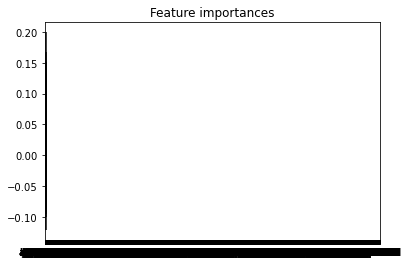

NameError: name 'fig' is not defined

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sklearn

# how many rows?
rows = 20
foldernameoutput = "Output/Tryptorubinlike_peptide"
filename = foldernameoutput+'/forestclassifier.sav'
filenameout = foldernameoutput+"/importances.txt"
fname = foldernameoutput+"/importances.pdf"
forest = pickle.load(open(filename, 'rb'))
feature_names = x_data.columns
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(0, rows):
    print(feature_names[indices[f]], str(importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(rows, importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(x_data.shape[1]), feature_names)
plt.show()

with open(filenameout, 'w') as file:
    for f in range(0, rows):
        file.write(fea


# Give list of all p450, that contain certain motivs

In [ ]:
# type in the motifs (easycode) that the p450 should contain
yes = ()
# type in mptifs, that p450 should not contain
no = ()
filename = 'allp450ncbi.fasta'
foldernameoutput = "Output/Tryptorubinlike_peptide"
filenameoutput = foldernameoutput+"/"+str(yes)+".csv"


def easysequence(sequence):
    # creates a string out of the sequence file, that only states if AA is acidic (a), basic (b), polar (p), neutral/unpolar (n),aromatic (r),Cystein (s) or a Prolin (t)
    seqstr = str(sequence)
    seqlist = list(seqstr)
    a = 0
    easylist = []
    for i in seqlist:
        if i == 'E' or i == 'D':

            easylist = easylist+['a']
        if i == 'K' or i == 'R' or i == 'H':

            easylist = easylist+['b']
        if i == 'S' or i == 'T' or i == 'N' or i == 'Q':

            easylist = easylist+['p']
        if i == 'F' or i == 'Y' or i == 'W':

            easylist = easylist+['r']
        if i == 'C':
            easylist = easylist+['s']

        if i == 'P':
            easylist = easylist+['t']

        if i == 'G' or i == 'A' or i == 'V' or i == 'L' or i == 'I' or i == 'M':
            easylist = easylist+['n']

    seperator = ''
    easysequence = seperator.join(easylist)
    return easysequence


newfile = pd.DataFrame(columns=['info', 'sequence'])
for i in yes:
    newfile[i] = []
for seq_record in SeqIO.parse(filename, "fasta"):
        new_row = {}
        countyes = 0
        countno = 0
    for i in yes:
        new_row =merge_two_dicts(new_row,{i:easyseq.count(i)})
        countyes=countyes+i:easyseq.count(i)
    for i in no:
        countno=countno+i:easyseq.count(i)
    if countyes>0 and countno==0:
        newfile= newfile.append(new_row, ignore_index=True)

newfile.to_csv(filenameoutput, index=False)